In [2]:
import numpy as np
import random
from typing import List, Union, Callable, Optional, Tuple, Dict, Any
import time
import copy
import matplotlib.pyplot as plt
from icecream import ic
from tqdm.auto import tqdm
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import re 

c:\Users\domen\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation

In [3]:
def prepare_data(file_path):
    """
    Prepares the data for Symbolic Regression with Genetic Programming
    
    Args:
        file_path: Path to the .npz file containing the data
        
    Returns:
        X: Array of input features
        y: Array of target outputs
        config: Configuration for GP based on the data
    """
    # 1. Loading the data
    print(f"Loading data from {file_path}...")
    data = np.load(file_path)
    X = data['x']
    y = data['y']
    
    # Specific handling for data with transposed dimensions
    # If we have more features than samples, we probably need to transpose
    if X.ndim > 1 and X.shape[1] > X.shape[0] and y.shape[0] == X.shape[1]:
        print("Detected format with features on rows and samples on columns, transposition...")
        X = X.T  # Trasponiamo per avere i campioni sulle righe
    
    # Management of different formats
    if y.ndim > 1:
        if y.shape[0] == 1 or y.shape[1] == 1:  # If y is [1, n_samples] or [n_samples, 1]
            y = y.flatten()
            print(f"y transformed into form {y.shape}")
    
    # Make sure that X is 2D if multidimensional
    if X.ndim == 1:
        X = X.reshape(-1, 1)
        print(f"X rendered 2D with shape{X.shape}")
    
    print(f"Final form: X shape {X.shape}, y shape {y.shape}")
    
    # Check for consistency in the number of samples
    if X.shape[0] != len(y):
        raise ValueError(f"Inconsistent number of samples: X ha {X.shape[0]} campioni, y ne ha {len(y)}")
    
    
    # Determining the dimensionality of the input
    n_features = X.shape[1]
    print(f"Input {n_features}-dimensional with {X.shape[0]} samples")
    
    # Configuration for GP
    # We define the ser of variables base on dimensionality
    # We assume that the variables are named x[0], x[1], ..., x[n_features-1]
    variables = [f'x[{i}]' for i in range(n_features)]
    
    # We define the range of constants based on the data
    const_range = max(np.max(np.abs(X)), np.max(np.abs(y)))
    
    # Complete configuration for GP
    config = {
        'variables': variables,
        'n_features': n_features,
        'const_range': const_range,
        'y_stats': {
            'mean': float(np.mean(y)),
            'std': float(np.std(y)),
            'min': float(np.min(y)),
            'max': float(np.max(y))
        },
        'dataset_size': len(y)
    }
    
    return X, y, config

for i in range(0, 9):
    file_path = f"../data/problem_{i}.npz"
    X, y, config = prepare_data(file_path)
    print(f"\nGP Configuration: {config}")
    print("-" * 50)

Loading data from ../data/problem_0.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (1000, 2), y shape (1000,)
Input 2-dimensional with 1000 samples

GP Configuration: {'variables': ['x[0]', 'x[1]'], 'n_features': 2, 'const_range': np.float64(3.23346517158693), 'y_stats': {'mean': 0.0740349656325135, 'std': 1.8421127520800509, 'min': -3.208666606823163, 'max': 3.23346517158693}, 'dataset_size': 1000}
--------------------------------------------------
Loading data from ../data/problem_1.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (500, 1), y shape (500,)
Input 1-dimensional with 500 samples

GP Configuration: {'variables': ['x[0]'], 'n_features': 1, 'const_range': np.float64(0.9954328739932046), 'y_stats': {'mean': -0.028581340125470176, 'std': 0.5035248258112494, 'min': -0.8322110937504172, 'max': 0.8389945887188881}, 'dataset_size': 500}
-----------------------------

### Expression Rapresentation

In [4]:
class Node:
    """Base class for representing a node in the expression tree"""
    def __init__(self):
        self.depth = 0  # Node depth
    
    def evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluates the node given an input X"""
        raise NotImplementedError("You must implement the evaluate method in the subclass")
    def copy(self) -> 'Node':
        """Copy current node"""
        raise NotImplementedError("You must implement the copy method in the subclass")
    
    def to_string(self) -> str:
        """Returns a string representation of the node"""
        raise NotImplementedError("You must implement the to_string method in the subclass")
    
    def get_complexity(self) -> int:
        """Returns the complexity of the node (number of nodes)"""
        return NotImplementedError("You must implement the get_complexity method in the subclass")
    
    def get_height(self) -> int:
        """Returns the height of the node"""
        return NotImplementedError("You must implement the get_height method in the subclass")
    
    def get_nodes(self) -> int:
        """Returns the total number of nodes in the tree"""
        return NotImplementedError("You must implement the get_nodes method in the subclass")
    

In [5]:
class FunctionNode(Node):
    """Class to represent a function node in the expression tree"""
    def __init__(self, function: Callable, arity: int, symbol: str, children: List[Node] = None):
        super().__init__()
        self.function = function # Function (np) to be applied
        self.arity = arity # Number of arguments (children) the function takes
        self.symbol = symbol # Symbol to represent the function (e.g., '+', '-', '*', '/')
        self.children = children if children is not None else []

    def evaluate(self, X: np.ndarray)->np.ndarray:
        """Evaluate the function by applying it to the children's results"""
        #Evaluate the children
        args= [child.evaluate(X) for child in self.children]
        # Apply the function
        return self.function(*args)
    
    def copy(self) -> 'FunctionNode':
        """Creates a deep copy of the function node"""
        new_children = [child.copy() for child in self.children]
        new_node = FunctionNode(self.function, self.arity, self.symbol, new_children)
        new_node.depth = self.depth
        return new_node
    
    def to_string(self) -> str:
        """Returns a string representation of the function node"""
        if self.arity == 1:
            # Unary function
            return f"{self.symbol}({self.children[0].to_string()})"
        elif self.arity == 2:
            # Binary function (e.g. +, -, *, /)
            return f"({self.children[0].to_string()} {self.symbol} {self.children[1].to_string()})"
        else:
            # Functions with greater arity (although they should not be common)
            args = ", ".join(child.to_string() for child in self.children)
            return f"{self.symbol}({args})"
        
    def get_complexity(self) -> int:
        """Returns the complexity of the node (number of nodes)"""
        return 1 + sum(child.get_complexity() for child in self.children)

    def get_height(self) -> int:
        """Returns the height of the node"""
        return 1 + max((child.get_height() for child in self.children), default=0)

    def get_nodes(self) -> List[Node]:
        """Returns a list of all nodes in the tree"""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes
    


In [6]:
class TerminalNode(Node):
    """Represents an end node in the tree (variable or constant)"""
    
    def __init__(self, value, is_variable: bool = False, var_index: int = None):
        super().__init__()
        self.value = value
        self.is_variable = is_variable
        self.var_index = var_index  # only used if is_variable is True
    
    def evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluate the terminal node"""
        if self.is_variable:
            # If it is a variable, we take the value from the input X
            if X.ndim == 1 and self.var_index == 0:
                return X  # special case for 1D 
            else:
                return X[:, self.var_index]
        else:
            # If it is a constant, we return the value (broadcast on all samples)
            return np.full(X.shape[0] if X.ndim > 1 else len(X), self.value)
    
    def copy(self) -> 'TerminalNode':
        """Creates a copy of the terminal node"""
        new_node = TerminalNode(self.value, self.is_variable, self.var_index)
        new_node.depth = self.depth
        return new_node
    
    def to_string(self) -> str:
        """Returns the string representation of the node"""
        if self.is_variable:
            return f"x[{self.var_index}]"
        else:
            return str(self.value)
    
    def get_complexity(self) -> int:
        """The complexity of a terminal node is 1"""
        return 1
    
    def get_height(self) -> int:
        """The height of an end node is 0"""
        return 0
    
    def get_nodes(self) -> List[Node]:
        """Returns a list containing only this node"""
        return [self]


In [7]:
class ExpressionTree:
    """It represents a complete expression tree"""
    
    def __init__(self, root: Node):
        self.root = root
        self.update_node_depths()
        self.fitness = None
        self.adjusted_fitness = None  # for fitness sharing
        self.age = 0  # for age of the tree
    
    def evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluates the expression tree on input data"""
        return self.root.evaluate(X)
    
    def copy(self) -> 'ExpressionTree':
        """Creates a deep copy of the tree"""
        new_tree = ExpressionTree(self.root.copy())
        new_tree.fitness = self.fitness
        new_tree.adjusted_fitness = self.adjusted_fitness
        new_tree.age = self.age
        return new_tree
    
    def to_string(self) -> str:
        """Returns the string representation of the tree"""
        return self.root.to_string()
    
    def get_complexity(self) -> int:
        """Returns the complexity of the tree"""
        return self.root.get_complexity()
    
    def get_height(self) -> int:
        """Returns the height of the tree"""
        return self.root.get_height()
    
    def get_nodes(self) -> List[Node]:
        """Returns a list of all nodes in the tree"""
        return self.root.get_nodes()
    
    def get_subtree_at_index(self, index: int) -> Node:
        """
        Returns the subtree at the node specified by the index
        Useful for crossover and mutation operations
        """
        nodes = self.get_nodes()
        if 0 <= index < len(nodes):
            return nodes[index]
        return None
    
    def replace_subtree_at_index(self, index: int, new_subtree: Node) -> bool:
        """
        Replaces the subtree at the node specified by the index
        Returns True if the operation is successful, False otherwise
        """
        nodes = self.get_nodes()
        if not (0 <= index < len(nodes)):
            return False
        
        target_node = nodes[index]
        
        # Special case: replacing the tree root
        if target_node == self.root:
            self.root = new_subtree
            self.update_node_depths()
            return True
        
        # Otherwise, we need to find the parent of the target node
        for node in nodes:
            if isinstance(node, FunctionNode):
                for i, child in enumerate(node.children):
                    if child == target_node:
                        node.children[i] = new_subtree
                        self.update_node_depths()
                        return True
        
        return False
    
    def update_node_depths(self):
        """Updates the depth of all nodes in the tree"""
        self._update_depth(self.root, 0)
    
    def _update_depth(self, node: Node, depth: int):
        """Recursive helper to update depth"""
        node.depth = depth
        if isinstance(node, FunctionNode):
            for child in node.children:
                self._update_depth(child, depth + 1)

### Function Set

In [8]:
def safe_div(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Protected division: returns a/b or 1 when b is close to zero"""
    return np.divide(a, b, out=np.ones_like(a), where=np.abs(b) > 1e-8)

def safe_log(a: np.ndarray) -> np.ndarray:
    """Protected logarithm: returns log(|a|) or 0 for a close to zero"""
    return np.log(np.abs(a), out=np.zeros_like(a), where=np.abs(a) > 1e-10)

def safe_sqrt(a: np.ndarray) -> np.ndarray:
    """Square root protected: returns sqrt(|a|)"""
    return np.sqrt(np.abs(a))

def safe_exp(a: np.ndarray) -> np.ndarray:
    """Protected exponential: limits input to avoid overflow"""
    return np.exp(np.clip(a, -200, 200))

def safe_sin(a: np.ndarray) -> np.ndarray:
    """Protected sin"""
    return np.sin(np.clip(a, -1000, 1000))

def safe_cos(a: np.ndarray) -> np.ndarray:
    """Protected cos"""
    return np.cos(np.clip(a, -1000, 1000))

def safe_tan(a: np.ndarray) -> np.ndarray:
    """Protected tangent: limits outputs to avoid extreme values"""
    return np.clip(np.tan(a), -200, 200)


In [9]:
def create_function_set(use_trig: bool = True, use_exp_log: bool = True) -> List[Dict[str, Any]]:
    """
    Creates a set of functions to be used in the expression tree.
    
    Args:
        use_trig: Whether to include trigonometric functions.
        use_exp_log: Whether to include exponential and logarithmic functions.
        
    Returns:
        List of dictionaries, each containing:
            - function: the Python function to call.
            - arity: the number of arguments required.
            - symbol: the symbol for display.
            - weight: selection weight (relative probability).
    """
    # Basic arithmetic functions (always included)
    functions = [
        {'function': np.add, 'arity': 2, 'symbol': '+', 'weight': 1.0},
        {'function': np.subtract, 'arity': 2, 'symbol': '-', 'weight': 1.0},
        {'function': np.multiply, 'arity': 2, 'symbol': '*', 'weight': 1.0},
        {'function': safe_div, 'arity': 2, 'symbol': '/', 'weight': 0.7},  # Peso più basso per la divisione
    ]
    
    # Trigonometric functions (optional)
    if use_trig:
        functions.extend([
            {'function': safe_sin, 'arity': 1, 'symbol': 'sin', 'weight': 0.6},
            {'function': safe_cos, 'arity': 1, 'symbol': 'cos', 'weight': 0.6},
            {'function': safe_tan, 'arity': 1, 'symbol': 'tan', 'weight': 0.5},  
        ])
    
    # Exponential and logarithmic functions (optional)
    if use_exp_log:
        functions.extend([
            {'function': safe_exp, 'arity': 1, 'symbol': 'exp', 'weight': 0.4},
            {'function': safe_log, 'arity': 1, 'symbol': 'log', 'weight': 0.5},
            {'function': safe_sqrt, 'arity': 1, 'symbol': 'sqrt', 'weight': 0.6},
        ])
    
    return functions


### Terminal Set

In [10]:
def create_variable_terminals(n_features: int, variable_weight: float = 1.0) -> List[Dict[str, Any]]:
    """
    Create terminals for input variables
    
    Args:
        n_features: Number of input variables
        variable_weight: Weight assigned to the variables
        
    Returns:
        List of dictionaries for variable terminals
    """
    return [
        {
            'is_variable': True, 
            'var_index': i, 
            'weight': variable_weight
        } for i in range(n_features)
    ]

In [11]:
def create_constant_terminals(const_range: float, n_constants: int = 10, 
                             standard_weight: float = 0.3,
                             zero_weight: float = 0.5,
                             one_weight: float = 0.5,
                             minus_one_weight: float = 0.3,
                             pi_weight: float = 0.2,
                             e_weight: float = 0.2) -> List[Dict[str, Any]]:
    """
    Creates terminals for constants
    
    Args:
        const_range: Range for random constants
        n_constants: Number of pre-generated constants
        standard_weight: Weight for random constants
        zero_weight: Weight for the constant 0
        one_weight: Weight for the constant 1
        minus_one_weight: Weight for the constant -1
        pi_weight: Weight for the constant π
        e_weight: Weight for the constant e
        
    Returns:
        List of dictionaries for constant terminals
    """
    # Costanti fisse importanti
    fixed_constants = [
        {'is_variable': False, 'value': 0.0, 'weight': zero_weight},
        {'is_variable': False, 'value': 1.0, 'weight': one_weight},
        {'is_variable': False, 'value': -1.0, 'weight': minus_one_weight},
        {'is_variable': False, 'value': np.pi, 'weight': pi_weight},
        {'is_variable': False, 'value': np.e, 'weight': e_weight},
    ]
    
    # Random constants pre-generated
    random_constants = [
        {
            'is_variable': False, 
            'value': random.uniform(-const_range, const_range) if abs(random.uniform(-const_range, const_range)) > 1e-8 else 1.0, ## Avoid zero
            'weight': standard_weight
        } for _ in range(n_constants)
    ]
    
    return fixed_constants + random_constants


In [12]:
def generate_ephemeral_constant(const_range: float) -> float:
    """
    Generates an ephemeral random constant
    avoiding values too close to zero
    """
    value = random.uniform(-const_range, const_range)
    # Avoid values too close to zero
    if abs(value) < 1e-8:
        if random.random() < 0.5:
            value = 1e-8
        else:
            value = -1e-8
    return value

In [13]:
class GPConfig:
    """Class for managing the configuration of the GP algorithm"""
    
    def __init__(self, 
                 n_features: int,
                 const_range: float,
                 use_trig: bool = True,
                 use_exp_log: bool = True,
                 min_depth: int = 2,
                 max_depth: int = 6,
                 pop_size: int = 500,
                 generations: int = 50,
                 tournament_size: int = 5,
                 crossover_prob: float = 0.7,
                 mutation_prob: float = 0.2,
                 elitism_rate: float = 0.1,
                 max_tree_size: int = 50,
                 parsimony_coef: float = 0.01,
                function_weights: dict = None,
                terminal_weights: dict = None):
        
        # Function Set Configuration and Terminals
        self.function_set = create_function_set(use_trig, use_exp_log)
        self.variable_terminals = create_variable_terminals(n_features)
        self.constant_terminals = create_constant_terminals(const_range)
        
        # Apply any custom weights to functions
        if function_weights:
            self._apply_function_weights(function_weights)
            
        # Apply any customised weights to the terminals
        if terminal_weights:
            self._apply_terminal_weights(terminal_weights)



        # Calculates cumulative weights for weighted selection
        self._calculate_weights()
        
        # Tree size limits
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.max_tree_size = max_tree_size
        
        # Parameters of the evolutionary algorithm
        self.pop_size = pop_size
        self.generations = generations
        self.tournament_size = tournament_size
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.elitism_rate = elitism_rate
        
        # Bloat control 
        self.parsimony_coef = parsimony_coef  # penalty for complexity
        
        # Other parameters
        self.n_features = n_features
        self.const_range = const_range


    def _apply_function_weights(self, function_weights):
        """Apply custom weights to functions"""
        for func in self.function_set:
            symbol = func['symbol']
            if symbol in function_weights:
                func['weight'] = function_weights[symbol]
                print(f"Personalised weight for {symbol}: {func['weight']}")
    
    def _apply_terminal_weights(self, terminal_weights):
        """Apply custom weights to terminals"""
        # For variables
        if 'variables' in terminal_weights:
            for var in self.variable_terminals:
                var['weight'] = terminal_weights['variables']
                
        
        if 'constants' in terminal_weights:
            for const in self.constant_terminals:
                if isinstance(const['value'], float) and not (const['value'] in [0.0, 1.0, -1.0, np.pi, np.e]):
                    const['weight'] = terminal_weights['constants']
                    
        if 'zero' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == 0.0:
                    const['weight'] = terminal_weights['zero']
                    
        if 'one' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == 1.0:
                    const['weight'] = terminal_weights['one']
                    
        if 'minus_one' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == -1.0:
                    const['weight'] = terminal_weights['minus_one']
        
        if 'pi' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == np.pi:
                    const['weight'] = terminal_weights['pi']
                    
        if 'e' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == np.e:
                    const['weight'] = terminal_weights['e']
        
                


    def _calculate_weights(self):
        """Calculates cumulative weights for weighted selection of functions and terminals"""
        # Cumulative weights for functions
        cum_weight = 0
        self.function_cumulative_weights  = []
        for func in self.function_set:
            cum_weight += func['weight']
            self.function_cumulative_weights.append(cum_weight)
        
        # Normalise weights
        if cum_weight > 0:
            self.function_cumulative_weights  = [w / cum_weight for w in self.function_cumulative_weights]
        
        # Cumulative weights for variable terminalsi
        cum_weight = 0
        self.variable_weights = []
        for var in self.variable_terminals:
            cum_weight += var['weight']
            self.variable_weights.append(cum_weight)
        
        # Normalise weights
        if cum_weight > 0:
            self.variable_weights = [w / cum_weight for w in self.variable_weights]
        
        # Cumulative weights for constant terminals
        cum_weight = 0
        self.constant_weights = []
        for const in self.constant_terminals:
            cum_weight += const['weight']
            self.constant_weights.append(cum_weight)
        
        # Normalise weights
        if cum_weight > 0:
            self.constant_weights = [w / cum_weight for w in self.constant_weights]
    
    def get_random_function(self) -> Dict[str, Any]:
        """Randomly selects a function from the set, based on weights"""
        r = random.random()
        for i, w in enumerate(self.function_cumulative_weights):
            if r <= w:
                return self.function_set[i]
        return self.function_set[-1]  # fallback
    
    def get_random_variable(self) -> Dict[str, Any]:
        """Randomly selects a terminal variable from the set, based on the weights"""
        if not self.variable_terminals:
            raise ValueError("No variables available")
        
        r = random.random()
        for i, w in enumerate(self.variable_weights):
            if r <= w:
                return self.variable_terminals[i]
        return self.variable_terminals[-1]  # fallback
    
    def get_random_constant(self) -> Dict[str, Any]:
        """Randomly selects a terminal constant from the set, based on the weights"""
        if not self.constant_terminals:
            # Generates a new ephemeral constant if no pre-defined constants are available
            return {'is_variable': False, 'value': generate_ephemeral_constant(self.const_range)}
        
        # Occasionally generates a new efimera constant instead of using a default one
        if random.random() < 0.3:  # 30% probability of generating a new constant
            return {'is_variable': False, 'value': generate_ephemeral_constant(self.const_range)}
        
        # Otherwise, select from the default constants
        r = random.random()
        for i, w in enumerate(self.constant_weights):
            if r <= w:
                return self.constant_terminals[i]
        return self.constant_terminals[-1]  # fallback
    
    def get_random_terminal(self) -> Dict[str, Any]:
        """Randomly selects a terminal (variable or constant)"""
        # Probability of selecting a variable vs. a constant
        # We generally want to give more weight to the variable
        if random.random() < 0.7:  # 70% probability of selecting a variable
            try:
                return self.get_random_variable()
            except ValueError:
                return self.get_random_constant()
        else:
            return self.get_random_constant()
        
    def print_function_weights(self):
        """Print current function weights"""
        print("Function weights:")
        for func in self.function_set:
            print(f"  {func['symbol']}: {func['weight']:.2f}")
    
    def print_terminal_weights(self):
        """Print current terminal weights"""
        print("Variable terminal weights:")
        for var in self.variable_terminals:
            print(f"  x[{var['var_index']}]: {var['weight']:.2f}")
        
        print("Constant terminal weights:")
        for const in self.constant_terminals:
            value_str = f"{const['value']}" if not const['is_variable'] else f"x[{const['var_index']}]"
            print(f"  {value_str}: {const['weight']:.2f}")    

### Initial Population

In [14]:
def grow_tree(config: GPConfig, max_depth: int, min_depth: int = 1, current_depth: int = 0) -> Node:
    """
    Grow' method for generating a tree with variable depth
    
    Args:
        config: GP configuration
        max_depth: Maximum depth of the tree
        min_depth: Minimum depth of the tree
        current_depth: Current depth of the node
        
    Returns:
        Root node of the generated tree
    """
    # If we are at the maximum depth, we can only create terminal nodes
    if current_depth >= max_depth:
        terminal_info = config.get_random_terminal()
        if terminal_info['is_variable']:
            return TerminalNode(None, is_variable=True, var_index=terminal_info['var_index'])
        else:
            return TerminalNode(terminal_info['value'], is_variable=False)
    
    # If we have not yet reached the minimum depth, we only create function nodes
    if current_depth < min_depth:
        function_info = config.get_random_function()
        children = [grow_tree(config, max_depth, min_depth, current_depth + 1) for _ in range(function_info['arity'])]
        return FunctionNode(function_info['function'], function_info['arity'], function_info['symbol'], children)
    
    # Otherwise, we randomly choose between functions and terminals
    if random.random() < 0.5:  # 50% probability for functions or terminals
        function_info = config.get_random_function()
        children = [grow_tree(config, max_depth, min_depth, current_depth + 1) for _ in range(function_info['arity'])]
        return FunctionNode(function_info['function'], function_info['arity'], function_info['symbol'], children)
    else:
        terminal_info = config.get_random_terminal()
        if terminal_info['is_variable']:
            return TerminalNode(None, is_variable=True, var_index=terminal_info['var_index'])
        else:
            return TerminalNode(terminal_info['value'], is_variable=False)

In [15]:
def full_tree(config: GPConfig, max_depth: int, current_depth: int = 0) -> Node:
    """
    Full' method for generating a tree with all branches at the same depth
    
    Args:
        config: GP configuration
        max_depth: Maximum depth of the tree
        current_depth: Current depth of the node
        
    Returns:
        Root node of the generated tree
    """
    # If we are at the maximum depth, we can only create terminal nodes
    if current_depth >= max_depth:
        terminal_info = config.get_random_terminal()
        if terminal_info['is_variable']:
            return TerminalNode(None, is_variable=True, var_index=terminal_info['var_index'])
        else:
            return TerminalNode(terminal_info['value'], is_variable=False)
    
    # Otherwise, we create only function nodes
    function_info = config.get_random_function()
    children = [full_tree(config, max_depth, current_depth + 1) for _ in range(function_info['arity'])]
    return FunctionNode(function_info['function'], function_info['arity'], function_info['symbol'], children)


In [16]:
def ramped_half_and_half(config: GPConfig, min_depth: int, max_depth: int) -> ExpressionTree:
    """
    Ramped half-and-half' initialisation method
    Combines grow and full for greater diversity
    
    Args:
        config: GP configuration
        min_depth: Minimum tree depth
        max_depth: Maximum depth of trees
        
    Returns:
        A new expression tree
    """
    # Choose a random depth between min_depth and max_depth
    depth = random.randint(min_depth, max_depth)
    
    # Choose randomly between ‘grow’ and ‘full’.
    if random.random() < 0.5:
        root = grow_tree(config, depth, min_depth)
    else:
        root = full_tree(config, depth)
    
    return ExpressionTree(root)

In [17]:
def initialize_population(config: GPConfig) -> List[ExpressionTree]:
    """
    Creates the initial population of expression trees
    
    Args:
        config: GP configuration
        
    Returns:
        List of expression trees
    """
    population = []
    unique_expressions = set()  # For tracking unique expressions
    
    print(f"Population initialisation of  {config.pop_size} individuals...")
    start_time = time.time()
    
    # Generate individuals until the population is full
    while len(population) < config.pop_size:
        tree = ramped_half_and_half(config, config.min_depth, config.max_depth)
        
        # Check if the expression is unique to contribute to inizial diversity
        expr_str = tree.to_string()
        if expr_str not in unique_expressions:
            unique_expressions.add(expr_str)
            population.append(tree)
            
            # We update the status every 100 individuals
            if len(population) % 1000 == 0:
                elapsed = time.time() - start_time
                print(f"  Generated  {len(population)} individuals in  {elapsed:.2f} seconds")
    
    elapsed = time.time() - start_time
    print(f"Population initialised in {elapsed:.2f} seconds")
    
    # Initial population statistics
    heights = [tree.get_height() for tree in population]
    sizes = [tree.get_complexity() for tree in population]
    print(f"Initial population statistics:")
    print(f"  - Average height: {np.mean(heights):.2f} (min: {min(heights)}, max: {max(heights)})")
    print(f"  - Average size: {np.mean(sizes):.2f} nodes (min: {min(sizes)}, max: {max(sizes)})")
    
    return population

### Fitness Evaluation

In [18]:
def calculate_fitness(tree: ExpressionTree, X: np.ndarray, y: np.ndarray, 
                      parsimony_coef: float = 0.001) -> float:
    """
    Calculates the fitness of an individual
    
    Args:
        tree: The expression tree to be evaluated
        X: Input features
        y: Output target
        parsimony_coef: Penalty coefficient for the complexity of the tree
        
    Returns:
        Fitness value (the lower the bett
    """
    try:
        # Evaluates the tree on input data        
        predictions = tree.evaluate(X)        # In the case of NaN or infinite values, it assigns a very high (bad) fitness
        if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
            return float('inf')
        
        # Calculate the mean square error (MSE)
        mse = np.mean((predictions - y) ** 2)
        # add a small penalty to encourage more complex solutions
        complexity = tree.get_complexity()
        complexity_penalty = 0.0
        if complexity < 1:
            complexity_penalty = parsimony_coef * (complexity - 2)
        
        # The final fitness is MSE + penalty (lower is better)
        fitness = mse + complexity_penalty
        return fitness
    
    except Exception as e:
        # In case of errors during the evaluation, it assigns a very high fitness
        print(f"Errore durante la valutazione: {e}")
        return float('inf')

In [19]:
def evaluate_population(population: List[ExpressionTree], X: np.ndarray, y: np.ndarray, 
                       config: GPConfig) -> None:
    """
    Evaluates all individuals in the population
    
    Args:
        population: List of expression trees
        X: Input features
        y: Output target
        config: GP configuration
    """
    for i, tree in enumerate(population):
        tree.fitness = calculate_fitness(tree, X, y, config.parsimony_coef)
        

In [20]:
def apply_semantic_fitness_sharing(population: List[ExpressionTree], X_sample: np.ndarray, 
                                sigma: float = 0.5) -> None:
    """
    Apply fitness sharing based on semantic behavior (output patterns)
    
    Args:
        population: List of expression trees already evaluated
        X_sample: Sample of input data to evaluate behavior on
        sigma: Radius of the sharing kernel (similarity threshold)
    """
    n = len(population)
    
    # Pre-compute outputs for all individuals on sample data
    outputs = []
    valid_indices = []
    
    for i, tree in enumerate(population):
        try:
            # Evaluate tree on sample data
            output = tree.evaluate(X_sample)
            
            # Check for invalid outputs
            if np.any(np.isnan(output)) or np.any(np.isinf(output)):
                outputs.append(None)
                continue
                
            # Normalize the output for more fair comparison
            if np.std(output) > 0:
                output = (output - np.mean(output)) / np.std(output)
            
            outputs.append(output)
            valid_indices.append(i)
        except Exception as e:
            # In case of evaluation errors, skip this individual
            outputs.append(None)
    
    
    # Calculate sharing factors based on output similarity
    for i in range(n):
        if i not in valid_indices:
            population[i].adjusted_fitness = float('inf')
            continue
            
        sharing_factor = 1.0
        
        for j in valid_indices:
            if i != j:
                # Calculate semantic distance (MSE between normalized outputs)
                distance = np.mean((outputs[i] - outputs[j]) ** 2)
                
                # Apply sharing if within the radius
                if distance < sigma:
                    # Sharing function: linear kernel
                    sharing_contribution = 1.0 - (distance / sigma)
                    sharing_factor += sharing_contribution
        
        # Limit and apply the sharing factor
        sharing_factor = min(10.0, max(1.0, sharing_factor))
        
        # Adjust fitness
        if population[i].fitness != float('inf'):
            population[i].adjusted_fitness = population[i].fitness * sharing_factor
        else:
            population[i].adjusted_fitness = float('inf')

In [21]:
def calculate_semantic_distance(tree1: ExpressionTree, tree2: ExpressionTree, 
                               X_sample: np.ndarray) -> float:
    """
    Calculates the semantic distance between two expression trees
    based on the behaviour on a data sample
    
    Args:
        tree1, tree2: Expression trees to compare
        X_sample: Input data sample to test behaviour
        
    Returns:
        Semantic distance (0 = identical behaviour)
    """
    # We evaluate trees on the data sample
    try:
        output1 = tree1.evaluate(X_sample)
        output2 = tree2.evaluate(X_sample)
        
        # Distance calculation (mean square error)
        if np.any(np.isnan(output1)) or np.any(np.isinf(output1)) or \
           np.any(np.isnan(output2)) or np.any(np.isinf(output2)):
            return float('inf')
        
        # Normalisation of outputs for fairer comparison
        if np.std(output1) > 0 and np.std(output2) > 0:
            output1 = (output1 - np.mean(output1)) / np.std(output1)
            output2 = (output2 - np.mean(output2)) / np.std(output2)
        
        # Calculate distance
        return np.mean((output1 - output2) ** 2)
    
    except Exception:
        # In case of errors, we consider the trees far apart
        return float('inf')

### Selection Method

In [22]:
def tournament_selection(population: List[ExpressionTree], tournament_size: int, 
                         use_adjusted_fitness: bool = False) -> ExpressionTree:
    """
    Select an individual by tournament selection
    
    Args:
        population: List of expression trees
        tournament_size: Number of tournament participants
        use_adjusted_fitness: Whether to use diversity-adjusted fitness
        
    Returns:
        The selected individual
    """
    # Randomly selects tournament_size individuals from the population
    contestants = random.sample(population, min(tournament_size, len(population)))
    
    # Find the individual with the best (lowest) fitness
    if use_adjusted_fitness:
        # Use fitness adjusted for diversity, if available
        best = min(contestants, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
    else:
        best = min(contestants, key=lambda x: float('inf') if x.fitness is None else x.fitness)
    
    return best


In [23]:
def age_weighted_selection(population: List[ExpressionTree], 
                          max_age: int = 10, 
                          young_advantage: float = 0.3) -> ExpressionTree:
    """
    Selection favouring younger individuals (with less age)
    
    Args:
        population: List of expression trees
        max_age: Maximum age considered for advantage
        young_advantage: Percentage advantage for young individuals
        
    Returns:
        The selected individual
    """
    # Calculates weights based on age
    age_weights = [max(0.1, 1.0 - (tree.age / max_age) * young_advantage) 
                  for tree in population]
    
    # Normalise weights
    total_weight = sum(age_weights)
    if total_weight > 0:
        norm_weights = [w / total_weight for w in age_weights]
    else:
        norm_weights = [1.0 / len(population)] * len(population)
    
    # Weighted selection
    return random.choices(population, weights=norm_weights, k=1)[0]


In [24]:
def select_parents(population: List[ExpressionTree], config: GPConfig, 
                  X_sample: np.ndarray) -> Tuple[ExpressionTree, ExpressionTree]:
    """
    Select two parents from the population
    
    Args:
        population: List of expression trees
        config: GP configuration
        X_sample: Data sample to calculate semantic diversity
        
    Returns:
        Parent pair
    """
    # We randomly choose the selection method
    selection_r = random.random()
    
    if selection_r < 0.9:  # 90% chance of using the standard tournament with adjusted fitness
        parent1 = tournament_selection(population, config.tournament_size, use_adjusted_fitness=True)
        parent2 = tournament_selection(population, config.tournament_size, use_adjusted_fitness=True)
    else:  # 10% probability of using age-based selection
        parent1 = age_weighted_selection(population)
        parent2 = age_weighted_selection(population)
    
    # Make sure the parents are different
    attempts = 0
    while parent1 == parent2 and attempts < 5:
        parent2 = tournament_selection(population, config.tournament_size)
        attempts += 1
    
    return parent1, parent2

### Genetic Operator

In [25]:
def subtree_crossover(parent1: ExpressionTree, parent2: ExpressionTree, 
                     max_tries: int = 5, max_depth: int = 10) -> Tuple[ExpressionTree, ExpressionTree]:
    """
    Crossover for trees: exchanging subtrees between parents
    
    Args:
        parent1, parent2: Parent trees
        max_tries: Maximum number of attempts to find valid crossover points
        max_depth: Maximum depth allowed for the resulting tree
        
    Returns:
        Two child trees generated by the crossover
    """
    # We create copies of parents
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    # Get all nodes in trees
    nodes1 = child1.get_nodes()
    nodes2 = child2.get_nodes()
    
    if not nodes1 or not nodes2:
        return child1, child2  # We cannot crossover if one of the trees is empty
    
    # Attempts crossover a limited number of times
    for _ in range(max_tries):
        # Randomly choose crossover points
        crossover_point1 = random.randrange(len(nodes1))
        crossover_point2 = random.randrange(len(nodes2))
        
        # Obtain the subtrees to be exchanged
        subtree1 = nodes1[crossover_point1]
        subtree2 = nodes2[crossover_point2]
        
        # Create copies of the subtrees to avoid modifying the originals
        subtree1_copy = subtree1.copy()
        subtree2_copy = subtree2.copy()
        
        # Replace the subtrees in the children
        child1.replace_subtree_at_index(crossover_point1, subtree2_copy)
        child2.replace_subtree_at_index(crossover_point2, subtree1_copy)
        
        # Update the depths of the nodes in the children
        child1.update_node_depths()
        child2.update_node_depths()
        
        # Check if the resulting trees are within the allowed depth
        if child1.get_height() <= max_depth and child2.get_height() <= max_depth:
            break
        else:
            # Restore children from parental copies
            child1 = parent1.copy()
            child2 = parent2.copy()
            nodes1 = child1.get_nodes()
            nodes2 = child2.get_nodes()
    
    # Increase age
    child1.age = 0
    child2.age = 0
    
    return child1, child2

In [26]:
def subtree_mutation(tree: ExpressionTree, config: GPConfig, 
                    max_depth: int = 10) -> ExpressionTree:
    """
    Subtree mutation: replaces a random subtree with a new one
    
    Args:
        tree: Tree to be mutated
        config: GP configuration
        max_depth: Maximum depth allowed for the resulting tree
        
    Returns:
        Shaft mutated
    """
    # Create a copy of the tree
    mutated = tree.copy()
    
    # Get all nodes in the tree
    nodes = mutated.get_nodes()
    
    if not nodes:
        return mutated  # We cannot mutate an empty tree
    
    # Randomly select a mutation point
    mutation_point = random.randrange(len(nodes))
    
    # Calculate the maximum depth for the new subtree
    node_depth = nodes[mutation_point].depth
    remaining_depth = max_depth - node_depth
    
    if remaining_depth < 1:
        return mutated  # We cannot change if there is no room to grow
    
    # Generates a new random subtree
    new_subtree = grow_tree(config, remaining_depth, min_depth=1)
    
    # Replace the subtree
    mutated.replace_subtree_at_index(mutation_point, new_subtree)
    
    # Updates node depths
    mutated.update_node_depths()
    
    # Reset age
    mutated.age = 0
    
    return mutated

In [27]:
def point_mutation(tree: ExpressionTree, config: GPConfig) -> ExpressionTree:
    """
    Point mutation: changes a single node while maintaining the tree structure
    
    Args:
        tree: Tree to be mutated
        config: GP configuration
        
    Returns:
        Tree mutated
    """
    # Create a copy of the tree
    mutated = tree.copy()
    
    # Obtain all nodes in the tree
    nodes = mutated.get_nodes()
    
    if not nodes:
        return mutated  # We cannot mutate an empty tree
    
    # Randomly select a mutation point
    mutation_point = random.randrange(len(nodes))
    node = nodes[mutation_point]
    
    # Mutation based on node type
    if isinstance(node, FunctionNode):
        # Replace with another function of the same arity
        compatible_functions = [f for f in config.function_set if f['arity'] == node.arity]
        if compatible_functions:
            function_info = random.choice(compatible_functions)
            new_node = FunctionNode(function_info['function'], 
                                   function_info['arity'], 
                                   function_info['symbol'],
                                   node.children.copy())  # reuses the same children
            
            # Replace the node
            mutated.replace_subtree_at_index(mutation_point, new_node)
    
    elif isinstance(node, TerminalNode):
        if node.is_variable:
            # Replace with another variable
            if len(config.variable_terminals) > 1:
                terminal_info = config.get_random_variable()
                while terminal_info['var_index'] == node.var_index:
                    terminal_info = config.get_random_variable()
                
                new_node = TerminalNode(None, True, terminal_info['var_index'])
                mutated.replace_subtree_at_index(mutation_point, new_node)
        else:
            # We could replace it with another constant or slightly modify the valu
            if random.random() < 0.5:  # 50% probability of changing the value
                # Change existing value (small perturbation)
                new_value = node.value * (1.0 + random.uniform(-0.1, 0.1))
                new_node = TerminalNode(new_value, False)
                #Avoid zero values
                if abs(new_value) < 1e-8:
                    new_value = 1e-8 if new_value >= 0 else -1e-8
            else:
                # Replace with a new constant
                terminal_info = config.get_random_constant()
                new_node = TerminalNode(terminal_info['value'], False)
            
            mutated.replace_subtree_at_index(mutation_point, new_node)
    
    # Updates node depths
    mutated.update_node_depths()
    
    # Reset age
    mutated.age = 0
    
    return mutated


In [28]:
def deterministic_crowding(parent1: ExpressionTree, parent2: ExpressionTree,
                          child1: ExpressionTree, child2: ExpressionTree,
                          X: np.ndarray, y: np.ndarray, config: GPConfig) -> List[ExpressionTree]:
    """
    Deterministic crowding: children replace parents only if they have better fitness
    
    Args:
        parent1, parent2: Parents
        child1, child2: Children generated by parents
        X, y: Data for evaluation
        config: GP configuration
        
    Returns:
        List of selected individuals
    """
    # Calculates similarities between parents and children
    X_sample = X[:min(len(X), 500)]  # Use a sample for efficiency


    # Calculate children's fitness
    child1.fitness = calculate_fitness(child1, X, y, config.parsimony_coef)
    child2.fitness = calculate_fitness(child2, X, y, config.parsimony_coef)
    
    # Apply fitness sharing to parents and children
    # We can create a small temporary population with children to calculate their adjusted_fitness
    temp_pop = [parent1, parent2, child1, child2]
    apply_semantic_fitness_sharing(temp_pop, X_sample)


    
    dist_p1c1 = calculate_semantic_distance(parent1, child1, X_sample)
    dist_p1c2 = calculate_semantic_distance(parent1, child2, X_sample)
    
    # Decide which parent-child pairings to compare
    if dist_p1c1 <= dist_p1c2:
        # parent1 vs child1, parent2 vs child2
        competition1 = (parent1, child1)
        competition2 = (parent2, child2)
    else:
        # parent1 vs child2, parent2 vs child1
        competition1 = (parent1, child2)
        competition2 = (parent2, child1)
    
    result = []
    
    # First competition
    if competition1[1].adjusted_fitness <= competition1[0].adjusted_fitness:
        result.append(competition1[1])  # the child wins
    else:
        result.append(competition1[0])  # the parent wins
    
    # Second competition
    if competition2[1].adjusted_fitness <= competition2[0].adjusted_fitness:
        result.append(competition2[1])  # The child wins
    else:
        result.append(competition2[0])  # The parent wins
    
    return result

In [29]:
def apply_genetic_operators(population: List[ExpressionTree], X: np.ndarray, y: np.ndarray, 
                           config: GPConfig) -> List[ExpressionTree]:
    """
    Apply genetic operators to create a new population
    
    Args:
        population: List of expression trees
        X, y: Evaluation data
        config: GP configuration
        
    Returns:
        New population
    """
    # Sort population by fitness (best first)
    sorted_population = sorted(population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
    
    # Number of individuals to be selected by elitism
    n_elite = int(config.pop_size * config.elitism_rate)
    
    # Sample to calculate semantic diversity
    X_sample = X[:min(len(X), 500)]  # Use a sample for efficiency
    
    # Select elites
    new_population = [tree.copy() for tree in sorted_population[:n_elite]]
    
    # Increase the age of each elite individual
    for tree in new_population:
        tree.age += 1
    
    # Complete the population with new individual
    while len(new_population) < config.pop_size:
        # Select genetic operation (crossover or mutation)
        op_choice = random.random()
        
        if op_choice < config.crossover_prob:
            # Crossover
            parent1, parent2 = select_parents(population, config, X_sample)
            child1, child2 = subtree_crossover(parent1, parent2, max_depth=config.max_depth)
            
            # Apply post-crossover mutation based on mutation probability 
            # The higher the mutation_prob, the more likely this happens
            if random.random() < config.mutation_prob * 0.5:  # 50% of mutation_prob chance
                mutation_choice = random.random()
                if mutation_choice < 0.7:  # 70% subtree mutation
                    child1 = subtree_mutation(child1, config, max_depth=config.max_depth)
                else:  # 30% point mutation
                    child1 = point_mutation(child1, config)
                    
            if random.random() < config.mutation_prob * 0.5:  # 50% of mutation_prob chance
                mutation_choice = random.random()
                if mutation_choice < 0.7:  # 70% subtree mutation
                    child2 = subtree_mutation(child2, config, max_depth=config.max_depth)
                else:  # 30% point mutation
                    child2 = point_mutation(child2, config)

            # Use deterministic crowding to decide which individuals to keep
            selected = deterministic_crowding(parent1, parent2, child1, child2, X, y, config)
            
            # Add to new population
            new_population.extend(selected)
            if len(new_population) > config.pop_size:
                new_population = new_population[:config.pop_size]
        
        elif op_choice < config.crossover_prob + config.mutation_prob:
            # Mutation
            parent = tournament_selection(population, config.tournament_size)
            
            # Rnandomly choose between subtree mutation and point mutation
            mutation_choice = random.random()
            
            if mutation_choice < 0.7:  # 70% subtree mutation
                child = subtree_mutation(parent, config, max_depth=config.max_depth)
            else:  # 30% point mutation
                child = point_mutation(parent, config)
            
            # Calculate fitness of the child
            child.fitness = calculate_fitness(child, X, y, config.parsimony_coef)
            temp_pop = [parent, child]
            apply_semantic_fitness_sharing(temp_pop, X_sample)
            # Compare parent and child
            if child.adjusted_fitness <= parent.adjusted_fitness:
                new_population.append(child)
            else:
                # Still add the son with some probability
                if random.random() < 0.1:  # 10% probability
                    new_population.append(child)
                else:
                    new_population.append(parent.copy())
        
        else:
            # Playback (direct copy)
            parent = tournament_selection(population, config.tournament_size)
            offspring = parent.copy()
            offspring.age += 1  # Increase age
            new_population.append(offspring)
    
    # Make sure the population is exactly the right size
    if len(new_population) > config.pop_size:
        new_population = new_population[:config.pop_size]
    
    # Fitness adjusted for diversity
    apply_semantic_fitness_sharing(new_population, X_sample)
    
    return new_population

### Diversity Maintenance

In [30]:
class Island:
    """Representing an island in the Island Model"""
    
    def __init__(self, population: List[ExpressionTree], config: GPConfig, island_id: int):
        self.population = population
        self.config = config
        self.id = island_id
        self.best_individual = None
        self.best_fitness = float('inf')
        self.generations_without_improvement = 0
        self.mutation_strength = 1.0  # Starting mutation strength
    
    def evolve(self, X: np.ndarray, y: np.ndarray, generation: int,
               use_adaptive_mutation: bool = False,
               min_mutation_strength: float = 0.5,
               max_mutation_strength: float = 3.0,
               adaptation_rate: float = 0.1) -> None:
        """
        Evolving the island for a generation
        
        Args:
            X, y: Training data
            generation: Number of the current generation
            use_adaptive_mutation: Whether to use adaptive mutation
            min_mutation_strength: Minimum mutation strength multiplier
            max_mutation_strength: Maximum mutation strength multiplier
            adaptation_rate: How quickly mutation strength changes
        """
        # Store original mutation probability
        original_mutation_prob = self.config.mutation_prob
        
        # Apply adaptive mutation if enabled
        if use_adaptive_mutation:
            # Adjust mutation probability based on current strength
            self.config.mutation_prob = original_mutation_prob * self.mutation_strength

        # Apply genetic operators
        self.population = apply_genetic_operators(self.population, X, y, self.config)
        
        # Update the best solution
        current_best = min(self.population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        #print("In evolution:")
       
        
        if current_best.adjusted_fitness < self.best_fitness:
            self.best_individual = current_best.copy()
            self.best_fitness = current_best.adjusted_fitness
            self.generations_without_improvement = 0

            # Decrease mutation strength when improvement found
            if use_adaptive_mutation:
                self.mutation_strength = max(min_mutation_strength, 
                                           self.mutation_strength * (1 - adaptation_rate))


        else:
            self.generations_without_improvement += 1

            # Increase mutation strength during stagnation
            if use_adaptive_mutation:
                self.mutation_strength = min(max_mutation_strength, 
                                           self.mutation_strength * (1 + adaptation_rate))
                
        # Reset mutation probability to original value
        self.config.mutation_prob = original_mutation_prob
        
        # Progress log
        if generation % 100 == 0:  # Every 100 generations
            mutation_info = f" | Mutation Strength: {self.mutation_strength:.2f}" if use_adaptive_mutation else ""
            print(f"Island {self.id} | Generation {generation} | Best Fitness: {self.best_fitness}{mutation_info}")

In [31]:
def initialize_islands(total_population: List[ExpressionTree], config: GPConfig, n_islands: int = 3) -> List[Island]:
    """
    Initialise islands by dividing the population
    
    Args:
        total_population: Full list of expression trees
        config: GP configuration
        n_islands: Number of islands to create
        
    Returns:
        List of Island objects
    """
    islands = []
    # Randomly mixing the population
    shuffled_population = random.sample(total_population, len(total_population))
    
    # Calculate the size of each island
    island_size = len(shuffled_population ) // n_islands
    
    # Distribute the population among the islands
    for i in range(n_islands):
        start_idx = i * island_size
        end_idx = start_idx + island_size if i < n_islands - 1 else len(shuffled_population)
        island_population = shuffled_population[start_idx:end_idx]
        
        # Create island-specific configuration
        island_config = copy.deepcopy(config)
        island_config.pop_size = len(island_population)
        
        # Create isaland
        island = Island(island_population, island_config, i)
        islands.append(island)
    
    return islands


In [32]:
def migration(islands: List[Island], migration_rate: float = 0.2, X: np.ndarray = None, y: np.ndarray = None, X_sample: np.ndarray = None) -> None:
    """
    Migration with adaptive mutation based on source-destination diversity relationship
    
    Args:
        islands: List of Island objects
        migration_rate: Percentage of population migrating
        X_sample: Sample of input data to evaluate diversity
    """
    if len(islands) <= 1:
        return
    
    print("Performing inter-island migration...")

     # Calculate diversity for each island if sample data is provided
    island_diversities = []
    if X_sample is not None:
        for island in islands:
            island_div = calculate_semantic_diversity(island.population, X_sample)
            island_diversities.append(island_div)
            print(f"  Island {island.id} diversity: {island_div:.3f}")
    else:
        # Default to medium diversity if we can't calculate
        island_diversities = [0.5] * len(islands)
            
    for i, source_island in enumerate(islands):
        # Calculates the destination island (the next, or the first if it is the last)
        dest_idx = (i + 1) % len(islands)
        dest_island = islands[dest_idx]

        # Get diversity values
        source_diversity = island_diversities[i]
        dest_diversity = island_diversities[dest_idx]

         # If source is more diverse than destination, use lower mutation strength
        if source_diversity > dest_diversity:
            # Minimal mutation - just enough to avoid exact duplicates
            mutation_strength = 0.5
        else:
            # Stronger mutation to introduce novelty
            # The larger the diversity gap, the stronger the mutation
            diversity_gap = max(0, dest_diversity - source_diversity)
            mutation_strength = 1.0 + (diversity_gap * 3.0)  # Scale up based on gap
            mutation_strength = min(3.0, max(0.5, mutation_strength))  # Limit range
        
        # Number of individuals to migrate
        n_migrants = max(1, int(source_island.config.pop_size * migration_rate))
        
        # Select migrants (half best, half random)
        n_best = n_migrants // 2
        n_random = n_migrants - n_best
        
        # Sort by fitness
        sorted_pop = sorted(source_island.population, 
                          key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        
        # Get the best
        migrants_best = [ind.copy() for ind in sorted_pop[:n_best]]
        
        # Take some random
        migrants_random = [ind.copy() for ind in random.sample(source_island.population, n_random)]
        
        migrants = migrants_best + migrants_random
        # Mutation of migrants if requested
        
        for j, migrant in enumerate(migrants):
            was_mutated = False
            # Apply mutation with increased probability
            if random.random() < source_island.config.mutation_prob * mutation_strength:
                
                # Randomly choose the mutation type
                mutation_choice = random.random()
                
                if mutation_choice < 0.7:  # 70% subtree mutation
                    migrants[j] = subtree_mutation(migrant, source_island.config, 
                                                 max_depth=source_island.config.max_depth)
                    was_mutated = True
                else:  # 30% point mutation
                    migrants[j] = point_mutation(migrant, source_island.config)
                    was_mutated = True
                
                # Rcompute the fitness of the mutated individual
                if was_mutated and X is not None and y is not None:                    
                        migrants[j].fitness = calculate_fitness(migrants[j], X, y, source_island.config.parsimony_coef)

        if X_sample is not None and len(migrants) > 1:
            apply_semantic_fitness_sharing(migrants, X_sample)
        
        # Replace the worst in the destination island
        dest_sorted = sorted(dest_island.population, 
                           key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness, 
                           reverse=True)  # decrescent order
        
        # Remove the worst individuals from the destination island
        for j in range(min(n_migrants, len(dest_sorted))):
            dest_island.population.remove(dest_sorted[j])
        
        # Add the migrants to the destination island
        dest_island.population.extend(migrants)
        
        print(f"  Migration: {n_migrants} individuals from island {i} to island {dest_idx}" + 
              f"(mutation strength: {mutation_strength:.2f})")

In [33]:
def calculate_semantic_diversity(population: List[ExpressionTree], X_sample: np.ndarray, 
                               distance_threshold: float = 0.01) -> float:
    """
    Calculate population diversity based on semantic behavior
    
    Args:
        population: List of expression trees
        X_sample: Sample of input data to evaluate semantic behavior
        distance_threshold: Threshold to consider two behaviors as distinct
        
    Returns:
        Diversity ratio (semantically unique individuals / total population)
    """
    # Calculate outputs for each individual on the sample data
    outputs = []
    valid_indices = []
    
    for i, tree in enumerate(population):
        try:
            output = tree.evaluate(X_sample)
            # Normalize output to make comparisons more meaningful
            if np.std(output) > 0:
                output = (output - np.mean(output)) / np.std(output)
            outputs.append(output)
            valid_indices.append(i)
        except Exception:
            continue
    
    if not outputs:
        return 0.0  # No valid outputs
    
    # Cluster individuals based on semantic similarity
    unique_behaviors = 1  # Start with the first individual
    
    
    # For each subsequent individual, check if it's semantically unique
    for i in range(1, len(outputs)):
        is_unique = True
        for j in range(i):
            semantic_distance = np.mean((outputs[i] - outputs[j]) ** 2)
            if semantic_distance < distance_threshold:
                is_unique = False
                break
        
        if is_unique:
            unique_behaviors += 1
    
    return unique_behaviors / len(population)


### Bloat Control

In [34]:
def apply_bloat_control(population: List[ExpressionTree],X: np.ndarray, y: np.ndarray, config: GPConfig) -> None:
    """
    Applies various bloat control techniques
    
    Args:
        population: List of expression trees
        config: GP configuration
    """
    # Check for oversized individuals
    oversized = [i for i, tree in enumerate(population) if tree.get_complexity() > config.max_tree_size]
    
    if oversized:
        print(f"Bloat control: {len(oversized)} individuals exceed the maximum size")
        
        for idx in oversized:
            # Attempt to reduce size by replacing sub-shafts with terminals
            tree = population[idx]
            nodes = tree.get_nodes()
            
            # Find non-terminal knots at greater depths
            non_terminal_nodes = [i for i, node in enumerate(nodes) 
                                if isinstance(node, FunctionNode) and node.depth > 2]
            
            if non_terminal_nodes:
                # Replace a random node with a terminal
                node_idx = random.choice(non_terminal_nodes)
                
                # Create a new terminal node
                terminal_info = config.get_random_terminal()
                if terminal_info['is_variable']:
                    new_node = TerminalNode(None, True, terminal_info['var_index'])
                else:
                    new_node = TerminalNode(terminal_info['value'], False)
                
                # Replace the subtree
                tree.replace_subtree_at_index(node_idx, new_node)
                tree.update_node_depths()
                tree.fitness = calculate_fitness(tree, X, y, config.parsimony_coef)
        
        #After modification of all the tree, recompute the adjusted fitness
        X_sample = X[:min(len(X), 500)] 
        apply_semantic_fitness_sharing(population, X_sample)        
    
    # Apply lexicographic parsimony pressure
    # When two individuals have similar fitness, prefer the simpler one
    epsilon = 0.0000001  # threshold for considering similar fitness
    
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            tree_i = population[i]
            tree_j = population[j]
            
            # If the fitnesses are similar
            if abs(tree_i.adjusted_fitness - tree_j.adjusted_fitness) < epsilon:
                # Get complexity
                complexity_i = tree_i.get_complexity()
                complexity_j = tree_j.get_complexity()
                
                # If tree j is significantly more complex, penalise it
                if complexity_j > complexity_i * 1.5:
                    # Add a small fitness penalty
                    tree_j.adjusted_fitness += epsilon
                
                # If tree i is significantly more complex, penalise it
                elif complexity_i > complexity_j * 1.5:
                    # Add a small fitness penalty
                    tree_i.adjusted_fitness += epsilon

### Simplify Expression

In [35]:
def simplify_expression(expression: str) -> str:
    """
    Simplifies a mathematical expression using basic algebraic rules.
    
    Args:
        expression: Expression as string
        
    Returns:
        Simplified expression
    """
    # For complete simplification you would need a library like sympy
    # This is an improved version that implements more simplification rules
    
    # Initial cleaning: removes excess spaces
    expression = expression.strip()
    
    # Liste di pattern di semplificazione in ordine di applicazione
    simplification_rules = [
        # Operations with 0
        (r'\(\s*0\.0+\s*\+\s*(.*?)\s*\)', r'(\1)'),  # (0.0 + x) -> (x)
        (r'\(\s*(.*?)\s*\+\s*0\.0+\s*\)', r'(\1)'),  # (x + 0.0) -> (x)
        (r'\(\s*0\.0+\s*\-\s*(.*?)\s*\)', r'(0.0 - \1)'),  # (0.0 - x) -> (0.0 - x) [keep]
        (r'\(\s*(.*?)\s*\-\s*0\.0+\s*\)', r'(\1)'),  # (x - 0.0) -> (x)
        (r'\(\s*(.*?)\s*\*\s*0\.0+\s*\)', r'0.0000'),  # (x * 0.0) -> 0.0
        (r'\(\s*0\.0+\s*\*\s*(.*?)\s*\)', r'0.0000'),  # (0.0 * x) -> 0.0
        (r'\(\s*0\.0+\s*\/\s*(.*?)\s*\)', r'0.0000'),  # (0.0 / x) -> 0.0
        (r'\(\s*(.*?)\s*\/\s*0\.0+\s*\)', r'inf'),  # (x / 0.0) -> inf [capture division by zero]
        
        # Operations with 1
        (r'\(\s*(.*?)\s*\*\s*1\.0+\s*\)', r'(\1)'),  # (x * 1.0) -> (x)
        (r'\(\s*1\.0+\s*\*\s*(.*?)\s*\)', r'(\1)'),  # (1.0 * x) -> (x)
        (r'\(\s*(.*?)\s*\/\s*1\.0+\s*\)', r'(\1)'),  # (x / 1.0) -> (x)
        (r'\(\s*1\.0+\s*\/\s*(.*?)\s*\)', r'(1.0 / \1)'),  # (1.0 / x) keep
        
        # Operations with himself
        (r'\(\s*(.*?)\s*\-\s*\1\s*\)', r'0.0000'),  # (x - x) -> 0.0
        (r'\(\s*(.*?)\s*\/\s*\1\s*\)', r'1.0000'),  # (x / x) -> 1.0 [dangerous for x=0, but we handle it in safe_div]
        
        # Functional simplifications
        (r'sin\(\s*0\.0+\s*\)', r'0.0000'),  # sin(0.0) -> 0.0
        (r'cos\(\s*0\.0+\s*\)', r'1.0000'),  # cos(0.0) -> 1.0
        (r'exp\(\s*0\.0+\s*\)', r'1.0000'),  # exp(0.0) -> 1.0
        (r'log\(\s*1\.0+\s*\)', r'0.0000'),  # log(1.0) -> 0.0
        
        # Nested operations
        (r'\(\(\s*(.*?)\s*\)\)', r'(\1)'),  # ((x)) -> (x) Remove double parentheses
        
        # More specific nested operations
        (r'\(\(([^()]*)\)\s*\+\s*\(([^()]*)\)\)', r'((\1) + (\2))'),  # ((a) + (b)) -> (a + b)
        (r'\(\(([^()]*)\)\s*\-\s*\(([^()]*)\)\)', r'((\1) - (\2))'),  # ((a) - (b)) -> (a - b)
        
        # Other algebraic simplifications
        (r'\(\s*(.*?)\s*\+\s*\(\s*\-\s*(.*?)\s*\)\s*\)', r'(\1 - \2)'),  # (a + (-b)) -> (a - b)
        (r'\(\s*(.*?)\s*\-\s*\(\s*\-\s*(.*?)\s*\)\s*\)', r'(\1 + \2)'),  # (a - (-b)) -> (a + b)
    ]
    
    # Final cleaning pattern (to be applied at the end)
    cleanup_rules = [
        # Removes outer brackets if possible
        (r'^\((.*)\)$', r'\1'),  # (x) -> x for the entire expression
        
        # Number Formatting
        (r'0\.0+', r'0.0'),  # 0.0000 -> 0.0
        (r'1\.0+', r'1.0'),  # 1.0000 -> 1.0
        
        # Removal of unnecessary brackets
        (r'\(\s*x\[(\d+)\]\s*\)', r'x[\1]'),  # (x[0]) -> x[0]
    ]
    
    # Applies simplification rules repeatedly
    prev_expr = ""
    while prev_expr != expression:
        prev_expr = expression
        for pattern, replacement in simplification_rules:
            expression = re.sub(pattern, replacement, expression)
    
    # Applies final cleaning rules
    for pattern, replacement in cleanup_rules:
        expression = re.sub(pattern, replacement, expression)
    
    return expression

In [36]:
def sympy_simplify_expression(expression: str) -> str:
    """
    Simplifies an expression using the sympy library for symbolic calculation.
    
    Args:
        expression: Expression as string
        
    Returns:
        Simplified expression
    """
    try:
        
        # Prepare the expression for sympy (replacing x[0] with x_0, etc.).
        prepared_expr = re.sub(r'x\[(\d+)\]', r'x_\1', expression)
        
        # Define Symbols
        symbol_names = set(re.findall(r'x_(\d+)', prepared_expr))
        symbols = {f'x_{i}': sp.Symbol(f'x_{i}', real=True) for i in symbol_names}  # Forza i simboli ad essere reali
        
        # Analyses and simplifies the expression
        parsed_expr = parse_expr(prepared_expr, local_dict=symbols)
        simplified = sp.sympify(parsed_expr) #or expand 
        
        # Checks whether the expression contains complex numbers or special symbols such as zoo
        if "zoo" in str(simplified) or "I" in str(simplified) or "oo" in str(simplified):
            # Fallback to basic simplification if we obtain problematic results
            return simplify_expression(expression)
        
        # Convert back to original format
        result = str(simplified)
        result = re.sub(r'x_(\d+)', r'x[\1]', result)
        return result
    except Exception as e:
        # Fallback to basic simplification if sympy is not available or there is an error
        print(f"Invalid expression for sympy: {expression}")
        print(f"Preapred expression: {prepared_expr}")
        print(f"Error in simplification sympy: {str(e)}")
        return simplify_expression(expression)

### Princial Algorithm

In [37]:
def genetic_programming(X: np.ndarray, y: np.ndarray, config: GPConfig, 
                       # Parameters for the island model
                       use_islands: bool = False,
                       n_islands: int = 5, 
                       migration_interval: int = 10,
                       migration_rate: float = 0.1,
                       
                       # Parameters for bloat control
                       bloat_control_interval: int = 5,

                        # Parameters for adaptive mutation
                       use_adaptive_mutation: bool = True,
                       base_mutation_rate: float = None,  # If None, use config.mutation_prob
                       min_mutation_strength: float = 0.5,
                       max_mutation_strength: float = 3.0,
                       adaptation_rate: float = 0.1,  # How quickly mutation strength changes
                       ) -> ExpressionTree:
    """
    Main Genetic Programming Algorithm for Symbolic Regression
    
    Args:
        X: Input features
        y: Output target
        config: GP configuration
        
        # Parameters for the island model
        use_islands: Whether to use the island model
        n_islands: Number of islands (if use_islands is True)
        migration_interval: Interval of generations between migrations
        migration_rate: Percentage of population migrating
        
        # Parameters for bloat control
        bloat_control_interval: Interval of generations for bloat control
       
        # Parameters for adaptive mutation
        use_adaptive_mutation: Whether to use adaptive mutation
        base_mutation_rate: Base mutation rate (if None, use config.mutation_prob)
        min_mutation_strength: Minimum mutation strength
        max_mutation_strength: Maximum mutation strength
        adaptation_rate: Rate of adaptation for mutation strength
        
    Returns:
        Best expression tree found
    """


    #Debug info
    X_original = X.copy()
    y_original = y.copy()
    
    print(f"Prima di qualsiasi elaborazione:")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"X mean: {np.mean(X)}, y mean: {np.mean(y)}")
    print(f"X std: {np.std(X)}, y std: {np.std(y)}")
    print(f"X range: [{np.min(X)}, {np.max(X)}], y range: [{np.min(y)}, {np.max(y)}]")


    start_time = time.time()
    print(f"Starting Genetic Programming for Symbolic Regression...")
    print(f"Configuration: pop_size={config.pop_size}, max_depth={config.max_depth}, "
          f"generations={config.generations}")
    
    # Initialize adaptive mutation parameters
    if use_adaptive_mutation:
        if base_mutation_rate is None:
            base_mutation_rate = config.mutation_prob
        current_mutation_strength = 1.0
        print(f"Using adaptive mutation with strength range [{min_mutation_strength:.2f}, {max_mutation_strength:.2f}]")
    
    if use_islands:
        print(f"Island model: {n_islands} islands, migration every {migration_interval} generations")
        config.print_function_weights()

    X_sample = X[:min(len(X), 500)]  # Use a sample for efficiency
    
    # Initialise the population
    initial_population = initialize_population(config)
    
    # Assess the initial population
    evaluate_population(initial_population, X, y, config)
    
    # Apply fitness sharing for diversity
    apply_semantic_fitness_sharing(initial_population, X_sample)
    
    # Initialise islands or single population
    if use_islands:
        islands = initialize_islands(initial_population, config, n_islands)
        best_individual = min([island.best_individual for island in islands if island.best_individual], 
                            key=lambda x: x.adjusted_fitness, default=None)
        best_fitness = float('inf') if best_individual is None else best_individual.adjusted_fitness
    else:
        population = initial_population
        best_individual = min(population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        best_fitness = best_individual.adjusted_fitness
    
    # Statistics for monitoring
    stats = {
        'best_fitness': [],
        'avg_fitness': [],
        'avg_size': [],
        'best_size': []
        #'diversity': []
    }
    
    # Principal loop of the algorithm
    generations_without_improvement = 0
    for generation in tqdm(range(config.generations)): 
        
        if use_islands:
            # Evolve each island separately
            for island in islands:
                island.evolve(X, y, generation, 
                         use_adaptive_mutation=use_adaptive_mutation,
                         min_mutation_strength=min_mutation_strength,
                         max_mutation_strength=max_mutation_strength,
                         adaptation_rate=adaptation_rate)
            
            # Collect all individuals for statistics and migration
            all_individuals = []
            for island in islands:
                all_individuals.extend(island.population)
            
            # Calculate semantic diversity occasionally
            #if generation % 5 == 0 or generation == 0:  # First gen and every 5 gens
            #    diversity = calculate_semantic_diversity(all_individuals, X_sample)
            #else:
            #   # Use previous value
            #    diversity = stats['diversity'][-1] if stats['diversity'] else 0
            
            # Periodic migration
            if (generation + 1) % migration_interval == 0:
                    migration(islands, migration_rate=migration_rate, X=X, y=y, X_sample=X_sample)
            
           
            #  Periodic bloat control
            if generation % bloat_control_interval == 0:
                for island in islands:
                    apply_bloat_control(island.population,X,y, config)

            # Calculate the best overall individual
            current_best = min([island.best_individual for island in islands if island.best_individual], 
                             key=lambda x: x.adjusted_fitness)
  
            
            # Calculate other statistics
            avg_fitness = np.mean([tree.adjusted_fitness for tree in all_individuals if tree.adjusted_fitness != float('inf')])
            avg_size = np.mean([tree.get_complexity() for tree in all_individuals])
            
        else:

            if use_adaptive_mutation:
               original_mutation_prob = config.mutation_prob
            
            # Adjust mutation based on stagnation
            if generations_without_improvement > 5:
                # Increase mutation strength
                current_mutation_strength = min(max_mutation_strength, 
                                              current_mutation_strength * (1 + adaptation_rate))
                config.mutation_prob = original_mutation_prob * current_mutation_strength
            else:
                # Decrease mutation strength
                current_mutation_strength = max(min_mutation_strength, 
                                              current_mutation_strength * (1 - adaptation_rate))
                config.mutation_prob = original_mutation_prob * current_mutation_strength
            
            
            # Apply genetic operators
            population = apply_genetic_operators(population, X, y, config)
            
            # Periodic bloat control
            if generation % bloat_control_interval == 0:
                apply_bloat_control(population,X, y, config)
            
            # Calculate the best individual
            current_best = min(population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        
            # Calculate statistics
            avg_fitness = np.mean([tree.adjusted_fitness for tree in population if tree.adjusted_fitness != float('inf')])
            avg_size = np.mean([tree.get_complexity() for tree in population])
            
            # Calculate semantic diversity occasionally
            #if generation % 5 == 0 or generation == 0:  # First gen and every 5 gens
            #    diversity = calculate_semantic_diversity(population, X_sample)
            #else:
                # Use previous value
            #    diversity = stats['diversity'][-1] if stats['diversity'] else 0
        
            if use_adaptive_mutation:
                config.mutation_prob = original_mutation_prob

        # Upgrade the best global individual
        if current_best.adjusted_fitness < best_fitness:
            best_individual = current_best.copy()
            best_fitness = current_best.adjusted_fitness
            generations_without_improvement = 0
            print("Upgrade the best global individual:")
            print(f"New best solution found:")
            print(f"  Expression: {best_individual.to_string()}")
            print(f"  Simplified Expression: {sympy_simplify_expression(best_individual.to_string())}")
            print(f"  Fitness: {best_fitness}")
            print(f"  Complexity: {best_individual.get_complexity()} nodes")
        else:
            generations_without_improvement += 1
        
        # Store statistics
        stats['best_fitness'].append(best_fitness)
        stats['avg_fitness'].append(avg_fitness)
        stats['avg_size'].append(avg_size)
        stats['best_size'].append(best_individual.get_complexity())
        #stats['diversity'].append(diversity)
        
        # Generation log
        if generation % 10 == 0 or generation == config.generations - 1:
           print(f"Generation {generation}, Best Fitness: {best_fitness}")
        
       
    
    total_time = time.time() - start_time
    print(f"Algorithm completed in {total_time:.2f} seconds")
    print(f"Best solution found:")
    print(f"  Simplified Expression: {sympy_simplify_expression(best_individual.to_string())}")
    print(f"  Expression: {best_individual.to_string()}")
    print(f"  Fitness: {best_fitness}")
    print(f"  Complexity: {best_individual.get_complexity()} nodes")
    
    # Visualizza statistiche
    plot_statistics(stats)
    
    return best_individual

### Termination AND Evaluetion

In [38]:

def plot_statistics(stats: Dict) -> None:
    """
    View execution statistics
    
    Args:
        stats: Dictionary with collected statistics
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Fitness plot
    axs[0].plot(stats['best_fitness'], label='Best fitness')
    axs[0].plot(stats['avg_fitness'], label='Average fitness')
    axs[0].set_title('Evolution of fitness')
    axs[0].set_xlabel('Generation')
    axs[0].set_ylabel('Fitness')
    axs[0].legend()
    axs[0].grid(True)
    
    # Size plot
    axs[1].plot(stats['best_size'], label='Best individual size')
    axs[1].plot(stats['avg_size'], label='Average size')
    axs[1].set_title('Evolution of size')
    axs[1].set_xlabel('Generation')
    axs[1].set_ylabel('Numebr of nodes')
    axs[1].legend()
    axs[1].grid(True)

    
    plt.tight_layout()
    plt.savefig('gp_statistics.png')
    plt.show()

    plt.close(fig)

### Configuration and Execution 

In [39]:
def run_gp_on_problem(file_path: str, config_overrides: Dict = None,
    # Additional parameters
    function_weights: Dict = None,
    terminal_weights: Dict = None,
                      
    # Parameters for the island model
    use_islands: bool = False,
    n_islands: int = 5,
    migration_interval: int = 50,
    migration_rate: float = 0.1,
                      
    # Parameters for bloat control
    bloat_control_interval: int = 5,

    # Parameters for adaptive mutation
    use_adaptive_mutation: bool = True,
    min_mutation_strength: float = 0.5,
    max_mutation_strength: float = 3.0,
    adaptation_rate: float = 0.1,

    ) -> ExpressionTree:
    """
    Runs the GP algorithm on a specific problem with various configurable options
    
    Args:
        file_path: Path to the problem file
        config_overrides: Overrides the default configuration
        
        # Parameters for function weights and terminals
        function_weights: Dictionary of custom weights for functions, ex: {'+': 1.5, '*': 0.8, 'sin': 0.3}
        terminal_weights: Dictionary of custom weights for terminals, ex: {'variables': 2.0, 'constants': 0.5}
        
        # Parameters for island model.
        use_islands: Whether to use the island model
        n_islands: Number of islands
        migration_interval: Interval of generations between migrations
        migration_rate: Percentage of population that migrates
        
        # Parameters for bloat control
        bloat_control_interval: Interval of generations for bloat control.
        
        # Parameters for adaptive mutation
        use_adaptive_mutation: Whether to use adaptive mutation
        min_mutation_strength: Minimum mutation strength
        max_mutation_strength: Maximum mutation strength
        adaptation_rate: Rate of adaptation for mutation strength

    Returns:
        Best expression tree found
    """
    # Upload and prepare data
    X, y, data_config = prepare_data(file_path)
    
    # Create the basic configuration
    config = GPConfig(
        n_features=data_config['n_features'],
        const_range=data_config['const_range'],
        use_trig=True,
        use_exp_log=True,
        min_depth=2,
        max_depth=6,
        pop_size=500,
        generations=50,
        tournament_size=100,
        crossover_prob=0.7,
        mutation_prob=0.05,
        elitism_rate=0.1,
        max_tree_size=50,
        parsimony_coef=0.01,
        function_weights=function_weights,
        terminal_weights=terminal_weights
    )
    
    # Apply overwrites to configuration
    if config_overrides:
        for key, value in config_overrides.items():
            if hasattr(config, key):
                setattr(config, key, value)
    
    # Run the algorithm
    print(f"\nGP execution on {file_path}...")
    best_tree = genetic_programming(X, y, config, 
        use_islands=use_islands,
        n_islands=n_islands,
        migration_interval=migration_interval,
        migration_rate=migration_rate,
        bloat_control_interval=bloat_control_interval,
        use_adaptive_mutation=use_adaptive_mutation,
        min_mutation_strength=min_mutation_strength,
        max_mutation_strength=max_mutation_strength,
        adaptation_rate=adaptation_rate
        )
    
    
    # Simplify the best expression
    simplified_expr = sympy_simplify_expression(best_tree.to_string())
    print(f"Original expression: {best_tree.to_string()}")
    print(f"Simplified expression: {simplified_expr}")
    print(f"Best fitness(MSE): {best_tree.fitness}")
    return best_tree


In [ ]:
problems = [

    {"file_path": "../data/problem_0.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 20
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.1,
     "tournament_size": 100,
    },
    

    {"file_path": "../data/problem_1.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 100,
         "max_tree_size": 20
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.1
    },
    

    {"file_path": "../data/problem_2.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 30000, 
         "generations": 500,
         "max_tree_size": 60,
        "function_weights": {
         "sin": 0.3,
         "cos": 0.3,
         "tan": 0.3,
         "log": 0.4,
         "sqrt": 0.4,
        }
     },
     "use_islands": True,
     "n_islands": 10,
     "migration_interval": 40,
     "migration_rate": 0.2
    },
    
 
    {"file_path": "../data/problem_3.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 65,
        "function_weights": {
         "sin": 0.1,
         "cos": 0.1,
         "tan": 0.1,
         "log": 0.1,
         "sqrt": 0.1,
         "exp": 0.1,
        }
     },
    
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.2
    },

    {"file_path": "../data/problem_4.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 100,
     },
     "use_islands": True,
     "n_islands": 5,  
     "migration_interval": 40,
     "migration_rate": 0.08
    },

    {"file_path": "../data/problem_5.npz", 
     "config": {
         "max_depth": 8,  
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 80,
        "function_weights": {
         "sin": 0.3,
         "cos": 0.3,
         "tan": 0.3,
         "log": 0.4,
         "sqrt": 0.4,
        }
     }, 

     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.15
    },
    

    {"file_path": "../data/problem_6.npz", 
     "config": {
         "max_depth": 8,  
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 40,
         "parsimony_coef": 0.15, 
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40, 
    },
    

    {"file_path": "../data/problem_7.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 30000, 
         "generations": 500,
         "max_tree_size": 60,
         "function_weights": {
         "sin": 0.1,
         "cos": 0.1,
         "tan": 0.1,
         "log": 0.4,
         "sqrt": 0.4,
         "exp": 0.1,
        },
     },
    
     "use_islands": True,
     "n_islands": 10,
     "migration_interval": 40,
     "migration_rate": 0.25  
    },
    
    {"file_path": "../data/problem_8.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 50,
        "function_weights": {
         "sin": 0.0,
         "cos": 0.0,
         "tan": 0.0,
         "log": 0.0,
         "sqrt": 0.0,
         "exp": 0.0,
        }
     },
   
     "use_islands": True,
     "n_islands": 10,
     "migration_interval": 40,
     "migration_rate": 0.15
    }
]


=== GP execution on ../data/problem_0.npz ===
Loading data from ../data/problem_0.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (1000, 2), y shape (1000,)
Input 2-dimensional with 1000 samples

GP execution on ../data/problem_0.npz...
Prima di qualsiasi elaborazione:
X shape: (1000, 2), y shape: (1000,)
X mean: 0.03586258627557999, y mean: 0.0740349656325135
X std: 1.3622618580617296, y std: 1.8421127520800509
X range: [-3.1332155943349735, 3.1367632256921105], y range: [-3.208666606823163, 3.23346517158693]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1

  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 0.1067565081803716 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 0.1067566400550203 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 0.1067566400550203 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 0.0006210907300153664 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 0.1067566400550203 | Mutation Strength: 0.90
Bloat control: 476 individuals exceed the maximum size
Bloat control: 363 individuals exceed the maximum size
Bloat control: 353 individuals exceed the maximum size
Bloat control: 304 individuals exceed the maximum size
Bloat control: 325 individuals exceed the maximum size


  0%|          | 1/500 [02:52<23:53:32, 172.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[1] * -0.8302345404205536) + (x[0] + x[1]))
  Simplified Expression: x[0] + 0.1697654595794464*x[1]
  Fitness: 0.0006210907300153664
  Complexity: 7 nodes
Generation 0, Best Fitness: 0.0006210907300153664


  0%|          | 2/500 [04:19<16:55:42, 122.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[1] * -1.0) + (((x[1] * -0.8302345404205536) + (x[0] + x[1])) + x[1]))
  Simplified Expression: x[0] + 0.1697654595794464*x[1]
  Fitness: 0.0006210907300153663
  Complexity: 13 nodes


  1%|          | 5/500 [08:36<12:50:56, 93.45s/it] 

Bloat control: 331 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  1%|          | 6/500 [11:20<16:05:06, 117.22s/it]

Generation 5, Best Fitness: 0.0006210907300153663


  2%|▏         | 10/500 [16:47<12:12:55, 89.75s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.993322586799093 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + ((x[1] - exp(-1.493865516932681)) * exp(-3.2082386888331254))) + ((x[1] - exp(-1.493865516932681)) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.12101331654502633*cos(x[1] + 1.7547660812081285) - 0.018152317777115953
  Fitness: 0.0003191977381371863
  Complexity: 30 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1994 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  2%|▏         | 11/500 [19:23<14:55:16, 109.85s/it]

Generation 10, Best Fitness: 0.0003191977381371863


  3%|▎         | 14/500 [23:27<12:17:38, 91.07s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.9110550821878354 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + ((x[1] - exp(-3.2082386888331254)) * exp(-3.2082386888331254))) + ((x[1] - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11768742590403885*cos(x[1] + 1.7547660812081285) - 0.017216985750257073
  Fitness: 0.00020660064457948295
  Complexity: 30 nodes


  3%|▎         | 15/500 [24:50<11:55:31, 88.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.993322586799093 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + ((x[1] - exp(-3.2082386888331254)) * exp(-3.2082386888331254))) + ((sin(x[1]) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - ((tan(x[1]) - tan(x[1])) * x[1]))
  Simplified Expression: x[0] + 0.040427756459898235*x[1] + 0.040427756459898235*sin(x[1]) - 0.12101331654502633*cos(x[1] + 1.7547660812081285) - 0.017216985750257306
  Fitness: 0.00016894882209912322
  Complexity: 36 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  3%|▎         | 16/500 [27:17<14:17:19, 106.28s/it]

Generation 15, Best Fitness: 0.00016894882209912322


  4%|▍         | 19/500 [31:25<12:07:21, 90.73s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.9110550821878354 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((((x[1] - exp(-3.2082386888331254)) - (x[1] * exp(-3.2082386888331254))) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.079221109427415626*x[1] - 0.11768742590403885*cos(x[1] + 1.7547660812081285) - 0.017216985750257073
  Fitness: 0.00016628370225983072
  Complexity: 35 nodes


  4%|▍         | 20/500 [32:49<11:48:54, 88.61s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  4%|▍         | 21/500 [35:49<15:25:46, 115.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.9110550821878354 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((((x[1] - exp(-3.2082386888331254)) - (x[1] * exp(-1.7547660812081285))) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.073863625695738122*x[1] - 0.11768742590403885*cos(x[1] + 1.7547660812081285) - 0.017216985750257073
  Fitness: 0.0001562299916377447
  Complexity: 35 nodes
Generation 20, Best Fitness: 0.0001562299916377447


  5%|▍         | 23/500 [38:32<13:03:26, 98.55s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.9110550821878354 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((((x[1] - ((x[1] - -1.7547660812081285) * exp(-3.2082386888331254))) - (x[1] * exp(-3.2082386888331254))) - 0.4030696226846118) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.077586705935034783*x[1] - 0.11768742590403885*cos(x[1] + 1.7547660812081285) - 0.019163196353714337
  Fitness: 0.0001422629869575367
  Complexity: 38 nodes


  5%|▍         | 24/500 [39:55<12:25:14, 93.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.9110550821878354 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.294506616569606))) + (((x[1] - ((x[1] - -1.7547660812081285) * exp(-3.2082386888331254))) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.075879691286367752*x[1] - 0.11768742590403885*cos(x[1] + 1.7547660812081285) - 0.018450578069314241
  Fitness: 0.00012843210196523548
  Complexity: 34 nodes


  5%|▌         | 25/500 [41:19<11:59:31, 90.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (((x[1] - exp(-3.2082386888331254)) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017216985750257073
  Fitness: 0.00012695300660276826
  Complexity: 30 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  5%|▌         | 26/500 [44:20<15:32:06, 117.99s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (((x[1] - exp(-3.2082386888331254)) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - tan((x[0] - x[0])))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017216985750257306
  Fitness: 0.00012695300660276742
  Complexity: 32 nodes
Generation 25, Best Fitness: 0.00012695300660276742


  6%|▌         | 29/500 [48:31<12:28:55, 95.40s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (((x[1] - exp(-3.2082386888331254)) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - sin(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.01721698575025754
  Fitness: 0.00012695300660276658
  Complexity: 30 nodes


  6%|▌         | 30/500 [49:54<11:58:22, 91.71s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1983 individuals exceed the maximum size


  6%|▌         | 31/500 [52:43<14:57:56, 114.88s/it]

Generation 30, Best Fitness: 0.00012695300660276658


  7%|▋         | 34/500 [56:58<12:20:47, 95.38s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((((x[1] - exp(-3.2082386888331254)) - sin(3.141592653589793)) - exp(-0.9533628215994763)) * exp(-3.2082386888331254))) - sin(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017216985750257549
  Fitness: 0.00012695300660276647
  Complexity: 33 nodes


  7%|▋         | 35/500 [58:22<11:50:42, 91.70s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1968 individuals exceed the maximum size


  7%|▋         | 36/500 [1:01:16<15:02:01, 116.64s/it]

Generation 35, Best Fitness: 0.00012695300660276647


  7%|▋         | 37/500 [1:02:40<13:42:38, 106.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((((x[1] - 0.4379353443623679) - sin(3.141592653589793)) - sin(3.141592653589793)) * exp(-3.2082386888331254))) - sin(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017704743447063729
  Fitness: 0.00012641384186923025
  Complexity: 32 nodes


  8%|▊         | 38/500 [1:04:04<12:49:23, 99.92s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((((x[1] - 0.4379353443623679) - 0.0) - sin(3.141592653589793)) * exp(-3.2082386888331254))) - sin(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.01770474344706372
  Fitness: 0.00012641384186923017
  Complexity: 31 nodes


  8%|▊         | 39/500 [1:05:29<12:13:21, 95.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((x[1] - 0.4379353443623679) * exp(-3.2082386888331254))) - sin(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.01770474344706371
  Fitness: 0.00012641384186923
  Complexity: 26 nodes
Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.008
  Island 2 diversity: 0.004
  Island 3 diversity: 0.008
  Island 4 diversity: 0.005
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.02)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 ind

  8%|▊         | 40/500 [1:06:55<11:50:35, 92.69s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + ((x[1] - 0.4379353443623679) * exp(-3.2082386888331254))) - sin(0.0))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017704743447063477
  Fitness: 0.00012641384186922984
  Complexity: 26 nodes
Bloat control: 1994 individuals exceed the maximum size
Bloat control: 1873 individuals exceed the maximum size
Bloat control: 1994 individuals exceed the maximum size
Bloat control: 1644 individuals exceed the maximum size
Bloat control: 1760 individuals exceed the maximum size


  8%|▊         | 41/500 [1:09:39<14:32:54, 114.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2178789596462987))) + ((x[1] - 0.4379353443623679) * exp(-3.2082386888331254))) - sin(3.141592653589793))
  Simplified Expression: x[0] + 0.080467650950185543*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.01770474344706371
  Fitness: 0.00012551241670350703
  Complexity: 26 nodes
Generation 40, Best Fitness: 0.00012551241670350703


  9%|▉         | 45/500 [1:15:10<11:23:55, 90.19s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 199 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  9%|▉         | 46/500 [1:18:10<14:46:22, 117.14s/it]

Generation 45, Best Fitness: 0.00012551241670350703


 10%|█         | 50/500 [1:23:42<11:25:01, 91.34s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + (x[1] * exp(-3.2250416642548716))) + (x[1] * exp(-3.2082386888331254))) + (((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) - 0.4379353443623679) * exp(-3.2082386888331254))) - sin(0.0))
  Simplified Expression: x[0] + 0.080181881675609082*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017704743447063477
  Fitness: 0.00012547575670865545
  Complexity: 26 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 1910 individuals exceed the maximum size
Bloat control: 1906 individuals exceed the maximum size


 10%|█         | 51/500 [1:26:25<14:04:09, 112.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + (x[1] * exp(-3.2250416642548716))) + (x[1] * exp(-3.2082386888331254))) + (((-2.7979591261347134 * cos((x[1] - -1.7547660812081285))) - 0.43585564337389676) * exp(-3.2082386888331254))) - sin(0.0))
  Simplified Expression: x[0] + 0.080181881675609082*x[1] - 0.11311521013612388*cos(x[1] + 1.7547660812081285) - 0.017620665801992156
  Fitness: 0.0001252325901180021
  Complexity: 26 nodes
Generation 50, Best Fitness: 0.0001252325901180021


 10%|█         | 52/500 [1:27:49<12:57:20, 104.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.583968308262229) + 2.33486982377251e-16
  Fitness: 7.677067478347818e-05
  Complexity: 24 nodes


 11%|█         | 54/500 [1:30:35<11:33:11, 93.25s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - 0.0)
  Simplified Expression: x[0] + 0.08085551291979647*x[1] - 0.11311521013612388*cos(x[1] + 1.583968308262229)
  Fitness: 7.677067478347543e-05
  Complexity: 23 nodes


 11%|█         | 55/500 [1:31:57<11:08:44, 90.17s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7979591261347134 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.265236964910018))) - tan(3.141592653589793))
  Simplified Expression: x[0] + 0.078615641282632583*x[1] - 0.11311521013612388*cos(x[1] + 1.583968308262229) + 2.33486982377251e-16
  Fitness: 5.959001107001245e-05
  Complexity: 24 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1995 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1974 individuals exceed the maximum size
Bloat control: 1981 individuals exceed the maximum size


 11%|█         | 56/500 [1:34:41<13:49:59, 112.16s/it]

Generation 55, Best Fitness: 5.959001107001245e-05


 12%|█▏        | 60/500 [1:40:14<11:01:25, 90.19s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1978 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:42:58<13:41:50, 112.32s/it]

Generation 60, Best Fitness: 5.959001107001245e-05


 13%|█▎        | 64/500 [1:47:08<11:19:15, 93.48s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt((sqrt(tan(3.141592653589793)) * (-3.2082386888331254 / sin(exp(-3.2082386888331254))))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / sin(exp(-3.2082386888331254)))))
  Fitness: 4.815867453237411e-05
  Complexity: 32 nodes


 13%|█▎        | 65/500 [1:48:32<10:57:43, 90.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * (-3.2082386888331254 / sin(exp(-3.2082386888331254)))))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / sin(exp(-3.2082386888331254))))))
  Fitness: 4.8158674532373346e-05
  Complexity: 33 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 13%|█▎        | 66/500 [1:51:14<13:30:45, 112.09s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * sin(exp(-3.2082386888331254)))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt((sqrt(tan(3.141592653589793)) * (-3.2082386888331254 / sin(exp(-3.2082386888331254))))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * sin(exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / sin(exp(-3.2082386888331254)))))
  Fitness: 4.8029254673981425e-05
  Complexity: 33 nodes
Generation 65, Best Fitness: 4.8029254673981425e-05


 14%|█▎        | 68/500 [1:54:02<11:42:18, 97.54s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((1.895277955911626 / exp(-3.2082386888331254)) / sin(-0.2939504776289419))))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (1.895277955911626 / exp(-3.2082386888331254) / sin(-0.2939504776289419)))))
  Fitness: 4.7077290715304535e-05
  Complexity: 35 nodes


 14%|█▍        | 69/500 [1:55:27<11:13:28, 93.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((1.895277955911626 / exp(-3.2082386888331254)) / sin(-0.2939504776289419))))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (1.895277955911626 / exp(-3.2082386888331254) / sin(-0.2939504776289419)))))
  Fitness: 4.2544192783231305e-05
  Complexity: 36 nodes


 14%|█▍        | 70/500 [1:56:52<10:53:03, 91.12s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1996 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 14%|█▍        | 71/500 [1:59:36<13:27:49, 112.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.583968308262229 / exp(-3.2082386888331254)) / sin(-0.2939504776289419))))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.583968308262229 / exp(-3.2082386888331254) / sin(-0.2939504776289419)))))
  Fitness: 4.2516094366982955e-05
  Complexity: 36 nodes
Generation 70, Best Fitness: 4.2516094366982955e-05


 15%|█▍        | 73/500 [2:02:24<11:39:42, 98.32s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.583968308262229 / exp(-3.2082386888331254)) / 0.25491027324793825)))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.583968308262229 / exp(-3.2082386888331254) / 0.25491027324793825))))
  Fitness: 4.250843835912199e-05
  Complexity: 35 nodes


 15%|█▌        | 75/500 [2:05:18<10:56:30, 92.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7592973792483586 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.583968308262229 / exp(-3.2082386888331254)) / 0.27083829647137664)))))
  Simplified Expression: x[0] - 2.7592973792483586 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.583968308262229 / exp(-3.2082386888331254) / 0.27083829647137664))))
  Fitness: 4.2495788734584324e-05
  Complexity: 35 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maxim

 15%|█▌        | 76/500 [2:08:14<13:51:32, 117.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.9041838058616953 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.583968308262229 / exp(-3.2082386888331254)) / 0.25491027324793825)))))
  Simplified Expression: x[0] - 2.9041838058616953 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.583968308262229 / exp(-3.2082386888331254) / 0.25491027324793825))))
  Fitness: 2.7740860125297567e-05
  Complexity: 35 nodes
Generation 75, Best Fitness: 2.7740860125297567e-05


 16%|█▌        | 79/500 [2:13:13<12:40:52, 108.44s/it]

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.004
  Island 2 diversity: 0.005
  Island 3 diversity: 0.004
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)


 16%|█▌        | 80/500 [2:15:32<13:43:48, 117.69s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.493865516932681 / exp(-3.2082386888331254)) / 0.25491027324793825)))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.493865516932681 / exp(-3.2082386888331254) / 0.25491027324793825))))
  Fitness: 2.5160373624218088e-05
  Complexity: 35 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 indi

 16%|█▌        | 81/500 [2:19:36<18:06:19, 155.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8634618407794834 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.493865516932681 / exp(-3.2082386888331254)) / 0.25491027324793825)))))
  Simplified Expression: x[0] - 2.8634618407794834 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (x[1] * exp(-3.2082386888331254) + (sinx[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.493865516932681 / exp(-3.2082386888331254) / 0.25491027324793825))))
  Fitness: 1.3401618230908024e-05
  Complexity: 35 nodes
Generation 80, Best Fitness: 1.3401618230908024e-05


 17%|█▋        | 85/500 [2:28:41<16:19:41, 141.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((sqrt(tan(3.141592653589793)) * ((-1.493865516932681 / exp(-3.2082386888331254)) / 0.25491027324793825)))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-1.493865516932681 / exp(-3.2082386888331254) / 0.25491027324793825))))
  Fitness: 1.1624765944860614e-05
  Complexity: 35 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum

 17%|█▋        | 86/500 [2:32:58<20:14:30, 176.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * (3.141592653589793 / 0.25491027324793825)))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (3.141592653589793 / 0.25491027324793825))))
  Fitness: 6.113364582810977e-06
  Complexity: 38 nodes
Generation 85, Best Fitness: 6.113364582810977e-06


 18%|█▊        | 90/500 [2:41:27<15:53:51, 139.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((-2.8884007358887587 * (3.141592653589793 - log(x[0]))) * (sqrt(x[0]) + cos((x[1] - -1.583968308262229))))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (-2.8884007358887587 * (3.141592653589793 - logx[0]) * (sqrtx[0] + cos(x[1] - -1.583968308262229))))))
  Fitness: 4.243840383762941e-06
  Complexity: 49 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed th

 18%|█▊        | 91/500 [2:45:36<19:35:12, 172.40s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.190083819297196))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((3.141592653589793 * (-1.7279466466276638 - log(x[0]))) * (sqrt(x[0]) + tan(1.895277955911626)))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.190083819297196))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (3.141592653589793 * (-1.7279466466276638 - logx[0]) * (sqrtx[0] + tan(1.895277955911626))))))
  Fitness: 3.7074276741943853e-06
  Complexity: 47 nodes
Generation 90, Best Fitness: 3.7074276741943853e-06


 18%|█▊        | 92/500 [2:47:41<17:57:01, 158.39s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((-2.8884007358887587 * -3.095941145904361) * (sqrt(-1.7279466466276638) + cos((x[1] - -1.583968308262229))))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (-2.8884007358887587 * -3.095941145904361) * (sqrt(-1.7279466466276638) + cos(x[1] - -1.583968308262229)))))
  Fitness: 3.6969454449903473e-06
  Complexity: 46 nodes


 19%|█▊        | 93/500 [2:49:50<16:53:29, 149.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((-2.8884007358887587 * (-1.7279466466276638 - 2.9001886626304025)) * (sqrt((x[1] / x[1])) + cos((x[1] - -1.583968308262229))))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (-2.8884007358887587 * (-1.7279466466276638 - 2.9001886626304025) * (sqrt(1.0) + cos(x[1] - -1.583968308262229))))))
  Fitness: 2.9798164240081486e-06
  Complexity: 50 nodes


 19%|█▉        | 94/500 [2:51:56<16:02:52, 142.30s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((3.141592653589793 * (-1.7279466466276638 - 2.9001886626304025)) * (cos(0.0) + cos((x[1] - -1.583968308262229))))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (3.141592653589793 * (-1.7279466466276638 - 2.9001886626304025) * (1.0 + cos(x[1] - -1.583968308262229))))))
  Fitness: 2.9172431444833246e-06
  Complexity: 48 nodes


 19%|█▉        | 95/500 [2:54:03<15:30:34, 137.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((-2.8884007358887587 * (-1.7279466466276638 - 2.9001886626304025)) * (cos(x[1]) + cos((x[1] - -1.583968308262229))))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (-2.8884007358887587 * (-1.7279466466276638 - 2.9001886626304025) * (cosx[1] + cos(x[1] - -1.583968308262229))))))
  Fitness: 2.5177829258415192e-06
  Complexity: 48 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 200

 19%|█▉        | 96/500 [2:58:09<19:06:21, 170.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((-3.2082386888331254 * (-1.7279466466276638 - 2.9001886626304025)) * (cos(x[1]) + cos((x[1] - -1.583968308262229))))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (-3.2082386888331254 * (-1.7279466466276638 - 2.9001886626304025) * (cosx[1] + cos(x[1] - -1.583968308262229))))))
  Fitness: 2.2999916783306263e-06
  Complexity: 48 nodes
Generation 95, Best Fitness: 2.2999916783306263e-06


 20%|█▉        | 98/500 [3:02:16<16:24:43, 146.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((3.141592653589793 * (-1.7279466466276638 - 3.141592653589793)) * (cos((x[1] - -1.583968308262229)) + cos(x[1])))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (3.141592653589793 * (-1.7279466466276638 - 3.141592653589793) * (cos(x[1] - -1.583968308262229) + cosx[1])))))
  Fitness: 2.253527984792263e-06
  Complexity: 48 nodes


 20%|█▉        | 99/500 [3:04:28<15:50:56, 142.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((3.141592653589793 * (-2.8884007358887587 - 2.9001886626304025)) * (cos((x[1] - -1.583968308262229)) + cos(x[1])))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (3.141592653589793 * (-2.8884007358887587 - 2.9001886626304025) * (cos(x[1] - -1.583968308262229) + cosx[1])))))
  Fitness: 2.142874462883872e-06
  Complexity: 48 nodes


 20%|██        | 100/500 [3:06:39<15:27:12, 139.08s/it]

Island 0 | Generation 100 | Best Fitness: 1.1886052521791643e-05 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 1.1927774134338638e-05 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 1.977462339322728e-06 | Mutation Strength: 1.23
Island 3 | Generation 100 | Best Fitness: 3.342236340415007e-06 | Mutation Strength: 2.67
Island 4 | Generation 100 | Best Fitness: 1.2549964189186064e-05 | Mutation Strength: 2.70
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 20%|██        | 101/500 [3:10:51<19:08:48, 172.75s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.25491027324793825))) * ((3.141592653589793 * (-2.8884007358887587 - 2.9001886626304025)) * (cos((x[1] - -1.6754422264840605)) + cos(x[1])))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.25491027324793825)) * (3.141592653589793 * (-2.8884007358887587 - 2.9001886626304025) * (cos(x[1] - -1.6754422264840605) + cosx[1])))))
  Fitness: 1.977462339322728e-06
  Complexity: 48 nodes
Generation 100, Best Fitness: 1.977462339322728e-06


 21%|██        | 105/500 [3:19:18<15:10:12, 138.26s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 21%|██        | 106/500 [3:22:29<16:50:44, 153.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8884007358887587 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(sin(x[1])) * exp(-3.2082386888331254))) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan((tan((sqrt(tan(3.141592653589793)) * (-3.2082386888331254 * (-1.7279466466276638 - 2.9001886626304025)))) * ((-3.4843658766452705 * (-1.7279466466276638 - 2.9001886626304025)) * (cos((x[1] - -1.7279466466276638)) + cos(x[1])))))))
  Simplified Expression: x[0] - 2.8884007358887587 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sin(sinx[1] * exp(-3.2082386888331254)) + (x[1] * exp(-3.2082386888331254))) - sqrt(tan(tan(sqrt(tan(3.141592653589793) * (-3.2082386888331254 * (-1.7279466466276638 - 2.9001886626304025))) * (-3.4843658766452705 * (-1.7279466466276638 - 2.9001886626304025) * (cos(x[1] - -1.7279466466276638) + cosx[1])))))
  Fitness: 1.8966157329837117e-06
  Complexity: 50 nodes
Generation 105, Best F

 22%|██▏       | 108/500 [3:27:34<16:41:59, 153.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(tan(((sqrt(tan(3.141592653589793)) * (3.2475005492294833 / 0.2607832440731248)) * (-2.8636943484015354 * exp((x[1] - -1.583968308262229)))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(tan(sqrt(tan(3.141592653589793) * (3.2475005492294833 / 0.2607832440731248) * (-2.8636943484015354 * exp(x[1] - -1.583968308262229)))))
  Fitness: 1.123481208508673e-06
  Complexity: 40 nodes


 22%|██▏       | 110/500 [3:31:55<15:25:17, 142.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(tan(((sqrt(tan(3.141592653589793)) * (-2.8636943484015354 / 0.2607832440731248)) * (-2.8636943484015354 * exp((x[1] - -1.583968308262229)))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-2.8636943484015354 / 0.2607832440731248) * (-2.8636943484015354 * exp(x[1] - -1.583968308262229)))))
  Fitness: 9.791248174324338e-07
  Complexity: 40 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed 

 22%|██▏       | 111/500 [3:36:06<18:54:42, 175.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(tan(((sqrt(tan(3.141592653589793)) * (3.2475005492294833 / 0.2607832440731248)) * (-3.154932922313467 * exp((x[1] - -1.3290548064757652)))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(tan(sqrt(tan(3.141592653589793) * (3.2475005492294833 / 0.2607832440731248) * (-3.154932922313467 * exp(x[1] - -1.3290548064757652)))))
  Fitness: 9.691934176646919e-07
  Complexity: 40 nodes
Generation 110, Best Fitness: 9.691934176646919e-07


 23%|██▎       | 113/500 [3:39:45<15:06:22, 140.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(tan(((sqrt(tan(tan(3.141592653589793))) * ((-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248)) * (-3.154932922313467 * exp(x[1]))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(tan(sqrt(tan(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248) * (-3.154932922313467 * expx[1]))))
  Fitness: 9.680502477600286e-07
  Complexity: 41 nodes


 23%|██▎       | 115/500 [3:42:51<12:26:36, 116.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(tan(3.141592653589793))) * ((-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248)) * (-3.154932922313467 * exp(x[1]))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248) * (-3.154932922313467 * expx[1]))))
  Fitness: 9.680502477590996e-07
  Complexity: 41 nodes
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exc

 23%|██▎       | 116/500 [3:45:52<14:28:54, 135.77s/it]

Generation 115, Best Fitness: 9.680502477590996e-07


 24%|██▍       | 119/500 [3:50:38<11:32:57, 109.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((sqrt(tan(3.141592653589793)) + x[0]) + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(tan(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248)) * (-3.154932922313467 * exp(x[1]))))))
  Simplified Expression: sqrt(tan(3.141592653589793) + x[0]) - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248) * (-3.154932922313467 * expx[1])))
  Fitness: 9.680418342214426e-07
  Complexity: 44 nodes
Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.004
  Island 2 diversity: 0.001
  Island 3 diversity: 0.006


 24%|██▍       | 120/500 [3:52:16<11:09:17, 105.68s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:55:18<13:33:12, 128.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((sqrt(tan(3.141592653589793)) + x[0]) + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.161438720953934))) - sqrt(tan(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248)) * (-3.154932922313467 * exp(x[1]))))))
  Simplified Expression: sqrt(tan(3.141592653589793) + x[0]) - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.161438720953934))) - sqrt(tan(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248) * (-3.154932922313467 * expx[1])))
  Fitness: 6.976140206010898e-07
  Complexity: 44 nodes
Generation 120, Best Fitness: 6.976140206010898e-07


 25%|██▍       | 123/500 [3:58:24<11:34:18, 110.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2034826397168605))) + (sin(x[1]) * exp(-3.119990786991521))) + (sin(x[1]) * exp(-3.161438720953934))) - sqrt(sin((sqrt(tan(tan(3.141592653589793))) * ((3.141592653589793 / exp(-3.119990786991521)) / 0.4379353443623679)))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2034826397168605) + (sinx[1] * exp(-3.119990786991521) + (sinx[1] * exp(-3.161438720953934))) - sqrt(sin(sqrt(tan(tan(3.141592653589793)) * (3.141592653589793 / exp(-3.119990786991521) / 0.4379353443623679))))
  Fitness: 6.596896936661955e-07
  Complexity: 37 nodes


 25%|██▍       | 124/500 [4:00:01<11:07:00, 106.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2034826397168605))) + (sin(x[1]) * exp(-3.119990786991521))) + (sin(x[1]) * exp(-3.161438720953934))) - sqrt(sin((sqrt(tan(tan(3.141592653589793))) * ((-2.7877325870590624 / exp(-3.2034826397168605)) / 0.4379353443623679)))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2034826397168605) + (sinx[1] * exp(-3.119990786991521) + (sinx[1] * exp(-3.161438720953934))) - sqrt(sin(sqrt(tan(tan(3.141592653589793)) * (-2.7877325870590624 / exp(-3.2034826397168605) / 0.4379353443623679))))
  Fitness: 6.272270400529086e-07
  Complexity: 37 nodes


 25%|██▌       | 125/500 [4:01:32<10:36:15, 101.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2034826397168605))) + (sin(x[1]) * exp(-3.119990786991521))) + (sin(x[1]) * exp(-3.161438720953934))) - sqrt(sin((sqrt(tan(tan(3.141592653589793))) * ((-2.7877325870590624 / exp(-3.119990786991521)) / 0.4379353443623679)))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2034826397168605) + (sinx[1] * exp(-3.119990786991521) + (sinx[1] * exp(-3.161438720953934))) - sqrt(sin(sqrt(tan(tan(3.141592653589793)) * (-2.7877325870590624 / exp(-3.119990786991521) / 0.4379353443623679))))
  Fitness: 5.960429189898825e-07
  Complexity: 37 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals excee

 25%|██▌       | 126/500 [4:04:29<12:55:14, 124.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2034826397168605))) + (sin(x[1]) * exp(-3.119990786991521))) + (sin(x[1]) * exp(-3.161438720953934))) - sqrt((sqrt(tan(tan(3.141592653589793))) * ((-2.7877325870590624 / exp(-3.119990786991521)) / 0.4379353443623679))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2034826397168605) + (sinx[1] * exp(-3.119990786991521) + (sinx[1] * exp(-3.161438720953934))) - sqrt(sqrt(tan(tan(3.141592653589793)) * (-2.7877325870590624 / exp(-3.119990786991521) / 0.4379353443623679)))
  Fitness: 5.960429189898674e-07
  Complexity: 36 nodes
Generation 125, Best Fitness: 5.960429189898674e-07


 26%|██▌       | 130/500 [4:11:31<11:36:56, 113.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.7877325870590624 * cos((x[1] - -1.583968308262229))) * exp(-3.2034826397168605))) + (sin(x[1]) * exp(-3.119990786991521))) + (sin(x[1]) * exp(-3.161438720953934))) - sqrt(sin(sin((sqrt(tan(3.141592653589793)) * ((-2.7877325870590624 / exp(-3.119990786991521)) / 0.4379353443623679))))))
  Simplified Expression: x[0] - 2.7877325870590624 * cos(x[1] - -1.583968308262229) * exp(-3.2034826397168605) + (sinx[1] * exp(-3.119990786991521) + (sinx[1] * exp(-3.161438720953934))) - sqrt(sin(sin(sqrt(tan(3.141592653589793) * (-2.7877325870590624 / exp(-3.119990786991521) / 0.4379353443623679)))))
  Fitness: 5.960429189898467e-07
  Complexity: 37 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals excee

 26%|██▌       | 131/500 [4:15:56<16:15:32, 158.63s/it]

Generation 130, Best Fitness: 5.960429189898467e-07


 27%|██▋       | 135/500 [4:23:40<12:46:11, 125.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.853692304474303 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248)) * (-3.154932922313467 * exp(sin(sin(x[1])))))))
  Simplified Expression: x[0] - 2.853692304474303 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2607832440731248) * (-3.154932922313467 * exp(sin(sinx[1]))))
  Fitness: 5.823880265353564e-07
  Complexity: 41 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals excee

 27%|██▋       | 136/500 [4:27:23<15:41:28, 155.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.853692304474303 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2607832440731248)) * (exp((sin(cos(x[1])) * tan((x[0] / x[0])))) * exp(sin(x[1]))))))
  Simplified Expression: x[0] - 2.853692304474303 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2607832440731248) * (exp(sin(cosx[1] * tan(1.0)) * exp(sinx[1]))))
  Fitness: 2.389838070342145e-07
  Complexity: 48 nodes
Generation 135, Best Fitness: 2.389838070342145e-07


 28%|██▊       | 140/500 [4:35:05<12:30:14, 125.04s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 28%|██▊       | 141/500 [4:38:56<15:38:52, 156.92s/it]

Generation 140, Best Fitness: 2.389838070342145e-07


 29%|██▉       | 144/500 [4:46:13<14:36:42, 147.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + cos(x[1])) * ((x[1] - sin(-1.5084457782795373)) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + cosx[1] * (x[1] - sin(-1.5084457782795373) + cos(-1.7489078826988174 * x[1])))))
  Fitness: 1.9638820357542682e-07
  Complexity: 53 nodes


 29%|██▉       | 145/500 [4:48:30<14:16:17, 144.72s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 29%|██▉       | 146/500 [4:52:15<16:36:09, 168.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + (x[1] - sin(-1.5084457782795373))) * ((x[1] - sin(-1.5084457782795373)) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + (x[1] - sin(-1.5084457782795373) * (x[1] - sin(-1.5084457782795373) + cos(-1.7489078826988174 * x[1]))))))
  Fitness: 6.751850895841546e-08
  Complexi

 30%|██▉       | 149/500 [4:58:26<13:25:23, 137.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + (x[1] - sin(-1.5084457782795373))) * ((x[1] - sin(-1.583968308262229)) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + (x[1] - sin(-1.5084457782795373) * (x[1] - sin(-1.583968308262229) + cos(-1.7489078826988174 * x[1]))))))
  Fitness: 6.735108924219791e-08
  Complexity

 30%|███       | 150/500 [5:00:08<12:20:11, 126.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + (sin(x[1]) - sin(-1.5084457782795373))) * ((x[1] - sin(-1.583968308262229)) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + (sinx[1] - sin(-1.5084457782795373) * (x[1] - sin(-1.583968308262229) + cos(-1.7489078826988174 * x[1]))))))
  Fitness: 5.503624304427145e-08
  Co

 30%|███       | 151/500 [5:04:01<15:24:14, 158.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + (x[1] - sin(-1.5084457782795373))) * ((sin(x[1]) - sin(-1.583968308262229)) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + (x[1] - sin(-1.5084457782795373) * (sinx[1] - sin(-1.583968308262229) + cos(-1.7489078826988174 * x[1]))))))
  Fitness: 4.2811750856848894e-08
  C

 31%|███       | 153/500 [5:07:46<12:55:34, 134.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + (x[1] - sin(-1.5084457782795373))) * ((sin(x[1]) - -1.0) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + (x[1] - sin(-1.5084457782795373) * (sinx[1] - -1.0) + cos(-1.7489078826988174 * x[1])))))
  Fitness: 4.280083220998315e-08
  Complexity: 55 nodes


 31%|███       | 154/500 [5:09:16<11:37:40, 120.99s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((x[1] - sin(-1.5084457782795373)) + (sin(x[1]) - sin(-1.5084457782795373))) * ((sin(x[1]) - -1.0) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (x[1] - sin(-1.5084457782795373) + (sinx[1] - sin(-1.5084457782795373) * (sinx[1] - -1.0) + cos(-1.7489078826988174 * x[1])))))
  Fitness: 3.68812564695754e-08
  Complexity: 56 nodes


 31%|███       | 155/500 [5:11:09<11:22:01, 118.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (x[1] - sin(-1.5084457782795373))) * ((sin(x[1]) - -1.0) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0) + (x[1] - sin(-1.5084457782795373) * (sinx[1] - -1.0) + cos(-1.7489078826988174 * x[1]))))
  Fitness: 3.650387587340619e-08
  Complexity: 55 nodes
Bloat control: 2000 individuals exceed the maximum 

 31%|███       | 156/500 [5:15:10<14:49:56, 155.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.24883131308974313)) * (((x[1] - sin(-1.5084457782795373)) + (sin(x[1]) - sin(-1.5084457782795373))) * ((sin(x[1]) - -1.0) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.24883131308974313) * (x[1] - sin(-1.5084457782795373) + (sinx[1] - sin(-1.5084457782795373) * (sinx[1] - -1.0) + cos(-1.7489078826988174 * x[1])))))
  Fitness: 3.3284500882917865e-08
  Complexity: 56 nodes
Generati

 32%|███▏      | 159/500 [5:21:22<12:47:44, 135.09s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.006
  Island 3 diversity: 0.001
  Island 4 diversity: 0.001
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)


 32%|███▏      | 160/500 [5:23:29<12:31:30, 132.62s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 32%|███▏      | 161/500 [5:26:21<13:35:59, 144.42s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.24325122108493835) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - sin(-1.5084457782795373))) * ((sin(x[1]) - -1.0) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.24325122108493835) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] - sin(-1.5084457782795373) * (sinx[1] - -1.0) + cos(-1.7489078826988174 * x[1]))))
  Fitness: 3.295391959369728e-08
  Complexity: 56 nodes
Generation 160, Best Fitness: 3.295391959

 32%|███▏      | 162/500 [5:27:50<11:59:53, 127.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - -1.1123733897283157)) * ((sin(x[1]) - -0.9843796480157884) + cos((-1.7489078826988174 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] - -1.1123733897283157) * (sinx[1] - -0.9843796480157884) + cos(-1.7489078826988174 * x[1])))
  Fitness: 2.5111268831565257e-08
  Complexity: 55 nodes


 33%|███▎      | 163/500 [5:29:19<10:52:22, 116.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.8477851707226303 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.8477851707226303 * x[1])))
  Fitness: 1.4925549792969305e-08
  Complexity: 55 nodes


 33%|███▎      | 165/500 [5:32:18<9:32:50, 102.60s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 33%|███▎      | 166/500 [5:35:11<11:28:12, 123.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - (-2.5478756343580855 * 0.4379353443623679))) * ((sin(x[1]) - -1.0) + cos((-1.8477851707226303 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] + 2.5478756343580855 * 0.4379353443623679) * (sinx[1] - -1.0) + cos(-1.8477851707226303 * x[1])))
  Fitness: 1.4746121908950611e-08
  Complexity: 57 nodes
Generatio

 34%|███▍      | 170/500 [5:41:12<9:03:01, 98.73s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2560242669172901) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.8477851707226303 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2560242669172901) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.8477851707226303 * x[1])))
  Fitness: 1.4097369492039516e-08
  Complexity: 55 nodes
Bloat control: 2000 individuals exceed the maximum s

 34%|███▍      | 171/500 [5:44:09<11:09:33, 122.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2560242669172901) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - -1.1123733897283157)) * ((sin(x[1]) - -0.987721378262254) + cos((-1.8477851707226303 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2560242669172901) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] - -1.1123733897283157) * (sinx[1] - -0.987721378262254) + cos(-1.8477851707226303 * x[1])))
  Fitness: 1.3806772915648697e-08
  Complexity: 55 nodes
Generation 170, Best Fit

 35%|███▌      | 175/500 [5:50:47<9:50:17, 108.98s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 35%|███▌      | 176/500 [5:54:47<13:20:56, 148.32s/it]

Generation 175, Best Fitness: 1.3806772915648697e-08


 36%|███▌      | 180/500 [6:03:41<12:12:50, 137.41s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 36%|███▌      | 181/500 [6:07:47<15:04:15, 170.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - (0.4379353443623679 + -1.583968308262229))) * ((sin(x[1]) - -1.0) + cos((-1.8613140247965103 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0) + (sinx[1] - (0.4379353443623679 + -1.583968308262229) * (sinx[1] - -1.0) + cos(-1.8613140247965103 * x[1]))))
  Fitness: 1.32580481833356e-08
  Complexity: 57 nodes
Generation

 36%|███▋      | 182/500 [6:09:52<13:49:25, 156.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.25395663679095903)) * (((sin(x[1]) - -1.0) + (x[1] - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.9016206676649117 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.25395663679095903) * (sinx[1] - -1.0) + (x[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 1.2607469735099663e-08
  Complexity: 54 nodes


 37%|███▋      | 184/500 [6:14:14<12:36:03, 143.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0) + (x[1] - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.9016206676649117 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0) + (x[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 1.239134010235772e-08
  Complexity: 54 nodes


 37%|███▋      | 185/500 [6:16:11<11:51:57, 135.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0) + (x[1] - (0.4379353443623679 + -1.583968308262229))) * ((sin(x[1]) - -1.0) + cos((1.895277955911626 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.2082386888331254 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0) + (x[1] - (0.4379353443623679 + -1.583968308262229) * (sinx[1] - -1.0) + cos(1.895277955911626 * x[1]))))
  Fitness: 1.168012284033079e-08
  Complexity: 56 nodes
Bloat control: 2000 i

 37%|███▋      | 186/500 [6:19:04<12:47:38, 146.68s/it]

Generation 185, Best Fitness: 1.168012284033079e-08


 38%|███▊      | 189/500 [6:23:54<9:59:27, 115.65s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.9016206676649117 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 1.1657104442741903e-08
  Complexity: 54 nodes


 38%|███▊      | 190/500 [6:26:02<10:17:36, 119.54s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 38%|███▊      | 191/500 [6:30:40<14:19:37, 166.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.9016206676649117 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 1.1472645137496943e-08
  Complexity: 54 nodes
Generation 190, Best Fitness: 1.14

 39%|███▉      | 195/500 [6:39:37<12:03:48, 142.39s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 39%|███▉      | 196/500 [6:44:00<15:04:42, 178.56s/it]

Generation 195, Best Fitness: 1.1472645137496943e-08


 40%|███▉      | 199/500 [6:50:41<12:25:27, 148.60s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.002
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)


 40%|████      | 200/500 [6:52:54<11:59:47, 143.96s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Island 0 | Generation 200 | Best Fitness: 1.1472645137496943e-08 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 1.1472645137496943e-08 | Mutation Strength: 2.43
Island 2 | Generation 200 | Best Fitness: 1.1472645137496943e-08 | Mutation Strength: 2.70
Island 3 | Generation 200 | Best Fitness: 1.1472645137496943e-08 | Mutation Strength: 2.70
Island 4 | Generation 200 | Best Fitness: 1.1472645137496943e-08 | Mutation Strength: 2.70
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 40%|████      | 201/500 [6:57:04<14:35:20, 175.65s/it]

Generation 200, Best Fitness: 1.1472645137496943e-08


 41%|████      | 204/500 [7:03:32<11:56:46, 145.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0329760905609568) + (sin(x[1]) - -1.0808248453518283)) * ((sin(x[1]) - -1.0329760905609568) + cos((-1.9016206676649117 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0329760905609568) + (sinx[1] - -1.0808248453518283) * (sinx[1] - -1.0329760905609568) + cos(-1.9016206676649117 * x[1])))
  Fitness: 1.1277464761808168e-08
  Complexity: 55 no

 41%|████      | 205/500 [7:05:34<11:20:50, 138.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - -1.1123733897283157)) * ((sin(x[1]) - -1.0329760905609568) + cos((-1.9016206676649117 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0) + (sinx[1] - -1.1123733897283157) * (sinx[1] - -1.0329760905609568) + cos(-1.9016206676649117 * x[1])))
  Fitness: 1.126710313778509e-08
  Complexity: 55 nodes
Bloat control: 2000 individ

 41%|████      | 206/500 [7:09:27<13:37:29, 166.83s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (sin(x[1]) - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.9315591993583083 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (sinx[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.9315591993583083 * x[1])))
  Fitness: 1.12370794815249e-08
  Complexity: 54 nodes
Generation 205, Best Fitness: 1.1237

 42%|████▏     | 210/500 [7:17:27<10:33:39, 131.10s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 42%|████▏     | 211/500 [7:21:19<12:58:34, 161.64s/it]

Generation 210, Best Fitness: 1.12370794815249e-08


 43%|████▎     | 215/500 [7:29:20<10:19:45, 130.47s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0414484441704874) + (x[1] - -1.1123733897283157)) * ((sin(x[1]) - -1.0) + cos((-1.9238284750597043 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0414484441704874) + (x[1] - -1.1123733897283157) * (sinx[1] - -1.0) + cos(-1.9238284750597043 * x[1])))
  Fitness: 1.1129324099870477e-08
  Complexity: 54 nodes
Bloat control: 2000 individuals ex

 43%|████▎     | 216/500 [7:33:15<12:46:00, 161.83s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2607832440731248)) * (((sin(x[1]) - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(x[1]) - -1.0329760905609568) + cos((-1.9238284750597043 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2607832440731248) * (sinx[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sinx[1] - -1.0329760905609568) + cos(-1.9238284750597043 * x[1])))
  Fitness: 1.0963579443194506e-08
  Complexity: 54 nodes
Gene

 44%|████▍     | 219/500 [7:39:16<10:29:56, 134.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0) + (sin(x[1]) - -1.1104709629391976)) * ((sin(x[1]) - -1.0329760905609568) + cos((-1.9222114834785262 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0) + (sinx[1] - -1.1104709629391976) * (sinx[1] - -1.0329760905609568) + cos(-1.9222114834785262 * x[1])))
  Fitness: 1.076087481330658e-08
  Complexity: 55 nodes


 44%|████▍     | 220/500 [7:41:18<10:10:30, 130.82s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 44%|████▍     | 221/500 [7:45:11<12:31:10, 161.54s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0) + (x[1] - -1.1104709629391976)) * ((sin(x[1]) - -1.0329760905609568) + cos((-1.9222114834785262 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0) + (x[1] - -1.1104709629391976) * (sinx[1] - -1.0329760905609568) + cos(-1.9222114834785262 * x[1])))
  Fitness: 1.061336148516697e-08
  Complexity: 54 nodes
Generation 220, Best Fitness: 1.061

 45%|████▍     | 223/500 [7:49:13<10:49:56, 140.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(sin(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0) + (x[1] - -1.1104709629391976)) * ((sin(x[1]) - -1.0371875161176052) + cos((-1.9222114834785262 * x[1]))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sin(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0) + (x[1] - -1.1104709629391976) * (sinx[1] - -1.0371875161176052) + cos(-1.9222114834785262 * x[1])))
  Fitness: 1.0594749024166375e-08
  Complexity: 54 nodes


 45%|████▌     | 225/500 [7:53:15<9:58:18, 130.54s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 45%|████▌     | 226/500 [7:57:07<12:16:13, 161.22s/it]

Generation 225, Best Fitness: 1.0594749024166375e-08


 46%|████▌     | 228/500 [8:01:05<10:33:06, 139.66s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((sin(x[1]) - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0) + cos((-1.9016206676649117 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (sinx[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 7.652508716594123e-09
  Complexity: 54 nodes


 46%|████▌     | 229/500 [8:03:05<10:03:49, 133.69s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0) + cos((-1.9016206676649117 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 6.0716065080788414e-09
  Complexity: 53 nodes


 46%|████▌     | 230/500 [8:05:06<9:44:47, 129.95s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 46%|████▌     | 231/500 [8:09:00<12:02:16, 161.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0) + cos((-1.9016206676649117 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0) + cos(-1.9016206676649117 * x[1])))
  Fitness: 6.043448449552312e-09
  Complexity: 53 nodes
Generation 230, Best Fitness: 6.043448449

 47%|████▋     | 235/500 [8:17:03<9:35:16, 130.25s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 47%|████▋     | 236/500 [8:20:57<11:50:48, 161.55s/it]

Generation 235, Best Fitness: 6.043448449552312e-09


 48%|████▊     | 239/500 [8:26:56<9:43:08, 134.06s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.002
  Island 2 diversity: 0.002
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 48%|████▊     | 240/500 [8:29:01<9:29:08, 131.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0) + cos((-1.9638637285512321 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0) + cos(-1.9638637285512321 * x[1])))
  Fitness: 5.018639635227094e-09
  Complexity: 53 nodes
Bloat control: 2000 individuals exceed th

 48%|████▊     | 241/500 [8:32:52<11:36:33, 161.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0) + cos((-1.9270056861476486 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0) + cos(-1.9270056861476486 * x[1])))
  Fitness: 4.896828938606447e-09
  Complexity: 53 nodes
Generation 240, Best Fitness: 4.896828938

 49%|████▉     | 245/500 [8:40:52<9:12:15, 129.94s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0329760905609568) + cos((-1.9638637285512321 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0329760905609568) + cos(-1.9638637285512321 * x[1])))
  Fitness: 3.8008294727721845e-09
  Complexity: 53 nodes
Bloat cont

 49%|████▉     | 246/500 [8:44:44<11:19:51, 160.59s/it]

Generation 245, Best Fitness: 3.8008294727721845e-09


 50%|█████     | 250/500 [8:52:43<8:59:19, 129.44s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 50%|█████     | 251/500 [8:56:36<11:05:48, 160.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0329760905609568) + cos((-1.9638637285512321 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0329760905609568) + cos(-1.9638637285512321 * x[1])))
  Fitness: 3.6773531536931957e-09
  Complexity: 53 nodes
Generation 2

 51%|█████     | 255/500 [9:04:35<8:49:55, 129.78s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 51%|█████     | 256/500 [9:08:30<10:55:57, 161.30s/it]

Generation 255, Best Fitness: 3.6773531536931957e-09


 52%|█████▏    | 260/500 [9:16:30<8:40:07, 130.03s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 52%|█████▏    | 261/500 [9:20:22<10:39:41, 160.59s/it]

Generation 260, Best Fitness: 3.6773531536931957e-09


 53%|█████▎    | 265/500 [9:28:23<8:29:17, 130.03s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 53%|█████▎    | 266/500 [9:32:14<10:25:39, 160.43s/it]

Generation 265, Best Fitness: 3.6773531536931957e-09


 54%|█████▍    | 270/500 [9:39:51<7:50:47, 122.81s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 54%|█████▍    | 271/500 [9:43:49<10:00:18, 157.29s/it]

Generation 270, Best Fitness: 3.6773531536931957e-09


 55%|█████▌    | 275/500 [9:51:24<7:29:46, 119.94s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 55%|█████▌    | 276/500 [9:54:23<8:34:05, 137.70s/it]

Generation 275, Best Fitness: 3.6773531536931957e-09


 56%|█████▌    | 279/500 [9:58:57<6:34:14, 107.03s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.002
  Island 3 diversity: 0.005
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)


 56%|█████▌    | 280/500 [10:00:30<6:16:20, 102.64s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 281/500 [10:03:22<7:30:32, 123.44s/it]

Generation 280, Best Fitness: 3.6773531536931957e-09


 57%|█████▋    | 284/500 [10:07:48<6:02:44, 100.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0329760905609568) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0329760905609568) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.4686107676821564e-09
  Complexity: 53 nodes


 57%|█████▋    | 285/500 [10:09:18<5:50:00, 97.68s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 57%|█████▋    | 286/500 [10:12:11<7:08:41, 120.20s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0329760905609568) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0329760905609568) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.33802693002581e-09
  Complexity: 53 nodes
Generation 2

 58%|█████▊    | 290/500 [10:18:05<5:36:10, 96.05s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 58%|█████▊    | 291/500 [10:21:01<6:58:21, 120.10s/it]

Generation 290, Best Fitness: 3.33802693002581e-09


 59%|█████▉    | 295/500 [10:26:53<5:27:32, 95.87s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 59%|█████▉    | 296/500 [10:29:45<6:43:36, 118.71s/it]

Generation 295, Best Fitness: 3.33802693002581e-09


 60%|██████    | 300/500 [10:35:40<5:19:23, 95.82s/it] 

Island 0 | Generation 300 | Best Fitness: 3.6773531536931957e-09 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 4.150416187949489e-09 | Mutation Strength: 2.70
Island 2 | Generation 300 | Best Fitness: 3.6767698562723603e-09 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 3.33802693002581e-09 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 3.676197880645923e-09 | Mutation Strength: 3.00
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 60%|██████    | 301/500 [10:38:32<6:34:11, 118.85s/it]

Generation 300, Best Fitness: 3.33802693002581e-09


 61%|██████    | 305/500 [10:44:25<5:11:16, 95.78s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0410466399871496) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0410466399871496) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.2624617301383703e-09
  Complexity: 53 nodes
Bloat cont

 61%|██████    | 306/500 [10:47:19<6:25:36, 119.26s/it]

Generation 305, Best Fitness: 3.2624617301383703e-09


 62%|██████▏   | 310/500 [10:53:13<5:03:58, 95.99s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 62%|██████▏   | 311/500 [10:56:05<6:14:55, 119.03s/it]

Generation 310, Best Fitness: 3.2624617301383703e-09


 63%|██████▎   | 315/500 [11:01:57<4:54:31, 95.52s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 63%|██████▎   | 316/500 [11:04:49<6:03:22, 118.49s/it]

Generation 315, Best Fitness: 3.2624617301383703e-09


 64%|██████▍   | 319/500 [11:09:14<4:57:50, 98.73s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.002
  Island 2 diversity: 0.004
  Island 3 diversity: 0.002
  Island 4 diversity: 0.002
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)


 64%|██████▍   | 320/500 [11:10:45<4:48:51, 96.29s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 64%|██████▍   | 321/500 [11:13:37<5:54:44, 118.91s/it]

Generation 320, Best Fitness: 3.2624617301383703e-09


 65%|██████▍   | 323/500 [11:16:36<5:06:50, 104.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * (((x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0374070633356345) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] - -1.0329760905609568) + (x[1] - -1.1123733897283157) * (sin(sinx[1] - -1.0374070633356345) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.2590215611416413e-09
  Complexity: 53 nodes


 65%|██████▌   | 325/500 [11:19:34<4:41:17, 96.44s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 65%|██████▌   | 326/500 [11:22:27<5:46:18, 119.42s/it]

Generation 325, Best Fitness: 3.2590215611416413e-09


 66%|██████▌   | 330/500 [11:28:21<4:32:16, 96.10s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 66%|██████▌   | 331/500 [11:31:13<5:34:34, 118.78s/it]

Generation 330, Best Fitness: 3.2590215611416413e-09


 67%|██████▋   | 335/500 [11:37:09<4:24:41, 96.25s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 67%|██████▋   | 336/500 [11:40:01<5:25:04, 118.93s/it]

Generation 335, Best Fitness: 3.2590215611416413e-09


 68%|██████▊   | 340/500 [11:45:57<4:16:28, 96.18s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 68%|██████▊   | 341/500 [11:48:51<5:17:08, 119.68s/it]

Generation 340, Best Fitness: 3.2590215611416413e-09


 69%|██████▉   | 344/500 [11:53:17<4:18:18, 99.35s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0397138150287772) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0397138150287772) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.2545702204834457e-09
  Complexity: 53 nodes


 69%|██████▉   | 345/500 [11:54:47<4:09:02, 96.40s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 69%|██████▉   | 346/500 [11:57:37<5:04:35, 118.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * (((3.141592653589793 - sqrt(0.0)) / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0397138150287772) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 - sqrt(0.0) / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0397138150287772) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.224994125896534e-09
  Complexi

 70%|███████   | 350/500 [12:03:31<3:59:52, 95.95s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 70%|███████   | 351/500 [12:06:25<4:56:08, 119.25s/it]

Generation 350, Best Fitness: 3.224994125896534e-09


 71%|███████   | 355/500 [12:12:22<3:53:08, 96.47s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0397138150287772) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0397138150287772) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0397138150287772) - -1.1123733897283157) * (sin(sinx[1] - -1.0397138150287772) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.199834517071017e-09
  Complexity: 53 nodes
Bloat control

 71%|███████   | 356/500 [12:15:14<4:45:54, 119.13s/it]

Generation 355, Best Fitness: 3.199834517071017e-09


 72%|███████▏  | 359/500 [12:19:41<3:53:48, 99.49s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.002
  Island 2 diversity: 0.004
  Island 3 diversity: 0.006
  Island 4 diversity: 0.002
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)


 72%|███████▏  | 360/500 [12:21:13<3:46:56, 97.26s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 72%|███████▏  | 361/500 [12:24:04<4:36:07, 119.19s/it]

Generation 360, Best Fitness: 3.199834517071017e-09


 73%|███████▎  | 365/500 [12:29:59<3:36:36, 96.27s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 73%|███████▎  | 366/500 [12:32:52<4:26:07, 119.16s/it]

Generation 365, Best Fitness: 3.199834517071017e-09


 74%|███████▍  | 370/500 [12:38:47<3:28:32, 96.25s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + cos(-1.9888712031920168 * x[1])))
  Fitness: 3.175410967447243e-09
  Complexity: 53 nodes
Bloat control

 74%|███████▍  | 371/500 [12:41:40<4:15:52, 119.01s/it]

Generation 370, Best Fitness: 3.175410967447243e-09


 75%|███████▌  | 375/500 [12:47:34<3:20:03, 96.03s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 75%|███████▌  | 376/500 [12:50:26<4:05:31, 118.80s/it]

Generation 375, Best Fitness: 3.175410967447243e-09


 76%|███████▌  | 380/500 [12:56:19<3:11:14, 95.62s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 76%|███████▌  | 381/500 [12:59:10<3:54:43, 118.34s/it]

Generation 380, Best Fitness: 3.175410967447243e-09


 77%|███████▋  | 385/500 [13:05:07<3:04:50, 96.44s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 77%|███████▋  | 386/500 [13:08:00<3:46:29, 119.20s/it]

Generation 385, Best Fitness: 3.175410967447243e-09


 78%|███████▊  | 390/500 [13:13:54<2:55:51, 95.93s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 78%|███████▊  | 391/500 [13:16:44<3:34:45, 118.21s/it]

Generation 390, Best Fitness: 3.175410967447243e-09


 79%|███████▉  | 395/500 [13:22:40<2:48:06, 96.06s/it] 

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 79%|███████▉  | 396/500 [13:25:32<3:26:17, 119.01s/it]

Generation 395, Best Fitness: 3.175410967447243e-09


 80%|███████▉  | 399/500 [13:29:59<2:47:10, 99.31s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.005
  Island 2 diversity: 0.003
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 80%|████████  | 400/500 [13:31:31<2:41:43, 97.03s/it]

Island 0 | Generation 400 | Best Fitness: 3.175410967447243e-09 | Mutation Strength: 2.70
Island 1 | Generation 400 | Best Fitness: 3.198522573048939e-09 | Mutation Strength: 2.70
Island 2 | Generation 400 | Best Fitness: 3.1933146062569578e-09 | Mutation Strength: 2.70
Island 3 | Generation 400 | Best Fitness: 3.1994337571363985e-09 | Mutation Strength: 2.70
Island 4 | Generation 400 | Best Fitness: 3.175410967447243e-09 | Mutation Strength: 3.00
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 80%|████████  | 401/500 [13:34:21<3:16:18, 118.98s/it]

Generation 400, Best Fitness: 3.175410967447243e-09


 81%|████████  | 404/500 [13:38:47<2:38:37, 99.14s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * x[0]))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * x[0]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + cos(-1.988871203192

 81%|████████  | 405/500 [13:40:16<2:31:58, 95.98s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 81%|████████  | 406/500 [13:43:07<3:05:45, 118.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((x[1] - -1.0329760905609568) - -1.1123733897283157)))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (x[1] - -1.0329760905609568) - -1.1123733897283157))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.032976

 82%|████████▏ | 408/500 [13:46:04<2:38:08, 103.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (x[0] * x[0])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (x[0] * x[0])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + c

 82%|████████▏ | 410/500 [13:49:00<2:23:01, 95.35s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 82%|████████▏ | 411/500 [13:51:51<2:55:10, 118.09s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) * x[0])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) * x[0]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.032976090560

 83%|████████▎ | 415/500 [13:57:46<2:15:51, 95.90s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) * x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) * x[1]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.032976090560

 83%|████████▎ | 416/500 [14:00:38<2:46:20, 118.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((x[0] / 0.2607832440731248) * x[0])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (x[0] / 0.2607832440731248) * x[0]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.112373389728315

 84%|████████▎ | 418/500 [14:03:35<2:21:15, 103.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (x[0] * (-3.079296997174171 / x[1]))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (x[0] * (-3.079296997174171 / x[1]))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283

 84%|████████▍ | 420/500 [14:06:34<2:08:25, 96.32s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (-3.154932922313467 * (-3.079296997174171 / x[1]))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (-3.154932922313467 * (-3.079296997174171 / x[1]))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.03297609

 84%|████████▍ | 421/500 [14:09:28<2:37:28, 119.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (-3.2082386888331254 * (-3.079296997174171 / x[1]))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (-3.2082386888331254 * (-3.079296997174171 / x[1]))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.032976

 85%|████████▌ | 425/500 [14:15:21<1:59:42, 95.76s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 85%|████████▌ | 426/500 [14:18:13<2:26:13, 118.55s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (-3.2082386888331254 * (-3.2082386888331254 / x[1]))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9888712031920168 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (-3.2082386888331254 * (-3.2082386888331254 / x[1]))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329

 86%|████████▌ | 430/500 [14:24:07<1:51:42, 95.75s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 86%|████████▌ | 431/500 [14:26:58<2:16:11, 118.43s/it]

Generation 430, Best Fitness: 3.173826270783533e-09


 87%|████████▋ | 435/500 [14:32:54<1:44:16, 96.25s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((x[1] + x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + cos(x[1] + x[1])))
  Fitness: 3.140984587987827e-09
  Complexity: 53 nodes
Bloat control: 2000 individuals exceed the 

 87%|████████▋ | 436/500 [14:35:45<2:06:38, 118.73s/it]

Generation 435, Best Fitness: 3.140984587987827e-09


 88%|████████▊ | 439/500 [14:40:10<1:40:23, 98.75s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.003
  Island 2 diversity: 0.004
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)


 88%|████████▊ | 440/500 [14:41:41<1:36:24, 96.41s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 88%|████████▊ | 441/500 [14:44:33<1:56:59, 118.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin(x[1]) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.1404433158406193 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((1.9929312353561017 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sinx[1] * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.1404433158406193 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + cos(1.9929312353561017 * x[1])))
  Fitness: 3.137039681646281e-09
  Complexity: 53 nodes
Generation 44

 89%|████████▊ | 443/500 [14:47:32<1:38:49, 104.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (exp(3.141592653589793) * x[0])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((1.9929312353561017 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (exp(3.141592653589793) * x[0])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin

 89%|████████▉ | 444/500 [14:49:00<1:32:47, 99.42s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (exp(3.141592653589793) * x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((1.9929312353561017 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (exp(3.141592653589793) * x[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin

 89%|████████▉ | 445/500 [14:50:30<1:28:30, 96.55s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (2.272322767441793 / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.137777984006513 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0397138150287772) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((1.9929312353561017 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (2.272322767441793 / x[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.137777984006513 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0397138150287772) - -1.1123733897283157) * (sin(sinx[1] -

 89%|████████▉ | 446/500 [14:53:23<1:47:27, 119.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (2.272322767441793 / sin(x[1]))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.137777984006513 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0397138150287772) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((1.9929312353561017 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (2.272322767441793 / sinx[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.137777984006513 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0397138150287772) - -1.1123733897283157) * (sin(s

 90%|█████████ | 450/500 [14:59:19<1:20:27, 96.56s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 90%|█████████ | 451/500 [15:02:13<1:37:39, 119.58s/it]

Generation 450, Best Fitness: 3.12964160577488e-09


 91%|█████████ | 455/500 [15:08:10<1:12:32, 96.72s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 91%|█████████ | 456/500 [15:11:04<1:27:45, 119.68s/it]

Generation 455, Best Fitness: 3.12964160577488e-09


 91%|█████████▏| 457/500 [15:12:33<1:19:16, 110.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * x[1]))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * x[1]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + cos(-1.994492925113

 92%|█████████▏| 459/500 [15:15:32<1:08:05, 99.65s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / x[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] 

 92%|█████████▏| 460/500 [15:17:01<1:04:21, 96.54s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 92%|█████████▏| 461/500 [15:19:54<1:17:39, 119.47s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (exp(2.9001886626304025) / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (exp(2.9001886626304025) / x[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (

 93%|█████████▎| 465/500 [15:25:51<56:16, 96.48s/it]   

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 93%|█████████▎| 466/500 [15:28:45<1:07:49, 119.70s/it]

Generation 465, Best Fitness: 3.1266733362393374e-09


 94%|█████████▍| 470/500 [15:34:42<48:20, 96.70s/it]   

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 94%|█████████▍| 471/500 [15:37:35<57:55, 119.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (tan(-1.493865516932681) / log(x[1]))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.031886984413121) - -1.1135985815451726)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((1.9929312353561017 * x[1])))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (tan(-1.493865516932681) / logx[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.031886984413121) - -1.1135985815451726

 95%|█████████▌| 475/500 [15:43:33<40:17, 96.69s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 95%|█████████▌| 476/500 [15:46:25<47:47, 119.50s/it]

Generation 475, Best Fitness: 3.1174902218305163e-09


 95%|█████████▌| 477/500 [15:47:55<42:21, 110.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.141592653589793))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / x[1]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (

 96%|█████████▌| 479/500 [15:50:54<34:56, 99.82s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.3677413023201375 / 0.2607832440731248) / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.141592653589793))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.3677413023201375 / 0.2607832440731248) / x[1]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / 0.2532699192266387) * (x[1] +

 96%|█████████▌| 480/500 [15:52:27<32:36, 97.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.141592653589793))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / x[1]))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] +

 96%|█████████▌| 481/500 [15:55:21<38:11, 120.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.24383001353827277) / (x[1] - -1.0329760905609568))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.141592653589793))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.24383001353827277) / (x[1] - -1.0329760905609568)))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0

 97%|█████████▋| 485/500 [16:01:20<24:18, 97.23s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 97%|█████████▋| 486/500 [16:04:14<28:06, 120.49s/it]

Generation 485, Best Fitness: 2.6396428533010357e-09


 97%|█████████▋| 487/500 [16:05:44<24:07, 111.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * ((3.141592653589793 / 0.2607832440731248) / exp(-3.355603211004841))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.141592653589793))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.2607832440731248) / exp(-3.355603211004841)))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.26078324407

 98%|█████████▊| 490/500 [16:10:15<16:15, 97.55s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 98%|█████████▊| 491/500 [16:13:10<18:05, 120.64s/it]

Generation 490, Best Fitness: 2.639596948392792e-09


 98%|█████████▊| 492/500 [16:14:38<14:48, 111.06s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / 0.4030696226846118)))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.1410124598253333))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / 0.4030696226846118)))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.032

 99%|█████████▉| 494/500 [16:17:39<10:02, 100.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / x[1])))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.1410124598253333))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / x[1])))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.11237338

 99%|█████████▉| 495/500 [16:19:09<08:06, 97.37s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / exp(-3.154932922313467))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.1410124598253333))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / exp(-3.154932922313467))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1

 99%|█████████▉| 496/500 [16:22:03<08:01, 120.29s/it]

Generation 495, Best Fitness: 2.6333543490686715e-09


 99%|█████████▉| 497/500 [16:23:32<05:33, 111.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / exp(-3.2082386888331254))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.1410124598253333))))))))
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / exp(-3.2082386888331254))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x

100%|██████████| 500/500 [16:28:03<00:00, 118.57s/it]

Generation 499, Best Fitness: 2.6333150588752135e-09
Algorithm completed in 59683.34 seconds
Best solution found:
  Simplified Expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / exp(-3.2082386888331254))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin(sinx[1] - -1.0439752897500634) + cos(-1.9944929251132986 * (x[1] - 3.1410124598253333))))
  Expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / exp(-3.2082386888331254))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.260783244073

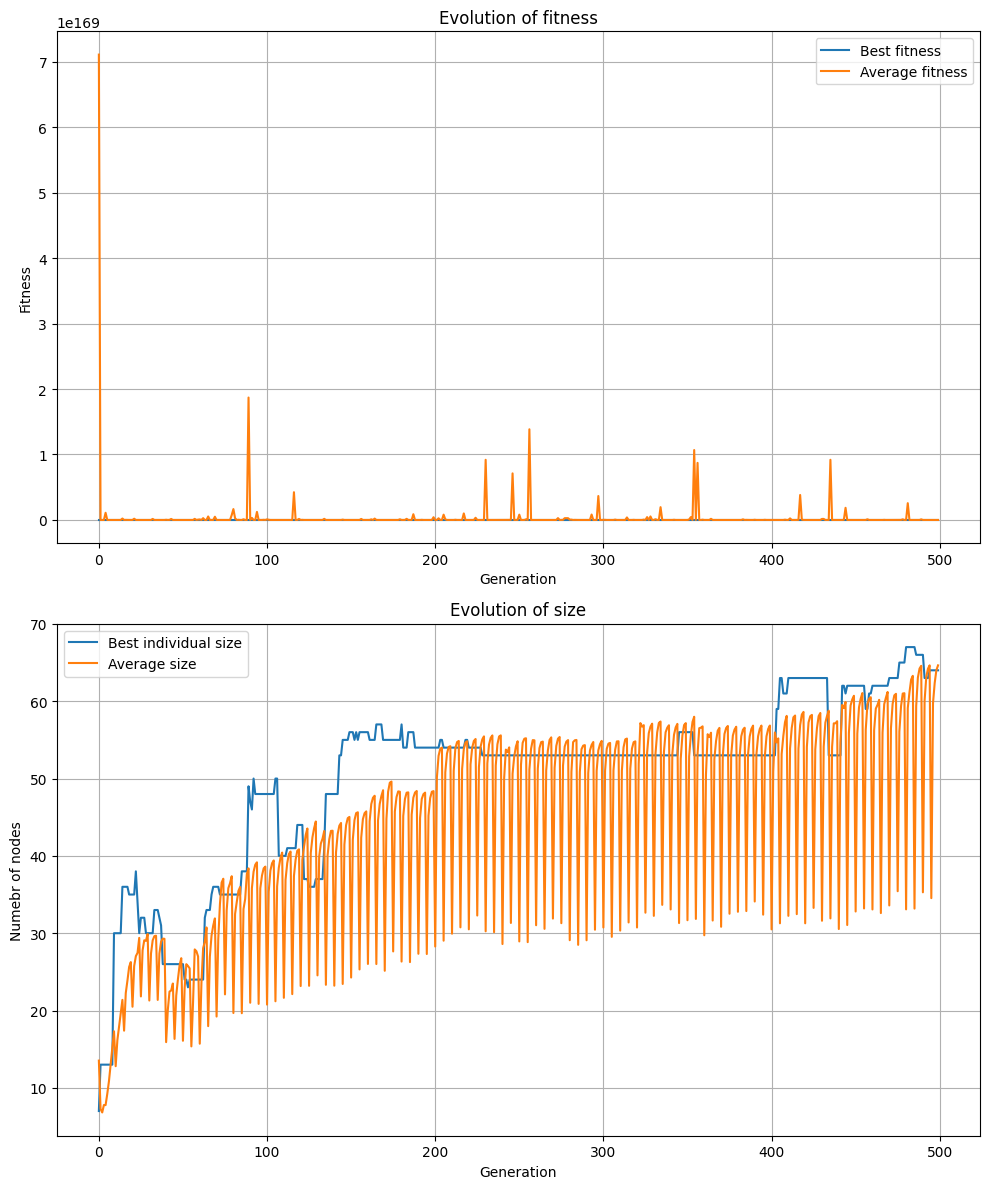

Original expression: ((((x[0] + ((-2.8636943484015354 * cos((x[1] - -1.583968308262229))) * exp(-3.2082386888331254))) + (sin(x[1]) * exp(-3.154932922313467))) + (sin((x[1] + (sqrt(tan(3.141592653589793)) * (3.141592653589793 / exp(-3.2082386888331254))))) * exp(-3.154932922313467))) - sqrt(((sqrt(tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((sin(sin(x[1])) - -1.0439752897500634) + cos((-1.9944929251132986 * (x[1] - 3.1410124598253333))))))))
Simplified expression: x[0] - 2.8636943484015354 * cos(x[1] - -1.583968308262229) * exp(-3.2082386888331254) + (sinx[1] * exp(-3.154932922313467) + (sin(x[1] + (sqrt(tan(3.141592653589793) * (3.141592653589793 / exp(-3.2082386888331254))))) * exp(-3.154932922313467))) - sqrt(sqrt(tan(3.141592653589793) * (-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387) * (x[1] + (x[1] - -1.0329760905609568) - -1.1123733897283157) * (sin

In [283]:
print(f"\n=== GP execution on {problems[0]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[0]['file_path'], 
    problems[0]['config'],
    function_weights=problems[0]['config'].get('function_weights'),
    terminal_weights=problems[0]['config'].get('terminal_weights'),
    use_islands=problems[0].get('use_islands', False),
    n_islands=problems[0].get('n_islands', 5),
    migration_interval=problems[0].get('migration_interval', 10),
    migration_rate=problems[0].get('migration_rate', 0.1),
)



=== GP execution on ../data/problem_1.npz ===
Loading data from ../data/problem_1.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (500, 1), y shape (500,)
Input 1-dimensional with 500 samples

GP execution on ../data/problem_1.npz...
Prima di qualsiasi elaborazione:
X shape: (500, 1), y shape: (500,)
X mean: -0.029408307665472165, y mean: -0.028581340125470176
X std: 0.5552831681956144, y std: 0.5035248258112494
X range: [-0.9830836715674618, 0.9954328739932046], y range: [-0.8322110937504172, 0.8389945887188881]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=100
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated

  0%|          | 0/100 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Bloat control: 213 individuals exceed the maximum size
Bloat control: 242 individuals exceed the maximum size
Bloat control: 159 individuals exceed the maximum size
Bloat control: 257 individuals exceed the maximum size
Bloat control: 163 individuals exceed the maximum size


  1%|          | 1/100 [02:46<4:34:01, 166.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: sin((x[0] + 0.0))
  Simplified Expression: sin(x[0])
  Fitness: 7.125940794232773e-33
  Complexity: 4 nodes
Generation 0, Best Fitness: 7.125940794232773e-33


  5%|▌         | 5/100 [08:16<2:21:59, 89.68s/it] 

Bloat control: 136 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 6/100 [10:50<2:54:59, 111.70s/it]

Generation 5, Best Fitness: 7.125940794232773e-33


 10%|█         | 10/100 [16:21<2:13:29, 88.99s/it]

Bloat control: 57 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 11%|█         | 11/100 [18:54<2:40:56, 108.50s/it]

Generation 10, Best Fitness: 7.125940794232773e-33


 15%|█▌        | 15/100 [24:25<2:06:01, 88.96s/it] 

Bloat control: 82 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 48 individuals exceed the maximum size


 16%|█▌        | 16/100 [27:15<2:38:31, 113.24s/it]

Generation 15, Best Fitness: 7.125940794232773e-33


 20%|██        | 20/100 [32:47<2:00:28, 90.35s/it] 

Bloat control: 73 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 53 individuals exceed the maximum size


 21%|██        | 21/100 [35:20<2:23:35, 109.06s/it]

Generation 20, Best Fitness: 7.125940794232773e-33


 25%|██▌       | 25/100 [40:51<1:51:24, 89.13s/it] 

Bloat control: 39 individuals exceed the maximum size
Bloat control: 29 individuals exceed the maximum size
Bloat control: 27 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 93 individuals exceed the maximum size


 26%|██▌       | 26/100 [43:45<2:21:20, 114.60s/it]

Generation 25, Best Fitness: 7.125940794232773e-33


 30%|███       | 30/100 [49:18<1:45:51, 90.74s/it] 

Bloat control: 49 individuals exceed the maximum size
Bloat control: 52 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 35 individuals exceed the maximum size


 31%|███       | 31/100 [52:08<2:11:32, 114.38s/it]

Generation 30, Best Fitness: 7.125940794232773e-33


 35%|███▌      | 35/100 [57:42<1:38:33, 90.98s/it] 

Bloat control: 96 individuals exceed the maximum size
Bloat control: 117 individuals exceed the maximum size
Bloat control: 74 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 45 individuals exceed the maximum size


 36%|███▌      | 36/100 [1:00:32<2:02:29, 114.83s/it]

Generation 35, Best Fitness: 7.125940794232773e-33


 39%|███▉      | 39/100 [1:04:48<1:36:48, 95.22s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.006
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)


 40%|████      | 40/100 [1:06:12<1:32:04, 92.07s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 157 individuals exceed the maximum size
Bloat control: 96 individuals exceed the maximum size
Bloat control: 60 individuals exceed the maximum size
Bloat control: 21 individuals exceed the maximum size
Bloat control: 47 individuals exceed the maximum size


 41%|████      | 41/100 [1:09:02<1:53:21, 115.28s/it]

Generation 40, Best Fitness: 7.125940794232773e-33


 45%|████▌     | 45/100 [1:14:33<1:22:59, 90.54s/it] 

Bloat control: 74 individuals exceed the maximum size
Bloat control: 27 individuals exceed the maximum size
Bloat control: 69 individuals exceed the maximum size
Bloat control: 27 individuals exceed the maximum size
Bloat control: 67 individuals exceed the maximum size


 46%|████▌     | 46/100 [1:17:24<1:43:19, 114.81s/it]

Generation 45, Best Fitness: 7.125940794232773e-33


 50%|█████     | 50/100 [1:22:57<1:15:41, 90.83s/it] 

Bloat control: 76 individuals exceed the maximum size
Bloat control: 41 individuals exceed the maximum size
Bloat control: 96 individuals exceed the maximum size
Bloat control: 30 individuals exceed the maximum size
Bloat control: 99 individuals exceed the maximum size


 51%|█████     | 51/100 [1:25:51<1:34:34, 115.81s/it]

Generation 50, Best Fitness: 7.125940794232773e-33


 55%|█████▌    | 55/100 [1:31:26<1:08:27, 91.29s/it] 

Bloat control: 75 individuals exceed the maximum size
Bloat control: 35 individuals exceed the maximum size
Bloat control: 79 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 114 individuals exceed the maximum size


 56%|█████▌    | 56/100 [1:34:17<1:24:33, 115.31s/it]

Generation 55, Best Fitness: 7.125940794232773e-33


 60%|██████    | 60/100 [1:39:58<1:01:49, 92.74s/it] 

Bloat control: 96 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 76 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 100 individuals exceed the maximum size


 61%|██████    | 61/100 [1:42:57<1:17:02, 118.52s/it]

Generation 60, Best Fitness: 7.125940794232773e-33


 65%|██████▌   | 65/100 [1:48:35<53:40, 92.02s/it]   

Bloat control: 31 individuals exceed the maximum size
Bloat control: 48 individuals exceed the maximum size
Bloat control: 79 individuals exceed the maximum size
Bloat control: 73 individuals exceed the maximum size
Bloat control: 86 individuals exceed the maximum size


 66%|██████▌   | 66/100 [1:51:22<1:05:00, 114.72s/it]

Generation 65, Best Fitness: 7.125940794232773e-33


 70%|███████   | 70/100 [1:56:50<44:50, 89.67s/it]   

Bloat control: 33 individuals exceed the maximum size
Bloat control: 70 individuals exceed the maximum size
Bloat control: 62 individuals exceed the maximum size
Bloat control: 36 individuals exceed the maximum size
Bloat control: 107 individuals exceed the maximum size


 71%|███████   | 71/100 [1:59:37<54:38, 113.05s/it]

Generation 70, Best Fitness: 7.125940794232773e-33


 75%|███████▌  | 75/100 [2:05:04<37:10, 89.23s/it] 

Bloat control: 66 individuals exceed the maximum size
Bloat control: 64 individuals exceed the maximum size
Bloat control: 168 individuals exceed the maximum size
Bloat control: 30 individuals exceed the maximum size
Bloat control: 52 individuals exceed the maximum size


 76%|███████▌  | 76/100 [2:07:51<45:04, 112.70s/it]

Generation 75, Best Fitness: 7.125940794232773e-33


 79%|███████▉  | 79/100 [2:12:04<33:02, 94.39s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.004
  Island 2 diversity: 0.006
  Island 3 diversity: 0.007
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)


 80%|████████  | 80/100 [2:13:29<30:34, 91.71s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 98 individuals exceed the maximum size
Bloat control: 39 individuals exceed the maximum size
Bloat control: 120 individuals exceed the maximum size
Bloat control: 78 individuals exceed the maximum size
Bloat control: 66 individuals exceed the maximum size


 81%|████████  | 81/100 [2:16:19<36:28, 115.20s/it]

Generation 80, Best Fitness: 7.125940794232773e-33


 85%|████████▌ | 85/100 [2:21:50<22:40, 90.69s/it] 

Bloat control: 92 individuals exceed the maximum size
Bloat control: 44 individuals exceed the maximum size
Bloat control: 61 individuals exceed the maximum size
Bloat control: 49 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size


 86%|████████▌ | 86/100 [2:24:40<26:41, 114.38s/it]

Generation 85, Best Fitness: 7.125940794232773e-33


 90%|█████████ | 90/100 [2:32:16<18:34, 111.48s/it]

Bloat control: 68 individuals exceed the maximum size
Bloat control: 46 individuals exceed the maximum size
Bloat control: 95 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 29 individuals exceed the maximum size


 91%|█████████ | 91/100 [2:35:11<19:37, 130.78s/it]

Generation 90, Best Fitness: 7.125940794232773e-33


 95%|█████████▌| 95/100 [2:41:07<08:24, 100.86s/it]

Bloat control: 75 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 88 individuals exceed the maximum size
Bloat control: 43 individuals exceed the maximum size
Bloat control: 18 individuals exceed the maximum size


 96%|█████████▌| 96/100 [2:44:52<09:12, 138.19s/it]

Generation 95, Best Fitness: 7.125940794232773e-33


100%|██████████| 100/100 [2:50:37<00:00, 102.38s/it]

Generation 99, Best Fitness: 7.125940794232773e-33
Algorithm completed in 10627.55 seconds
Best solution found:
  Simplified Expression: sin(x[0])
  Expression: sin((x[0] + 0.0))
  Fitness: 7.125940794232773e-33
  Complexity: 4 nodes


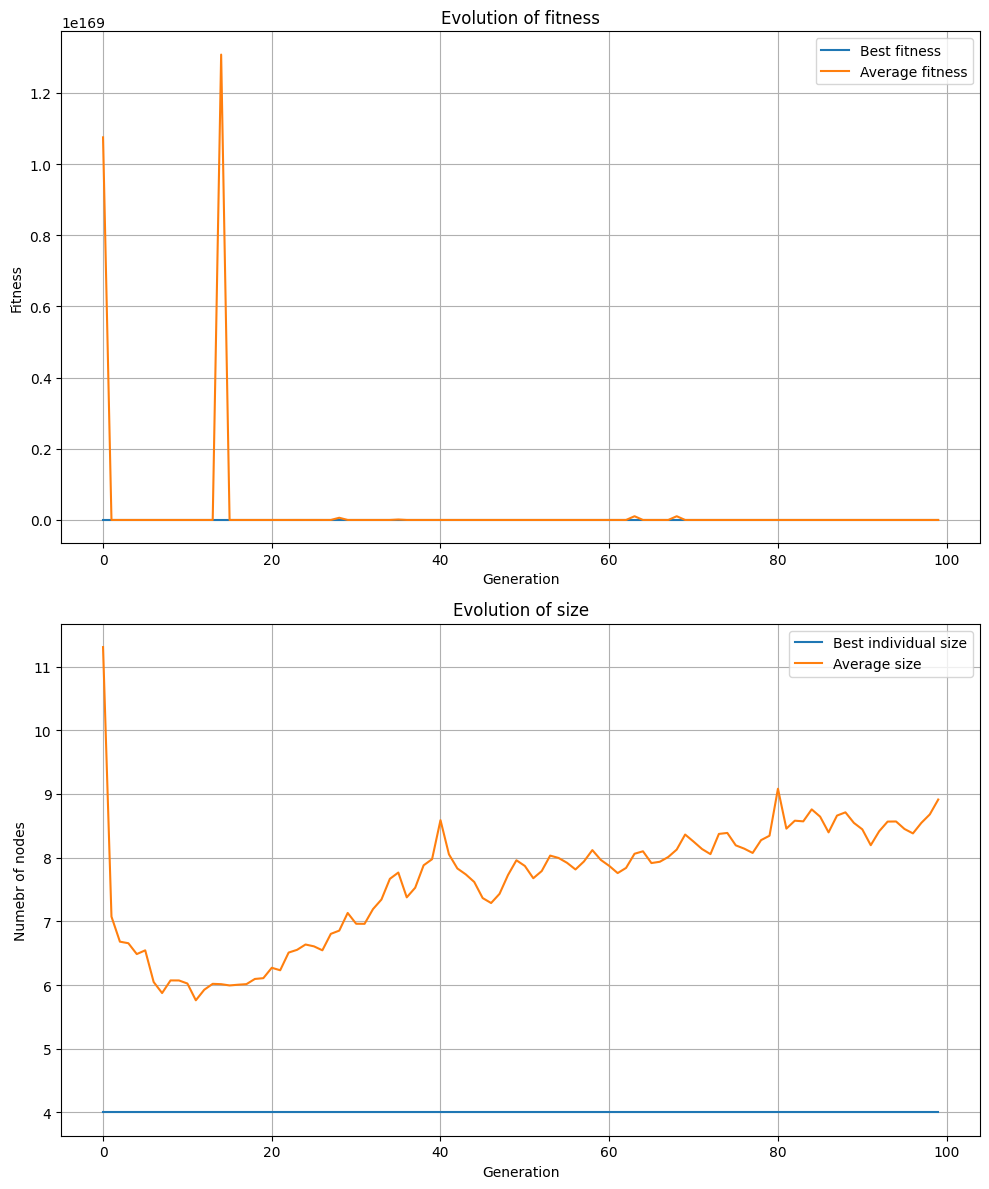

Original expression: sin((x[0] + 0.0))
Simplified expression: sin(x[0])
Best fitness(MSE): 7.125940794232773e-34


In [284]:
print(f"\n=== GP execution on {problems[1]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[1]['file_path'], 
    problems[1]['config'],
    function_weights=problems[1]['config'].get('function_weights'),
    terminal_weights=problems[1]['config'].get('terminal_weights'),
    use_islands=problems[1].get('use_islands', False),
    n_islands=problems[1].get('n_islands', 5),
    migration_interval=problems[1].get('migration_interval', 10),
    migration_rate=problems[1].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_2.npz ===
Loading data from ../data/problem_2.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 3), y shape (5000,)
Input 3-dimensional with 5000 samples
Personalised weight for sin: 0.3
Personalised weight for cos: 0.3
Personalised weight for tan: 0.3
Personalised weight for log: 0.4
Personalised weight for sqrt: 0.4

GP execution on ../data/problem_2.npz...
Prima di qualsiasi elaborazione:
X shape: (5000, 3), y shape: (5000,)
X mean: -0.02934252100385241, y mean: 56465.10655809015
X std: 2.8877772565925297, y std: 5441856.124013525
X range: [-4.999400642356134, 4.998785132288306], y range: [-7643020.544814716, 7643015.666932668]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=30000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 10 islands, migration every 40 generations
Function weights:
  +: 1.00
  -

C:\Users\domen\AppData\Local\Temp\ipykernel_38768\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 29572473755304.18 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 27978679231031.637 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 29542932065904.73 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 29550026684112.24 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 29556815865576.523 | Mutation Strength: 0.90
Island 5 | Generation 0 | Best Fitness: 29585323469666.008 | Mutation Strength: 0.90
Island 6 | Generation 0 | Best Fitness: 29275931422326.555 | Mutation Strength: 0.90
Island 7 | Generation 0 | Best Fitness: 29542032483061.812 | Mutation Strength: 0.90
Island 8 | Generation 0 | Best Fitness: 29588386527004.188 | Mutation Strength: 0.90


C:\Users\domen\AppData\Local\Temp\ipykernel_38768\2301282827.py:30: RuntimeWarning: overflow encountered in square
  return np.mean((output1 - output2) ** 2)


Island 9 | Generation 0 | Best Fitness: 29540483806933.555 | Mutation Strength: 0.90
Bloat control: 293 individuals exceed the maximum size
Bloat control: 286 individuals exceed the maximum size
Bloat control: 244 individuals exceed the maximum size
Bloat control: 217 individuals exceed the maximum size
Bloat control: 292 individuals exceed the maximum size
Bloat control: 250 individuals exceed the maximum size
Bloat control: 243 individuals exceed the maximum size
Bloat control: 254 individuals exceed the maximum size
Bloat control: 298 individuals exceed the maximum size
Bloat control: 364 individuals exceed the maximum size


  0%|          | 1/500 [16:05<133:48:29, 965.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((exp((((2.718281828459045 / x[0]) / (x[0] + 3991442.341592527)) * (tan(x[2]) - tan(x[1])))) - tan(log((sqrt(x[2]) * (x[0] * x[0]))))) - (((cos((x[0] * sqrt(cos(x[2])))) * (sqrt(6025981.090707068) + (x[2] * -364337.714394507))) - sqrt(((x[1] - x[2]) + (x[0] - x[0])))) - sqrt((((x[0] - x[1]) - (x[1] - -3654447.269706693)) + log(cos(x[0]))))))
  Simplified Expression: -(2454.787381975691 - 364337.714394507*x[2])*cos(x[0]*sqrt(cos(x[2]))) + sqrt(x[1] - x[2]) + sqrt(x[0] - 2*x[1] + log(cos(x[0])) - 3654447.269706693) + exp(2.718281828459045*(-tan(x[1]) + tan(x[2]))/(x[0]*(x[0] + 3991442.341592527))) - tan(log(x[0]**2*sqrt(x[2])))
  Fitness: 27978679231031.637
  Complexity: 59 nodes
Generation 0, Best Fitness: 27978679231031.637


  0%|          | 2/500 [24:04<93:56:13, 679.06s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((-3267096.2916354192 - (x[2] + 3.141592653589793)) * cos((exp(x[0]) * sqrt(log((x[1] - (x[2] - exp(x[2]))))))))
  Simplified Expression: (-x[2] - 3267099.4332280728)*cos(exp(x[0])*sqrt(log(x[1] - x[2] + exp(x[2]))))
  Fitness: 25433784090938.203
  Complexity: 18 nodes


  1%|          | 3/500 [32:06<81:19:56, 589.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((-3267096.2916354192 - (x[2] + 3.141592653589793)) * cos((exp(x[0]) * log(((x[0] - exp(x[2])) * x[2])))))
  Simplified Expression: (-x[2] - 3267099.4332280728)*cos(exp(x[0])*log(x[2]*(x[0] - exp(x[2]))))
  Fitness: 25077941234372.645
  Complexity: 17 nodes


  1%|          | 4/500 [40:09<75:24:39, 547.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((x[2] + x[0]) * (x[1] + 868382.7145775454)) + (log(x[0]) * (x[1] * x[2])))
  Simplified Expression: x[1]*x[2]*log(x[0]) + (x[0] + x[2])*(x[1] + 868382.7145775454)
  Fitness: 21875790048526.86
  Complexity: 14 nodes


  1%|          | 5/500 [48:08<71:52:18, 522.70s/it]

Bloat control: 29 individuals exceed the maximum size
Bloat control: 18 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 18 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  1%|▏         | 7/500 [1:11:25<82:06:30, 599.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((cos(log(x[0])) * 1936834.4819240188) * (cos(-1.0) + x[0]))
  Simplified Expression: 1936834.4819240188*(x[0] + 0.54030230586814)*cos(log(x[0]))
  Fitness: 21173532781563.96
  Complexity: 10 nodes


  2%|▏         | 10/500 [1:35:36<70:53:17, 520.81s/it]

Bloat control: 15 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


  2%|▏         | 11/500 [1:48:47<81:59:28, 603.62s/it]

Generation 10, Best Fitness: 21173532781563.96


  2%|▏         | 12/500 [1:56:52<76:56:18, 567.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((x[2] + -1356195.475546169) * x[0]) * sin((exp((((x[0] / x[0]) + (x[1] + x[0])) * (x[2] + x[2]))) + -5047734.784541041)))
  Simplified Expression: x[0]*(x[2] - 1356195.475546169)*sin(exp(2*x[2]*(x[0] + x[1] + 1)) - 5047734.784541041)
  Fitness: 19329822703121.953
  Complexity: 21 nodes


  3%|▎         | 15/500 [2:21:16<69:22:18, 514.92s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  4%|▍         | 19/500 [2:58:11<68:56:28, 515.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((exp(log(-339703.44818050927)) * x[1]) - (((-364337.714394507 + 1483985.6439143) * (x[0] + (x[0] + x[2]))) * (-2981157.4898816785 / (exp((tan(-3654447.269706693) + ((x[0] + x[2]) * x[0]))) - -6476959.681381762))))
  Simplified Expression: -339703.44818050927*x[1] + 2981157.4898816785*(2239295.85903959*x[0] + 1119647.92951979*x[2])/(4.169352652342435*exp(x[0]*(x[0] + x[2])) + 6476959.681381762)
  Fitness: 17702481652611.594
  Complexity: 29 nodes


  4%|▍         | 20/500 [3:06:58<69:13:05, 519.14s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  4%|▍         | 21/500 [3:20:44<81:19:07, 611.16s/it]

Generation 20, Best Fitness: 17702481652611.594


  5%|▌         | 25/500 [3:53:44<68:32:37, 519.49s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 17 individuals exceed the maximum size


  6%|▌         | 28/500 [4:21:08<68:56:52, 525.87s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((1740071.1240361007 + (-5617800.742518813 * (x[2] + x[0]))) * ((-1356195.475546169 - ((x[0] - (sqrt(5276954.008873343) * (exp(x[1]) * (x[1] + x[2])))) - (sqrt(((7508409.666010489 + -3096338.9650774663) - x[1])) * (((x[0] * x[0]) * (x[1] + x[2])) * (x[2] + x[0]))))) / (-1256627.503927664 + (6781736.83718665 - (sqrt(1740071.1240361007) - x[1])))))
  Simplified Expression: (-5617800.742518813*x[0] - 5617800.742518813*x[2] + 1740071.1240361007)*(x[0]**2*sqrt(4412070.7009330227 - x[1])*(x[0] + x[2])*(x[1] + x[2]) - x[0] + 2297.162164252525*(x[1] + x[2])*exp(x[1]) - 1356195.475546169)/(x[1] + 5523790.2157039383)
  Fitness: 17195648190167.111
  Complexity: 49 nodes


  6%|▌         | 30/500 [4:34:09<59:14:26, 453.76s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size


  6%|▌         | 31/500 [4:42:09<60:09:54, 461.82s/it]

Generation 30, Best Fitness: 17195648190167.111


  7%|▋         | 35/500 [5:18:17<68:25:24, 529.73s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 67 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  7%|▋         | 36/500 [5:30:26<75:58:46, 589.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((exp(tan(tan(-3654447.269706693))) * (((x[1] + x[2]) * x[0]) + ((x[1] + x[2]) * x[0]))) - (((exp(log(-339703.44818050927)) + (exp(log(-339703.44818050927)) + 1483985.6439143)) * (x[0] + (x[0] + (x[1] + x[2])))) * (-3228358.130706656 / (exp((tan(tan(-3654447.269706693)) + ((x[0] + x[2]) * x[0]))) - -6476959.681381762))))
  Simplified Expression: 2072.835674097532*x[0]*(x[1] + x[2]) + 3228358.130706656*(1609157.495106563*x[0] + 804578.74755328148*x[1] + 804578.74755328148*x[2])/(1036.417837048766*exp(x[0]*(x[0] + x[2])) + 6476959.681381762)
  Fitness: 12082504101731.43
  Complexity: 49 nodes


  8%|▊         | 39/500 [5:48:17<55:50:21, 436.06s/it]

Performing inter-island migration...
  Island 0 diversity: 0.151
  Island 1 diversity: 0.087
  Island 2 diversity: 0.226
  Island 3 diversity: 0.191
  Island 4 diversity: 0.098
  Island 5 diversity: 0.047
  Island 6 diversity: 0.294
  Island 7 diversity: 0.167
  Island 8 diversity: 0.134
  Island 9 diversity: 0.226
  Migration: 600 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.42)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.74)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 600 individuals from island 8 

  8%|▊         | 40/500 [5:55:14<55:00:57, 430.56s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1173 individuals exceed the maximum size
Bloat control: 988 individuals exceed the maximum size
Bloat control: 483 individuals exceed the maximum size
Bloat control: 32 individuals exceed the maximum size
Bloat control: 2401 individuals exceed the maximum size
Bloat control: 1597 individuals exceed the maximum size
Bloat control: 498 individuals exceed the maximum size
Bloat control: 17 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


  8%|▊         | 41/500 [6:10:53<74:20:03, 583.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((exp(tan(tan(-3654447.269706693))) * (((x[1] + x[2]) * x[0]) + ((x[2] - (exp(x[0]) - cos(x[2]))) * (tan(tan(-3654447.269706693)) + ((x[1] + x[2]) * x[0]))))) - (((exp(log(-339703.44818050927)) + (exp(log(-339703.44818050927)) + 1483985.6439143)) * (x[0] + (x[0] + (x[1] + x[2])))) * (-3228358.130706656 / (exp((tan(tan(-3654447.269706693)) + ((x[0] + x[2]) * x[0]))) - -6476959.681381762))))
  Simplified Expression: 1036.417837048766*x[0]*(x[1] + x[2]) + 1036.417837048766*(x[0]*(x[1] + x[2]) + 6.94352565912338)*(x[2] - exp(x[0]) + cos(x[2])) + 3228358.130706656*(1609157.495106563*x[0] + 804578.74755328148*x[1] + 804578.74755328148*x[2])/(1036.417837048766*exp(x[0]*(x[0] + x[2])) + 6476959.681381762)
  Fitness: 12023602964034.158
  Complexity: 61 nodes
Generation 40, Best Fitness: 12023602964034.158


  9%|▉         | 45/500 [6:37:26<54:11:53, 428.82s/it]

Bloat control: 1262 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size
Bloat control: 307 individuals exceed the maximum size
Bloat control: 376 individuals exceed the maximum size
Bloat control: 2722 individuals exceed the maximum size
Bloat control: 2709 individuals exceed the maximum size
Bloat control: 2718 individuals exceed the maximum size
Bloat control: 200 individuals exceed the maximum size
Bloat control: 71 individuals exceed the maximum size


  9%|▉         | 47/500 [6:59:00<66:20:21, 527.20s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((x[1] + (sqrt(x[0]) - ((x[1] + (x[0] + x[0])) + x[0]))) * (exp(tan(tan(-3654447.269706693))) * (((x[1] + x[2]) * (x[0] + (x[0] + (x[1] + x[2])))) + ((x[1] + (x[1] + (x[0] + x[0]))) * x[0])))) - (((exp(log(-339703.44818050927)) + (exp(log(-339703.44818050927)) + 1483985.6439143)) * (x[0] + (x[0] + (x[1] + x[2])))) * (-3228358.130706656 / (exp((tan(tan(1483985.6439143)) + ((x[0] + x[2]) * x[0]))) - -6476959.681381762))))
  Simplified Expression: (sqrt(x[0]) - 3*x[0])*(1036.417837048766*x[0]*(2*x[0] + 2*x[1]) + 1036.417837048766*(x[1] + x[2])*(2*x[0] + x[1] + x[2])) + 3228358.130706656*(1609157.495106563*x[0] + 804578.74755328148*x[1] + 804578.74755328148*x[2])/(232.604890556445*exp(x[0]*(x[0] + x[2])) + 6476959.681381762)
  Fitness: 11070779263531.91
  Complexity: 72 nodes


 10%|█         | 50/500 [7:18:31<54:33:43, 436.50s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2914 individuals exceed the maximum size
Bloat control: 44 individuals exceed the maximum size
Bloat control: 1845 individuals exceed the maximum size
Bloat control: 105 individuals exceed the maximum size
Bloat control: 2842 individuals exceed the maximum size
Bloat control: 2847 individuals exceed the maximum size
Bloat control: 2907 individuals exceed the maximum size
Bloat control: 1325 individuals exceed the maximum size
Bloat control: 223 individuals exceed the maximum size


 10%|█         | 51/500 [7:31:47<67:53:34, 544.35s/it]

Generation 50, Best Fitness: 11070779263531.91


 11%|█         | 54/500 [7:55:05<61:18:06, 494.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[1] + x[1]) + (sqrt(x[1]) - (((x[0] + x[0]) + x[0]) + x[0]))) * (exp(tan(tan(-3654447.269706693))) * (((x[1] + (x[0] / x[1])) * x[0]) + (((x[1] + (x[0] + x[2])) + x[2]) * ((x[0] + x[1]) + (x[0] + x[1])))))) - (((exp(log(-339703.44818050927)) + (exp(log(-339703.44818050927)) + 1483985.6439143)) * (x[0] + (x[0] + (x[1] + x[2])))) * (-3228358.130706656 / (exp((tan(tan(-3654447.269706693)) + ((x[1] + x[2]) * x[0]))) - -6476959.681381762))))
  Simplified Expression: (1036.417837048766*x[0]*(x[0]/x[1] + x[1]) + 1036.417837048766*(2*x[0] + 2*x[1])*(x[0] + x[1] + 2*x[2]))*(-4*x[0] + sqrt(x[1]) + 2*x[1]) + 3228358.130706656*(1609157.495106563*x[0] + 804578.74755328148*x[1] + 804578.74755328148*x[2])/(1036.417837048766*exp(x[0]*(x[1] + x[2])) + 6476959.681381762)
  Fitness: 9128641741107.217
  Complexity: 76 nodes


 11%|█         | 55/500 [8:01:34<57:12:55, 462.87s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((x[1] + (sqrt(x[1]) - (((x[0] + x[0]) + x[0]) + x[0]))) * (exp(tan(tan(-3654447.269706693))) * ((((x[0] + (x[2] / x[1])) * ((x[1] + x[0]) / 0.0)) * x[0]) + (((x[1] + (x[0] + x[2])) + x[2]) * ((x[0] + x[1]) + (x[0] + x[1])))))) - (((exp(log(-339703.44818050927)) + (exp(log(-339703.44818050927)) + 1483985.6439143)) * (x[0] + (x[0] + (x[1] + x[2])))) * (-3228358.130706656 / (exp((tan(tan(1483985.6439143)) + ((x[1] + x[2]) * x[0]))) - -6476959.681381762))))
  Simplified Expression: inf) * x[0]) + (x[1] + (x[0] + x[2]) + x[2]) * (x[0] + x[1]) + (x[0] + x[1])))) - (exp(log(-339703.44818050927) + (exp(log(-339703.44818050927) + 1483985.6439143)) * (x[0] + (x[0] + (x[1] + x[2])))) * (-3228358.130706656 / (exp(tan(tan(1483985.6439143) + (x[1] + x[2]) * x[0])) - -6476959.681381762))))
  Fitness: 6859878174869.351
  Complexity: 80 nodes
Bloat control: 7 individuals exceed the maximum size
Bloat control: 2997 individuals 

 12%|█▏        | 60/500 [8:54:44<68:04:29, 556.98s/it]

Bloat control: 1525 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2993 individuals exceed the maximum size
Bloat control: 2889 individuals exceed the maximum size
Bloat control: 2943 individuals exceed the maximum size
Bloat control: 2934 individuals exceed the maximum size
Bloat control: 2968 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 555 individuals exceed the maximum size


 12%|█▏        | 61/500 [9:10:45<82:43:24, 678.37s/it]

Generation 60, Best Fitness: 6859878174869.351


 13%|█▎        | 65/500 [9:51:07<74:16:51, 614.74s/it]

Bloat control: 2738 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2993 individuals exceed the maximum size
Bloat control: 2962 individuals exceed the maximum size
Bloat control: 2955 individuals exceed the maximum size
Bloat control: 2965 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 14%|█▍        | 70/500 [10:38:13<59:56:06, 501.78s/it]

Bloat control: 2871 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 82 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2978 individuals exceed the maximum size
Bloat control: 2953 individuals exceed the maximum size
Bloat control: 2945 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 14%|█▍        | 71/500 [10:51:53<71:10:47, 597.31s/it]

Generation 70, Best Fitness: 6859878174869.351


 15%|█▌        | 75/500 [11:18:22<52:29:26, 444.63s/it]

Bloat control: 2940 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2850 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2991 individuals exceed the maximum size
Bloat control: 2929 individuals exceed the maximum size
Bloat control: 2965 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 16%|█▌        | 79/500 [11:51:41<52:37:11, 449.96s/it]

Performing inter-island migration...
  Island 0 diversity: 0.023
  Island 1 diversity: 0.007
  Island 2 diversity: 0.016
  Island 3 diversity: 0.006
  Island 4 diversity: 0.004
  Island 5 diversity: 0.004
  Island 6 diversity: 0.052
  Island 7 diversity: 0.020
  Island 8 diversity: 0.015
  Island 9 diversity: 0.007
  Migration: 600 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.15)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 600 individuals from island 8 

 16%|█▌        | 80/500 [11:58:43<51:31:00, 441.57s/it]

Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2987 individuals exceed the maximum size
Bloat control: 2971 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2993 individuals exceed the maximum size
Bloat control: 2990 individuals exceed the maximum size
Bloat control: 2556 individuals exceed the maximum size
Bloat control: 2974 individuals exceed the maximum size


 16%|█▌        | 81/500 [12:11:18<62:20:15, 535.60s/it]

Generation 80, Best Fitness: 6859878174869.351


 17%|█▋        | 85/500 [12:37:14<48:53:10, 424.07s/it]

Bloat control: 2993 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2967 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 622 individuals exceed the maximum size
Bloat control: 2665 individuals exceed the maximum size
Bloat control: 2992 individuals exceed the maximum size


 18%|█▊        | 90/500 [13:15:51<47:55:12, 420.76s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2873 individuals exceed the maximum size
Bloat control: 2994 individuals exceed the maximum size
Bloat control: 2876 individuals exceed the maximum size
Bloat control: 2950 individuals exceed the maximum size
Bloat control: 2994 individuals exceed the maximum size


 18%|█▊        | 91/500 [13:28:27<59:13:14, 521.26s/it]

Generation 90, Best Fitness: 6859878174869.351


 19%|█▉        | 95/500 [13:54:12<47:06:53, 418.80s/it]

Bloat control: 2992 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2978 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2953 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 20%|██        | 100/500 [14:32:25<46:28:39, 418.30s/it]

Island 0 | Generation 100 | Best Fitness: 7351315213228.859 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 12920236479284.877 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 11374101807334.303 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 7174736414764.308 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 12868987660348.377 | Mutation Strength: 3.00
Island 5 | Generation 100 | Best Fitness: 9174481734133.229 | Mutation Strength: 3.00
Island 6 | Generation 100 | Best Fitness: 11070779263531.91 | Mutation Strength: 3.00
Island 7 | Generation 100 | Best Fitness: 6859878174869.351 | Mutation Strength: 3.00
Island 8 | Generation 100 | Best Fitness: 12619316889907.389 | Mutation Strength: 3.00
Island 9 | Generation 100 | Best Fitness: 7684810540269.592 | Mutation Strength: 2.67
Bloat control: 2985 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 indi

 20%|██        | 101/500 [14:45:00<57:32:35, 519.19s/it]

Generation 100, Best Fitness: 6859878174869.351


 21%|██        | 105/500 [15:10:43<45:52:21, 418.08s/it]

Bloat control: 2986 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 290 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 22%|██▏       | 110/500 [15:49:14<45:22:34, 418.86s/it]

Bloat control: 2980 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 86 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 22%|██▏       | 111/500 [16:02:08<56:45:11, 525.22s/it]

Generation 110, Best Fitness: 6859878174869.351


 23%|██▎       | 115/500 [16:27:55<44:58:52, 420.60s/it]

Bloat control: 2979 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2926 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 24%|██▍       | 119/500 [16:59:46<45:42:57, 431.96s/it]

Performing inter-island migration...
  Island 0 diversity: 0.008
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.011
  Island 4 diversity: 0.005
  Island 5 diversity: 0.005
  Island 6 diversity: 0.006
  Island 7 diversity: 0.004
  Island 8 diversity: 0.007
  Island 9 diversity: 0.007
  Migration: 600 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 1.01)
  Migration: 600 individuals from island 8 

 24%|██▍       | 120/500 [17:06:33<44:48:17, 424.47s/it]

Bloat control: 2992 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2992 individuals exceed the maximum size
Bloat control: 2993 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2992 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2994 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 24%|██▍       | 121/500 [17:19:14<55:20:01, 525.60s/it]

Generation 120, Best Fitness: 6859878174869.351


 25%|██▍       | 123/500 [17:32:13<47:47:07, 456.31s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1388462.8092761522 - ((x[0] - ((sqrt(7251966.911394685) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3096338.9650774663) * ((log(1740071.1240361007) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1388462.8092761522 - (x[0] - (sqrt(7251966.911394685) + sqrt(7718549.190507253) * (x[0] + x[0]) * (

 25%|██▍       | 124/500 [17:38:46<45:40:21, 437.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1388462.8092761522 - ((x[0] - ((sqrt(7251966.911394685) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3096338.9650774663) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1388462.8092761522 - (x[0] - (sqrt(7251966.911394685) + sqrt(7718549.190507253) * (x[0] + x[0]) * (x

 25%|██▌       | 125/500 [17:45:20<44:12:15, 424.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1388462.8092761522 - ((x[0] - ((sqrt(7251966.911394685) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3096338.9650774663) * ((log(7718549.190507253) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1388462.8092761522 - (x[0] - (sqrt(7251966.911394685) + sqrt(7718549.190507253) * (x[0] + x[0]) * (x

 25%|██▌       | 126/500 [17:58:29<55:27:52, 533.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1388462.8092761522 - ((x[0] - ((sqrt(7718549.190507253) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3096338.9650774663) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1388462.8092761522 - (x[0] - (sqrt(7718549.190507253) + sqrt(7718549.190507253) * (x[0] + x[0]) * (x

 25%|██▌       | 127/500 [18:05:05<51:00:22, 492.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin(((-3128418.984814505 * log(tan(-3096338.9650774663))) - ((exp(tan(-3096338.9650774663)) - ((sqrt(-6776698.557456572) + x[0]) * ((x[0] + x[0]) * x[0]))) - (sqrt(-3096338.9650774663) * ((log(-6776698.557456572) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-3128418.984814505 * log(tan(-3096338.9650774663) - (exp(tan(-3096338

 26%|██▌       | 129/500 [18:18:33<46:08:22, 447.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin(((-3128418.984814505 * log(tan(-3096338.9650774663))) - ((exp(tan(-3096338.9650774663)) - ((sqrt(-3096338.9650774663) + x[0]) * ((x[0] + x[0]) * x[0]))) - (sqrt(-3096338.9650774663) * ((log(-6776698.557456572) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-3128418.984814505 * log(tan(-3096338.9650774663) - (exp(tan(-309633

 26%|██▌       | 130/500 [18:25:13<44:33:03, 433.47s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2982 individuals exceed the maximum size
Bloat control: 2966 individuals exceed the maximum size
Bloat control: 2994 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2494 individuals exceed the maximum size
Bloat control: 2987 individuals exceed the maximum size
Bloat control: 2962 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 26%|██▌       | 131/500 [18:38:01<54:41:38, 533.60s/it]

Generation 130, Best Fitness: 4407385469930.673


 26%|██▋       | 132/500 [18:44:34<50:15:00, 491.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin(((-3128418.984814505 * log(tan(-3096338.9650774663))) - ((exp(x[2]) - ((sqrt(-3096338.9650774663) + x[0]) * ((x[0] + x[0]) * x[0]))) - ((sqrt(-3096338.9650774663) + x[0]) * ((log(-6776698.557456572) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-3128418.984814505 * log(tan(-3096338.9650774663) - (expx[2] - (sqrt(-3096338.9

 27%|██▋       | 133/500 [18:51:13<47:16:00, 463.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin(((-3128418.984814505 * log(tan(-3096338.9650774663))) - ((exp(x[0]) - ((sqrt(-3096338.9650774663) + x[0]) * ((x[0] + x[0]) * x[0]))) - ((sqrt(-3096338.9650774663) + x[0]) * ((log(-6776698.557456572) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-3128418.984814505 * log(tan(-3096338.9650774663) - (expx[0] - (sqrt(-3096338.9

 27%|██▋       | 134/500 [18:57:55<45:15:28, 445.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - ((x[2] - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[2] - (sqrt(-3096338.9650774663) + sqrt(7718549.190507253) * (x[0] + x[0]) * 

 27%|██▋       | 135/500 [19:04:34<43:44:06, 431.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((x[0] + x[0]) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[0] + x[0]) - (sqrt(-3096338.9650774663) + sqrt(7718549.190507253) *

 27%|██▋       | 136/500 [19:17:24<53:54:22, 533.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((x[2] + x[0]) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[2] + x[0]) - (sqrt(-3096338.9650774663) + sqrt(7718549.190507253) *

 28%|██▊       | 139/500 [19:39:18<47:23:34, 472.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - ((log(x[1]) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (logx[1] - (sqrt(-3096338.9650774663) + sqrt(7718549.190507253) * (x[0] + 

 28%|██▊       | 140/500 [19:46:17<45:38:31, 456.42s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((x[2] + ((x[1] * x[1]) - 2.718281828459045)) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[2] + (x[1] * x[1]) - 2.7182818284590

 28%|██▊       | 141/500 [20:02:55<61:43:19, 618.94s/it]

Generation 140, Best Fitness: 4257368439131.634


 29%|██▊       | 143/500 [20:21:33<58:24:51, 589.05s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((x[2] + (x[1] - sqrt(-3272060.4581361106))) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[2] + (x[1] - sqrt(-3272060.4581361106

 29%|██▉       | 145/500 [20:40:07<56:22:58, 571.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((x[1] + (x[1] - sqrt(-3272060.4581361106))) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[1] + (x[1] - sqrt(-3272060.4581361106

 29%|██▉       | 147/500 [21:11:33<71:15:29, 726.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((((x[1] * x[1]) + (x[1] + x[0])) + (x[1] - sqrt(-3272060.4581361106))) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[1] * x[1])

 30%|███       | 150/500 [21:41:08<61:45:19, 635.20s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2976 individuals exceed the maximum size
Bloat control: 2891 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 30%|███       | 151/500 [22:02:27<80:18:00, 828.31s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1296044.550665495 - (((((x[1] * x[1]) + (x[1] + x[0])) + ((x[1] * x[1]) - sqrt(-3272060.4581361106))) - ((sqrt(-3096338.9650774663) + sqrt(7718549.190507253)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1296044.550665495 - (x[1

 31%|███       | 155/500 [22:39:31<59:31:36, 621.15s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2981 individuals exceed the maximum size
Bloat control: 2973 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 32%|███▏      | 158/500 [23:15:24<60:49:47, 640.31s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((((x[1] * x[1]) + (x[1] + x[1])) + (x[1] - x[0])) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - (x[1] * x[1]) + (x[1] + x[1]) 

 32%|███▏      | 159/500 [23:25:07<59:01:06, 623.07s/it]

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.004
  Island 2 diversity: 0.006
  Island 3 diversity: 0.005
  Island 4 diversity: 0.004
  Island 5 diversity: 0.003
  Island 6 diversity: 0.007
  Island 7 diversity: 0.006
  Island 8 diversity: 0.006
  Island 9 diversity: 0.005
  Migration: 600 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.01)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 600 individuals from island 8 

 32%|███▏      | 160/500 [23:35:22<58:37:18, 620.70s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3193124.616199098 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((((x[1] * x[1]) + (x[1] + x[1])) + (x[1] - x[0])) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3193124.616199098 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - (x[1] * x[1]) + (x[1] + x[1]) 

 32%|███▏      | 161/500 [23:57:28<78:22:51, 832.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3191895.052840614 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((((x[1] * x[1]) + (x[1] + x[1])) + (x[1] - x[0])) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3191895.052840614 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - (x[1] * x[1]) + (x[1] + x[1]) 

 33%|███▎      | 165/500 [24:35:41<59:05:39, 635.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3193124.616199098 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((x[1] * x[2]) - ((sqrt(-3096338.9650774663) + sqrt(-3128418.984814505)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3193124.616199098 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - (x[1] * x[2]) - (sqrt(-3096338.9650774663) + sqrt(-3128418.98481450

 34%|███▍      | 169/500 [25:26:01<60:56:04, 662.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3193124.616199098 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - ((((x[1] + x[0]) + ((x[1] + x[0]) - x[0])) - ((sqrt(-3128418.984814505) + sqrt(-3128418.984814505)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3193124.616199098 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - (x[1] + x[0]) + (x[1] + x[0]) - x[0]) - (

 34%|███▍      | 170/500 [25:35:29<58:07:49, 634.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan((-1071172.441409888 + -1667888.905645238)))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan((-1071172.441409888 + -1667888.905645238))))))) * sin(((-3128418.984814505 * log(tan(-3096338.9650774663))) - (((((x[1] + x[2]) + x[1]) * exp(x[0])) - ((sqrt(-3096338.9650774663) + x[0]) * ((x[0] + x[0]) * x[0]))) - ((sqrt(-3096338.9650774663) + log(-3096338.9650774663)) * ((log(-6776698.557456572) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-1071172.441409888 + -1667888.905645238) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan

 34%|███▍      | 171/500 [25:56:42<75:27:43, 825.73s/it]

Generation 170, Best Fitness: 4188061620276.9844


 34%|███▍      | 172/500 [26:06:07<68:06:14, 747.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3219094.793156652)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((x[2] + 0.0) - ((sqrt(-3134037.591236865) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3219094.793156652)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - x[2] - (sqrt(-3134037.591236865) + sqrt(-3096338.9650774663) * (x[0] +

 35%|███▍      | 173/500 [26:16:19<64:13:45, 707.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3128418.984814505 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3219094.793156652)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((x[2] + sin((7618514.623223585 + 1.0))) - ((sqrt(-3134037.591236865) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3128418.984814505 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3219094.793156652)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - (x[2] + sin(7618514.623223585 + 1.0) - (sqr

 35%|███▍      | 174/500 [26:27:51<63:36:17, 702.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3134037.591236865 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3096338.9650774663)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3219094.793156652)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((x[0] + 0.0) - ((sqrt(-3134037.591236865) + sqrt(-3134037.591236865)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3134037.591236865 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3096338.9650774663) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3219094.793156652)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - x[0] - (sqrt(-3134037.591236865) + sqrt(-3134037.591236865) * (x[0] + x

 35%|███▌      | 175/500 [26:38:25<61:33:45, 681.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((-3134037.591236865 * log(tan(-3096338.9650774663))) + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-3219094.793156652)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3219094.793156652)))) + (((x[2] + x[0]) + (x[1] + x[0])) * exp(tan(-3096338.9650774663)))))) * sin((-1230797.8088492597 - (((x[0] + 0.0) - ((sqrt(-3134037.591236865) + sqrt(-3134037.591236865)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -3134037.591236865 * log(tan(-3096338.9650774663) + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-3219094.793156652) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3219094.793156652)) + (x[2] + x[0]) + (x[1] + x[0]) * exp(tan(-3096338.9650774663))))) * sin(-1230797.8088492597 - x[0] - (sqrt(-3134037.591236865) + sqrt(-3134037.591236865) * (x[0] + x[0

 36%|███▌      | 180/500 [27:25:55<46:37:24, 524.51s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 36%|███▌      | 181/500 [27:42:32<59:01:26, 666.10s/it]

Generation 180, Best Fitness: 3627378363497.785


 37%|███▋      | 185/500 [28:13:59<45:19:45, 518.05s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 38%|███▊      | 190/500 [28:59:57<43:01:48, 499.71s/it]

Bloat control: 2996 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 38%|███▊      | 191/500 [29:17:19<56:51:49, 662.49s/it]

Generation 190, Best Fitness: 3627378363497.785


 39%|███▉      | 195/500 [29:48:38<44:56:36, 530.48s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 40%|███▉      | 199/500 [30:30:55<44:24:42, 531.17s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.007
  Island 2 diversity: 0.009
  Island 3 diversity: 0.005
  Island 4 diversity: 0.003
  Island 5 diversity: 0.005
  Island 6 diversity: 0.005
  Island 7 diversity: 0.006
  Island 8 diversity: 0.007
  Island 9 diversity: 0.004
  Migration: 600 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 600 individuals from island 8 

 40%|████      | 200/500 [30:38:09<41:50:27, 502.09s/it]

Island 0 | Generation 200 | Best Fitness: 4007566530926.7573 | Mutation Strength: 2.70
Island 1 | Generation 200 | Best Fitness: 4193298399271.1377 | Mutation Strength: 2.70
Island 2 | Generation 200 | Best Fitness: 3132240024627.497 | Mutation Strength: 2.70
Island 3 | Generation 200 | Best Fitness: 4193298399271.1377 | Mutation Strength: 2.70
Island 4 | Generation 200 | Best Fitness: 4193298399271.1377 | Mutation Strength: 2.67
Island 5 | Generation 200 | Best Fitness: 4193298399271.1377 | Mutation Strength: 2.70
Island 6 | Generation 200 | Best Fitness: 4189411763690.037 | Mutation Strength: 2.70
Island 7 | Generation 200 | Best Fitness: 3627378363497.785 | Mutation Strength: 3.00
Island 8 | Generation 200 | Best Fitness: 4045005509419.805 | Mutation Strength: 2.70
Island 9 | Generation 200 | Best Fitness: 4007566530926.7573 | Mutation Strength: 3.00
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2616 individuals exceed the maximum size
Bloat control: 2622 in

 40%|████      | 201/500 [30:51:19<48:52:04, 588.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1296893.0830965708 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4352328.554022802))))))) * sin((-1230797.8088492597 - ((((x[2] + x[0]) + (x[2] - sqrt(-3096338.9650774663))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1296893.0830965708 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4352328.554022802))))) * sin(-1230797.8088492597 - (x[2] + x[0]) + (x[2] - sqrt(-3096338.9650774663) - (

 41%|████      | 205/500 [31:19:26<38:04:15, 464.59s/it]

Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 42%|████▏     | 210/500 [31:59:23<35:26:12, 439.91s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 42%|████▏     | 211/500 [32:12:15<43:19:31, 539.69s/it]

Generation 210, Best Fitness: 3132240024627.497


 43%|████▎     | 215/500 [32:39:06<34:32:33, 436.33s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 44%|████▍     | 220/500 [33:18:52<33:48:53, 434.76s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 44%|████▍     | 221/500 [33:31:48<41:37:54, 537.19s/it]

Generation 220, Best Fitness: 3132240024627.497


 45%|████▌     | 225/500 [33:58:38<33:15:39, 435.42s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 46%|████▌     | 230/500 [34:38:17<32:31:31, 433.67s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 46%|████▌     | 231/500 [34:51:21<40:16:02, 538.89s/it]

Generation 230, Best Fitness: 3132240024627.497


 47%|████▋     | 235/500 [35:17:58<31:50:28, 432.56s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 48%|████▊     | 239/500 [35:52:56<34:52:09, 480.96s/it]

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.006
  Island 2 diversity: 0.004
  Island 3 diversity: 0.008
  Island 4 diversity: 0.006
  Island 5 diversity: 0.005
  Island 6 diversity: 0.006
  Island 7 diversity: 0.005
  Island 8 diversity: 0.003
  Island 9 diversity: 0.006
  Migration: 600 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 600 individuals from island 8 

 48%|████▊     | 240/500 [36:00:01<33:32:22, 464.40s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 48%|████▊     | 241/500 [36:12:56<40:06:21, 557.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4391358.629144093 / -4347399.182807316))))))) * sin((-1230797.8088492597 - (((x[2] + ((x[2] + x[0]) - sqrt(-3096338.9650774663))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4391358.629144093 / -4347399.182807316))))) * sin(-1230797.8088492597 - (x[2] + (x[2] + x[0]) - sqrt(-3096338.9650774663) - (sq

 49%|████▉     | 245/500 [36:39:44<31:06:52, 439.26s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 50%|█████     | 250/500 [37:19:15<30:09:54, 434.38s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 50%|█████     | 251/500 [37:32:13<37:09:56, 537.33s/it]

Generation 250, Best Fitness: 3130646762646.968


 50%|█████     | 252/500 [37:38:51<34:08:27, 495.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4347399.182807316))))))) * sin((-1230797.8088492597 - ((((x[0] * (x[0] + x[0])) + ((x[2] + x[0]) - sqrt(-3096338.9650774663))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4347399.182807316))))) * sin(-1230797.8088492597 - (x[0] * (x[0] + x[0]) + (x[2] + x[0])

 51%|█████     | 255/500 [37:59:00<29:34:39, 434.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4347399.182807316))))))) * sin((-1230797.8088492597 - (((((x[0] + x[0]) * x[0]) + ((x[2] + x[0]) - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4347399.182807316))))) * sin(-1230797.8088492597 - (x[0] + x[0]) * x[0]) + (x[2] + x[0])

 51%|█████     | 256/500 [38:11:58<36:26:57, 537.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4388425.992122508 / -4347399.182807316))))))) * sin((-1230797.8088492597 - (((x[2] + (x[2] - sqrt(-3051212.431859093))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4388425.992122508 / -4347399.182807316))))) * sin(-1230797.8088492597 - (x[2] + (x[2] - sqrt(-3051212.431859093) - (sqrt(-3096338.9650774

 52%|█████▏    | 260/500 [38:38:40<28:51:25, 432.86s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 52%|█████▏    | 261/500 [38:51:36<35:34:11, 535.78s/it]

Generation 260, Best Fitness: 3125273994161.355


 53%|█████▎    | 265/500 [39:18:19<28:18:29, 433.66s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 54%|█████▍    | 270/500 [39:57:54<27:40:59, 433.30s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 54%|█████▍    | 271/500 [40:10:54<34:09:55, 537.10s/it]

Generation 270, Best Fitness: 3125273994161.355


 55%|█████▍    | 274/500 [40:30:52<28:03:37, 446.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4356895.451088942))))))) * sin((-1230797.8088492597 - (((((x[0] + x[0]) * (x[0] + x[0])) + (x[1] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4356895.451088942))))) * sin(-1230797.8088492597 - (x[0] + x[0]) * (x[0] + x[0]) + (x[1]

 55%|█████▌    | 275/500 [40:37:36<27:07:26, 433.98s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 56%|█████▌    | 279/500 [41:10:41<27:31:16, 448.31s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.004
  Island 3 diversity: 0.006
  Island 4 diversity: 0.005
  Island 5 diversity: 0.004
  Island 6 diversity: 0.005
  Island 7 diversity: 0.005
  Island 8 diversity: 0.005
  Island 9 diversity: 0.004
  Migration: 600 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 600 individuals from island 8 

 56%|█████▌    | 280/500 [41:17:43<26:55:24, 440.57s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 56%|█████▌    | 281/500 [41:30:38<32:53:56, 540.80s/it]

Generation 280, Best Fitness: 3122655196551.423


 57%|█████▋    | 285/500 [41:57:21<25:57:36, 434.68s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 58%|█████▊    | 288/500 [42:23:42<27:33:37, 468.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4356895.451088942))))))) * sin((-1230797.8088492597 - (((((x[0] + -1.0) * x[2]) + (x[1] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4356895.451088942))))) * sin(-1230797.8088492597 - (x[0] + -1.0) * x[2]) + (x[1] - sqrt(-1230797.

 58%|█████▊    | 290/500 [42:37:09<25:22:59, 435.14s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 58%|█████▊    | 291/500 [42:50:06<31:12:35, 537.59s/it]

Generation 290, Best Fitness: 3121157309808.3765


 59%|█████▉    | 295/500 [43:17:11<25:04:06, 440.23s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 59%|█████▉    | 296/500 [43:30:18<30:50:02, 544.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4353025.659365905))))))) * sin((-1230797.8088492597 - ((((x[2] + (x[0] / x[2])) + (x[2] - sqrt(-1338077.6262899144))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4353025.659365905))))) * sin(-1230797.8088492597 - (x[2] + (x[0] / x[2]) + (x[2] - sqrt(-1338077.

 60%|██████    | 300/500 [43:56:56<24:08:16, 434.48s/it]

Island 0 | Generation 300 | Best Fitness: 3121157309808.3765 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 3130702275183.6963 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 3120968319494.798 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 3122316491234.4873 | Mutation Strength: 2.97
Island 4 | Generation 300 | Best Fitness: 3120978516603.635 | Mutation Strength: 2.70
Island 5 | Generation 300 | Best Fitness: 3125234153682.3433 | Mutation Strength: 3.00
Island 6 | Generation 300 | Best Fitness: 3127776941155.3184 | Mutation Strength: 3.00
Island 7 | Generation 300 | Best Fitness: 3122655196551.423 | Mutation Strength: 3.00
Island 8 | Generation 300 | Best Fitness: 3122655196551.423 | Mutation Strength: 3.00
Island 9 | Generation 300 | Best Fitness: 3122655196551.423 | Mutation Strength: 3.00
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 ind

 60%|██████    | 301/500 [44:09:48<29:36:02, 535.49s/it]

Generation 300, Best Fitness: 3120968319494.798


 61%|██████    | 305/500 [44:36:25<23:25:33, 432.48s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 62%|██████▏   | 310/500 [45:25:08<27:53:22, 528.43s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 62%|██████▏   | 311/500 [45:44:33<37:46:02, 719.38s/it]

Generation 310, Best Fitness: 3120968319494.798


 63%|██████▎   | 313/500 [46:04:09<33:51:38, 651.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4356895.451088942))))))) * sin((-1230797.8088492597 - (((((x[0] + x[0]) * (x[0] + x[0])) + (x[1] - sqrt(-1135693.3006390908))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4356895.451088942))))) * sin(-1230797.8088492597 - (x[0] + x[0]) * (x[0] + x[0]) + (x[1]

 63%|██████▎   | 315/500 [46:23:26<31:33:46, 614.20s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 64%|██████▍   | 319/500 [47:10:32<32:02:47, 637.39s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4356895.451088942))))))) * sin((-1230797.8088492597 - ((((x[0] * x[0]) + ((x[0] + x[0]) - sqrt(-1135693.3006390908))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4356895.451088942))))) * sin(-1230797.8088492597 - (x[0] * x[0]) + (x[0] + x[0]) - sqrt(-1135693.

 64%|██████▍   | 320/500 [47:20:36<31:21:43, 627.24s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 64%|██████▍   | 321/500 [47:39:23<38:39:18, 777.42s/it]

Generation 320, Best Fitness: 3117711116554.7686


 65%|██████▍   | 324/500 [48:07:57<31:23:05, 641.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4390584.3622997515 / -4347399.182807316))))))) * sin((-1230797.8088492597 - ((((x[0] * x[0]) + ((x[0] + x[0]) - sqrt(-1135693.3006390908))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4390584.3622997515 / -4347399.182807316))))) * sin(-1230797.8088492597 - (x[0] * x[0]) + (x[0] + x[0]) - sqrt(-113569

 65%|██████▌   | 325/500 [48:17:35<30:16:29, 622.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4356895.451088942))))))) * sin((-1230797.8088492597 - ((((x[0] * x[0]) + ((x[0] + x[0]) - sqrt(-1162800.7801983794))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4356895.451088942))))) * sin(-1230797.8088492597 - (x[0] * x[0]) + (x[0] + x[0]) - sqrt(-1162800.

 65%|██████▌   | 326/500 [48:36:58<37:55:28, 784.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6900413.07538639)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4356895.451088942))))))) * sin((-1230797.8088492597 - ((((x[0] * x[0]) + ((x[0] + x[0]) - sqrt(-1135693.3006390908))) - ((sqrt(-3096338.9650774663) + sqrt(-3096338.9650774663)) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6900413.07538639) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4356895.451088942))))) * sin(-1230797.8088492597 - (x[0] * x[0]) + (x[0] + x[0]) - sqrt(-1135693.30

 66%|██████▌   | 330/500 [49:15:05<29:19:06, 620.86s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 66%|██████▌   | 331/500 [49:33:23<35:51:32, 763.86s/it]

Generation 330, Best Fitness: 3112153748763.4854


 67%|██████▋   | 335/500 [50:10:49<27:58:37, 610.41s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 67%|██████▋   | 336/500 [50:28:27<33:54:50, 744.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4353025.659365905))))))) * sin((-1230797.8088492597 - ((((x[0] * -1.0) + (x[1] - sqrt(-1338077.6262899144))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4353025.659365905))))) * sin(-1230797.8088492597 - (x[0] * -1.0) + (x[1] - sqrt(-1338077.6262899144) - (sqrt(-3096338.965

 68%|██████▊   | 338/500 [50:47:27<29:17:52, 651.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4353025.659365905))))))) * sin((-1230797.8088492597 - ((((x[0] + x[0]) + (x[0] - sqrt(-1338077.6262899144))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4353025.659365905))))) * sin(-1230797.8088492597 - (x[0] + x[0]) + (x[0] - sqrt(-1338077.6262899144) - (sqrt(-3096338.965

 68%|██████▊   | 340/500 [51:00:46<23:14:10, 522.82s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 68%|██████▊   | 341/500 [51:18:16<30:04:02, 680.77s/it]

Generation 340, Best Fitness: 3108742297782.8486


 69%|██████▉   | 345/500 [51:45:29<20:13:43, 469.83s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 70%|███████   | 350/500 [52:33:00<22:51:11, 548.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4353025.659365905))))))) * sin((-1230797.8088492597 - ((((x[0] + x[0]) + (x[0] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4353025.659365905))))) * sin(-1230797.8088492597 - (x[0] + x[0]) + (x[0] - sqrt(-1230797.8088492597) - (sqrt(-3096338.965

 70%|███████   | 351/500 [52:51:39<29:47:13, 719.68s/it]

Generation 350, Best Fitness: 3108458440335.911


 71%|███████   | 355/500 [53:23:00<20:33:03, 510.23s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 72%|███████▏  | 359/500 [53:59:35<20:21:20, 519.72s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.005
  Island 2 diversity: 0.006
  Island 3 diversity: 0.004
  Island 4 diversity: 0.003
  Island 5 diversity: 0.005
  Island 6 diversity: 0.005
  Island 7 diversity: 0.006
  Island 8 diversity: 0.004
  Island 9 diversity: 0.004
  Migration: 600 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 1.01)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 600 individuals from island 8 

 72%|███████▏  | 360/500 [54:08:57<20:41:47, 532.20s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 72%|███████▏  | 361/500 [54:27:19<27:09:16, 703.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4390584.3622997515 / -4347399.182807316))))))) * sin((-1230797.8088492597 - ((((x[0] + x[0]) + (x[0] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4390584.3622997515 / -4347399.182807316))))) * sin(-1230797.8088492597 - (x[0] + x[0]) + (x[0] - sqrt(-1230797.8088492597) - (sqrt(-3096338.9

 73%|███████▎  | 365/500 [55:02:37<21:26:07, 571.61s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 74%|███████▍  | 370/500 [55:48:15<17:43:28, 490.84s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 74%|███████▍  | 371/500 [56:01:21<20:46:16, 579.66s/it]

Generation 370, Best Fitness: 3108211871821.745


 75%|███████▌  | 375/500 [56:28:26<15:33:57, 448.30s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 76%|███████▌  | 380/500 [57:08:18<14:35:39, 437.83s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 76%|███████▌  | 381/500 [57:21:20<17:53:08, 541.08s/it]

Generation 380, Best Fitness: 3108211871821.745


 77%|███████▋  | 385/500 [57:48:14<13:57:48, 437.12s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 78%|███████▊  | 390/500 [58:29:12<13:44:38, 449.80s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 78%|███████▊  | 391/500 [58:42:20<16:41:28, 551.27s/it]

Generation 390, Best Fitness: 3108211871821.745


 79%|███████▉  | 395/500 [59:09:08<12:47:31, 438.59s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size


 80%|███████▉  | 399/500 [59:42:22<12:39:25, 451.14s/it]

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.008
  Island 2 diversity: 0.006
  Island 3 diversity: 0.005
  Island 4 diversity: 0.005
  Island 5 diversity: 0.005
  Island 6 diversity: 0.004
  Island 7 diversity: 0.005
  Island 8 diversity: 0.006
  Island 9 diversity: 0.004
  Migration: 600 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 600 individuals from island 8 

 80%|████████  | 400/500 [59:49:27<12:19:03, 443.44s/it]

Island 0 | Generation 400 | Best Fitness: 3108337941343.8174 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 3108403833447.8877 | Mutation Strength: 2.70
Island 2 | Generation 400 | Best Fitness: 3108403833447.8877 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 3108211871821.745 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 3108403833447.8877 | Mutation Strength: 2.70
Island 5 | Generation 400 | Best Fitness: 3108383478076.3223 | Mutation Strength: 3.00
Island 6 | Generation 400 | Best Fitness: 3108211871821.745 | Mutation Strength: 3.00
Island 7 | Generation 400 | Best Fitness: 3108383478076.3223 | Mutation Strength: 2.70
Island 8 | Generation 400 | Best Fitness: 3108211871821.745 | Mutation Strength: 3.00
Island 9 | Generation 400 | Best Fitness: 3108383478076.3223 | Mutation Strength: 3.00
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 i

 80%|████████  | 401/500 [60:02:28<14:58:39, 544.64s/it]

Generation 400, Best Fitness: 3108211871821.745


 81%|████████  | 405/500 [60:29:18<11:31:52, 436.98s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 82%|████████▏ | 410/500 [61:09:14<10:54:58, 436.65s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 82%|████████▏ | 411/500 [61:22:16<13:21:34, 540.38s/it]

Generation 410, Best Fitness: 3108211871821.745


 83%|████████▎ | 415/500 [61:49:05<10:17:07, 435.61s/it]

Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 84%|████████▍ | 420/500 [62:28:57<9:41:17, 435.97s/it] 

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 84%|████████▍ | 421/500 [62:41:58<11:50:12, 539.39s/it]

Generation 420, Best Fitness: 3108211871821.745


 85%|████████▌ | 425/500 [63:08:42<9:03:13, 434.58s/it] 

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 86%|████████▌ | 430/500 [63:48:24<8:26:07, 433.82s/it] 

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size


 86%|████████▌ | 431/500 [64:01:21<10:17:20, 536.82s/it]

Generation 430, Best Fitness: 3108211871821.745


 87%|████████▋ | 435/500 [64:28:04<7:49:57, 433.80s/it] 

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2995 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 88%|████████▊ | 439/500 [65:01:00<7:33:43, 446.29s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.005
  Island 2 diversity: 0.005
  Island 3 diversity: 0.006
  Island 4 diversity: 0.003
  Island 5 diversity: 0.005
  Island 6 diversity: 0.005
  Island 7 diversity: 0.005
  Island 8 diversity: 0.005
  Island 9 diversity: 0.005
  Migration: 600 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 600 individuals from island 8 

 88%|████████▊ | 440/500 [65:08:02<7:18:54, 438.91s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 88%|████████▊ | 441/500 [65:20:59<8:51:16, 540.28s/it]

Generation 440, Best Fitness: 3108211871821.745


 89%|████████▉ | 445/500 [65:47:47<6:39:15, 435.55s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 90%|█████████ | 450/500 [66:27:37<6:03:14, 435.89s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 90%|█████████ | 451/500 [66:40:35<7:19:41, 538.39s/it]

Generation 450, Best Fitness: 3108211871821.745


 90%|█████████ | 452/500 [66:47:12<6:36:52, 496.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4354655.722764039))))))) * sin((-1230797.8088492597 - ((((x[0] + x[0]) + (x[0] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4354655.722764039))))) * sin(-1230797.8088492597 - (x[0] + x[0]) + (x[0] - sqrt(-1230797.8088492597) - (sqrt(-3096338.965

 91%|█████████ | 455/500 [67:07:17<5:25:43, 434.30s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1304162.850768982 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4354655.722764039))))))) * sin((-1230797.8088492597 - ((((x[0] + x[0]) + ((x[1] * x[0]) - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1304162.850768982 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4354655.722764039))))) * sin(-1230797.8088492597 - (x[0] + x[0]) + (x[1] * x[0]) - sqrt(-1230797.8088492597) - (

 92%|█████████▏| 460/500 [67:47:03<4:49:55, 434.88s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 92%|█████████▏| 461/500 [68:00:05<5:50:20, 538.98s/it]

Generation 460, Best Fitness: 3108120685191.5195


 93%|█████████▎| 465/500 [68:27:10<4:15:39, 438.27s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 94%|█████████▍| 470/500 [69:21:10<5:00:07, 600.25s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 94%|█████████▍| 471/500 [69:40:05<6:07:42, 760.76s/it]

Generation 470, Best Fitness: 3108120685191.5195


 95%|█████████▌| 475/500 [70:17:50<4:16:00, 614.44s/it]

Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2996 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size


 96%|█████████▌| 479/500 [71:05:01<3:44:07, 640.37s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.005
  Island 2 diversity: 0.007
  Island 3 diversity: 0.003
  Island 4 diversity: 0.005
  Island 5 diversity: 0.005
  Island 6 diversity: 0.003
  Island 7 diversity: 0.006
  Island 8 diversity: 0.007
  Island 9 diversity: 0.005
  Migration: 600 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 600 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 600 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 600 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 600 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 600 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 600 individuals from island 6 to island 7(mutation strength: 1.01)
  Migration: 600 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 600 individuals from island 8 

 96%|█████████▌| 480/500 [71:15:31<3:32:28, 637.42s/it]

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 96%|█████████▌| 481/500 [71:34:53<4:11:41, 794.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((-1301573.6081735631 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4354655.722764039))))))) * sin((-1230797.8088492597 - (((((x[1] + x[0]) + x[2]) + (x[1] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
  Simplified Expression: -1301573.6081735631 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4354655.722764039))))) * sin(-1230797.8088492597 - (x[1] + x[0]) + x[2]) + (x[1] - sqrt(-1230797.8088492597) -

 97%|█████████▋| 485/500 [72:14:19<2:38:25, 633.70s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


 98%|█████████▊| 490/500 [73:10:02<1:42:44, 616.49s/it]

Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size


 98%|█████████▊| 491/500 [73:30:12<1:59:10, 794.48s/it]

Generation 490, Best Fitness: 3107689294925.081


 99%|█████████▉| 495/500 [74:11:51<55:29, 665.81s/it]  

Bloat control: 2998 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 3000 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2999 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2997 individuals exceed the maximum size
Bloat control: 2998 individuals exceed the maximum size


100%|██████████| 500/500 [75:13:06<00:00, 541.57s/it]

Generation 499, Best Fitness: 3107689294925.081
Algorithm completed in 275355.33 seconds
Best solution found:
  Simplified Expression: -1301573.6081735631 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4354655.722764039))))) * sin(-1230797.8088492597 - (x[1] + x[0]) + x[2]) + (x[1] - sqrt(-1230797.8088492597) - (sqrt(-3096338.9650774663) * sqrtx[0] * (x[0] + x[0]) * (x[0] + x[0]) - (sqrt(-3272060.4581361106) * (log(-7355106.67995647) * (x[1] + x[2]) * (x[0] + x[0])))))
  Expression: (((-1301573.6081735631 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4354655.722764039))))))) * sin((-1230797.8088492597 - (((((x[1] + x[0]) + x[2]) + 

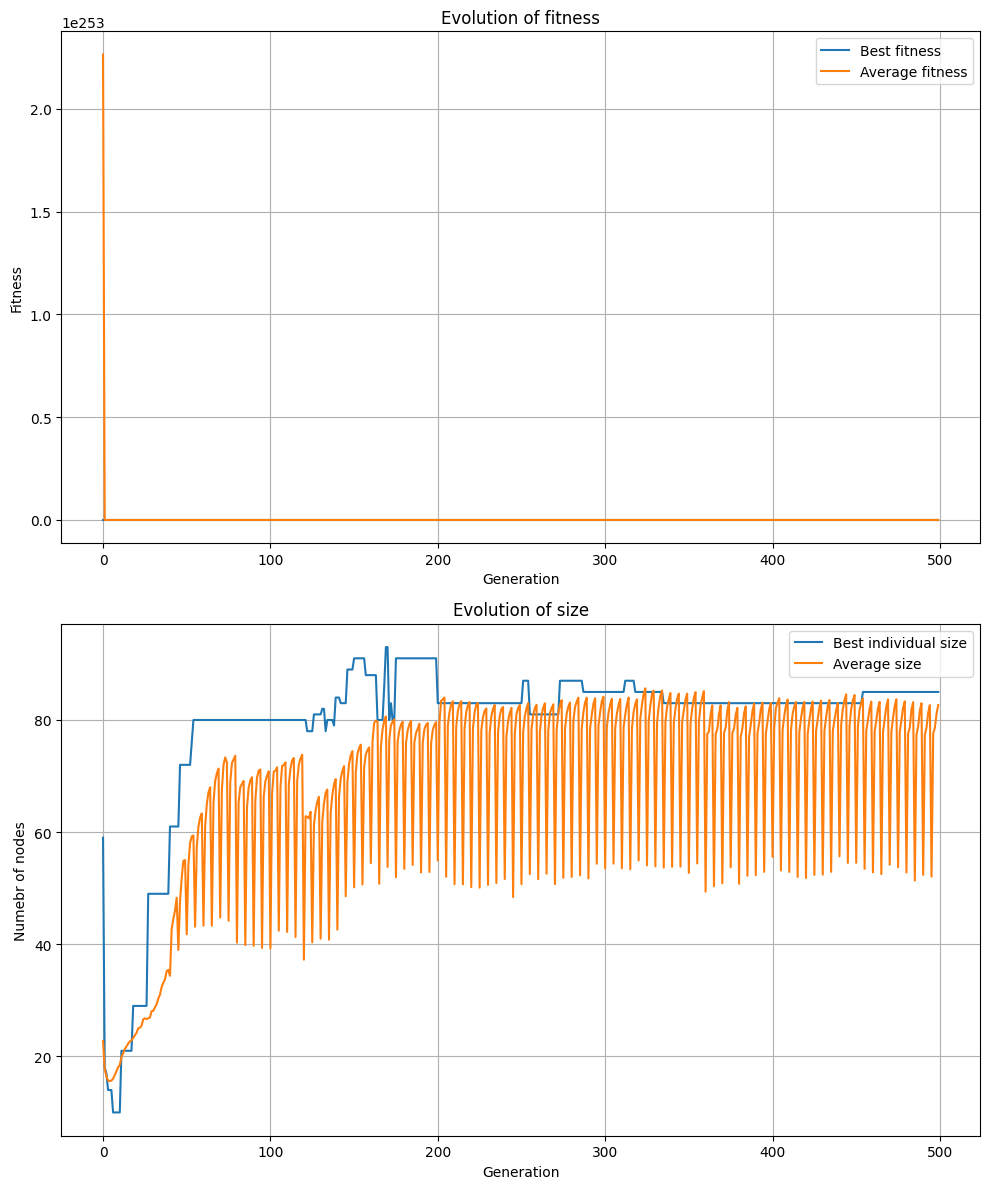

Original expression: (((-1301573.6081735631 + -1667888.905645238) * (sin((((x[2] + (x[0] + x[0])) + x[1]) * log(tan(-6476959.681381762)))) + (sin((((x[2] + x[0]) + (x[1] + x[0])) * log(tan(-3096338.9650774663)))) + (((x[2] + (x[0] + x[0])) + x[1]) * exp(tan((4397592.634281375 / -4354655.722764039))))))) * sin((-1230797.8088492597 - (((((x[1] + x[0]) + x[2]) + (x[1] - sqrt(-1230797.8088492597))) - ((sqrt(-3096338.9650774663) * sqrt(x[0])) * ((x[0] + x[0]) * (x[0] + x[0])))) - (sqrt(-3272060.4581361106) * ((log(-7355106.67995647) * (x[1] + x[2])) * (x[0] + x[0])))))))
Simplified expression: -1301573.6081735631 + -1667888.905645238) * (sin(x[2] + (x[0] + x[0]) + x[1]) * log(tan(-6476959.681381762) + (sin(x[2] + x[0]) + (x[1] + x[0]) * log(tan(-3096338.9650774663) + (x[2] + (x[0] + x[0]) + x[1]) * exp(tan(4397592.634281375 / -4354655.722764039))))) * sin(-1230797.8088492597 - (x[1] + x[0]) + x[2]) + (x[1] - sqrt(-1230797.8088492597) - (sqrt(-3096338.9650774663) * sqrtx[0] * (x[0] + x[0]) *

In [56]:
print(f"\n=== GP execution on {problems[2]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[2]['file_path'], 
    problems[2]['config'],
    function_weights=problems[2]['config'].get('function_weights'),
    terminal_weights=problems[2]['config'].get('terminal_weights'),
    use_islands=problems[2].get('use_islands', False),
    n_islands=problems[2].get('n_islands', 5),
    migration_interval=problems[2].get('migration_interval', 10),
    migration_rate=problems[2].get('migration_rate', 0.1),
)



=== GP execution on ../data/problem_3.npz ===
Loading data from ../data/problem_3.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 3), y shape (5000,)
Input 3-dimensional with 5000 samples
Personalised weight for sin: 0.3
Personalised weight for cos: 0.3
Personalised weight for tan: 0.3
Personalised weight for log: 0.4
Personalised weight for sqrt: 0.4

GP execution on ../data/problem_3.npz...
Prima di qualsiasi elaborazione:
X shape: (5000, 3), y shape: (5000,)
X mean: -0.030417282604580882, y mean: 21.20757039569563
X std: 2.8642541937497157, y std: 50.61161179521197
X range: [-4.999560884742536, 4.996817180802817], y range: [-134.0160235060043, 187.18503862007498]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  

C:\Users\domen\AppData\Local\Temp\ipykernel_20100\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 2629.3120218547574 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 2563.9203835616795 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 2249.1646172496057 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 2507.4290301178166 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 1431.6247041818408 | Mutation Strength: 0.90
Bloat control: 116 individuals exceed the maximum size
Bloat control: 107 individuals exceed the maximum size
Bloat control: 125 individuals exceed the maximum size
Bloat control: 92 individuals exceed the maximum size
Bloat control: 141 individuals exceed the maximum size


  0%|          | 1/500 [02:39<22:10:26, 159.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (exp(log(x[0])) / exp((x[1] + 1.0)))
  Simplified Expression: 0.367879441171442*x[0]*exp(-x[1])
  Fitness: 1431.6247041818408
  Complexity: 8 nodes
Generation 0, Best Fitness: 1431.6247041818408


  1%|          | 5/500 [08:29<12:57:43, 94.27s/it] 

Bloat control: 14 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  2%|▏         | 9/500 [14:54<12:30:21, 91.69s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((sqrt(((sqrt(144.67849992780555) * sqrt(2.718281828459045)) + ((x[0] * x[0]) - exp(x[1])))) * sqrt((x[0] * x[0]))) + ((x[0] * x[0]) - exp(x[1]))) + ((x[0] / x[0]) / exp(x[1])))
  Simplified Expression: x[0]**2 + sqrt(x[0]**2 - exp(x[1]) + 19.831211191514932)*Abs(x[0]) - exp(x[1]) + exp(-x[1])
  Fitness: 1350.011662531485
  Complexity: 32 nodes


  2%|▏         | 10/500 [16:39<13:02:13, 95.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * x[0]) - x[1]) + (((x[1] - x[2]) - x[2]) - -17.918201839154165)) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**2 - x[1]**3 - 2*x[2] + 17.918201839154165
  Fitness: 1050.9460517627713
  Complexity: 19 nodes
Bloat control: 9 individuals exceed the maximum size


  2%|▏         | 11/500 [19:20<15:44:10, 115.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - x[2]) - x[2]) - x[1]) + ((((x[0] * x[0]) - x[2]) - exp(tan(cos(x[0])))) + (1.0 - -17.918201839154165))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**2 - x[1]**3 - 3*x[2] - exp(tan(cos(x[0]))) + 18.918201839154165
  Fitness: 796.4871276875799
  Complexity: 28 nodes
Generation 10, Best Fitness: 796.4871276875799


  2%|▏         | 12/500 [20:55<14:50:01, 109.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - x[2]) - x[2]) - x[1]) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - x[1] - 4*x[2]
  Fitness: 258.78589241609865
  Complexity: 27 nodes


  3%|▎         | 13/500 [22:20<13:50:12, 102.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - x[2]) - x[2]) - tan(cos(x[0]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 4*x[2] - tan(cos(x[0]))
  Fitness: 168.7064402616754
  Complexity: 29 nodes


  3%|▎         | 15/500 [25:10<12:34:25, 93.33s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - x[2]) - x[2]) - tan(cos(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 4*x[2] - tan(cos(x[1]))
  Fitness: 167.75694577402584
  Complexity: 29 nodes
Bloat control: 8 individuals exceed the maximum size


  3%|▎         | 16/500 [27:38<14:46:34, 109.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - tan(cos(x[0]))) - x[2]) - tan(cos(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] - tan(cos(x[0])) - tan(cos(x[1]))
  Fitness: 161.26364319435112
  Complexity: 31 nodes


  3%|▎         | 17/500 [29:19<14:21:56, 107.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (log((x[0] + x[1])) - sqrt(x[1]))) - x[2]) - tan(cos(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 + sqrt(x[1]) - x[1]**3 - 3*x[2] - log(x[0] + x[1]) - tan(cos(x[1]))
  Fitness: 141.76833165997567
  Complexity: 35 nodes


  4%|▎         | 18/500 [31:09<14:28:10, 108.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - log(cos(x[0]))) - x[2]) - tan(cos(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] - log(cos(x[0])) - tan(cos(x[1]))
  Fitness: 126.45432362195095
  Complexity: 31 nodes


  4%|▍         | 19/500 [33:02<14:38:24, 109.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (log(cos(x[1])) - sqrt(x[1]))) - x[2]) - tan(cos(x[0]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 + sqrt(x[1]) - x[1]**3 - 3*x[2] - log(cos(x[1])) - tan(cos(x[0]))
  Fitness: 66.56179844704737
  Complexity: 34 nodes


  4%|▍         | 20/500 [34:52<14:37:22, 109.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (cos(x[1]) - sqrt(x[1]))) - x[2]) - (log(cos(x[1])) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 + 2*sqrt(x[1]) - x[1]**3 - 3*x[2] - log(cos(x[1])) - cos(x[1])
  Fitness: 58.06114436941361
  Complexity: 36 nodes
Bloat control: 4 individuals exceed the maximum size


  4%|▍         | 21/500 [38:01<17:46:17, 133.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (cos(x[1]) - sqrt(sqrt(x[0])))) - x[2]) - (log(cos(x[1])) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 - 3*x[2] - log(cos(x[1])) - cos(x[1])
  Fitness: 44.27643015832945
  Complexity: 37 nodes
Generation 20, Best Fitness: 44.27643015832945


  4%|▍         | 22/500 [40:00<17:09:06, 129.18s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - x[2]) - (log(cos(x[1])) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 - 4*x[2] - log(cos(x[1]))
  Fitness: 37.40595836040603
  Complexity: 36 nodes


  5%|▍         | 23/500 [41:48<16:14:56, 122.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(x[2]))) - x[2]) - (log(cos(x[1])) - sqrt(x[0]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: sqrt(x[0]) + 2*x[0]**2 - x[1]**3 + sqrt(x[2]) - 4*x[2] - log(cos(x[1]))
  Fitness: 34.81467091764217
  Complexity: 35 nodes


  5%|▍         | 24/500 [43:39<15:45:30, 119.18s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - x[2]) - (log(cos(cos((x[0] * x[0])))) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 - 4*x[2] - log(cos(cos(x[0]**2)))
  Fitness: 33.55625102238264
  Complexity: 39 nodes


  5%|▌         | 25/500 [45:36<15:37:58, 118.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(x[0]))) - x[2]) - (log(cos(cos((x[0] * x[0])))) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: sqrt(x[0]) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 - 4*x[2] - log(cos(cos(x[0]**2)))
  Fitness: 30.397327873085803
  Complexity: 38 nodes
Bloat control: 75 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


  5%|▌         | 26/500 [49:23<19:53:36, 151.09s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - (x[2] - sqrt(x[2]))) - (log(cos(cos((x[0] * x[0])))) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 + sqrt(x[2]) - 4*x[2] - log(cos(cos(x[0]**2)))
  Fitness: 29.24383086032718
  Complexity: 42 nodes


  5%|▌         | 27/500 [51:13<18:14:49, 138.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - log(cos(cos(x[1])))) - (log(cos(cos((x[0] * x[0])))) - sqrt((x[2] - sqrt(sqrt(x[0])))))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-x[0]**(1/4) + x[2]) - log(cos(cos(x[0]**2))) - log(cos(cos(x[1])))
  Fitness: 21.463004267844315
  Complexity: 46 nodes


  6%|▌         | 28/500 [53:04<17:07:07, 130.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - (x[2] - sqrt(x[2]))) - (log((x[2] - sqrt(x[2]))) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 + sqrt(x[2]) - 4*x[2] - log(-sqrt(x[2]) + x[2])
  Fitness: 18.06726831197602
  Complexity: 41 nodes


  6%|▌         | 29/500 [55:04<16:38:26, 127.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - log(cos(cos(x[1])))) - (log(cos(cos((x[0] * x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(sqrt(x[0])))))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-x[0]**(1/4) - sqrt(x[2]) + x[2]) - log(cos(cos(x[0]**2))) - log(cos(cos(x[1])))
  Fitness: 12.066442688824111
  Complexity: 49 nodes


  6%|▌         | 30/500 [56:56<16:00:33, 122.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(sqrt(x[0])))) - (x[2] - sqrt(x[2]))) - (log(((x[2] - sqrt(x[2])) - sqrt(x[2]))) - sqrt(x[1]))) + ((((x[0] * x[0]) - x[2]) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 + sqrt(x[1]) - x[1]**3 + sqrt(x[2]) - 4*x[2] - log(-2*sqrt(x[2]) + x[2])
  Fitness: 9.54164429431534
  Complexity: 44 nodes
Bloat control: 1429 individuals exceed the maximum size


  6%|▌         | 31/500 [1:00:01<18:26:07, 141.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(x[2])))) - (log(cos(cos((x[0] * x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(sqrt(x[0])))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-x[0]**(1/4) - sqrt(x[2]) + x[2]) - log(cos(cos(x[0]**2))) - log(cos(cos(x[2]))) + sqrt(cos(x[0]))
  Fitness: 7.5244427464449695
  Complexity: 53 nodes
Generation 30, Best Fitness: 7.5244427464449695


  6%|▋         | 32/500 [1:01:53<17:12:47, 132.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(x[2])))) - (log(cos(cos((x[0] * x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(sqrt(x[2])))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-x[2]**(1/4) - sqrt(x[2]) + x[2]) - log(cos(cos(x[0]**2))) - log(cos(cos(x[2]))) + sqrt(cos(x[0]))
  Fitness: 6.553321914864641
  Complexity: 53 nodes


  7%|▋         | 33/500 [1:03:44<16:22:04, 126.18s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(x[2])))) - (log(cos(cos((x[0] * x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(x[0]**2))) - log(cos(cos(x[2]))) + sqrt(cos(x[0]))
  Fitness: 5.313322819721094
  Complexity: 52 nodes


  7%|▋         | 34/500 [1:05:36<15:47:01, 121.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(x[2])))) - (log(cos(cos(cos(x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(x[2]))) - log(cos(cos(cos(x[0])))) + sqrt(cos(x[0]))
  Fitness: 4.712394306293427
  Complexity: 51 nodes


  7%|▋         | 35/500 [1:07:25<15:15:01, 118.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(sqrt(x[2]))))) - (log(cos(cos(cos(x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(cos(x[0])))) + sqrt(cos(x[0]))
  Fitness: 4.4673176210105465
  Complexity: 52 nodes
Bloat control: 1977 individuals exceed the maximum size


  8%|▊         | 39/500 [1:16:37<16:16:37, 127.11s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.007
  Island 2 diversity: 0.006
  Island 3 diversity: 0.001
  Island 4 diversity: 0.002
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 1.00)


  8%|▊         | 40/500 [1:18:53<16:35:00, 129.78s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 130 individuals exceed the maximum size
Bloat control: 86 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  8%|▊         | 41/500 [1:25:01<25:41:09, 201.46s/it]

Generation 40, Best Fitness: 4.4673176210105465


  8%|▊         | 42/500 [1:27:05<22:40:10, 178.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(cos(x[0])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(exp(x[2])))) - log(cos(cos(cos(x[0])))) + sqrt(cos(x[0]))
  Fitness: 4.460201034188786
  Complexity: 52 nodes


  9%|▉         | 44/500 [1:31:10<18:50:58, 148.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[0])))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(sqrt(x[2])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(exp(x[2])))) + sqrt(cos(x[0]))
  Fitness: 3.8726902262725256
  Complexity: 52 nodes


  9%|▉         | 46/500 [1:38:05<23:24:16, 185.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[2])))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(sqrt(x[2])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[0]**(1/4) + 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(exp(x[2])))) + sqrt(cos(x[2]))
  Fitness: 3.5664226072371683
  Complexity: 52 nodes


 10%|▉         | 48/500 [1:41:40<18:13:16, 145.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[2])))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(sqrt(x[2])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt(sqrt(x[1])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 + x[1]**(1/4) - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(exp(x[2])))) + sqrt(cos(x[2]))
  Fitness: 3.5186895859287572
  Complexity: 52 nodes


 10%|█         | 50/500 [1:45:35<16:24:55, 131.32s/it]

Bloat control: 1 individuals exceed the maximum size


 10%|█         | 51/500 [1:50:53<23:22:01, 187.35s/it]

Generation 50, Best Fitness: 3.5186895859287572


 10%|█         | 52/500 [1:52:51<20:43:27, 166.54s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(x[2])))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(sqrt(x[2])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(exp(x[2])))) + sqrt(cos(x[2])) + 1
  Fitness: 3.487506889113611
  Complexity: 53 nodes


 11%|█         | 54/500 [1:56:44<17:28:56, 141.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt((x[2] / x[2])))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(sqrt(x[2])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(exp(x[2])))) + 2
  Fitness: 2.9229004652020363
  Complexity: 54 nodes


 11%|█         | 55/500 [1:58:41<16:33:46, 133.99s/it]

Bloat control: 1 individuals exceed the maximum size


 12%|█▏        | 60/500 [2:11:33<16:19:39, 133.59s/it]

Bloat control: 1510 individuals exceed the maximum size


 12%|█▏        | 61/500 [2:16:35<22:28:14, 184.27s/it]

Generation 60, Best Fitness: 2.9229004652020363


 13%|█▎        | 65/500 [2:24:28<16:11:48, 134.04s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1996 individuals exceed the maximum size


 14%|█▍        | 69/500 [2:35:54<17:12:17, 143.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(125.32976345788842)))) - log(cos(cos(exp(x[2]))))) - (log(cos(cos(sqrt(x[2])))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(sqrt(x[2])))) - log(cos(cos(exp(x[2])))) + 1.9719863137035503
  Fitness: 2.9190689683377835
  Complexity: 53 nodes


 14%|█▍        | 70/500 [2:37:41<15:50:51, 132.68s/it]

Bloat control: 1998 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:41:25<19:04:36, 160.09s/it]

Generation 70, Best Fitness: 2.9190689683377835


 15%|█▌        | 75/500 [2:47:29<12:42:59, 107.72s/it]

Bloat control: 2000 individuals exceed the maximum size


 16%|█▌        | 79/500 [2:56:09<13:02:06, 111.47s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.005
  Island 2 diversity: 0.001
  Island 3 diversity: 0.006
  Island 4 diversity: 0.004
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 0.50)


 16%|█▌        | 80/500 [2:57:46<12:28:44, 106.96s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 133 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 16%|█▌        | 81/500 [3:03:02<19:45:11, 169.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(125.32976345788842)))) - log(cos(cos(exp(x[2]))))) - (cos(log(((x[2] - 2.718281828459045) - 2.718281828459045))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(exp(x[2])))) - cos(log(x[2] - 5.43656365691809)) + 1.9719863137035503
  Fitness: 1.4274417110126414
  Complexity: 55 nodes
Generation 80, Best Fitness: 1.4274417110126414


 16%|█▋        | 82/500 [3:04:30<16:52:21, 145.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(125.32976345788842)))) - log(cos(cos(exp(x[1]))))) - (cos(log(((x[2] - 2.718281828459045) - 2.718281828459045))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - log(cos(cos(exp(x[1])))) - cos(log(x[2] - 5.43656365691809)) + 1.9719863137035503
  Fitness: 1.2107421496088506
  Complexity: 55 nodes


 17%|█▋        | 83/500 [3:05:58<14:50:33, 128.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(125.32976345788842)))) - log(cos(sqrt(cos(125.32976345788842))))) - (cos(log(((x[2] - 2.718281828459045) - 2.718281828459045))) - sqrt(((x[2] - sqrt(x[2])) - sqrt(x[2]))))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-2*sqrt(x[2]) + x[2]) - cos(log(x[2] - 5.43656365691809)) + 2.5452904746963947
  Fitness: 0.5439570155487988
  Complexity: 55 nodes


 17%|█▋        | 84/500 [3:07:27<13:26:50, 116.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(exp(x[2]))))) - (cos(log(((x[2] - 2.718281828459045) - 2.718281828459045))) - sqrt(((x[2] - sqrt(x[2])) - 2.718281828459045)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.718281828459045) - log(cos(cos(exp(x[2])))) - cos(log(x[2] - 5.43656365691809)) + 1.6279954347561189
  Fitness: 0.5042680126483722
  Complexity: 54 nodes


 17%|█▋        | 85/500 [3:08:57<12:30:04, 108.45s/it]

Bloat control: 1 individuals exceed the maximum size


 17%|█▋        | 86/500 [3:13:40<18:28:02, 160.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(2.718281828459045)))) - (cos(log(((x[2] - 2.718281828459045) - 2.718281828459045))) - sqrt(((x[2] - sqrt(x[2])) - 2.718281828459045)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.718281828459045) - cos(log(x[2] - 5.43656365691809)) + 2.1184044116614641
  Fitness: 0.3651640338431119
  Complexity: 53 nodes


 18%|█▊        | 88/500 [3:16:38<14:12:05, 124.09s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(2.718281828459045)))) - (cos(log(((x[2] - 2.6317634008558475) - 2.718281828459045))) - sqrt(((x[2] - sqrt(x[2])) - 2.718281828459045)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.718281828459045) - cos(log(x[2] - 5.3500452293148925)) + 2.1184044116614641
  Fitness: 0.3444195213312546
  Complexity: 53 nodes


 18%|█▊        | 90/500 [3:19:35<12:04:13, 105.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(2.718281828459045)))) - (cos(log(((x[2] - 2.6317634008558475) - 2.6317634008558475))) - sqrt(((x[2] - sqrt(x[2])) - 2.718281828459045)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.718281828459045) - cos(log(x[2] - 5.263526801711695)) + 2.1184044116614641
  Fitness: 0.34289983227396814
  Complexity: 53 nodes


 18%|█▊        | 91/500 [3:24:14<17:56:04, 157.86s/it]

Generation 90, Best Fitness: 0.34289983227396814


 18%|█▊        | 92/500 [3:25:43<15:33:02, 137.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6317634008558475) - 2.6317634008558475))) - sqrt(((x[2] - sqrt(x[2])) - 2.718281828459045)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.718281828459045) - cos(log(x[2] - 5.263526801711695)) + 2.1334310871946015
  Fitness: 0.34150373277291324
  Complexity: 54 nodes


 20%|██        | 100/500 [3:40:07<11:12:21, 100.85s/it]

Island 0 | Generation 100 | Best Fitness: 2.9190688761034704 | Mutation Strength: 2.94
Island 1 | Generation 100 | Best Fitness: 2.9190689683377835 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 0.34150373277291324 | Mutation Strength: 2.78
Island 3 | Generation 100 | Best Fitness: 2.918611905283968 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 2.9190689683377835 | Mutation Strength: 3.00


 20%|██        | 101/500 [3:44:38<16:49:31, 151.81s/it]

Generation 100, Best Fitness: 0.34150373277291324


 21%|██        | 105/500 [3:50:21<11:09:01, 101.62s/it]

Bloat control: 45 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 21%|██        | 106/500 [3:55:29<17:54:19, 163.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6317634008558475) - 2.6317634008558475))) - sqrt(((x[2] - sqrt(x[2])) - 2.6948878245666346)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6948878245666346) - cos(log(x[2] - 5.263526801711695)) + 2.1334310871946015
  Fitness: 0.3390569143249345
  Complexity: 54 nodes


 22%|██▏       | 108/500 [3:58:21<13:29:27, 123.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6317634008558475) - 2.6948878245666346))) - sqrt(((x[2] - sqrt(x[2])) - 2.6948878245666346)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6948878245666346) - cos(log(x[2] - 5.3266512254224821)) + 2.1334310871946015
  Fitness: 0.3383424047989554
  Complexity: 54 nodes


 22%|██▏       | 110/500 [4:01:13<11:19:17, 104.51s/it]

Bloat control: 1990 individuals exceed the maximum size


 22%|██▏       | 111/500 [4:05:13<15:42:20, 145.35s/it]

Generation 110, Best Fitness: 0.3383424047989554


 23%|██▎       | 115/500 [4:10:57<10:42:04, 100.06s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 24%|██▍       | 119/500 [4:19:16<11:07:11, 105.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6317634008558475) - 2.641366287354007))) - sqrt(((x[2] - sqrt(x[2])) - 2.6948878245666346)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6948878245666346) - cos(log(x[2] - 5.2731296882098545)) + 2.1334310871946015
  Fitness: 0.3378273648517172
  Complexity: 54 nodes
Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.004
  Island 2 diversity: 0.003
  Island 3 diversity: 0.004
  Island 4 diversity: 0.005
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island

 24%|██▍       | 120/500 [4:20:47<10:38:32, 100.82s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 127 individuals exceed the maximum size
Bloat control: 1847 individuals exceed the maximum size
Bloat control: 21 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 24%|██▍       | 121/500 [4:24:25<14:18:53, 135.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6317634008558475) - 2.68588942694237))) - sqrt(((x[2] - sqrt(x[2])) - 2.6948878245666346)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6948878245666346) - cos(log(x[2] - 5.3176528277982174)) + 2.1334310871946015
  Fitness: 0.3375174022876811
  Complexity: 54 nodes
Generation 120, Best Fitness: 0.3375174022876811


 24%|██▍       | 122/500 [4:25:50<12:39:57, 120.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.641366287354007))) - sqrt(((x[2] - sqrt(x[2])) - 2.6948878245666346)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6948878245666346) - cos(log(x[2] - 5.282732574708014)) + 2.1334310871946015
  Fitness: 0.3370551742810332
  Complexity: 54 nodes


 25%|██▍       | 123/500 [4:27:15<11:30:24, 109.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6317634008558475) - 2.68588942694237))) - sqrt(((x[2] - sqrt(x[2])) - 2.68588942694237)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.68588942694237) - cos(log(x[2] - 5.3176528277982174)) + 2.1334310871946015
  Fitness: 0.3369351181172972
  Complexity: 54 nodes


 25%|██▍       | 124/500 [4:28:40<10:41:47, 102.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(cos(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.641366287354007))) - sqrt(((x[2] - sqrt(x[2])) - 2.68588942694237)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.68588942694237) - cos(log(x[2] - 5.282732574708014)) + 2.1334310871946015
  Fitness: 0.33668906509246527
  Complexity: 54 nodes


 25%|██▌       | 125/500 [4:30:04<10:06:23, 97.02s/it] 

Bloat control: 1998 individuals exceed the maximum size


 26%|██▌       | 130/500 [4:39:08<9:48:29, 95.43s/it]  

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 26%|██▌       | 131/500 [4:43:24<14:42:33, 143.51s/it]

Generation 130, Best Fitness: 0.33668906509246527


 27%|██▋       | 133/500 [4:46:14<11:35:10, 113.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.641366287354007))) - sqrt(((x[2] - sqrt(x[2])) - 2.68588942694237)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.68588942694237) - cos(log(x[2] - 5.282732574708014)) + 2.1430342692793209
  Fitness: 0.3365091637804976
  Complexity: 54 nodes


 27%|██▋       | 135/500 [4:49:04<10:03:08, 99.15s/it] 

Bloat control: 1999 individuals exceed the maximum size


 28%|██▊       | 140/500 [4:58:38<9:47:38, 97.94s/it]  

Bloat control: 1998 individuals exceed the maximum size


 28%|██▊       | 141/500 [5:02:41<14:05:58, 141.39s/it]

Generation 140, Best Fitness: 0.3365091637804976


 29%|██▊       | 143/500 [5:05:31<11:10:52, 112.75s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.641366287354007))) - sqrt(((x[2] - sqrt(x[2])) - 2.6684902059838858)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6684902059838858) - cos(log(x[2] - 5.282732574708014)) + 2.1430342692793209
  Fitness: 0.3361482192751542
  Complexity: 54 nodes


 29%|██▉       | 145/500 [5:08:22<9:44:58, 98.87s/it]  

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 29%|██▉       | 146/500 [5:12:42<14:27:38, 147.06s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.6684902059838858))) - sqrt(((x[2] - sqrt(x[2])) - 2.6684902059838858)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.6684902059838858) - cos(log(x[2] - 5.3098564933378928)) + 2.1430342692793209
  Fitness: 0.335856971715095
  Complexity: 54 nodes


 30%|███       | 150/500 [5:18:20<9:39:35, 99.36s/it]  

Bloat control: 1996 individuals exceed the maximum size


 30%|███       | 151/500 [5:22:23<13:48:19, 142.41s/it]

Generation 150, Best Fitness: 0.335856971715095


 31%|███       | 155/500 [5:28:03<9:28:25, 98.86s/it]  

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 32%|███▏      | 159/500 [5:36:31<10:00:21, 105.63s/it]

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.004
  Island 2 diversity: 0.005
  Island 3 diversity: 0.004
  Island 4 diversity: 0.003
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 0.50)


 32%|███▏      | 160/500 [5:38:00<9:31:04, 100.78s/it] 

  Migration: 400 individuals from island 4 to island 0(mutation strength: 0.50)
Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.3356174610197105
  Complexity: 54 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 135 individuals exceed the maximum size
Bloat control: 19 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 32%|███▏      | 161/500 [5:42:58<15:03:15, 159.87s/it]

Generation 160, Best Fitness: 0.3356174610197105


 33%|███▎      | 165/500 [5:48:37<9:34:25, 102.88s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 34%|███▍      | 170/500 [5:58:57<9:19:42, 101.76s/it] 

Bloat control: 1 individuals exceed the maximum size


 34%|███▍      | 171/500 [6:03:38<14:11:59, 155.38s/it]

Generation 170, Best Fitness: 0.3356174610197105


 34%|███▍      | 172/500 [6:05:03<12:14:00, 134.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * (x[1] - exp(-17.244722227185633))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**2*(x[1] - 3.2412482461471196e-8) - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.335617436716513
  Complexity: 57 nodes


 35%|███▍      | 174/500 [6:07:51<9:50:17, 108.64s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-17.244722227185633)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * (x[1] - exp(-17.244722227185633))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**2*(x[1] - 3.2412482461471196e-8) - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342368668384
  Fitness: 0.33561743638053476
  Complexity: 60 nodes


 35%|███▌      | 175/500 [6:09:17<9:11:01, 101.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((x[1] - exp(-17.244722227185633)) * (x[1] - exp(-17.244722227185633))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]*(x[1] - 3.2412482461471196e-8)**2 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.33561741241593546
  Complexity: 60 nodes


 35%|███▌      | 176/500 [6:13:47<13:41:49, 152.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-17.244722227185633)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((x[1] - exp(-17.244722227185633)) * (x[1] - exp(-17.244722227185633))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]*(x[1] - 3.2412482461471196e-8)**2 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342368668384
  Fitness: 0.3356174120797826
  Complexity: 63 nodes


 35%|███▌      | 177/500 [6:15:11<11:49:18, 131.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**2*(x[1] - 1.331026881200883e-7) - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.33561736123472696
  Complexity: 60 nodes


 36%|███▌      | 178/500 [6:16:36<10:32:18, 117.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((x[1] - exp(-17.244722227185633)) * (((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-17.244722227185633))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]*(x[1] - 1.6551517058155949e-7)*(x[1] - 3.2412482461471196e-8) - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.3356173126524794
  Complexity: 66 nodes


 36%|███▌      | 179/500 [6:18:00<9:36:45, 107.81s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]*(x[1] - 1.331026881200883e-7)**2 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.3356172614939412
  Complexity: 66 nodes


 36%|███▌      | 180/500 [6:19:25<8:57:46, 100.83s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((x[1] - exp(-17.244722227185633)) * (((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-17.244722227185633))) * (((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-17.244722227185633))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 1.6551517058155949e-7)**2*(x[1] - 3.2412482461471196e-8) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.3356171886567905
  Complexity: 75 nodes
Bloat control: 1702 individuals exceed the maximum size


 36%|███▌      | 181/500 [6:23:30<12:45:45, 144.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]*(x[1] - 2.6620537624017659e-7)*(x[1] - 1.331026881200883e-7) - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.33561716179735995
  Complexity: 72 nodes
Generation 180, Best Fitness: 0.33561716179735995


 37%|███▋      | 183/500 [6:26:20<10:01:42, 113.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))) * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-17.244722227185633) - exp(-16.111217304528004) * (x[1] - exp(-17.244722227185633) - exp(-16.111217304528004)) * (x[1] - exp(-17.244722227185633)

 37%|███▋      | 184/500 [6:27:46<9:15:26, 105.46s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))) * x[1]))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-17.244722227185633) - exp(-16.111217304528004) * (x[1] - exp(-17.244722227185633) - exp(-16.111217304528004) - exp(-16.111217304528004) - exp(-1

 37%|███▋      | 185/500 [6:29:11<8:42:14, 99.48s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))) * (((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-17.244722227185633) - exp(-16.111217304528004) * (x[1] - 

 37%|███▋      | 186/500 [6:33:16<12:29:46, 143.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))) * ((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-17.244722227185633) - exp(-1

 38%|███▊      | 188/500 [6:36:06<9:50:51, 113.63s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) * ((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004))) * ((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 4.0276082263446841e-7)*(x[1] - 2.013804113172342e-7)*(x[1] - 1.331026881200883e-7) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.33561690887518836
  Complexity: 76 nodes


 38%|███▊      | 189/500 [6:37:32<9:04:57, 105.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) * ((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004))) * (((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(

 38%|███▊      | 190/500 [6:38:57<8:32:21, 99.17s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) * ((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004))) * (((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(

 38%|███▊      | 191/500 [6:43:03<12:18:23, 143.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) * ((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004))) * (((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-17.244722227185633)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] -

 39%|███▉      | 194/500 [6:47:21<8:58:22, 105.56s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) * ((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))) * (((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] *

 39%|███▉      | 195/500 [6:48:47<8:27:22, 99.81s/it] 

Bloat control: 1965 individuals exceed the maximum size


 39%|███▉      | 196/500 [6:52:52<12:05:40, 143.23s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) * ((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))) * (((((x[1] - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] -

 40%|███▉      | 199/500 [6:57:09<8:49:41, 105.59s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.005
  Island 2 diversity: 0.004
  Island 3 diversity: 0.004
  Island 4 diversity: 0.002
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 0.50)


 40%|████      | 200/500 [6:58:41<8:27:04, 101.42s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.01)
Island 0 | Generation 200 | Best Fitness: 0.33561647949370654 | Mutation Strength: 2.70
Island 1 | Generation 200 | Best Fitness: 0.33561324220223665 | Mutation Strength: 2.38
Island 2 | Generation 200 | Best Fitness: 0.3356174610197105 | Mutation Strength: 2.65
Island 3 | Generation 200 | Best Fitness: 0.3356174610197105 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 0.33561637599677363 | Mutation Strength: 0.95
Bloat control: 1395 individuals exceed the maximum size
Bloat control: 1913 individuals exceed the maximum size


 40%|████      | 201/500 [7:02:03<10:55:45, 131.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.658102948714268))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt((x[2] / x[2])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.299469236068275)) + 2.1430342692793209
  Fitness: 0.33561324220223665
  Complexity: 54 nodes
Generation 200, Best Fitness: 0.33561324220223665


 41%|████      | 205/500 [7:07:51<8:00:28, 97.72s/it]  

Bloat control: 1976 individuals exceed the maximum size
Bloat control: 1981 individuals exceed the maximum size


 42%|████▏     | 210/500 [7:17:29<8:00:37, 99.44s/it]  

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1962 individuals exceed the maximum size


 42%|████▏     | 211/500 [7:21:36<11:31:31, 143.57s/it]

Generation 210, Best Fitness: 0.33561324220223665


 43%|████▎     | 213/500 [7:24:31<9:10:13, 115.03s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.641366287354007) - 2.658102948714268))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[1] - sqrt((x[2] / x[2])))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.299469236068275)) + 2.1430342692793209
  Fitness: 0.3356132422022365
  Complexity: 54 nodes


 43%|████▎     | 214/500 [7:25:57<8:27:22, 106.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-16.111217304528004)) - exp(-13.944172813993893)) * (((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - s

 43%|████▎     | 215/500 [7:27:25<7:59:22, 100.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-16.111217304528004)) - exp(-13.944172813993893)) * (((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-14.740299295382668))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - s

 43%|████▎     | 216/500 [7:31:32<11:24:21, 144.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-13.944172813993893)) * (((x[1] - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-14.740299295382668)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - s

 44%|████▎     | 218/500 [7:34:24<8:59:42, 114.83s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) * ((x[1] - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-13.274648475567332)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x

 44%|████▍     | 219/500 [7:35:52<8:19:38, 106.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-16.111217304528004)) - exp(-13.944172813993893)) * ((((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))

 44%|████▍     | 220/500 [7:37:19<7:50:55, 100.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) * ((x[1] - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-13.274648475567332)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x

 44%|████▍     | 221/500 [7:41:10<10:49:50, 139.75s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) * ((x[1] - exp(-13.274648475567332)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-13.274648475567332)) - exp(-13.274648475567332)) - exp(-16.111217304528004)) - exp(-16.111217304528004))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x

 44%|████▍     | 222/500 [7:42:36<9:33:51, 123.85s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-13.944172813993893)) * ((x[1] - exp(-13.944172813993893)) - exp(-13.944172813993893))) * ((x[1] - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-13.274648475567332) - exp(-11.149465377890067) - exp(-13.94

 45%|████▍     | 223/500 [7:44:04<8:41:27, 112.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - 0.0) - exp(-11.149465377890067)) * ((((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (

 45%|████▍     | 224/500 [7:45:31<8:04:07, 105.24s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - 0.0) - exp(-11.149465377890067)) * ((((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (

 45%|████▌     | 225/500 [7:46:58<7:36:53, 99.69s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - 0.0) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * (((((x[1] - exp(-13.944172813993893)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (

 45%|████▌     | 226/500 [7:50:48<10:33:40, 138.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-11.149465377890067)) * ((((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))

 46%|████▌     | 228/500 [7:53:41<8:28:52, 112.25s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[1] - exp(-16.111217304528004)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-11.149465377890067)) - 0.0) - exp(-11.149465377890067)) * ((((x[1] - 0.0) - exp(-13.944172813993893)) - exp(-11.149465377890067)) - exp(-13.944172813993893))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-16.111217304528004)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - exp(-16.111217304528004) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) 

 46%|████▌     | 229/500 [7:55:09<7:54:10, 104.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-13.274648475567332)) - 0.0) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-13.274648475567332) 

 46%|████▌     | 230/500 [7:56:37<7:29:04, 99.79s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-16.111217304528004)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] *

 46%|████▌     | 231/500 [8:00:41<10:41:34, 143.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-13.944172813993893)) - exp(-13.944172813993893)) - exp(-13.944172813993893))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] *

 47%|████▋     | 233/500 [8:03:36<8:30:01, 114.61s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] *

 47%|████▋     | 234/500 [8:05:03<7:51:26, 106.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] *

 47%|████▋     | 235/500 [8:06:30<7:24:18, 100.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sqrt(-1.0) - x[1]) + (x[0] *

 47%|████▋     | 236/500 [8:10:18<10:11:05, 138.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))) * (((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] -

 48%|████▊     | 239/500 [8:14:40<7:37:11, 105.10s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 1.0)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))) * (((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 5.7531897964353119e-5)*(x[1] - 4.658389715193133e-5)*(x[1] - 4.4866410312598085e-5) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
 

 48%|████▊     | 240/500 [8:16:12<7:18:40, 101.23s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.00)
Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sqrt(-1.0))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))) * (((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(cos(114.26274067452147)))) - (cos(log(x[2] - 2.6460189188020977) - 2.654177

 48%|████▊     | 241/500 [8:19:12<8:58:08, 124.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 1.0)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-10.378557062584193)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 7.4241015008624038e-5)*(x[1] - 5.7531897964353119e-5)*(x[1] - 4.4866410312598085e-5) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1430342692793209
  Fitness: 0.3355239301636264

 49%|████▊     | 243/500 [8:22:10<7:36:56, 106.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-13.274648475567332)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))) * (((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 7.1914872455441399e-5)*(x[1] - 5.7531897964353119e-5)*(x[1] - 3.220092266084305e-5) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.140

 49%|████▉     | 245/500 [8:25:14<7:01:35, 99.20s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))) * (((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 7.1914872455441399e-5)*(x[1] - 5.7531897964353119e-5)**2 + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1405919290616236
  Fitness: 0.

 49%|████▉     | 246/500 [8:28:07<8:33:30, 121.30s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - (x[1] - exp(-11.149465377890067))) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))) * (((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 7.1914872455441399e-5)*(x[1] - 5.7531897964353119e-5)**2 + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1

 50%|████▉     | 248/500 [8:31:07<7:22:52, 105.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-11.149465377890067))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 8.5732007538087647e-5)*(x[1] - 5.7531897964353119e-5)**2 + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1405919290616236
  Fitness: 0.33546994086032705
  Complexit

 50%|█████     | 250/500 [8:34:11<6:50:43, 98.57s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067))) * (((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-10.064053471229355)) - exp(-11.149465377890067))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 0.00012831509160291046)*(x[1] - 5.7531897964353119e-5)**2 + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1405919290616236
  Fitness: 0

 50%|█████     | 251/500 [8:37:11<8:29:44, 122.83s/it]

Generation 250, Best Fitness: 0.3354443010367147


 51%|█████     | 253/500 [8:40:35<7:46:55, 113.42s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-10.064053471229355)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - 0.0)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-10.064053471229355))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 0.00011393211711182218)**2*(x[1] - 4.3148923473264839e-5) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1405919290616236
  Fitness: 0.3354300822789045
  Complexity: 86 nodes


 51%|█████     | 254/500 [8:43:25<8:53:51, 130.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-11.149465377890067)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-11.149465377890067))) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-10.064053471229355))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 0.00011393211711182218)*(x[1] - 8.5732007538087647e-5)**2 + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1405919290616236
  Fitness: 0.33542343507646866
  Complexi

 51%|█████     | 255/500 [8:45:57<9:18:27, 136.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 0.9975576597823027)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-10.064053471229355)) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355))) * ((((x[1] - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.064053471229355)) - exp(-10.064053471229355))))
  Simplified Expression: 2*x[0]**2 - 3*x[2] - (x[1] - 0.00011393211711182218)**2*(x[1] - 8.5732007538087647e-5) + sqrt(-sqrt(x[2]) + x[2] - 2.669570851544243) - cos(log(x[2] - 5.3001959786101977)) + 2.1405919290616236
  Fitness: 0.3354119012600765
  Complexit

 51%|█████     | 256/500 [8:49:50<11:13:48, 165.69s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-10.293205534579135)) - ((x[2] * x[2]) / -107.76558960553521)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(cos(114.26274067452147))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - 1.0)) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-10.293205534579135)) - exp(-11.149465377890067)) - exp(-10.293205534579135)) - exp(-11.149465377890067)) * ((((x[1] - exp(-10.293205534579135)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-10.293205534579135))) * (((((x[1] - exp(-10.293205534579135)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-11.149465377890067)) - exp(-13.274648475567332))))
  Simplified Expression: 2*x[0]**2 + 0.0092793998869249129*x[2]**2 - 3*x[2] - (x[1] - 9.649073334435397e-5)*(x[1] - 9.649073334435397e-5)*(x[1] - 7.872880249368679e-5) + sqrt

 52%|█████▏    | 260/500 [8:58:21<9:13:39, 138.41s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 52%|█████▏    | 261/500 [9:02:28<11:20:50, 170.92s/it]

Generation 260, Best Fitness: 0.296730885000164


 53%|█████▎    | 265/500 [9:11:08<9:03:38, 138.80s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 54%|█████▍    | 270/500 [9:21:04<7:15:51, 113.70s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 54%|█████▍    | 271/500 [9:24:16<8:43:53, 137.27s/it]

Generation 270, Best Fitness: 0.296730885000164


 55%|█████▌    | 275/500 [9:30:54<6:47:06, 108.56s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 279/500 [9:39:59<7:15:38, 118.28s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.005
  Island 2 diversity: 0.001
  Island 3 diversity: 0.003
  Island 4 diversity: 0.004
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 1.00)


 56%|█████▌    | 280/500 [9:42:03<7:20:01, 120.00s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 281/500 [9:45:54<9:19:37, 153.32s/it]

Generation 280, Best Fitness: 0.296730885000164


 57%|█████▋    | 285/500 [9:52:27<6:36:06, 110.54s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 58%|█████▊    | 290/500 [10:01:28<5:52:44, 100.78s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 58%|█████▊    | 291/500 [10:04:22<7:07:17, 122.67s/it]

Generation 290, Best Fitness: 0.296730885000164


 59%|█████▉    | 295/500 [10:10:25<5:36:31, 98.49s/it] 

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 60%|██████    | 300/500 [10:19:19<5:26:07, 97.84s/it] 

Island 0 | Generation 300 | Best Fitness: 0.3348765314526019 | Mutation Strength: 1.74
Island 1 | Generation 300 | Best Fitness: 0.3353569509193663 | Mutation Strength: 2.47
Island 2 | Generation 300 | Best Fitness: 0.33535616030979254 | Mutation Strength: 1.03
Island 3 | Generation 300 | Best Fitness: 0.33511694324874103 | Mutation Strength: 1.04
Island 4 | Generation 300 | Best Fitness: 0.296730885000164 | Mutation Strength: 3.00
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 60%|██████    | 301/500 [10:22:10<6:37:53, 119.97s/it]

Generation 300, Best Fitness: 0.296730885000164


 61%|██████    | 305/500 [10:28:11<5:16:59, 97.53s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 62%|██████▏   | 310/500 [10:37:07<5:10:26, 98.04s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 62%|██████▏   | 311/500 [10:39:59<6:19:04, 120.34s/it]

Generation 310, Best Fitness: 0.296730885000164


 63%|██████▎   | 315/500 [10:46:01<5:01:11, 97.68s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 64%|██████▍   | 319/500 [10:55:36<6:14:25, 124.12s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.006
  Island 2 diversity: 0.005
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 400 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 1.00)


 64%|██████▍   | 320/500 [10:57:44<6:15:05, 125.03s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 64%|██████▍   | 321/500 [11:01:48<7:59:33, 160.75s/it]

Generation 320, Best Fitness: 0.296730885000164


 65%|██████▍   | 324/500 [11:09:42<7:49:19, 160.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((((x[1] - exp(-10.385417411679157)) - exp(-11.149465377890067)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.646018

 65%|██████▌   | 325/500 [11:12:56<8:16:10, 170.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((((x[1] - exp(-10.385417411679157)) - exp(-11.149465377890067)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.64601

 65%|██████▌   | 326/500 [11:18:37<10:42:00, 221.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-10.385417411679157)) - exp(-9.749278674951885))) * (((((x[1] - exp(-10.385417411679157)) - exp(-11.149465377890067)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460

 65%|██████▌   | 327/500 [11:20:44<9:16:50, 193.13s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 

 66%|██████▌   | 328/500 [11:23:11<8:33:32, 179.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos((1.0 + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sin((x[0] / x[0])))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((((x[1] - exp(-10.385417411679157)) - exp(-11.149465377890067)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460189188020977) - 

 66%|██████▌   | 329/500 [11:25:26<7:52:45, 165.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] -

 66%|██████▌   | 330/500 [11:27:44<7:26:28, 157.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.749278674951885)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] -

 66%|██████▌   | 331/500 [11:32:00<8:47:00, 187.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.546147564943496)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (((x[1] - exp(-9.546147564943496)) - exp(-9.546147564943496)) - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 

 66%|██████▋   | 332/500 [11:33:53<7:41:44, 164.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos((1.0 + (x[2] / -47.30653830927184))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885)) * (((x[1] - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (x[1] - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -47.30653830927184))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548

 67%|██████▋   | 333/500 [11:35:39<6:49:22, 147.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -44.7097875323078))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885)) * ((x[1] - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (x[1] - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -44.7097875323078))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.6460189188020977))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[1]) + (x[0

 67%|██████▋   | 334/500 [11:37:23<6:11:26, 134.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -44.7097875323078))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885)) * ((x[1] - exp(-10.385417411679157)) - exp(-9.749278674951885))) * (x[1] - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -44.7097875323078))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.6460189188020977))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[1]) + (x[

 67%|██████▋   | 335/500 [11:39:10<5:46:54, 126.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -44.7097875323078))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885)) * ((x[1] - exp(-9.546147564943496)) - exp(-9.749278674951885))) * (x[1] - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -44.7097875323078))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[1]) + (x[0] 

 67%|██████▋   | 336/500 [11:42:59<7:08:44, 156.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((((x[1] - exp(-9.546147564943496)) * sin(45.47529547334298)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -44.7097875323078))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6541770598081))) - sqrt(((x[2] - sqrt(x[2])) - 2.669570851544243)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - ((((((x[1] - exp(-9.546147564943496)) - exp(-10.385417411679157)) - exp(-9.546147564943496)) - exp(-9.749278674951885)) * (x[1] - exp(-9.546147564943496))) * (x[1] - exp(-9.749278674951885))))
  Simplified Expression: x[1] - exp(-9.546147564943496) * sin(45.47529547334298) - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -44.7097875323078))) - (cos(log(x[2] - 2.6460189188020977) - 2.6541770598081) - sqrt(x[2] - sqrtx[2] - 2.669570851544243))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] - ex

 68%|██████▊   | 340/500 [11:51:10<5:40:27, 127.67s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1696 individuals exceed the maximum size


 68%|██████▊   | 341/500 [11:54:31<6:36:52, 149.76s/it]

Generation 340, Best Fitness: 0.16593219098693057


 69%|██████▉   | 345/500 [12:01:38<5:02:13, 116.99s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 70%|██████▉   | 348/500 [12:09:05<5:25:34, 128.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[1] - (x[2] - sqrt(cos(108.78615012548357)))) - log(cos(((x[0] / x[0]) + (x[2] / -44.7097875323078))))) - (cos(log(((x[2] - 2.6460189188020977) - 2.6460189188020977))) - sqrt(((x[2] - sqrt(x[2])) - 2.6460189188020977)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[1]) + ((x[0] * x[0]) - x[2]))) - (((x[1] + exp(-9.749278674951885)) * (x[1] + exp(-9.749278674951885))) * (x[1] + exp(-9.749278674951885))))
  Simplified Expression: x[1] - (x[2] - sqrt(cos(108.78615012548357) - log(cos(1.0 + (x[2] / -44.7097875323078))) - (cos(log(x[2] - 2.6460189188020977) - 2.6460189188020977) - sqrt(x[2] - sqrtx[2] - 2.6460189188020977))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[1]) + (x[0] * x[0]) - x[2]) - (x[1] + exp(-9.749278674951885) * (x[1] + exp(-9.749278674951885)) * (x[1] + exp(-9.749278674951885)))
  Fitness: 0.16590867407897741
  Complexity: 65 nodes


 70%|██████▉   | 349/500 [12:10:49<5:04:50, 121.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(-9.749278674951885)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * ((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885))))
  Simplified Expression: x[2] * sin(108.78615012548357) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(-9.749278674951885))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * (x[1] - exp(-9.749278674951885) - exp(-9.749278674951885))
  Fitness: 0.1651287265536901
  Complexity: 60 nodes


 70%|███████   | 350/500 [12:12:34<4:50:32, 116.22s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 20 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 450 individuals exceed the maximum size


 70%|███████   | 351/500 [12:16:48<6:31:26, 157.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(-9.749278674951885)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885)) * x[1]) * ((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885))))
  Simplified Expression: x[2] * sin(108.78615012548357) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(-9.749278674951885))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-9.749278674951885) - exp(-9.749278674951885) * x[1]) * (x[1] - exp(-9.749278674951885) - exp(-9.749278674951885))
  Fitness: 0.1647164

 70%|███████   | 352/500 [12:18:32<5:48:59, 141.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(cos(log(-9.749278674951885)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - (((((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885)) - exp(-9.749278674951885)) * x[1]) * ((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885))))
  Simplified Expression: x[2] * sin(108.78615012548357) - (x[2] - sqrt(cos(114.26274067452147) - log(cos(log(-9.749278674951885))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] - exp(-9.749278674951885) - exp(-9.749278674951885) - exp(-9.749278674951885) * x[1]) * (x[1] - exp(-9.7492786749

 71%|███████   | 353/500 [12:20:14<5:17:40, 129.66s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * ((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885))))
  Simplified Expression: 2*x[0]**2 - x[1]**2*(x[1] - 0.0001166734566025592) - 3.0794083678251596*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.8583459740412596) - cos(log(x[2] - 5.279897413501934)) + 2.0901930781742992
  Fitness: 0.16180572008161348
  Complexity: 60 nodes


 71%|███████   | 355/500 [12:23:41<4:40:56, 116.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(114.26274067452147)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3.0794083678251596*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.8583459740412596) - cos(log(x[2] - 5.279897413501934)) + 2.0901930781742992
  Fitness: 0.16161038592278054
  Complexity: 54 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 34 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1426 individuals exceed the maximum size


 71%|███████   | 356/500 [12:29:05<7:08:24, 178.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * ((x[1] - exp(-9.749278674951885)) - exp(-9.749278674951885))))
  Simplified Expression: x[2] * sin(108.78615012548357) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * (x[1] - exp(-9.749278674951885) - exp(-9.749278674951885))
  Fitness: 0.1611933295880511
  Complexity: 60 nodes


 72%|███████▏  | 358/500 [12:32:56<5:44:30, 145.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(108.78615012548357) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.16105767137195692
  Complexity: 54 nodes


 72%|███████▏  | 359/500 [12:34:46<5:16:44, 134.79s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.002
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 0.50)


 72%|███████▏  | 360/500 [12:36:40<4:59:52, 128.52s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 205 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 31 individuals exceed the maximum size
Bloat control: 239 individuals exceed the maximum size
Bloat control: 321 individuals exceed the maximum size


 72%|███████▏  | 361/500 [12:43:33<8:15:25, 213.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(108.78615012548357)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.931543315191591)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(108.78615012548357) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.931543315191591))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.15314406239542533
  Complexity: 54 nodes
Generation 360, Best Fitness: 0.15314406239542533


 73%|███████▎  | 363/500 [12:48:18<6:45:22, 177.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin((-157.37075698602698 - 167.38962598752244))) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(-157.37075698602698 - 167.38962598752244) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.1525819349390376
  Complexity: 56 nodes


 73%|███████▎  | 365/500 [12:53:01<5:57:28, 158.88s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 73%|███████▎  | 367/500 [13:02:18<7:39:57, 207.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin((-157.37075698602698 - 180.00870006893456))) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - sin(45.47529547334298))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(-157.37075698602698 - 180.0870006893456) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - sin(45.47529547334298) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.12442130248424695
  Complexity: 56 nodes


 74%|███████▍  | 369/500 [13:06:56<6:16:18, 172.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin((-157.37075698602698 - 180.00870006893456))) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - cos(144.67849992780555))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(-157.37075698602698 - 180.0870006893456) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.8583459740412596))) + (x[0] * x[0]) - (x[2] - cos(144.67849992780555) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.12411251493228714
  Complexity: 56 nodes


 74%|███████▍  | 370/500 [13:09:14<5:50:52, 161.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin((-157.37075698602698 - 180.00870006893456))) - (x[2] - sqrt(cos(114.26274067452147)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.8583459740412596)))) + ((((x[0] * x[0]) - (x[2] - cos(144.67849992780555))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: 2*x[0]**2 - x[1]**3 - 3.0578314546101826*x[2] + sqrt(-sqrt(x[2]) + x[2] - 2.8583459740412596) - cos(log(x[2] - 5.279897413501934)) + 2.0795970747358775
  Fitness: 0.12397086859987728
  Complexity: 56 nodes
Bloat control: 2000 individuals exceed the maximum size


 74%|███████▍  | 371/500 [13:14:48<7:39:19, 213.64s/it]

Generation 370, Best Fitness: 0.12397086859987728


 75%|███████▌  | 375/500 [13:22:22<4:38:32, 133.70s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 76%|███████▌  | 380/500 [13:34:19<4:08:47, 124.39s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 76%|███████▌  | 381/500 [13:41:28<7:08:23, 216.00s/it]

Generation 380, Best Fitness: 0.12397086859987728


 77%|███████▋  | 383/500 [13:45:58<5:40:25, 174.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2262711099043884)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.9855093727254185)))) + ((((x[0] * x[0]) - (x[2] - sin((102.35268739241894 - 0.0)))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2262711099043884) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.9855093727254185))) + (x[0] * x[0]) - (x[2] - sin(102.35268739241894) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.12284983589644197
  Complexity: 56 nodes


 77%|███████▋  | 385/500 [13:50:26<4:54:49, 153.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2262711099043884)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(114.26274067452147)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.9855093727254185)))) + ((((x[0] * x[0]) - (x[2] - sin(1.2262711099043884))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2262711099043884) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(114.26274067452147))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.9855093727254185))) + (x[0] * x[0]) - (x[2] - sin(1.2262711099043884) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.12055128905218697
  Complexity: 54 nodes
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 77%|███████▋  | 387/500 [13:58:39<5:59:43, 191.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2262711099043884)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.9855093727254185)))) + ((((x[0] * x[0]) - (x[2] - sin((1.2262711099043884 - 0.0)))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2262711099043884) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.9855093727254185))) + (x[0] * x[0]) - (x[2] - sin(1.2262711099043884) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11985617372690398
  Complexity: 56 nodes


 78%|███████▊  | 388/500 [14:00:51<5:23:49, 173.47s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2262711099043884)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.639948706750967))) - sqrt(((x[2] - sqrt(x[2])) - 2.9855093727254185)))) + ((((x[0] * x[0]) - (x[2] - sin(1.228251484927133))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2262711099043884) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.639948706750967) - sqrt(x[2] - sqrtx[2] - 2.9855093727254185))) + (x[0] * x[0]) - (x[2] - sin(1.228251484927133) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11979886915418873
  Complexity: 54 nodes


 78%|███████▊  | 389/500 [14:03:08<5:00:10, 162.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2262711099043884)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 2.9855093727254185)))) + ((((x[0] * x[0]) - (x[2] - sin((1.2262711099043884 - 0.0)))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2262711099043884) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 2.9855093727254185))) + (x[0] * x[0]) - (x[2] - sin(1.2262711099043884) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.117710786273982
  Complexity: 56 nodes


 78%|███████▊  | 390/500 [14:05:23<4:42:32, 154.11s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 78%|███████▊  | 391/500 [14:11:29<6:35:45, 217.85s/it]

Generation 390, Best Fitness: 0.117710786273982


 79%|███████▉  | 395/500 [14:20:15<4:26:08, 152.08s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 80%|███████▉  | 399/500 [14:34:16<4:42:59, 168.11s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.002
  Island 2 diversity: 0.002
  Island 3 diversity: 0.004
  Island 4 diversity: 0.004
  Migration: 400 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 0.50)


 80%|████████  | 400/500 [14:36:19<4:17:43, 154.64s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 0.117710786273982 | Mutation Strength: 2.70
Island 1 | Generation 400 | Best Fitness: 0.12396435828416084 | Mutation Strength: 1.17
Island 2 | Generation 400 | Best Fitness: 0.12396435828416084 | Mutation Strength: 2.70
Island 3 | Generation 400 | Best Fitness: 0.117710786273982 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 0.117710786273982 | Mutation Strength: 2.70
Bloat control: 2 individuals exceed the maximum size


 80%|████████  | 401/500 [14:40:34<5:04:43, 184.68s/it]

Generation 400, Best Fitness: 0.117710786273982


 81%|████████  | 403/500 [14:43:35<3:41:08, 136.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.214419304966543)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 2.9855093727254185)))) + ((((x[0] * x[0]) - (x[2] - sin(1.2262711099043884))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.214419304966543) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 2.9855093727254185))) + (x[0] * x[0]) - (x[2] - sin(1.2262711099043884) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11571563221697839
  Complexity: 54 nodes


 81%|████████  | 405/500 [14:46:28<2:55:49, 111.05s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 81%|████████  | 406/500 [14:51:24<4:20:58, 166.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.214419304966543)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 2.9972274552273035)))) + ((((x[0] * x[0]) - (x[2] - sin(1.2262711099043884))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.214419304966543) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 2.9972274552273035))) + (x[0] * x[0]) - (x[2] - sin(1.2262711099043884) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11512075809938638
  Complexity: 54 nodes


 82%|████████▏ | 408/500 [14:54:18<3:13:23, 126.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2128695087468055)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.022589573423402)))) + ((((x[0] * x[0]) - (x[2] - sin((1.2262711099043884 - 0.0)))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2128695087468055) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.022589573423402))) + (x[0] * x[0]) - (x[2] - sin(1.2262711099043884) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.1147050113613176
  Complexity: 56 nodes


 82%|████████▏ | 409/500 [14:55:44<2:53:01, 114.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2128695087468055)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.0260264285494736)))) + ((((x[0] * x[0]) - (x[2] - sin((1.1957201532995 - 0.0)))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2128695087468055) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.0260264285494736))) + (x[0] * x[0]) - (x[2] - sin(1.1957201532995) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11355685794086953
  Complexity: 56 nodes


 82%|████████▏ | 410/500 [14:57:10<2:38:30, 105.67s/it]

Bloat control: 1520 individuals exceed the maximum size


 82%|████████▏ | 411/500 [15:01:06<3:34:33, 144.65s/it]

Generation 410, Best Fitness: 0.11355685794086953


 83%|████████▎ | 415/500 [15:06:52<2:22:25, 100.53s/it]

Bloat control: 1933 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 84%|████████▍ | 420/500 [15:17:22<2:17:30, 103.13s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1976 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 84%|████████▍ | 421/500 [15:22:10<3:28:43, 158.52s/it]

Generation 420, Best Fitness: 0.11355685794086953


 85%|████████▌ | 425/500 [15:27:57<2:10:06, 104.09s/it]

Bloat control: 1950 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 86%|████████▌ | 430/500 [15:38:26<2:01:28, 104.12s/it]

Bloat control: 1981 individuals exceed the maximum size


 86%|████████▌ | 431/500 [15:42:38<2:50:42, 148.44s/it]

Generation 430, Best Fitness: 0.11355685794086953


 87%|████████▋ | 434/500 [15:47:00<1:59:00, 108.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2078891442206843)) - (log(exp(x[2])) - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.044767571831833)))) + ((((x[0] * x[0]) - (x[2] - sin(1.2078891442206843))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2078891442206843) - (log(expx[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357)))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.044767571831833))) + (x[0] * x[0]) - (x[2] - sin(1.2078891442206843) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.1132728572585074
  Complexity: 56 nodes


 87%|████████▋ | 435/500 [15:48:27<1:50:17, 101.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2078891442206843)) - (log(exp(x[2])) - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.044767571831833)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2078891442206843) - (log(expx[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357)))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.044767571831833))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11237638570009592
  Complexity: 56 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1992 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 87%|████████▋ | 437/500 [15:53:59<2:13:49, 127.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2078891442206843)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.044767571831833)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2078891442206843) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.044767571831833))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11237638570009591
  Complexity: 54 nodes


 88%|████████▊ | 439/500 [15:56:53<1:48:18, 106.53s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.003
  Island 3 diversity: 0.002
  Island 4 diversity: 0.004
  Migration: 400 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 1.01)


 88%|████████▊ | 440/500 [15:58:22<1:41:21, 101.35s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 3 individuals exceed the maximum size
Bloat control: 220 individuals exceed the maximum size
Bloat control: 22 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 88%|████████▊ | 441/500 [16:03:10<2:34:48, 157.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2078891442206843)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.685234778253716))) - sqrt(((x[2] - sqrt(x[2])) - 3.044767571831833)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2078891442206843) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.685234778253716) - sqrt(x[2] - sqrtx[2] - 3.044767571831833))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.1122119194871922
  Complexity: 54 nodes
Generation 440, Best Fitness: 0.1122119194871922


 89%|████████▊ | 443/500 [16:06:01<1:54:38, 120.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin((-1.0 - 180.00870006893456))) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.639948706750967) - 2.685234778253716))) - sqrt(((x[2] - sqrt(x[2])) - 3.044767571831833)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(-1.0 - 180.0870006893456) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.639948706750967) - 2.685234778253716) - sqrt(x[2] - sqrtx[2] - 3.044767571831833))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11211877329520496
  Complexity: 56 nodes


 89%|████████▉ | 446/500 [16:13:11<2:14:37, 149.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2078891442206843)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6449566993771665) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.081263259302103)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2078891442206843) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6449566993771665) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.081263259302103))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.1111872227148383
  Complexity: 54 nodes


 90%|█████████ | 450/500 [16:19:04<1:26:11, 103.44s/it]

Bloat control: 1 individuals exceed the maximum size


 90%|█████████ | 451/500 [16:23:55<2:10:37, 159.96s/it]

Generation 450, Best Fitness: 0.1111872227148383


 92%|█████████▏| 460/500 [16:39:37<1:07:17, 100.95s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 92%|█████████▏| 461/500 [16:44:33<1:43:33, 159.31s/it]

Generation 460, Best Fitness: 0.1111872227148383


 93%|█████████▎| 465/500 [16:50:18<1:00:32, 103.80s/it]

Bloat control: 1 individuals exceed the maximum size


 93%|█████████▎| 466/500 [16:54:52<1:27:47, 154.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.199565562638347)) - (x[2] - sqrt(cos(108.78615012548357)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6449566993771665) - 2.673775883210329))) - sqrt(((x[2] - sqrt(x[2])) - 3.081263259302103)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.199565562638347) - (x[2] - sqrt(cos(108.78615012548357) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6449566993771665) - 2.673775883210329) - sqrt(x[2] - sqrtx[2] - 3.081263259302103))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.11054200679725935
  Complexity: 54 nodes


 94%|█████████▍| 470/500 [17:00:37<51:27, 102.93s/it]  

Bloat control: 41 individuals exceed the maximum size
Bloat control: 1928 individuals exceed the maximum size


 94%|█████████▍| 471/500 [17:04:31<1:08:46, 142.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2051062339256124)) - (x[2] - sqrt(cos(1.2051062339256124)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6590687466126757) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.1060532747943332)))) + ((((x[0] * x[0]) - (x[2] - sin(1.2051062339256124))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2051062339256124) - (x[2] - sqrt(cos(1.2051062339256124) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6590687466126757) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.1060532747943332))) + (x[0] * x[0]) - (x[2] - sin(1.2051062339256124) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.10945724486322797
  Complexity: 54 nodes
Generation 470, Best Fitness: 0.10945724486322797


 94%|█████████▍| 472/500 [17:05:57<58:25, 125.20s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.2051062339256124)) - (x[2] - sqrt(cos(1.2051062339256124)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6590687466126757) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.2051062339256124) - (x[2] - sqrt(cos(1.2051062339256124) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6590687466126757) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.1089579747645565
  Complexity: 54 nodes


 95%|█████████▌| 475/500 [17:10:16<41:31, 99.65s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.197639718894844)) - (x[2] - sqrt(cos(1.2051062339256124)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6590687466126757) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.197639718894844) - (x[2] - sqrt(cos(1.2051062339256124) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6590687466126757) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.10698911701540795
  Complexity: 54 nodes
Bloat control: 1966 individuals exceed the maximum size


 96%|█████████▌| 479/500 [17:18:43<37:11, 106.26s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.003
  Island 2 diversity: 0.002
  Island 3 diversity: 0.004
  Island 4 diversity: 0.003
  Migration: 400 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 400 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 400 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 400 individuals from island 3 to island 4(mutation strength: 0.50)


 96%|█████████▌| 480/500 [17:20:13<33:47, 101.39s/it]

  Migration: 400 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 251 individuals exceed the maximum size
Bloat control: 36 individuals exceed the maximum size


 96%|█████████▌| 481/500 [17:24:49<48:42, 153.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.197639718894844)) - (x[2] - sqrt(cos(1.2051062339256124)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.673775883210329) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.197639718894844) - (x[2] - sqrt(cos(1.2051062339256124) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.673775883210329) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.10654818010165387
  Complexity: 54 nodes
Generation 480, Best Fitness: 0.10654818010165387


 96%|█████████▋| 482/500 [17:26:14<39:59, 133.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.1856099514403395)) - (x[2] - sqrt(cos(1.2051062339256124)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6590687466126757) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.1856099514403395) - (x[2] - sqrt(cos(1.2051062339256124) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6590687466126757) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.10633019064571567
  Complexity: 54 nodes


 97%|█████████▋| 484/500 [17:29:06<29:05, 109.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.1856099514403395)) - (x[2] - sqrt(cos(1.2051062339256124)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.6772331198255332) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.1856099514403395) - (x[2] - sqrt(cos(1.2051062339256124) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.6772331198255332) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.10615060910580044
  Complexity: 54 nodes


 97%|█████████▋| 485/500 [17:30:32<25:32, 102.15s/it]

Bloat control: 1 individuals exceed the maximum size


 98%|█████████▊| 490/500 [17:40:02<16:24, 98.47s/it] 

Bloat control: 1 individuals exceed the maximum size


 98%|█████████▊| 491/500 [17:44:30<22:23, 149.26s/it]

Generation 490, Best Fitness: 0.10615060910580044


 99%|█████████▊| 493/500 [17:47:22<13:39, 117.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((((x[2] * sin(1.184037735453649)) - (x[2] - sqrt(cos(1.2158401721189076)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.674670908359565) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Simplified Expression: x[2] * sin(1.184037735453649) - (x[2] - sqrt(cos(1.2158401721189076) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.674670908359565) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Fitness: 0.10529857078380717
  Complexity: 54 nodes


100%|██████████| 500/500 [18:00:24<00:00, 129.65s/it]

Generation 499, Best Fitness: 0.10529857078380717
Algorithm completed in 65215.98 seconds
Best solution found:
  Simplified Expression: x[2] * sin(1.184037735453649) - (x[2] - sqrt(cos(1.2158401721189076) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.674670908359565) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
  Expression: ((((((x[2] * sin(1.184037735453649)) - (x[2] - sqrt(cos(1.2158401721189076)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.674670908359565) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
  Fitness: 0.10529857078380717
  Complexity: 54 nodes


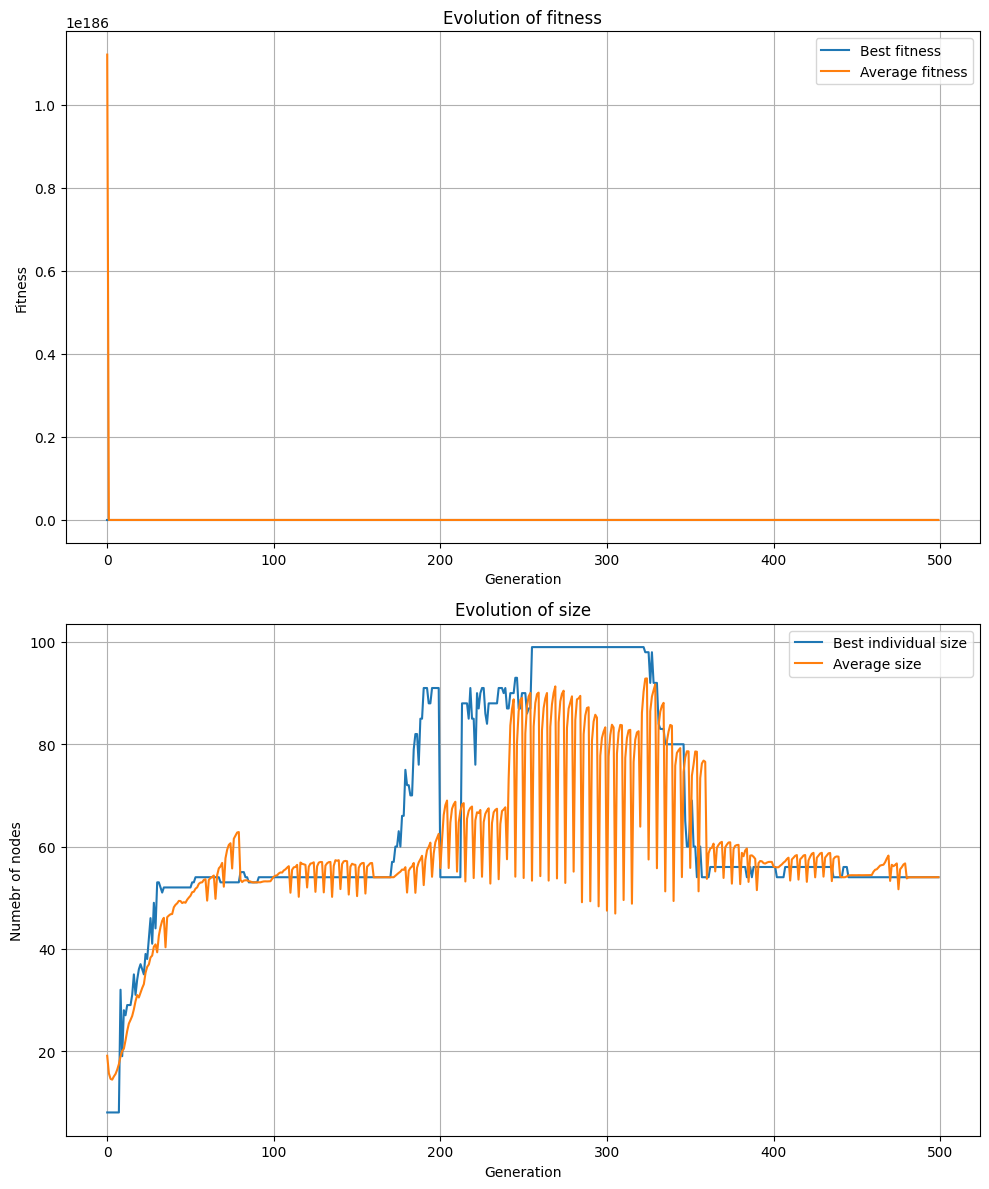

Original expression: ((((((x[2] * sin(1.184037735453649)) - (x[2] - sqrt(cos(1.2158401721189076)))) - log(sqrt(cos(108.78615012548357)))) - (cos(log(((x[2] - 2.674670908359565) - 2.6590687466126757))) - sqrt(((x[2] - sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))
Simplified expression: x[2] * sin(1.184037735453649) - (x[2] - sqrt(cos(1.2158401721189076) - log(sqrt(cos(108.78615012548357))) - (cos(log(x[2] - 2.674670908359565) - 2.6590687466126757) - sqrt(x[2] - sqrtx[2] - 3.17864466323484))) + (x[0] * x[0]) - (x[2] - sin(108.78615012548357) - x[2]) + (x[0] * x[0]) - x[2]) - (x[1] * x[1]) * x[1]
Best fitness(MSE): 0.010529857078380717


In [50]:
print(f"\n=== GP execution on {problems[3]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[3]['file_path'], 
    problems[3]['config'],
    function_weights=problems[3]['config'].get('function_weights'),
    terminal_weights=problems[3]['config'].get('terminal_weights'),
    use_islands=problems[3].get('use_islands', False),
    n_islands=problems[3].get('n_islands', 5),
    migration_interval=problems[3].get('migration_interval', 10),
    migration_rate=problems[3].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_4.npz ===
Loading data from ../data/problem_4.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples

GP execution on ../data/problem_4.npz...
Prima di qualsiasi elaborazione:
X shape: (5000, 2), y shape: (5000,)
X mean: -0.008310348769392621, y mean: 1.9997861267141543
X std: 2.8715662440518113, y std: 4.649946409222459
X range: [-4.999705785571271, 4.999534886222849], y range: [-4.158487374107485, 10.701637922762112]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  

C:\Users\domen\AppData\Local\Temp\ipykernel_20100\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 16.400790274520276 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 15.844347272153694 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 16.42909949016379 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 18.140472204535904 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 17.66213049235022 | Mutation Strength: 0.90
Bloat control: 11 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size


  0%|          | 1/500 [02:37<21:50:31, 157.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (tan(sqrt((cos(((1.5966748916524427 + x[1]) * log(x[0]))) - sin(x[0])))) - log((sin(log(sqrt(x[1]))) * x[1])))
  Simplified Expression: -log(x[1]*sin(log(sqrt(x[1])))) + tan(sqrt(-sin(x[0]) + cos((x[1] + 1.5966748916524427)*log(x[0]))))
  Fitness: 15.844347272153694
  Complexity: 20 nodes
Generation 0, Best Fitness: 15.844347272153694


  1%|          | 3/500 [05:18<13:29:16, 97.70s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (tan(sqrt((cos(sin(1.5966748916524427)) - sin(x[0])))) - log((sin(log(sqrt(log((x[1] + 2.1767350446132028))))) * x[1])))
  Simplified Expression: -log(x[1]*sin(log(sqrt(log(x[1] + 2.1767350446132028))))) + tan(sqrt(0.54058402646046645 - sin(x[0])))
  Fitness: 14.454490596428572
  Complexity: 19 nodes


  1%|          | 4/500 [06:40<12:36:18, 91.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (2.1793807099676528 + (sin(cos(x[1])) * ((cos(x[1]) + 2.1793807099676528) + (2.1793807099676528 + 2.1793807099676528))))
  Simplified Expression: (cos(x[1]) + 6.5381421299029584)*sin(cos(x[1])) + 2.1793807099676528
  Fitness: 12.128440419174225
  Complexity: 14 nodes


  1%|          | 5/500 [08:02<12:08:00, 88.24s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (tan(cos(x[1])) + ((sqrt(2.816449848044543) + (sqrt(2.718281828459045) + (cos(x[1]) / tan((1.9561569458203252 / 9.302675732490924))))) + tan(cos(x[1]))))
  Simplified Expression: 4.6852871281330074*cos(x[1]) + 2*tan(cos(x[1])) + 3.326949457820266
  Fitness: 2.063039030746344
  Complexity: 21 nodes


  1%|          | 6/500 [09:39<12:29:32, 91.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(-9.819212888557145) + (sqrt(-9.819212888557145) * cos(x[1]))) + (sqrt(-9.819212888557145) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-9.819212888557145) + (sqrt(-9.819212888557145) * cosx[1]) + (sqrt(-9.819212888557145) * cosx[1]))
  Fitness: 1.381654759693904
  Complexity: 17 nodes


  1%|▏         | 7/500 [11:03<12:09:29, 88.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(2.816449848044543) + (sqrt(2.718281828459045) + (cos(x[1]) / tan(tan((1.9561569458203252 / 9.302675732490924)))))) + tan(cos(x[1]))))
  Simplified Expression: 5.6139254271781206*cos(x[1]) + tan(cos(x[1])) + 3.326949457820266
  Fitness: 0.8194962130316867
  Complexity: 21 nodes


  2%|▏         | 8/500 [12:28<11:58:38, 87.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(2.718281828459045) + (sqrt(2.718281828459045) + (cos(x[1]) / tan(tan((1.9561569458203252 / 9.302675732490924)))))) + tan(cos(x[1]))))
  Simplified Expression: 5.6139254271781206*cos(x[1]) + tan(cos(x[1])) + 3.297442541400256
  Fitness: 0.796318766429968
  Complexity: 21 nodes


  2%|▏         | 9/500 [13:52<11:48:48, 86.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (tan(cos(x[1])) + ((sqrt(2.718281828459045) + (sqrt(2.718281828459045) + (cos(x[1]) / tan(tan((1.9561569458203252 / 9.302675732490924)))))) + cos(x[1])))
  Simplified Expression: 5.6139254271781206*cos(x[1]) + tan(cos(x[1])) + 3.297442541400256
  Fitness: 0.7963187664299678
  Complexity: 21 nodes


  2%|▏         | 10/500 [15:17<11:41:55, 85.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.3442301611642993) + sqrt(cos(cos((2.3442301611642993 + 2.1793807099676528))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.3442301611642993) + sqrt(cos(cos(2.3442301611642993 + 2.1793807099676528)) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.7174379509478364
  Complexity: 20 nodes


  2%|▏         | 11/500 [17:34<13:47:48, 101.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt((cos(sqrt(2.1793807099676528)) + 2.1793807099676528))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(cos(sqrt(2.1793807099676528) + 2.1793807099676528))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.69312767063888
  Complexity: 22 nodes
Generation 10, Best Fitness: 0.69312767063888


  3%|▎         | 13/500 [20:22<12:32:09, 92.67s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt((cos(7.772264684449484) + 2.1793807099676528))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(cos(7.772264684449484) + 2.1793807099676528)) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.6931114583142468
  Complexity: 21 nodes


  3%|▎         | 15/500 [23:12<11:56:08, 88.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt((x[0] - log(-5.500122909580269)))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - log(-5.500122909580269))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.461077484305688
  Complexity: 21 nodes


  3%|▎         | 16/500 [25:39<14:17:33, 106.31s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt((x[0] - log(7.772264684449484)))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - log(7.772264684449484))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.39525726177108594
  Complexity: 21 nodes


  3%|▎         | 17/500 [27:04<13:23:45, 99.85s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt(((x[0] - log(7.772264684449484)) - log(-5.500122909580269)))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - log(7.772264684449484) - log(-5.500122909580269))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.21502857725167407
  Complexity: 24 nodes


  4%|▎         | 18/500 [28:29<12:46:50, 95.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt(((x[0] - log(-5.500122909580269)) - 2.1793807099676528))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - log(-5.500122909580269) - 2.1793807099676528)) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.21215420252974806
  Complexity: 23 nodes


  4%|▍         | 20/500 [31:20<12:02:10, 90.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt(((x[0] - 2.1793807099676528) - log(-5.621375682947979)))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - 2.1793807099676528) - log(-5.621375682947979)) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.21153056563166578
  Complexity: 23 nodes


  4%|▍         | 21/500 [34:07<15:05:17, 113.40s/it]

Generation 20, Best Fitness: 0.21153056563166578


  5%|▌         | 27/500 [43:56<13:46:30, 104.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt(((x[0] - 2.1793807099676528) - log((x[0] + x[0]))))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - 2.1793807099676528) - log(x[0] + x[0])) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.16831621164386176
  Complexity: 25 nodes


  6%|▌         | 31/500 [51:05<15:07:52, 116.15s/it]

Generation 30, Best Fitness: 0.16831621164386176


  8%|▊         | 39/500 [1:04:03<12:25:22, 97.01s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.003
  Island 3 diversity: 0.003
  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.01)


  8%|▊         | 40/500 [1:05:30<12:01:59, 94.17s/it]

  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


  8%|▊         | 41/500 [1:07:56<13:57:51, 109.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt(((x[0] - 2.1793807099676528) - sqrt(x[0])))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt(sqrt(x[0] - 2.1793807099676528) - sqrtx[0]) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.1582046285193558
  Complexity: 23 nodes
Generation 40, Best Fitness: 0.1582046285193558


  9%|▊         | 43/500 [1:10:43<12:13:17, 96.28s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(sqrt(sqrt(((x[0] - sqrt(x[0])) - sqrt(x[0])))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(sqrt0.0 - sqrtx[0])) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.14311896125479787
  Complexity: 24 nodes


  9%|▉         | 46/500 [1:15:59<13:32:35, 107.39s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(tan(sqrt(((x[0] - 2.1793807099676528) - sqrt(exp(7.772264684449484))))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(tan(sqrt(x[0] - 2.1793807099676528) - sqrt(exp(7.772264684449484))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.02336609607079163
  Complexity: 24 nodes


 10%|▉         | 49/500 [1:20:08<11:27:41, 91.49s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1793807099676528) + sqrt(tan(sqrt(((x[0] - 2.1822381010178167) - sqrt(exp(7.772264684449484))))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1793807099676528) + sqrt(tan(sqrt(x[0] - 2.1822381010178167) - sqrt(exp(7.772264684449484))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.023293526638371975
  Complexity: 24 nodes


 10%|█         | 51/500 [1:23:55<13:08:12, 105.33s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((cos(x[1]) + 2.1822381010178167) + sqrt(tan(sqrt(((x[0] - 2.1822381010178167) - sqrt(exp(7.772264684449484))))))) + (cos(x[1]) * sqrt(tan(sqrt(exp(7.772264684449484))))))
  Simplified Expression: cosx[1] + 2.1822381010178167) + sqrt(tan(sqrt(x[0] - 2.1822381010178167) - sqrt(exp(7.772264684449484))) + (cosx[1] * sqrt(tan(sqrt(exp(7.772264684449484)))))
  Fitness: 0.022763990474887714
  Complexity: 24 nodes
Generation 50, Best Fitness: 0.022763990474887714


 12%|█▏        | 59/500 [1:36:17<11:18:13, 92.28s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.54084691237368 + (x[0] * exp(-1.0))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.875065259371541) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.54084691237368 + (x[0] * exp(-1.0) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.875065259371541) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.0198131140761189
  Complexity: 30 nodes


 12%|█▏        | 61/500 [1:40:35<14:02:25, 115.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.542850778664805 + (x[0] * exp(-1.0))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.875065259371541) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.542850778664805 + (x[0] * exp(-1.0) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.875065259371541) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.019552534301501678
  Complexity: 30 nodes
Generation 60, Best Fitness: 0.019552534301501678


 12%|█▏        | 62/500 [1:42:05<13:04:56, 107.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.54084691237368 + (x[0] * exp(-1.0))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.761178781211721) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.54084691237368 + (x[0] * exp(-1.0) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.761178781211721) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.018454289451990704
  Complexity: 30 nodes


 13%|█▎        | 64/500 [1:44:53<11:34:14, 95.54s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.542850778664805 + (x[0] * exp(-1.0))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.761178781211721) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.542850778664805 + (x[0] * exp(-1.0) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.761178781211721) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.018216856267897315
  Complexity: 30 nodes


 14%|█▍        | 69/500 [1:53:08<11:12:40, 93.64s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt((-10.633898403550127 + (x[0] / (log(-2.0826264741613585) + 1.0)))) + (sqrt(7.678610786211274) * cos(x[1]))) + (sqrt(-10.56567709503394) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.633898403550127 + (x[0] / (log(-2.0826264741613585) + 1.0)) + (sqrt(7.678610786211274) * cosx[1])) + (sqrt(-10.56567709503394) * cosx[1]))
  Fitness: 0.013792454002213756
  Complexity: 24 nodes


 14%|█▍        | 71/500 [1:57:33<14:00:34, 117.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt((-10.633898403550127 + (x[0] / (log(-2.0826264741613585) + 1.0)))) + (sqrt(7.678610786211274) * cos(x[1]))) + (sqrt(-10.214906716454694) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.633898403550127 + (x[0] / (log(-2.0826264741613585) + 1.0)) + (sqrt(7.678610786211274) * cosx[1])) + (sqrt(-10.214906716454694) * cosx[1]))
  Fitness: 0.010857897565707974
  Complexity: 24 nodes
Generation 70, Best Fitness: 0.010857897565707974


 14%|█▍        | 72/500 [1:58:57<12:47:21, 107.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.658534965630677 + (x[0] * exp(-1.0))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.761178781211721) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.658534965630677 + (x[0] * exp(-1.0) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.761178781211721) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.007839863073923552
  Complexity: 30 nodes


 15%|█▍        | 74/500 [2:01:47<11:21:45, 96.02s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.658534965630677 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.761178781211721) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.658534965630677 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.761178781211721) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.00721758736166258
  Complexity: 30 nodes


 16%|█▌        | 79/500 [2:10:13<11:07:33, 95.14s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.005
  Island 2 diversity: 0.005
  Island 3 diversity: 0.003
  Island 4 diversity: 0.004
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 0.50)


 16%|█▌        | 80/500 [2:11:39<10:47:21, 92.48s/it]

  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.01)


 16%|█▌        | 81/500 [2:14:21<13:11:35, 113.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.658534965630677 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.772264684449484) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.658534965630677 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.772264684449484) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.007049340921043328
  Complexity: 30 nodes
Generation 80, Best Fitness: 0.007049340921043328


 16%|█▋        | 82/500 [2:15:47<12:12:28, 105.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.658534965630677 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.81302094073604) * cos(x[1]))) + (sqrt(-10.20251412794561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.658534965630677 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.81302094073604) * cosx[1])) + (sqrt(-10.20251412794561) * cosx[1]))
  Fitness: 0.0067529905024119735
  Complexity: 30 nodes


 17%|█▋        | 84/500 [2:18:38<10:58:53, 95.03s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.658534965630677 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.761178781211721) * cos(x[1]))) + (sqrt(-10.26914254003735) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.658534965630677 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.761178781211721) * cosx[1])) + (sqrt(-10.26914254003735) * cosx[1]))
  Fitness: 0.006752205778336406
  Complexity: 30 nodes


 17%|█▋        | 85/500 [2:20:02<10:35:05, 91.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.78822428421459 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.677432508205206) * cos(x[1]))) + (sqrt(-10.3689966919019) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.78822428421459 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.677432508205206) * cosx[1])) + (sqrt(-10.3689966919019) * cosx[1]))
  Fitness: 0.0013553731364313807
  Complexity: 30 nodes


 17%|█▋        | 87/500 [2:24:13<12:03:40, 105.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.78822428421459 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-0.990230745607057)))) + (sqrt(7.677432508205206) * cos(x[1]))) + (sqrt(-10.3689966919019) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.78822428421459 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-0.990230745607057))) + (sqrt(7.677432508205206) * cosx[1])) + (sqrt(-10.3689966919019) * cosx[1]))
  Fitness: 0.0013472821924896553
  Complexity: 30 nodes


 18%|█▊        | 91/500 [2:31:06<12:41:37, 111.73s/it]

Generation 90, Best Fitness: 0.0013472821924896553


 18%|█▊        | 92/500 [2:32:31<11:44:57, 103.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.78822428421459 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0)) * exp(-0.990230745607057)))) + (sqrt(7.354575943244114) * cos(x[1]))) + (sqrt(-10.78822428421459) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.78822428421459 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.0) * exp(-0.990230745607057))) + (sqrt(7.354575943244114) * cosx[1])) + (sqrt(-10.78822428421459) * cosx[1]))
  Fitness: 0.0011395736041390956
  Complexity: 30 nodes


 19%|█▉        | 97/500 [2:40:58<11:48:16, 105.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.800399289306132 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-1.0041688683539096)) * exp(-1.0041688683539096)))) + (sqrt(7.772264684449484) * cos(x[1]))) + (sqrt(-10.286411858005346) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.800399289306132 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-1.041688683539096) * exp(-1.041688683539096))) + (sqrt(7.772264684449484) * cosx[1])) + (sqrt(-10.286411858005346) * cosx[1]))
  Fitness: 0.0010792377513261522
  Complexity: 30 nodes


 20%|██        | 100/500 [2:45:13<10:13:51, 92.08s/it]

Island 0 | Generation 100 | Best Fitness: 0.001046933782812066 | Mutation Strength: 2.26
Island 1 | Generation 100 | Best Fitness: 0.001028360572992798 | Mutation Strength: 2.36
Island 2 | Generation 100 | Best Fitness: 0.0012028690529509176 | Mutation Strength: 2.88
Island 3 | Generation 100 | Best Fitness: 0.0011394621029097052 | Mutation Strength: 2.97
Island 4 | Generation 100 | Best Fitness: 0.0015901388176676823 | Mutation Strength: 3.00


 20%|██        | 101/500 [2:48:11<13:03:11, 117.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.848099711880545 + (x[0] * exp(-0.9488458522377683))) + ((x[0] * cos(-1.0)) * exp(-0.9488458522377683)))) + (sqrt(7.880449859474959) * cos(x[1]))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.848099711880545 + (x[0] * exp(-0.9488458522377683) + (x[0] * cos(-1.0) * exp(-0.9488458522377683))) + (sqrt(7.880449859474959) * cosx[1])) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.001028360572992798
  Complexity: 30 nodes
Generation 100, Best Fitness: 0.001028360572992798


 22%|██▏       | 109/500 [3:00:57<10:24:28, 95.83s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.840747569726288 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.990230745607057)) * exp(-0.990230745607057)))) + (sqrt(7.354575943244114) * cos(x[1]))) + (sqrt(-10.840747569726288) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.840747569726288 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.990230745607057) * exp(-0.990230745607057))) + (sqrt(7.354575943244114) * cosx[1])) + (sqrt(-10.840747569726288) * cosx[1]))
  Fitness: 0.0010191376928924917
  Complexity: 30 nodes


 22%|██▏       | 111/500 [3:05:21<12:49:39, 118.71s/it]

Generation 110, Best Fitness: 0.0010191376928924917


 24%|██▎       | 118/500 [3:16:44<10:41:05, 100.70s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.817114878895328 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.996586417453536)) * exp(-1.0)))) + (sqrt(7.772264684449484) * cos(x[1]))) + (sqrt(-10.335762217985561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.817114878895328 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.996586417453536) * exp(-1.0))) + (sqrt(7.772264684449484) * cosx[1])) + (sqrt(-10.335762217985561) * cosx[1]))
  Fitness: 0.0009545779551981164
  Complexity: 30 nodes


 24%|██▍       | 119/500 [3:18:09<10:10:24, 96.13s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.005
  Island 2 diversity: 0.005
  Island 3 diversity: 0.006
  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)


 24%|██▍       | 120/500 [3:19:37<9:52:38, 93.58s/it] 

  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 24%|██▍       | 121/500 [3:22:28<12:17:21, 116.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.817114878895328 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.996586417453536)) * exp(-0.996586417453536)))) + (sqrt(7.772264684449484) * cos(x[1]))) + (sqrt(-10.335762217985561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.817114878895328 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.996586417453536) * exp(-0.996586417453536))) + (sqrt(7.772264684449484) * cosx[1])) + (sqrt(-10.335762217985561) * cosx[1]))
  Fitness: 0.0009492910407770819
  Complexity: 30 nodes
Generation 120, Best Fitness: 0.0009492910407770819


 24%|██▍       | 122/500 [3:23:53<11:14:59, 107.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.817114878895328 + (x[0] * exp(-0.931417839815496))) + ((x[0] * cos(-0.996586417453536)) * exp(-1.0)))) + (sqrt(7.772264684449484) * cos(x[1]))) + (sqrt(-10.335762217985561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.817114878895328 + (x[0] * exp(-0.931417839815496) + (x[0] * cos(-0.996586417453536) * exp(-1.0))) + (sqrt(7.772264684449484) * cosx[1])) + (sqrt(-10.335762217985561) * cosx[1]))
  Fitness: 0.0009453544162125575
  Complexity: 30 nodes


 25%|██▍       | 124/500 [3:26:42<10:00:20, 95.80s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.817114878895328 + (x[0] * exp(-0.931417839815496))) + ((x[0] * cos(-1.0)) * exp(-1.0)))) + (sqrt(7.772264684449484) * cos(x[1]))) + (sqrt(-10.335762217985561) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.817114878895328 + (x[0] * exp(-0.931417839815496) + (x[0] * cos(-1.0) * exp(-1.0))) + (sqrt(7.772264684449484) * cosx[1])) + (sqrt(-10.335762217985561) * cosx[1]))
  Fitness: 0.0009444427723731694
  Complexity: 30 nodes


 25%|██▌       | 125/500 [3:28:07<9:38:21, 92.54s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.827942569897344 + (x[0] * exp(-0.9488458522377683))) + ((x[0] * cos(-1.0075009905907408)) * exp(-0.9488458522377683)))) + (sqrt(7.875943538145375) * cos(x[1]))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.827942569897344 + (x[0] * exp(-0.9488458522377683) + (x[0] * cos(-1.075009905907408) * exp(-0.9488458522377683))) + (sqrt(7.875943538145375) * cosx[1])) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008924600810691699
  Complexity: 30 nodes


 26%|██▌       | 131/500 [3:39:58<12:46:05, 124.57s/it]

Generation 130, Best Fitness: 0.0008924600810691699


 28%|██▊       | 138/500 [3:51:55<10:38:50, 105.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.827942569897344 + (x[0] * exp(-0.9488458522377683))) + ((x[0] * cos(-1.0075009905907408)) * exp(-0.9488458522377683)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.827942569897344 + (x[0] * exp(-0.9488458522377683) + (x[0] * cos(-1.075009905907408) * exp(-0.9488458522377683))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008873902098575027
  Complexity: 30 nodes


 28%|██▊       | 141/500 [3:58:10<12:45:01, 127.86s/it]

Generation 140, Best Fitness: 0.0008873902098575027


 29%|██▉       | 145/500 [4:03:52<9:25:55, 95.65s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.827942569897344 + (x[0] * exp(-0.9488458522377683))) + ((x[0] * cos(-1.0075009905907408)) * exp(-0.9502072325573451)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.827942569897344 + (x[0] * exp(-0.9488458522377683) + (x[0] * cos(-1.075009905907408) * exp(-0.9502072325573451))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008873321318351363
  Complexity: 30 nodes


 30%|███       | 151/500 [4:16:22<12:20:04, 127.23s/it]

Generation 150, Best Fitness: 0.0008873321318351363


 32%|███▏      | 159/500 [4:29:45<9:29:21, 100.18s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.003
  Island 3 diversity: 0.004
  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.00)


 32%|███▏      | 160/500 [4:31:12<9:05:20, 96.24s/it] 

  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 32%|███▏      | 161/500 [4:33:49<10:46:31, 114.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.9932744488059729)) * exp(-0.9916749730176175)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.9932744488059729) * exp(-0.9916749730176175))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008821344263886976
  Complexity: 30 nodes
Generation 160, Best Fitness: 0.0008821344263886976


 34%|███▍      | 171/500 [4:51:37<11:17:51, 123.62s/it]

Generation 170, Best Fitness: 0.0008821344263886976


 36%|███▌      | 181/500 [5:09:31<11:10:10, 126.05s/it]

Generation 180, Best Fitness: 0.0008821344263886976


 38%|███▊      | 189/500 [5:23:26<8:55:50, 103.38s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008821270109443623
  Complexity: 30 nodes


 38%|███▊      | 191/500 [5:28:17<11:08:48, 129.87s/it]

Generation 190, Best Fitness: 0.0008821270109443623


 40%|███▉      | 199/500 [5:42:07<8:41:12, 103.90s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.007
  Island 2 diversity: 0.005
  Island 3 diversity: 0.004
  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.01)


 40%|████      | 200/500 [5:43:38<8:20:18, 100.06s/it]

  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 200 | Best Fitness: 0.0008821270109443623 | Mutation Strength: 2.70
Island 1 | Generation 200 | Best Fitness: 0.0008873165762919813 | Mutation Strength: 2.70
Island 2 | Generation 200 | Best Fitness: 0.0008872785512504915 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 0.0008819969915774342 | Mutation Strength: 2.70
Island 4 | Generation 200 | Best Fitness: 0.0008821270109443623 | Mutation Strength: 2.70


 40%|████      | 201/500 [5:46:51<10:37:03, 127.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.19880825873766) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.19880825873766) * cosx[1]))
  Fitness: 0.0008819969915774342
  Complexity: 30 nodes
Generation 200, Best Fitness: 0.0008819969915774342


 42%|████▏     | 211/500 [6:10:39<14:06:25, 175.73s/it]

Generation 210, Best Fitness: 0.0008819969915774342


 44%|████▍     | 221/500 [6:35:36<13:20:16, 172.10s/it]

Generation 220, Best Fitness: 0.0008819969915774342


 46%|████▌     | 231/500 [7:01:57<13:54:44, 186.19s/it]

Generation 230, Best Fitness: 0.0008819969915774342


 47%|████▋     | 234/500 [7:07:51<10:27:09, 141.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.19880825873766) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.19880825873766) * cosx[1]))
  Fitness: 0.000881985026889328
  Complexity: 30 nodes


 48%|████▊     | 239/500 [7:19:09<9:18:52, 128.48s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.003
  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 48%|████▊     | 241/500 [7:25:29<11:53:25, 165.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(5.289537397851177)) * exp(-0.9916749730176175)))) + (sqrt(7.871174350285515) * cos(x[1]))) + (sqrt(-10.19880825873766) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(5.289537397851177) * exp(-0.9916749730176175))) + (sqrt(7.871174350285515) * cosx[1])) + (sqrt(-10.19880825873766) * cosx[1]))
  Fitness: 0.0008819843917271722
  Complexity: 30 nodes
Generation 240, Best Fitness: 0.0008819843917271722


 49%|████▉     | 247/500 [7:40:57<11:36:38, 165.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.873592159935219) * cos(x[1]))) + (sqrt(-10.19880825873766) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.873592159935219) * cosx[1])) + (sqrt(-10.19880825873766) * cosx[1]))
  Fitness: 0.0008807863418055981
  Complexity: 30 nodes


 50%|█████     | 251/500 [7:52:13<12:47:47, 185.01s/it]

Generation 250, Best Fitness: 0.0008807863418055981


 52%|█████▏    | 261/500 [8:18:36<11:58:42, 180.43s/it]

Generation 260, Best Fitness: 0.0008807863418055981


 54%|█████▍    | 271/500 [8:45:30<12:19:30, 193.76s/it]

Generation 270, Best Fitness: 0.0008807863418055981


 56%|█████▌    | 279/500 [9:05:19<9:13:49, 150.36s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.004
  Island 2 diversity: 0.005
  Island 3 diversity: 0.007
  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 56%|█████▌    | 281/500 [9:11:06<10:10:06, 167.15s/it]

Generation 280, Best Fitness: 0.0008807863418055981


 58%|█████▊    | 291/500 [9:37:00<10:19:44, 177.92s/it]

Generation 290, Best Fitness: 0.0008807863418055981


 59%|█████▉    | 296/500 [9:49:26<9:53:40, 174.61s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (cos(x[1]) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.873592159935219) * cos(log(exp(x[1]))))) + (sqrt(-10.19880825873766) * cos(x[1]))))
  Simplified Expression: cosx[1] + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.873592159935219) * cos(log(expx[1])))) + (sqrt(-10.19880825873766) * cosx[1]))
  Fitness: 0.0008807863418055979
  Complexity: 32 nodes


 60%|██████    | 300/500 [9:57:20<7:20:30, 132.15s/it]

Island 0 | Generation 300 | Best Fitness: 0.0008807863418055979 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 0.0008819843917271722 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 0.0008808028123628745 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 0.0008807863418055981 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 0.0008807863418055981 | Mutation Strength: 3.00


 60%|██████    | 301/500 [10:01:59<9:44:29, 176.23s/it]

Generation 300, Best Fitness: 0.0008807863418055979


 60%|██████    | 302/500 [10:04:00<8:47:15, 159.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(log(exp(x[1]))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.873592159935219) * cos(log(exp(x[1]))))) + (sqrt(-10.19880825873766) * cos(log(exp(x[1]))))))
  Simplified Expression: cos(log(expx[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.873592159935219) * cos(log(expx[1])))) + (sqrt(-10.19880825873766) * cos(log(expx[1]))))
  Fitness: 0.0008807863418055977
  Complexity: 36 nodes


 61%|██████    | 306/500 [10:14:33<9:28:32, 175.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(log(exp(x[1]))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.873592159935219) * cos(log(exp(x[1]))))) + (sqrt(-10.19880825873766) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(log(expx[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.873592159935219) * cos(log(expx[1])))) + (sqrt(-10.19880825873766) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008807863418055972
  Complexity: 38 nodes


 62%|██████▏   | 308/500 [10:18:22<7:43:28, 144.83s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos(log(exp(log(exp((0.0 - x[1])))))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sqrt(7.873592159935219) * cos(log(exp(x[1]))))) + (sqrt(-10.19880825873766) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(log(exp(log(exp(0.0 - x[1]))))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sqrt(7.873592159935219) * cos(log(expx[1])))) + (sqrt(-10.19880825873766) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008807863418055968
  Complexity: 42 nodes


 62%|██████▏   | 311/500 [10:26:48<9:07:15, 173.73s/it]

Generation 310, Best Fitness: 0.0008807863418055968


 64%|██████▍   | 319/500 [10:45:24<7:01:42, 139.79s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.006
  Island 2 diversity: 0.003
  Island 3 diversity: 0.005
  Island 4 diversity: 0.004
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)


 64%|██████▍   | 320/500 [10:47:25<6:42:49, 134.28s/it]

  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 64%|██████▍   | 321/500 [10:52:23<9:07:05, 183.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((sqrt(sin(sqrt(sin(3.141592653589793)))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9390891672051065))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(x[1])))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cos(sqrt(sin(sqrt(sin(3.141592653589793))) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9390891672051065) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cosx[1]))) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008807324319051455
  Complexity: 39 nodes
Generation 320, Best Fitness: 0.0008807324319051455


 65%|██████▍   | 323/500 [10:56:25<7:27:37, 151.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((sqrt(sin(sqrt(sin(3.141592653589793)))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(x[1])))) + (sqrt(-10.205488998391495) * cos(x[1]))))
  Simplified Expression: cos(sqrt(sin(sqrt(sin(3.141592653589793))) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cosx[1]))) + (sqrt(-10.205488998391495) * cosx[1]))
  Fitness: 0.0008807228303396846
  Complexity: 39 nodes


 66%|██████▌   | 331/500 [11:19:38<9:12:11, 196.05s/it]

Generation 330, Best Fitness: 0.0008807228303396846


 68%|██████▊   | 341/500 [11:46:24<8:35:59, 194.71s/it]

Generation 340, Best Fitness: 0.0008807228303396846


 70%|███████   | 351/500 [12:13:14<8:02:50, 194.43s/it]

Generation 350, Best Fitness: 0.0008807228303396846


 72%|███████▏  | 359/500 [12:33:14<5:51:46, 149.69s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.006
  Island 2 diversity: 0.004
  Island 3 diversity: 0.007
  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.00)


 72%|███████▏  | 361/500 [12:40:45<7:37:02, 197.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((sqrt(sin(sqrt(sin(3.141592653589793)))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(sqrt(sin(sqrt(sin(3.141592653589793))) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cosx[1]))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008807228303396841
  Complexity: 43 nodes
Generation 360, Best Fitness: 0.0008807228303396841


 74%|███████▍  | 371/500 [13:08:13<7:06:59, 198.60s/it]

Generation 370, Best Fitness: 0.0008807228303396841


 76%|███████▌  | 380/500 [13:29:53<4:37:57, 138.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((sqrt(sin(sqrt(sin(3.141592653589793)))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(sqrt(sin(sqrt(sin(3.141592653589793))) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008807228303396835
  Complexity: 46 nodes


 76%|███████▌  | 381/500 [13:35:25<6:30:15, 196.77s/it]

Generation 380, Best Fitness: 0.0008807228303396835


 78%|███████▊  | 391/500 [14:04:50<6:21:06, 209.79s/it]

Generation 390, Best Fitness: 0.0008807228303396835


 80%|███████▉  | 399/500 [14:25:47<4:32:24, 161.83s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.003
  Island 3 diversity: 0.004
  Island 4 diversity: 0.009
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 80%|████████  | 400/500 [14:28:11<4:20:33, 156.34s/it]

Island 0 | Generation 400 | Best Fitness: 0.0008807228303396835 | Mutation Strength: 2.70
Island 1 | Generation 400 | Best Fitness: 0.0008807228303396841 | Mutation Strength: 2.70
Island 2 | Generation 400 | Best Fitness: 0.0008807228303396841 | Mutation Strength: 2.70
Island 3 | Generation 400 | Best Fitness: 0.0008807228303396835 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 0.0008807228303396835 | Mutation Strength: 2.70


 80%|████████  | 401/500 [14:33:41<5:43:53, 208.42s/it]

Generation 400, Best Fitness: 0.0008807228303396835


 82%|████████▏ | 411/500 [15:02:28<5:13:38, 211.44s/it]

Generation 410, Best Fitness: 0.0008807228303396835


 84%|████████▍ | 421/500 [15:31:38<4:43:53, 215.61s/it]

Generation 420, Best Fitness: 0.0008807228303396835


 86%|████████▌ | 428/500 [15:50:14<3:20:49, 167.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp(-9.336646872820028) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-9.336646872820028) + x[1]) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008807205163797224
  Complexity: 43 nodes


 86%|████████▌ | 430/500 [15:54:22<2:49:15, 145.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.822240096384276 + (x[0] * exp(-0.9389320220663313)))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.822240096384276 + (x[0] * exp(-0.9389320220663313)) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.000880691271583846
  Complexity: 48 nodes


 86%|████████▌ | 431/500 [15:59:59<3:53:07, 202.72s/it]

Generation 430, Best Fitness: 0.000880691271583846


 86%|████████▋ | 432/500 [16:01:31<3:12:08, 169.54s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 + (x[0] * exp(-0.9389320220663313)))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 + (x[0] * exp(-0.9389320220663313)) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008806553577543918
  Complexity: 48 nodes


 87%|████████▋ | 433/500 [16:03:04<2:43:31, 146.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.822240096384276 + (x[0] * cos(tan(x[1]))))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.822240096384276 + (x[0] * cos(tanx[1])) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008805253130100947
  Complexity: 49 nodes


 87%|████████▋ | 435/500 [16:06:11<2:09:35, 119.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.822240096384276 + (x[0] * cos((6.003077065009192 + x[1]))))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.822240096384276 + (x[0] * cos(6.003077065009192 + x[1])) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008791060027280003
  Complexity: 50 nodes


 87%|████████▋ | 437/500 [16:12:16<2:30:57, 143.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.822240096384276 + (cos((x[0] + x[1])) - x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.822240096384276 + (cos(x[0] + x[1]) - x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008526811546202824
  Complexity: 50 nodes


 88%|████████▊ | 439/500 [16:15:24<2:00:11, 118.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.822240096384276 + (cos((7.871174350285515 + x[1])) - x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.822240096384276 + (cos(7.871174350285515 + x[1]) - x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008514405184276341
  Complexity: 50 nodes
Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.005
  Island 2 divers

 88%|████████▊ | 440/500 [16:17:00<1:51:44, 111.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 + (cos((x[0] + x[1])) - x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 + (cos(x[0] + x[1]) - x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008386026097016269
  Complexity: 50 nodes


 88%|████████▊ | 441/500 [16:20:15<2:14:24, 136.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 - (cos((x[0] + x[1])) - x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9937057595157799)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 - (cos(x[0] + x[1]) - x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9937057595157799) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008318255140675972
  Complexity: 50 nodes
Generation 440, Best Fitness: 0.0008318255140675972


 89%|████████▊ | 443/500 [16:24:08<1:59:00, 125.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 - (cos((x[0] + x[1])) - x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 - (cos(x[0] + x[1]) - x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008305487356187211
  Complexity: 50 nodes


 89%|████████▉ | 446/500 [16:32:47<2:33:27, 170.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.10854731407204 - (cos((x[0] + x[1])) - x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.10854731407204 - (cos(x[0] + x[1]) - x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008277190144157002
  Complexity: 50 nodes


 90%|████████▉ | 448/500 [16:38:42<2:29:59, 173.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 - (cos((x[0] + x[1])) - (sin(2.1767350446132028) + x[0])))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 - (cos(x[0] + x[1]) - (sin(2.1767350446132028) + x[0])) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008266355657642197
  Complexity: 53 nodes


 90%|█████████ | 450/500 [16:44:17<2:22:25, 170.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 - (cos((x[0] + x[1])) - (exp(-0.9389320220663313) + x[0])))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 - (cos(x[0] + x[1]) - (exp(-0.9389320220663313) + x[0])) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008210451550449922
  Complexity: 53 nodes


 90%|█████████ | 451/500 [16:50:54<3:14:56, 238.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 - (cos((x[0] + x[1])) - (cos(-0.9916749730176175) + x[0])))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((0.0 - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 - (cos(x[0] + x[1]) - (cos(-0.9916749730176175) + x[0])) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(0.0 - x[1])))))
  Fitness: 0.0008199189085382975
  Complexity: 53 nodes
Generation 450, Best Fitness: 0.0008199189085382975


 91%|█████████ | 453/500 [16:55:10<2:22:53, 182.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-10.205488998391495 - (cos((x[0] + x[1])) - (cos(-0.9916749730176175) + x[0])))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((sin(3.141592653589793) - x[1])))))))
  Simplified Expression: cos(exp(-10.205488998391495 - (cos(x[0] + x[1]) - (cos(-0.9916749730176175) + x[0])) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(sin(3.141592653589793) - x[1])))))
  Fitness: 0.0008199189085382954
  Complexity: 54 nodes


 91%|█████████ | 454/500 [16:57:19<2:07:40, 166.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-9.451895391986055 - (cos((x[0] + x[1])) * x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-9.451895391986055 - (cos(x[0] + x[1]) * x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793))))))
  Fitness: 0.000805880011186642
  Complexity: 51 nodes


 91%|█████████ | 456/500 [17:05:27<2:38:28, 216.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-9.451895391986055 - (cos((x[0] + x[1])) * x[0]))) + (x[1] + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-9.451895391986055 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793))))))
  Fitness: 0.0008058800111866416
  Complexity: 54 nodes


 91%|█████████▏| 457/500 [17:07:37<2:16:26, 190.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + x[1])) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + x[1])) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793))))))
  Fitness: 0.0007500141651341401
  Complexity: 51 nodes


 92%|█████████▏| 459/500 [17:12:00<1:49:19, 159.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (x[1] + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.873592159935219) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793))))))
  Fitness: 0.0007500141651341382
  Complexity: 54 nodes


 92%|█████████▏| 461/500 [17:20:45<2:25:47, 224.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (x[1] + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793))))))
  Fitness: 0.0007499594261115479
  Complexity: 54 nodes
Generation 460, Best Fitness: 0.00074995942611

 93%|█████████▎| 463/500 [17:25:05<1:48:38, 176.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (log(exp((x[1] + tan(3.141592653589793)))) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (log(exp(x[1] + tan(3.141592653589793))) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793))))))
  Fitness: 0.00074995942611154

 94%|█████████▎| 468/500 [17:40:02<1:32:47, 173.99s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(log(exp((x[1] + tan(3.141592653589793))))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(log(exp(x[1] + tan(3.141592653589793)))))

 94%|█████████▍| 470/500 [17:44:22<1:15:50, 151.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(((x[1] + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(x[1] + tan(3.14159265358

 94%|█████████▍| 471/500 [17:51:02<1:49:20, 226.23s/it]

Generation 470, Best Fitness: 0.0007499594261115405


 94%|█████████▍| 472/500 [17:53:11<1:31:55, 197.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9389320220663313))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9389320220663313) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * c

 95%|█████████▍| 473/500 [17:55:20<1:19:32, 176.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos(((x[1] + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * cos(x[1] + tan(3.14159265358

 95%|█████████▌| 475/500 [17:59:43<1:03:58, 153.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + (((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.141592653589793) - x[1])))) + (sqrt(-10.205488998391495) * c

 95%|█████████▌| 477/500 [18:07:24<1:10:28, 183.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((sin(3.141592653589793) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(sin(3.14159265

 96%|█████████▌| 479/500 [18:11:45<54:49, 156.66s/it]  

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.006
  Island 4 diversity: 0.002
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.01)


 96%|█████████▌| 481/500 [18:20:12<1:08:39, 216.83s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-8.889367362661927) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-8.889367

 96%|█████████▋| 482/500 [18:22:25<57:30, 191.67s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.535834551386934 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-8.23509920982603) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.535834551386934 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-8.2350992

 97%|█████████▋| 485/500 [18:29:07<38:29, 153.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.154633949823262 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-8.23509920982603) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.154633949823262 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-8.2350992

 97%|█████████▋| 486/500 [18:36:39<56:46, 243.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-8.23509920982603) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-8.235099209

 98%|█████████▊| 488/500 [18:41:00<37:08, 185.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.154633949823262 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-8.23509920982603) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.23509920982603) - x[1]) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.154633949823262 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-8.2350992

 98%|█████████▊| 489/500 [18:43:13<31:09, 169.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-8.23509920982603) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.23509920982603) - x[1]) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-8.235099209

 98%|█████████▊| 491/500 [18:53:09<37:28, 249.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-7.795847756522948) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.23509920982603) - x[1]) + tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-7.79584775

 99%|█████████▉| 494/500 [18:59:46<17:16, 172.70s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-7.795847756522948) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.23509920982603) - x[1]) - tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-7.79584775

 99%|█████████▉| 495/500 [19:01:57<13:20, 160.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-7.795847756522948) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.36973460432399) - x[1]) - tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-7.79584775

 99%|█████████▉| 497/500 [19:11:33<10:33, 211.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) - tan(3.141592653589793)))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-7.795847756522948) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.36973460432399) - x[1]) - tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) - tan(3.141592653589793)))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-7.79584775

100%|█████████▉| 499/500 [19:15:52<02:49, 169.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) - tan(exp(-10.613659135997567))))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-7.795847756522948) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.36973460432399) - x[1]) - tan(3.141592653589793)) + tan(3.141592653589793))))))
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) - tan(exp(-10.613659135997567))))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(e

100%|██████████| 500/500 [19:18:02<00:00, 138.96s/it]

Generation 499, Best Fitness: 0.000729620567819449
Algorithm completed in 69862.04 seconds
Best solution found:
  Simplified Expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) - tan(exp(-10.613659135997567))))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-7.795847756522948) - x[1])))) + (sqrt(-10.205488998391495) * cos(exp(-8.36973460432399) - x[1]) - tan(3.141592653589793) + tan(3.141592653589793)))
  Expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) - tan(exp(-10.613659135997567))))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350

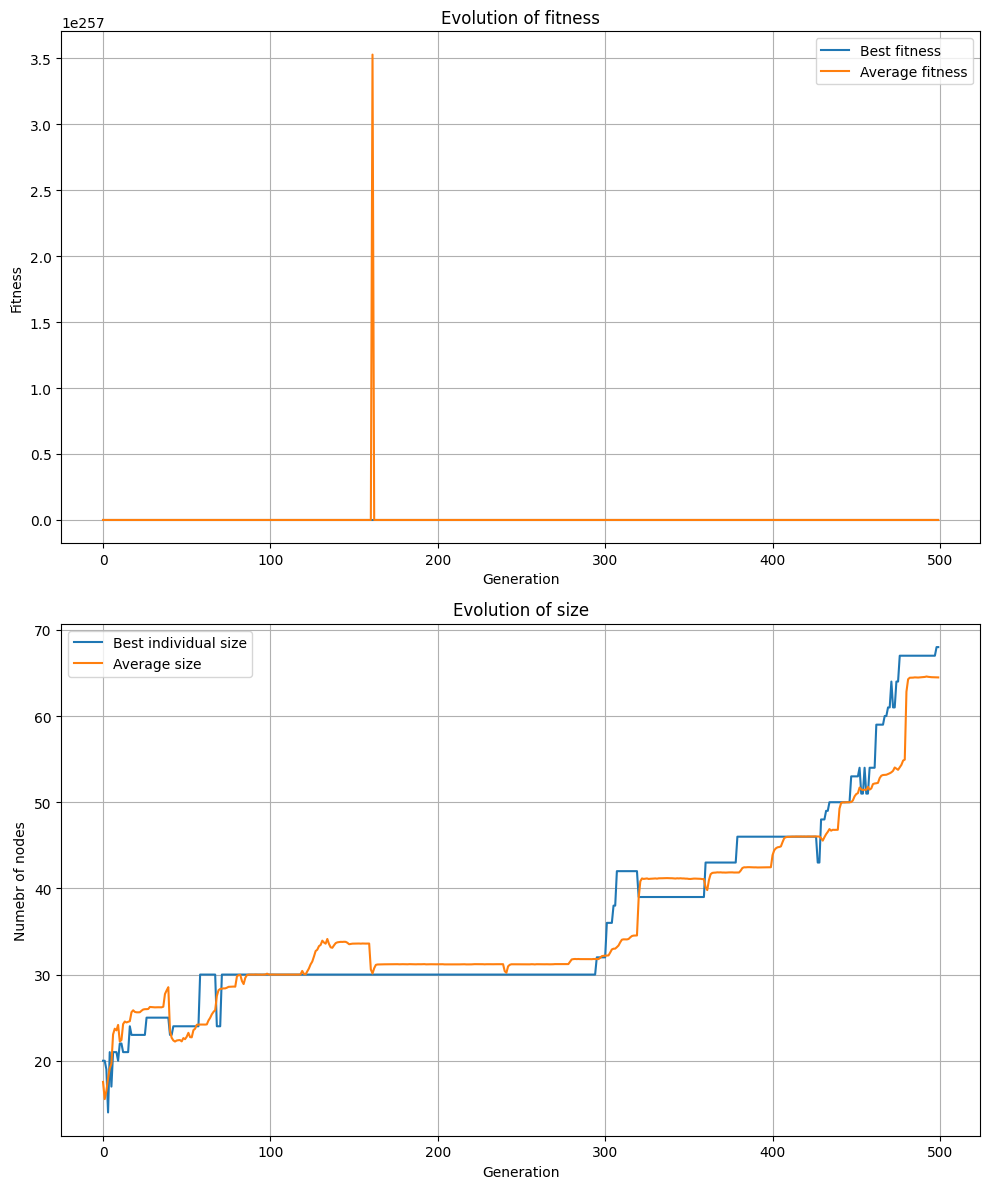

Original expression: (cos((exp((-8.23509920982603 - (cos((x[0] + x[1])) * x[0]))) + ((((x[1] + tan(3.141592653589793)) + tan(3.141592653589793)) + tan(3.141592653589793)) - tan(exp(-10.613659135997567))))) + ((sqrt(((-10.822240096384276 + (x[0] * exp(-0.9405033382101015))) + ((x[0] * cos(-0.9916749730176175)) * exp(-0.9916749730176175)))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos((exp(-7.795847756522948) - x[1]))))) + (sqrt(-10.205488998391495) * cos((((exp(-8.36973460432399) - x[1]) - tan(3.141592653589793)) + tan(3.141592653589793))))))
Simplified expression: cos(exp(-8.23509920982603 - (cos(x[0] + x[1]) * x[0]) + (x[1] + tan(3.141592653589793) + tan(3.141592653589793) + tan(3.141592653589793) - tan(exp(-10.613659135997567))))) + (sqrt(-10.822240096384276 + (x[0] * exp(-0.9405033382101015) + (x[0] * cos(-0.9916749730176175) * exp(-0.9916749730176175))) + (sin(7.871174350285515) * (sqrt(7.871174350285515) * cos(exp(-7.795847756522948) - x[1])))) + (sqrt(-10.2054889983

In [51]:
print(f"\n=== GP execution on {problems[4]['file_path']} ===")
best_tree = run_gp_on_problem(problems[4]['file_path'],
    problems[4]['config'],
    function_weights=problems[4]['config'].get('function_weights'),
    terminal_weights=problems[4]['config'].get('terminal_weights'),
    use_islands=problems[4].get('use_islands', False),
    n_islands=problems[4].get('n_islands', 5),
    migration_interval=problems[4].get('migration_interval', 10),
    migration_rate=problems[4].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_5.npz ===
Loading data from ../data/problem_5.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples
Personalised weight for sin: 0.3
Personalised weight for cos: 0.3
Personalised weight for tan: 0.3
Personalised weight for log: 0.4
Personalised weight for sqrt: 0.4

GP execution on ../data/problem_5.npz...
Prima di qualsiasi elaborazione:
X shape: (5000, 2), y shape: (5000,)
X mean: 2.4932783139519503, y mean: -5.794871983107769e-10
X std: 1.443170590076096, y std: 2.2884503096224874e-09
X range: [0.00042079816146767257, 4.999969022322079], y range: [-2.8520706810421616e-08, 1.6242242902247692e-10]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function we

C:\Users\domen\AppData\Local\Temp\ipykernel_20100\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 5.572810232617333e-18 | Mutation Strength: 0.90


C:\Users\domen\AppData\Local\Temp\ipykernel_20100\2301282827.py:30: RuntimeWarning: overflow encountered in square
  return np.mean((output1 - output2) ** 2)


Island 1 | Generation 0 | Best Fitness: 5.5728102262300664e-18 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 5.572810233212636e-18 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 5.572810224777507e-18 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 5.572741067363289e-18 | Mutation Strength: 0.90
Bloat control: 84 individuals exceed the maximum size
Bloat control: 193 individuals exceed the maximum size
Bloat control: 49 individuals exceed the maximum size
Bloat control: 109 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size


  0%|          | 1/500 [03:49<31:48:50, 229.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[0] * (x[1] * x[0])) * ((sin(3.141592653589793) * sqrt(x[1])) / sin(sin(x[0]))))
  Simplified Expression: 2.33486982377251e-16*x[0]**2*x[1]**(3/2)/sin(sin(x[0]))
  Fitness: 5.572741067363289e-18
  Complexity: 15 nodes
Generation 0, Best Fitness: 5.572741067363289e-18


  0%|          | 2/500 [05:44<22:26:07, 162.18s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((exp((x[1] + x[0])) - x[0]) * tan(3.141592653589793))
  Simplified Expression: 2.33486982377251e-16*x[0] - 2.33486982377251e-16*exp(x[0] + x[1])
  Fitness: 5.5715759720140576e-18
  Complexity: 9 nodes


  1%|          | 4/500 [09:51<18:45:19, 136.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (tan(x[0]) * sin(((tan(x[1]) * sin(3.141592653589793)) * (x[1] * exp((x[1] + x[0]))))))
  Simplified Expression: sin(2.33486982377251e-16*x[1]*exp(x[0] + x[1])*tan(x[1]))*tan(x[0])
  Fitness: 5.4302719245909735e-18
  Complexity: 16 nodes


  1%|          | 5/500 [11:55<18:06:36, 131.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((exp((4.073127243937344 * 3.141592653589793)) * sin(3.141592653589793)) * ((0.0 - x[0]) - (x[0] / sqrt((sin(x[0]) / -4.297115788370991)))))
  Simplified Expression: -8.42444249455827e-11*x[0] - 1.746343605161781e-10*x[0]/sqrt(-sin(x[0]))
  Fitness: 5.1826401306843356e-18
  Complexity: 19 nodes
Bloat control: 34 individuals exceed the maximum size
Bloat control: 1994 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  1%|▏         | 7/500 [18:15<21:33:05, 157.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((x[1] + (x[0] * (x[1] * x[0]))) * sin((sin(3.141592653589793) * 4.073127243937344))) * ((0.0 - x[0]) - (((x[0] - sin(3.141592653589793)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (9.510221890254995e-16*x[0]**2*x[1] + 9.510221890254995e-16*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 1.245511603274475*x[0] + 5.732376338715792e-17)
  Fitness: 4.89790446854445e-19
  Complexity: 37 nodes


  2%|▏         | 8/500 [20:18<20:00:47, 146.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (4.073127243937344 * x[0]))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((0.0 - x[0]) - (((x[0] - sin(3.141592653589793)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]**2)*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 1.245511603274475*x[0] + 5.732376338715792e-17)*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 2.5454343882536745e-19
  Complexity: 42 nodes


  2%|▏         | 9/500 [22:23<19:02:48, 139.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((3.0580787826247215 + x[1])) - x[0]) - (((x[0] - sin(3.141592653589793)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 1.245511603274475*x[0] + 21.286621624259531*exp(x[1]) + 5.732376338715792e-17)*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 2.1939339431978936e-19
  Complexity: 45 nodes


  2%|▏         | 10/500 [24:29<18:24:41, 135.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((3.0580787826247215 + x[1])) - x[0]) - (((x[0] - (x[1] * x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) + 0.2455116032744748*x[0]*x[1] - 1.245511603274475*x[0] + 21.286621624259531*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 2.1934825624950487e-19
  Complexity: 46 nodes
Bloat control: 16 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


  2%|▏         | 11/500 [29:16<24:42:08, 181.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((4.073127243937344 + x[1])) - x[0]) - (((x[0] - sin(3.141592653589793)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 1.245511603274475*x[0] + 58.74037113029438*exp(x[1]) + 5.732376338715792e-17)*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.8587017929251128e-19
  Complexity: 45 nodes
Generation 10, Best Fitness: 1.8587017929251128e-19


  2%|▏         | 12/500 [31:18<22:11:17, 163.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((4.073127243937344 + x[1])) - (4.073127243937344 * (x[1] * x[0]))) - (((x[0] - sin(3.141592653589793)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 4.073127243937344*x[0]*x[1] - 0.2455116032744748*x[0] + 58.74037113029438*exp(x[1]) + 5.732376338715792e-17)*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.8570845309760393e-19
  Complexity: 49 nodes


  3%|▎         | 13/500 [33:22<20:30:28, 151.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((4.073127243937344 + x[1])) - x[0]) - ((((4.073127243937344 * (x[1] * x[0])) * (x[1] * x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 1.0*x[0]**2*x[1]**2 - x[0] + 58.74037113029438*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.8477041777957275e-19
  Complexity: 50 nodes


  3%|▎         | 14/500 [35:09<18:38:05, 138.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((4.073127243937344 + x[1])) - x[1]) - (((x[0] - (exp((4.073127243937344 + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] - x[1] + 73.30535992498144*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.7694407323061076e-19
  Complexity: 49 nodes


  3%|▎         | 15/500 [36:47<16:58:54, 126.05s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((4.073127243937344 + x[1])) - (4.073127243937344 * ((x[0] * (x[1] * x[0])) * x[0]))) - (((x[0] - exp((4.073127243937344 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.073127243937344)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2261126032690614*x[0]**3*x[1]*exp(x[1]) - 4.073127243937344*x[0]**3*x[1] - 0.2455116032744748*x[0] + 73.16181382343062*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.755038287309686e-19
  Complexity: 55 nodes
Bloat control: 16 individuals exceed the maximum size
Bloat control: 1973 individuals exceed the maximum size


  3%|▎         | 16/500 [40:57<21:57:11, 163.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * ((exp((4.073127243937344 + x[1])) - x[1]) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] - x[1] + 0.2479553416913196*exp(2*x[1]) + 58.74037113029438*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6971731397703819e-19
  Complexity: 49 nodes


  3%|▎         | 17/500 [42:28<18:59:58, 141.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.073127243937344 + x[1])) - (4.073127243937344 * ((x[0] * (x[1] * x[0])) * x[0]))) - x[1]) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 4.073127243937344*x[0]**3*x[1] - 0.4959106833826392*x[0] - x[1] + 0.2479553416913196*exp(2*x[1]) + 58.74037113029438*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6472356948837497e-19
  Complexity: 59 nodes


  4%|▍         | 19/500 [45:30<15:28:41, 115.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.073127243937344 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - x[1]) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] - x[1] + 0.2479553416913196*exp(2*x[1]) + 58.74037113029438*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6422021792982613e-19
  Complexity: 59 nodes


  4%|▍         | 20/500 [46:59<14:23:44, 107.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (4.073127243937344 * ((x[0] * (x[1] * x[0])) * x[0]))) - x[1]) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 4.073127243937344*x[0]**3*x[1] - 0.4959106833826392*x[0] - x[1] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6265906447273102e-19
  Complexity: 59 nodes
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1340 individuals exceed the maximum size


  4%|▍         | 21/500 [51:16<20:18:17, 152.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - x[1]) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] - x[1] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.619256904332088e-19
  Complexity: 59 nodes
Generation 20, Best Fitness: 1.619256904332088e-19


  4%|▍         | 22/500 [52:44<17:41:35, 133.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1]))))) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] - (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*sin(2.33486982377251e-16*sqrt(x[1])) + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6191868543546813e-19
  Complexity: 76 nodes


  5%|▍         | 23/500 [54:13<15:53:49, 119.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - ((x[0] * (x[1] * x[0])) * x[0])) - (((x[0] - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**3*x[1] - 0.4959106833826392*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6143233051205615e-19
  Complexity: 65 nodes


  5%|▌         | 25/500 [57:10<13:41:09, 103.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - x[1]) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - x[1] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6133465520428794e-19
  Complexity: 67 nodes
Bloat control: 15 individuals exceed the maximum size
Bloat control: 842 individuals exceed the maximum size
Bloat control: 34 individuals exceed the maximum size


  5%|▌         | 26/500 [1:01:37<20:08:19, 152.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (x[0] * (x[1] * x[0]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**2*x[1] - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6132062959703854e-19
  Complexity: 71 nodes


  6%|▌         | 28/500 [1:04:33<15:41:49, 119.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (x[0] * ((2.8907684861215577 - (exp(4.537212543787436) / x[1])) / x[0]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 2.8907684861215577 + 93.4300047633018/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.610838358624348e-19
  Complexity: 76 nodes


  6%|▌         | 29/500 [1:06:00<14:22:12, 109.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (x[0] * ((2.8907684861215577 - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - x[0]*(2.8907684861215577 - 93.4300047633018/x[1])/x[1] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.6022753587238023e-19
  Complexity: 76 nodes


  6%|▌         | 30/500 [1:07:27<13:26:52, 103.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - ((exp(4.537212543787436) / x[1]) * ((2.8907684861215577 - (exp(4.537212543787436) / x[1])) / x[0]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(2.8907684861215577 - 93.4300047633018/x[1])/(x[0]*x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4950097202508707e-19
  Complexity: 79 nodes
Bloat control: 14 individuals ex

  6%|▌         | 31/500 [1:12:17<20:44:51, 159.26s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((2.8907684861215577 - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(2.8907684861215577 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4214949302424657e-19
  Complexity: 77 nodes
Generation 30, Best Fitness: 1.4214949302424657e

  6%|▋         | 32/500 [1:13:45<17:55:24, 137.87s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((x[1] - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(x[1] - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4190262551796402e-19
  Complexity: 77 nodes


  7%|▋         | 33/500 [1:15:12<15:53:17, 122.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * (((x[1] * x[0]) - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * (x[1] * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(x[0]*x[1] - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4159037394566456e-19
  Complexity: 79 nodes


  7%|▋         | 34/500 [1:16:38<14:27:38, 111.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((x[1] - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * ((4.188708090870782 + x[1]) * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]*(x[1] + 4.188708090870782) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(x[1] - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.412655101438112e-19
  Complexity: 79 nodes


  7%|▋         | 35/500 [1:18:05<13:28:13, 104.29s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 463 individuals exceed the maximum size
Bloat control: 278 individuals exceed the maximum size
Bloat control: 169 individuals exceed the maximum size


  7%|▋         | 36/500 [1:22:14<19:00:14, 147.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((((x[0] - x[0]) / 3.825832351912614) - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * ((4.188708090870782 + x[1]) * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.2479553416913196*x[0]**3*x[1]*(x[1] + 4.188708090870782) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) + 8729.165790070597/x[1]**2)*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4099932296938497e-19
  Complexity: 83 nodes


  7%|▋         | 37/500 [1:23:42<16:41:00, 129.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((-1.5916349026360752 - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[1] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.4959106833826392*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(-1.5916349026360752 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.407599681561954e-19
  Complexity: 79 nodes


  8%|▊         | 38/500 [1:25:09<14:59:55, 116.87s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((-1.5916349026360752 - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-1.495910683382639*x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(-1.5916349026360752 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4060372273512072e-19
  Complexity: 79 nodes


  8%|▊         | 39/500 [1:26:37<13:50:53, 108.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((-1.5916349026360752 - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - -1.0)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-1.495910683382639*x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) + 0.2479553416913196 - 93.4300047633018*(-1.5916349026360752 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.4060293498592158e-19
  Complexity: 79 nodes
Performing inter-island migration...
  Island 0 diversity: 0.

  8%|▊         | 40/500 [1:28:17<13:30:26, 105.71s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 2.90)
Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((-1.5916349026360752 - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - (x[0] * (x[1] * x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-1.495910683382639*x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0]**2*x[1] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) - 93.4300047633018*(-1.5916349026360752 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitne

  8%|▊         | 41/500 [1:32:04<18:07:21, 142.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * ((((x[0] + x[0]) * (x[1] - x[0])) - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - -1.0)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-1.495910683382639*x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) + 0.2479553416913196 - 93.4300047633018*(2*x[0]*(-x[0] + x[1]) - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.3953918213882111e-19
  Complexity: 85 nodes
Generation 40, Best Fitness: 1.3953918213882111

  9%|▉         | 44/500 [1:36:20<13:18:08, 105.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - ((x[0] + -3.7765176520050607) + x[0]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-1.495910683382639*x[0]**4*x[1] - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) + 0.93640772480621486 - 93.4300047633018*(-x[0] - 3.8836523198110925 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.

  9%|▉         | 45/500 [1:37:46<12:33:27, 99.36s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.188708090870782 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - 4.073127243937344)) - (exp(4.537212543787436) / x[1])) / x[1]))) - ((((((3.0580787826247215 + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - ((x[1] + -3.7765176520050607) + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.4959106833826392*x[0]**3*x[1]*(x[1] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[1] + 0.2479553416913196*exp(2*x[1]) + 65.93755058729554*exp(x[1]) + 0.93640772480621486 - 93.4300047633018*(-7.9567795637484365 - 93.430

  9%|▉         | 46/500 [1:41:11<16:30:04, 130.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.537212543787436) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.537212543787436) / x[1])) / x[1]))) - (((((x[0] * (x[0] * x[0])) * ((x[1] + x[1]) * (x[0] + x[1]))) - (exp((x[1] + x[1])) - ((x[0] + -3.7765176520050607) + x[0]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.4959106833826392*x[0]**3*x[1]*(x[0] + x[1]) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[0] + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) + 0.93640772480621486 - 93.4300047633018*(-x[0] - 3.8836523198110925 - 93.4300047633018/x[1])/x[1])*sin(2.33486

 10%|▉         | 48/500 [1:44:02<13:31:27, 107.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.537212543787436) / x[1])) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - (x[1] + x[0]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - 0.2479553416913196*x[1] + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 115.3130364243783*(-x[0] - 3.8836523198110925 - 93.4300047633018/x[1])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fi

 10%|█         | 50/500 [1:46:53<12:02:35, 96.35s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.537212543787436) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - (x[1] + x[0]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - 0.2479553416913196*x[1] + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 115.3130364243783*(-x[0] - 3.8836523198110925 - 93.4300047633018/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt

 10%|█         | 51/500 [1:50:15<15:58:40, 128.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.537212543787436) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[0]) * x[0])) - (exp((x[1] + x[1])) - (x[1] + x[0]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.4959106833826392*x[0]**3*x[1]*(x[0] + x[1]) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - 0.2479553416913196*x[1] + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 115.3130364243783*(-x[0] - 3.8836523198110925 - 93.4300047633018/sqrt(x[1]))/x[1])*sin(2.334869823772

 11%|█         | 53/500 [1:53:03<13:07:52, 105.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * x[0]))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-x[0]**4*x[1] - 0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[1] + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 115.3130364243783*(-x[0] - 3.8836523198110925 - 115.3130364243783/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.3416512615443

 11%|█         | 54/500 [1:54:29<12:22:02, 99.83s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[1])))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[1] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.3130364243783*(-x[0] - 3.8836523198110925 - 115.3130364243783/sqrt(x[1]))/x[1])*sin(

 11%|█         | 55/500 [1:55:55<11:48:20, 95.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[0])))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.3130364243783*(-x[0] - 3.8836523198110925 - 115.3130364243783/sqrt(x[1]))/x[1])*sin(

 11%|█         | 56/500 [1:59:26<16:04:54, 130.39s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (4.229407926076546 * x[0])) * (3.0580787826247215 + x[1])))) - (exp(4.747650486142754) * (((sin(-2.3608464943460796) + (-3.1798426417287065 - x[0])) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 4.229407926076546*x[0]**3*(x[1] + 3.0580787826247215) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.3130364243783*(-x[0] - 3.8836523198110925 - 115.3130364243

 11%|█▏        | 57/500 [2:00:52<14:23:38, 116.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[0])))) - (exp(4.747650486142754) * (((-4.04892861006271 + (-3.1798426417287065 - x[0])) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.3130364243783*(-x[0] - 7.2287712517914163 - 115.3130364243783/sqrt(x[1]))/x[1])*sin(2.33486

 12%|█▏        | 58/500 [2:02:19<13:14:42, 107.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (4.229407926076546 * x[0])) * (3.0580787826247215 + x[1])))) - (exp(4.747650486142754) * ((((-3.1798426417287065 - 4.747650486142754) + (-3.1798426417287065 - x[0])) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 4.229407926076546*x[0]**3*(x[1] + 3.0580787826247215) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.3130364243783*(-x[0] - 11.107335769600167

 12%|█▏        | 59/500 [2:03:45<12:24:30, 101.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[0])))) - (exp(4.747650486142754) * (((-4.04892861006271 + (-3.1798426417287065 - x[0])) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.3130364243783*(-x[0] - 7.2287712517914163 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486

 12%|█▏        | 60/500 [2:05:10<11:47:24, 96.46s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (4.229407926076546 * x[0])) * (3.0580787826247215 + x[1])))) - (exp(4.747650486142754) * ((((-3.1798426417287065 - 4.747650486142754) + (-3.1798426417287065 - 4.073127243937344)) - (exp(4.747650486142754) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * (exp(4.747650486142754) / sqrt(x[1]))) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 4.229407926076546*x[0]**3*(x[1] + 3.0580787826247215) - 57.18496669614061*x[0]**2*sqrt(x[1]) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 115.31303642437

 12%|█▏        | 61/500 [2:09:34<17:53:43, 146.75s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.229407926076546 + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[0])))) - (exp(4.830547809620539) * (((-4.04892861006271 + (-3.1798426417287065 - x[0])) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (exp((x[1] + x[1])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*exp(2*x[1]) + 68.67655853467314*exp(x[1]) - 0.9486355680721971 - 125.2795712146554*(-x[0] - 7.2287712517914163 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486

 13%|█▎        | 63/500 [2:12:25<14:01:12, 115.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[0])))) - (exp(4.747650486142754) * (((-4.04892861006271 + x[0]) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (x[0] - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] + exp(2*x[1]) - 0.9486355680721971 - 115.3130364243783*(x[0] - 4.04892861006271 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.239157751100295e-19
  Complexity: 83 n

 13%|█▎        | 64/500 [2:13:51<12:56:05, 106.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (4.073127243937344 + x[0])))) - (exp(4.747650486142754) * (((-4.04892861006271 + x[0]) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (x[0] - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 4.073127243937344) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] + exp(2*x[1]) - 0.9486355680721971 - 115.3130364243783*(x[0] - 4.04892861006271 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.2380182121583176e-19
  Complexity: 83 no

 13%|█▎        | 65/500 [2:15:18<12:09:15, 100.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * (((-4.04892861006271 + x[0]) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[0] + 3.0580787826247215) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 4.04892861006271 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.2236357845911481e-19
  Complexity: 81 nodes
Bloat control: 1997 individua

 13%|█▎        | 66/500 [2:19:21<17:16:39, 143.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (3.0580787826247215 + (3.0580787826247215 + x[1]))))) - (exp(4.818438684907152) * (((-4.04892861006271 + x[0]) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - (x[0] - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - x[0]**3*x[1]*(x[1] + 6.116157565249443) - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] + exp(2*x[1]) - 0.9486355680721971 - 123.7716932291477*(x[0] - 4.04892861006271 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.2194261878410893

 14%|█▎        | 68/500 [2:22:13<13:42:15, 114.20s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (x[1] + x[1])))) - (exp(4.818438684907152) * (((-4.04892861006271 + x[0]) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - x[0]) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-2.991821366765278*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] + exp(2*x[1]) - 123.7716932291477*(x[0] - 4.04892861006271 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.2089128980146441e-19
  Complexity: 81 nodes


 14%|█▍        | 70/500 [2:25:06<11:57:39, 100.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[0])) * (x[1] + x[1])))) - (exp(4.818438684907152) * (((-4.04892861006271 + -4.04892861006271) - (exp(4.818438684907152) / sqrt(x[1]))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - x[0]) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-2.991821366765278*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] + exp(2*x[1]) - 123.7716932291477*(-8.09785722012542 - 123.7716932291477/sqrt(x[1]))/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.2008886020138942e-19
  Complexity: 81 nodes
Bloat control: 1971 individuals exceed the maximum size
Bloat control: 392 individuals e

 14%|█▍        | 71/500 [2:28:50<16:22:14, 137.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((4.245836371315705 + x[1])) - (x[0] * ((x[0] * (4.766455789169833 * 4.766455789169833)) * 4.766455789169833))) - (exp(4.766455789169833) * (((x[1] * x[0]) - (exp(5.240724887057894) / x[1])) / sqrt(x[1])))) - (((((x[0] * (4.766455789169833 * x[0])) * ((x[1] * 4.766455789169833) * x[0])) - (exp((x[1] + x[1])) - -1.0)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 5.633322399331407*x[0]**3*x[1] - 108.2895894857557*x[0]**2 + 0.2479553416913196*exp(2*x[1]) + 69.81412626526524*exp(x[1]) + 0.2479553416913196 - 117.5020510492114*(x[0]*x[1] - 188.8069165025045/x[1])/sqrt(x[1]))*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.20034594316459

 14%|█▍        | 72/500 [2:30:17<14:30:10, 121.99s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(4.818438684907152) / (x[0] / 4.032984299426399))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**2*x[1]**2*(x[0] + 3.0580787826247215) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 499.1692955065733/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 1.0146294741083185e-19
  Complexity: 80 nodes


 15%|█▍        | 73/500 [2:31:41<13:08:59, 110.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[1])) * (x[1] * 4.073127243937344)))) - (exp(4.818438684907152) * ((x[0] - (exp(4.818438684907152) / (x[0] / 4.032984299426399))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 4.073127243937344*x[0]**2*x[1]**3 + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 499.1692955065733/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 9.817811816745563e-20
  Complexity: 80 nodes


 15%|█▍        | 74/500 [2:33:07<12:12:44, 103.20s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * (((x[0] * (x[1] * x[0])) - (exp(4.818438684907152) / (x[0] / 4.032984299426399))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**2*x[1]**2*(x[0] + 3.0580787826247215) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0]**2*x[1] - 499.1692955065733/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 9.202736536121516e-20
  Complexity: 84 nodes


 15%|█▌        | 75/500 [2:34:33<11:35:58, 98.25s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * (((x[0] * (x[1] * x[1])) - (exp(4.818438684907152) / (x[0] / 4.032984299426399))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**2*x[1]**2*(x[0] + 3.0580787826247215) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0]*x[1]**2 - 499.1692955065733/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 9.014899777317077e-20
  Complexity: 84 nodes
Bloat control: 1628 individuals 

 15%|█▌        | 76/500 [2:38:10<15:44:16, 133.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (x[1] * x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * (((x[0] * (x[1] * x[1])) - (exp(4.818438684907152) / (x[0] / 4.032984299426399))) / x[1]))) - ((((((x[1] + x[1]) * (x[1] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.9918213667652784*x[0]**2*x[1]**3 - x[0]**2*x[1]**2*(x[0] + 3.0580787826247215) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0]*x[1]**2 - 499.1692955065733/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 8.980807486908203e-20
  Complexity: 84 nodes


 15%|█▌        | 77/500 [2:39:35<14:00:46, 119.26s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(4.818438684907152) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 61.379704972693*x[0]**2*x[1] - x[0]**2*(x[0] + 3.0580787826247215)*(x[1] + 3.0580787826247215) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 596.3863147517857/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 8.794677905159817e-20
  Complexity: 77 nodes


 16%|█▌        | 78/500 [2:41:02<12:49:11, 109.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((4.818438684907152 * (3.141592653589793 * x[1])) * (x[1] * 4.073127243937344)))) - (exp(4.818438684907152) * ((x[0] - (exp(4.818438684907152) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * x[0])) * ((x[1] + x[1]) * x[0])) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-0.9918213667652784*x[0]**3*x[1]**2 - 5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 61.65725518623986*x[0]*x[1]**2 + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 596.3863147517857/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 8.562192251259588e-20
  Complexity: 80 nodes


 16%|█▌        | 79/500 [2:42:28<11:59:03, 102.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - (x[0] * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(4.818438684907152) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**2*(x[0] + 3.0580787826247215)*(x[1] + 3.0580787826247215) - 295.7543449086118*x[0]*x[1] + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 596.3863147517857/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 8.27346602143039e-20
  Complexity: 77 nodes
Performing inter-is

 16%|█▌        | 80/500 [2:43:57<11:28:43, 98.39s/it] 

  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(4.818438684907152) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 295.7543449086118*x[0]*x[1] - x[0]*(x[0] + 3.0580787826247215)*(x[1] + 3.0580787826247215)**2 + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 596.3863147517857/x[0])/x[1])*sin(2.33

 16%|█▌        | 81/500 [2:48:44<18:01:55, 154.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 295.7543449086118*x[0]*x[1] - x[0]*(x[0] + 3.0580787826247215)*(x[1] + 3.0580787826247215)**2 + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 7.794487811745445e-20
  Complexity: 79 n

 16%|█▋        | 82/500 [2:50:11<15:36:53, 134.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (x[0] * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 295.7543449086118*x[0]*x[1] - x[0]*(x[0] + 3.0580787826247215)*(x[0] + x[1])*(x[1] + 3.0580787826247215) + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 7.750790907912566e-20
  Complexity: 79 node

 17%|█▋        | 83/500 [2:51:37<13:54:16, 120.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[1] + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]*(x[0] + 3.0580787826247215)*(x[1] + 3.0580787826247215)**2 - 1425.074176737028*x[1] + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 7.4464602912108e-20
  Complexity

 17%|█▋        | 84/500 [2:53:03<12:42:22, 109.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + x[0])))) - (exp(4.818438684907152) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[0] + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]*(x[0] + 3.0580787826247215)*(x[1] + 3.0580787826247215)**2 - 712.5370883685139*x[0] - 712.5370883685139*x[1] + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 7.33706

 17%|█▋        | 85/500 [2:54:31<11:53:31, 103.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(4.818438684907152) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[0] + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[1] + 3.0580787826247215)**2 - 712.5370883685139*x[0] - 712.5370883685139*x[1] + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 7.2

 17%|█▋        | 86/500 [2:59:57<19:33:23, 170.06s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + 4.818438684907152)))) - (exp(4.818438684907152) * (((x[1] + x[1]) - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[0] + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 7.8765174675318735*x[0]*(x[1] + 3.0580787826247215)**2 - 712.5370883685139*x[0] - 712.5370883685139*x[1] + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(2*x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  F

 17%|█▋        | 87/500 [3:01:24<16:39:05, 145.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(4.818438684907152) * ((x[0] - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((x[0] + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[1] + 3.0580787826247215)**2 - 712.5370883685139*x[0] - 712.5370883685139*x[1] + exp(2*x[1]) + 0.7789746798757966 - 123.7716932291477*(x[0] - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 7.1

 18%|█▊        | 88/500 [3:02:52<14:39:54, 128.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((4.818438684907152 + x[1]) * ((x[0] * (3.0580787826247215 + x[1])) * (4.818438684907152 + 4.032984299426399)))) - (exp(4.9787556043961265) * ((x[0] - (exp(4.9787556043961265) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[0] + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.851422984333551*x[0]*(x[1] + 3.0580787826247215)*(x[1] + 4.818438684907152) - 712.5370883685139*x[0] - 712.5370883685139*x[1] + exp(2*x[1]) + 0.7789746798757966 - 145.29346656092291*(x[0] - 700.08765994141466/x[0])/x[1])*sin(2.33486982377251e-16*s

 18%|█▊        | 89/500 [3:04:19<13:12:48, 115.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + x[1]) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[0] + x[1])*(x[1] + 3.0580787826247215) - 712.5370883685139*x[1] + exp(2*x[1]) - 3587.763404647329 - 153.8977698160705*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 6.63021060470194e-2

 18%|█▊        | 90/500 [3:05:46<12:12:02, 107.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * (((3.0580787826247215 + 5.036288549616188) * (3.0580787826247215 + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[0] + 4.073127243937344) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 712.5370883685139*x[0] - (x[1] + 3.0580787826247215)*(65.518782509248818*x[1] + 200.36159865493752) + exp(2*x[1]) - 2901.475252269709 - 153.8977698160705*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33

 18%|█▊        | 91/500 [3:10:52<18:57:44, 166.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + (3.0580787826247215 + x[1])) * ((4.818438684907152 * (3.0580787826247215 + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[0] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((x[0] + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 712.5370883685139*x[0] - (x[1] + 6.116157565249443)*(39.0022126835183*x[1] + 119.27183908288412) + exp(2*x[1]) - 3432.537296346078 - 153.8977698160705*(x[0] - 741.5469676026905/x[0])/x[1])*sin(2.33486

 18%|█▊        | 92/500 [3:12:20<16:12:16, 142.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[0] + x[1])*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 6.454069369185746e-20
  Complex

 19%|█▊        | 93/500 [3:13:47<14:17:07, 126.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[0] - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[0] + x[1])*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[0] - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitness: 6.365118641888562e-20
  Complex

 19%|█▉        | 94/500 [3:15:14<12:54:29, 114.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[0] + x[1])*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitn

 19%|█▉        | 95/500 [3:16:41<11:57:38, 106.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + 4.073127243937344)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 7.1312060265620655*x[0]*(x[0] + x[1])*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x[1]))
  Fitn

 19%|█▉        | 96/500 [3:20:35<16:13:44, 144.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + sqrt(x[1]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(x[1])))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * (x[0] + x[1])) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(sqrt(x[1]) + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*(x[0] + x[1])*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(x

 20%|█▉        | 98/500 [3:23:30<12:53:24, 115.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + x[1])))))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * x[1]) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*x[1]*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(x[1] + e

 20%|█▉        | 99/500 [3:24:58<11:56:12, 107.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + x[1])))))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * x[1]) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[0]*x[1]*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(x[1] + e

 20%|██        | 100/500 [3:26:26<11:16:36, 101.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 5.036288549616188)))))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * ((x[0] * x[1]) * x[0]))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[0]**2*x[1]*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 5.036288549616188)))
  Fitness: 4.7

 20%|██        | 101/500 [3:30:01<15:00:50, 135.47s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - (3.141592653589793 * ((x[0] * x[1]) * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 25.429204946425253*x[0]*x[1] + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.818438684907152)))


 20%|██        | 102/500 [3:31:28<13:21:58, 120.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * (x[1] * ((5.036288549616188 + 4.818438684907152) + 5.036288549616188)))) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 14.89101578413953*x[1]*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-1

 21%|██        | 103/500 [3:32:54<12:11:32, 110.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * ((x[1] - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (4.818438684907152 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + exp(2*x[1]) - 7500.794076951178 - 153.8977698160705*(x[1] - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.073127243937344)))
  Fitness: 4.64756658510211e-20
  Complexity: 75 nodes


 21%|██        | 104/500 [3:34:22<11:24:14, 103.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + 4.818438684907152) - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + exp(2*x[1]) - 7338.549930462855 - 153.8977698160705*(9.85472723452334 - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.073127243937344)))
  Fitness: 4.617147907913754e-20
  Complexity: 77 nod

 21%|██        | 105/500 [3:35:49<10:49:27, 98.65s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 5.036288549616188)))))) * (((exp((x[1] + x[1])) - ((3.0580787826247215 + x[1]) * (x[1] * (3.0580787826247215 + 5.036288549616188)))) - (exp(5.036288549616188) * (((5.036288549616188 + 4.818438684907152) - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 8.0943673322409095*x[1]*(x[1] + 3.0580787826247215) + exp(2*x[1]) - 7021.079675673282 - 153.8977698160705*(9.85472723452334 - 741.5469676026905/x[0])/x[

 21%|██        | 106/500 [3:39:04<13:57:44, 127.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 5.036288549616188)))))) * (((exp((x[1] + x[1])) - 4.818438684907152) - (exp(5.036288549616188) * (((5.036288549616188 + 4.818438684907152) - (exp(5.036288549616188) / (x[0] / 4.818438684907152))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (4.818438684907152 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + exp(2*x[1]) - 7343.368369147763 - 153.8977698160705*(9.85472723452334 - 741.5469676026905/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 5.036288549616188)))
  Fitness: 4.587729256348025e-20
  Complexity: 

 21%|██▏       | 107/500 [3:40:30<12:35:21, 115.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + 4.818438684907152) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + exp(2*x[1]) - 7670.373559151672 - 153.8977698160705*(9.85472723452334 - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.073127243937344)))
  Fitness: 4.5398584036313176e-20
  Complexity: 77 no

 22%|██▏       | 109/500 [3:43:30<11:07:15, 102.39s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + exp(2*x[1]) - 7670.373559151672 - 153.8977698160705*(14.89101578413953 - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.073127243937344)))
  Fitness: 4.513566902758473e-

 22%|██▏       | 110/500 [3:45:01<10:42:57, 98.92s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - 4.818438684907152) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + exp(2*x[1]) - 7675.191997836579 - 153.8977698160705*(14.89101578413953 - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.073127243937344)))
  Fitness: 4.51350173485

 22%|██▏       | 111/500 [3:49:18<15:48:52, 146.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.073127243937344)))))) * (((exp((x[1] + x[1])) - (((5.036288549616188 + (5.036288549616188 + 4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1])) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - 3.141592653589793) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + exp(2*x[1]) - 7670.373559151672 - 154.8977698160705*(14.89101578413953 - 775.073575

 23%|██▎       | 114/500 [3:53:42<11:33:30, 107.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + exp(2*x[1]) - 7671.152533831548 - 153.8977698160705*(15.10886564884856 - 775.0735759361439/x[0])/x[1] + 192.1836333571595/x[0])*sin(2.33486982377251e-16*sqrt(log(ex

 23%|██▎       | 115/500 [3:55:10<10:55:02, 102.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (exp(x[0]) + x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.7520446583086804*x[1] + 0.2479553416913196*exp(x[0]) + exp(2*x[1]) - 7671.152533831548 - 153.8977698160705*(14.89101578413953 - 775.0735759361439/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 

 23%|██▎       | 116/500 [3:59:04<15:05:39, 141.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1])) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + exp(2*x[1]) - 7671.152533831548 - 154.897769816

 24%|██▍       | 119/500 [4:03:27<11:14:55, 106.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - ((x[0] * exp(x[0])) - (exp(x[1]) + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]*exp(x[0]) - 1.24795534169132*x[1] + exp(2*x[1]) - 0.2479553416913196*exp(x[1]) - 7671.152533831548 - 153.8977698160705*(15.10886564884856 - 775.0735759361439/x

 24%|██▍       | 120/500 [4:04:58<10:44:21, 101.74s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[1] * x[0]) * exp(x[0])) - (exp(x[1]) + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]*x[1]*exp(x[0]) - 1.24795534169132*x[1] + exp(2*x[1]) - 0.2479553416913

 24%|██▍       | 121/500 [4:08:17<13:47:06, 130.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((5.036288549616188 * x[0]) * exp(x[0])) - (exp(x[1]) + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.248774648176162*x[0]*exp(x[0]) - 1.24795534169132*x[1] + exp(2*x[1]) - 0.2479553416913196*exp(x[1]) - 7671.152533831548 - 153.8977698160705*(15.10886564884856 

 24%|██▍       | 122/500 [4:09:45<12:23:52, 118.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - (x[0] + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] - 1.24795534169132*x[1] + exp(2*x[1]) - 7671.152533831548 - 153.8977698160705*(15.10886564884856 - 775.0735759361439

 25%|██▍       | 123/500 [4:11:15<11:28:40, 109.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - (x[0] + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] - 1.24795534169132*x[1] + exp(2*x[1]) - 7840.732016032043 - 153.8977698160705*(15.10886564884856 - 775.0735759361439

 25%|██▍       | 124/500 [4:12:45<10:50:29, 103.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 5.036288549616188)))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - (x[0] + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] - 1.24795534169132*x[1] + exp(2*x[1]) - 7840.732016032043 - 153.8977698160705*(15.10886564884856 - 775.0735759361439

 25%|██▌       | 125/500 [4:14:16<10:24:24, 99.91s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((5.036288549616188 + 4.818438684907152) * exp(x[0])) - (x[1] + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 1.495910683382639*x[1] + 2.443532258710988*exp(x[0]) + exp(2*x[1]) - 7671.152533831548 - 153.8977698160705*(15.108865

 25%|██▌       | 126/500 [4:17:32<13:22:04, 128.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((5.036288549616188 + 4.818438684907152) * exp(x[0])) - (5.036288549616188 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 1.24795534169132*x[1] + 2.443532258710988*exp(x[0]) + exp(2*x[1]) - 7672.401308479724 - 153.897769816070

 25%|██▌       | 127/500 [4:19:00<12:03:59, 116.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((5.036288549616188 + 5.036288549616188) * exp(x[0])) - 2.718281828459045)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + 2.497549296352325*exp(x[0]) + exp(2*x[1]) - 7671.826546331137 - 153.8977698160705*(15.10886564884856 - 775

 26%|██▌       | 128/500 [4:20:30<11:12:41, 108.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[1] * x[0]) * exp(x[0])) - 2.718281828459045)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]*x[1]*exp(x[0]) - x[1] + exp(2*x[1]) - 7671.826546331137 - 153.8977698160705*(15.10886564884856 - 775.0735759361439/

 26%|██▌       | 129/500 [4:22:00<10:37:50, 103.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((5.036288549616188 * 5.036288549616188) * exp(x[0])) - 2.718281828459045)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + 6.28918946166059*exp(x[0]) + exp(2*x[1]) - 7671.826546331137 - 153.8977698160705*(15.10886564884856 - 775.

 26%|██▌       | 130/500 [4:23:31<10:13:44, 99.52s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * (((5.036288549616188 + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - 2.718281828459045)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - x[1] + exp(2*x[1]) - 7671.826546331137 - 153.8977698160705*(15.10886564884856 - 775.0735759361439/x[

 26%|██▌       | 131/500 [4:26:50<13:15:12, 129.30s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((5.036288549616188 * 5.036288549616188) * exp(x[0])) - 2.718281828459045)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - x[1] + 6.28918946166059*exp(x[0]) + exp(2*x[1]) - 7671.826546331137 - 153.8977698160705*(19

 27%|██▋       | 134/500 [4:31:18<10:30:43, 103.40s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - x[1]) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - 2.718281828459045)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - x[1] + exp(2*x[1]) - 7671.826546331137 - 153.8977698160705*(19.92730433375572 

 27%|██▋       | 135/500 [4:32:50<10:07:23, 99.85s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 27%|██▋       | 136/500 [4:36:09<13:06:52, 129.70s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1])) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * 5.036288549616188) * exp(x[0])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.

 27%|██▋       | 137/500 [4:37:38<11:49:50, 117.33s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((x[1] - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1])) - (exp(5.036288549616188) * ((((5.036288549616188 + 5.036288549616188) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * 5.036288549616188) * exp(x[0])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.248774648176162*x[0]*exp(x[0]) + ex

 28%|██▊       | 138/500 [4:39:10<11:01:47, 109.69s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((x[1] - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1])) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) + exp(2*x[1])

 28%|██▊       | 139/500 [4:40:42<10:28:24, 104.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.818438684907152 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((x[1] - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1])) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) + exp(2*x[1])

 28%|██▊       | 140/500 [4:42:15<10:06:58, 101.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((x[1] - ((x[0] * x[0]) * exp(x[0]))) / x[1])) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - 3.825832351912614)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) + exp(2*x[1]) - 7672.10116939962 - 153.

 28%|██▊       | 141/500 [4:45:45<13:19:07, 133.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + (x[1] / x[0]))))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((x[1] - ((x[0] * x[0]) * exp(x[0]))) / x[1])) - (exp(5.036288549616188) * ((((5.036288549616188 + 4.818438684907152) + (5.036288549616188 + 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - (5.036288549616188 + 4.818438684907152))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(exp(x[1]) + x[1]/x[0]) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) + exp(2*x[1]) - 7

 29%|██▉       | 145/500 [4:51:49<10:01:07, 101.60s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 30%|███       | 150/500 [5:01:20<9:50:43, 101.27s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 30%|███       | 151/500 [5:04:41<12:43:13, 131.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((x[1] * 4.073127243937344) - ((x[0] * x[0]) * exp(x[0]))) / x[1])) - (exp(5.036288549616188) * (((5.036288549616188 + (4.9787556043961265 * 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.317051234149677))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - 0.2479553416913196*x[1] + exp(2*x[1]) - 7840.732016032043 - 153.8977698160705*(30.110738391373823 -

 31%|███       | 154/500 [5:09:13<10:03:55, 104.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((exp(4.818438684907152) - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * x[0]) + (x[0] * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7625.344744860201 - 153.8977698160705*(x[0]**2 +

 31%|███       | 155/500 [5:10:45<9:41:14, 101.08s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((exp(4.818438684907152) - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * x[0]) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7625.344744860201 - 153.89776981607

 31%|███       | 156/500 [5:14:06<12:31:06, 131.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((exp(4.818438684907152) - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * x[0]) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7625.344744860201 - 153.89776981607

 32%|███▏      | 158/500 [5:17:07<10:29:07, 110.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 4.818438684907152))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7505.1471098928763 - 153.8

 32%|███▏      | 159/500 [5:18:39<9:56:57, 105.04s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7505.1471098928763 - 153.8

 32%|███▏      | 160/500 [5:20:15<9:39:52, 102.33s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 32%|███▏      | 161/500 [5:23:42<12:35:37, 133.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.039774639530828) * ((((5.036288549616188 * x[0]) + (5.036288549616188 * 4.818438684907152)) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7505.1471098928763 - 154.4

 33%|███▎      | 164/500 [5:28:13<9:50:43, 105.49s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.211104953691255))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((5.036288549616188 * 4.818438684907152) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.0*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + 6.017144073503339*exp(x[0])

 33%|███▎      | 165/500 [5:29:44<9:24:35, 101.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.137822010199438))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7505.1471098928763 - 153.8

 33%|███▎      | 166/500 [5:33:04<12:06:30, 130.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.211104953691255))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((5.036288549616188 * 4.818438684907152) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.0*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + 6.017144073503

 34%|███▎      | 168/500 [5:36:03<10:07:54, 109.86s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[1] - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * 5.211104953691255)) - (exp(5.036288549616188) / (x[0] / 5.211104953691255))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((5.036288549616188 * 4.818438684907152) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.0*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] - 1.0*x[1] + 6.017144073503339

 34%|███▍      | 169/500 [5:37:34<9:34:27, 104.13s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[1] - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * 5.211104953691255)) - (exp(5.036288549616188) / (x[0] / 5.211104953691255))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((5.036288549616188 * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.0*x[0]**2*exp(x[0]) + 1.248774648176162*x[0]*exp(x[0]) - 0.2479553416913196*x[0] - 1.0*x[

 34%|███▍      | 170/500 [5:39:07<9:13:33, 100.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.4569166082357015 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.211104953691255))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7505.1471098

 34%|███▍      | 171/500 [5:42:33<12:06:11, 132.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.4569166082357015 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((3.5740582618229437 - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.211104953691255 * 4.818438684907152) + (5.036288549616188 * 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.211104953691255))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2*x[1]) - 7505.1471098

 35%|███▌      | 175/500 [5:48:34<9:05:17, 100.67s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((tan(x[1]) * (3.0580787826247215 + x[1])) - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 4.818438684907152) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.219458746837554))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - 3.3317858598829266)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 1.0*(x[1] + 3.05

 35%|███▌      | 176/500 [5:51:57<11:49:15, 131.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((5.036288549616188 + 5.036288549616188) - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.137822010199438) + (5.416412127406368 * 4.6570025885559545)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (4.818438684907152 * 5.036288549616188)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] + exp(2

 36%|███▌      | 178/500 [5:54:57<9:52:11, 110.34s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.137822010199438) + (5.416412127406368 * 5.036288549616188)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 1.24795534169132*x[0] + exp(2*x[1]) - 7337.45680046351 - 153.897769

 36%|███▌      | 179/500 [5:56:27<9:18:40, 104.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.137822010199438) + (5.416412127406368 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 1.24795534169132*x[0] + exp(2*x[1]) - 7337.45680046351 - 153.897769

 36%|███▌      | 180/500 [5:58:00<8:58:50, 101.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.261360401211032 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.137822010199438) + (5.416412127406368 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 1.24795534169132*x[0] + exp(2*x[1]) - 7337.45680046351 - 153.897769

 36%|███▌      | 181/500 [6:01:19<11:33:24, 130.42s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.416412127406368))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / 1.0)) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.137822010199438) + (5.416412127406368 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.24795534169132*x[0]**2*exp(x[0]) - 1.24795534169132*x[0] + exp(2*x[1]) - 7337.45680046351 - 153.897769

 37%|███▋      | 184/500 [6:05:53<9:11:49, 104.78s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / log(sqrt((x[1] - -2.3608464943460796))))) - (exp(5.036288549616188) * ((((5.137822010199438 * 5.137822010199438) + (5.416412127406368 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] - (-x

 37%|███▋      | 185/500 [6:07:24<8:49:04, 100.78s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 37%|███▋      | 186/500 [6:11:01<11:48:38, 135.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / log(sqrt((x[1] - -2.3608464943460796))))) - (exp(5.036288549616188) * ((((5.416412127406368 * 5.416412127406368) + (5.416412127406368 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.261360401211032))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]**2*exp(x[0]) - 0.2479553416913196*x[0] - (-x

 38%|███▊      | 189/500 [6:15:34<9:10:47, 106.26s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / log(sqrt((x[1] - -2.3608464943460796))))) - (exp(5.036288549616188) * ((((5.416412127406368 * 5.416412127406368) + (5.416412127406368 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - ((x[0] * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0]*exp(x[0]) - 0.2479553416913196*x[0] - (-x[0]**2*exp(x

 38%|███▊      | 190/500 [6:17:06<8:47:00, 102.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / log(sqrt((x[1] - -2.3608464943460796))))) - (exp(5.036288549616188) * ((((5.416412127406368 * 5.416412127406368) + (5.939230066817374 * 5.416412127406368)) - (exp(5.036288549616188) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - ((x[1] * exp(x[0])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] + 0.2479553416913196*x[1]*exp(x[0]) - (-x[0]**2*exp(x

 38%|███▊      | 191/500 [6:20:33<11:26:39, 133.33s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + exp((x[0] + (x[0] * -3.3814589985902512)))) * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((x[0] * exp(x[1])) - ((x[0] * x[0]) * exp(x[0]))) / (4.537212543787436 / x[0]))) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.036288549616188) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((4.8464058776070225 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (4.073127243937344*x[0]*x[1] + x[0]*(x[0] + exp(-2.3814589985902512*x[0]))*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]

 38%|███▊      | 192/500 [6:22:03<10:18:10, 120.42s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + exp((1.0 + (x[0] * -3.3814589985902512)))) * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((x[0] * exp(x[1])) - ((x[0] * 4.8464058776070225) * exp(x[0]))) / (4.537212543787436 / x[0]))) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.036288549616188) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((4.8464058776070225 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (4.073127243937344*x[0]*x[1] + x[0]*(x[0] + 2.71828182845905*exp(-3.3814589985902512*x[0]))*log(x[1] + exp(x[1])))*(-5.27813153

 39%|███▊      | 193/500 [6:23:35<9:32:18, 111.85s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + exp((1.0 + (x[0] * -3.3814589985902512)))) * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((x[0] * exp(x[1])) - ((x[0] * 5.036288549616188) * exp(x[0]))) / (4.537212543787436 / x[0]))) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.036288549616188) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((4.8464058776070225 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (4.073127243937344*x[0]*x[1] + x[0]*(x[0] + 2.71828182845905*exp(-3.3814589985902512*x[0]))*log(x[1] + exp(x[1])))*(-5.278131538

 39%|███▉      | 194/500 [6:25:06<8:59:40, 105.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + exp((1.0 + (x[0] * -3.3814589985902512)))) * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.036288549616188 + 5.036288549616188))))))) * (((exp((x[1] + x[1])) - (((x[0] * exp(x[1])) - ((x[0] * x[0]) * exp(x[0]))) / (4.537212543787436 / x[0]))) - (exp(5.036288549616188) * ((((5.036288549616188 * 5.036288549616188) + (5.036288549616188 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.036288549616188))) / x[1]))) - ((((((4.8464058776070225 + 4.8464058776070225) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - (((x[0] * x[0]) * exp(x[0])) - x[1])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (4.073127243937344*x[0]*x[1] + x[0]*(x[0] + 2.71828182845905*exp(-3.3814589985902512*x[0]))*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]

 39%|███▉      | 195/500 [6:26:39<8:37:29, 101.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - ((4.9787556043961265 * exp(x[0])) - 3.3317858598829266)) + (x[0] * (((x[0] / 1.0) * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + x[0])*exp(-cos(x[1])) + 1.234509047085614*exp(x[0]) + exp

 39%|███▉      | 196/500 [6:30:01<11:08:51, 132.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - ((exp(5.036288549616188) - ((x[1] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 4.818438684907152)) * exp(4.818438684907152)) - ((4.9787556043961265 * exp(x[0])) - 3.3317858598829266)) + (x[0] * (((x[0] / 1.0) * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]*x[1]*exp(x[0]) + 153.8977698160705)*exp(-cos(x[1])) + 

 39%|███▉      | 197/500 [6:31:32<10:03:18, 119.47s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - ((x[0] - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.289078764734012)) * exp(4.818438684907152)) - (4.032984299426399 - exp(x[0]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + x[0])*exp(-cos(x[1])) - 0.2479553416913196*exp(x[0]) + exp(2*x[1]) - 8233.287769140153 - 

 40%|███▉      | 198/500 [6:33:03<9:19:12, 111.10s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - ((exp(5.036288549616188) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - ((4.9787556043961265 * x[0]) - 3.3317858598829266)) + (x[0] * (((x[0] / 1.0) * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.234509047085614*x[0] - (-x[0]**2*exp(x[0]) + 153.8977698160705)*

 40%|███▉      | 199/500 [6:34:36<8:49:59, 105.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.036288549616188) + (5.036288549616188 * 5.219458746837554)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - ((4.9787556043961265 * x[0]) - 3.3317858598829266)) + (x[0] * (((x[0] / 1.0) * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 1.234509047085614*x[0]

 40%|████      | 200/500 [6:36:12<8:32:58, 102.59s/it]

  Fitness: 3.4598493045519835e-20
  Complexity: 102 nodes
Island 0 | Generation 200 | Best Fitness: 3.456066552453263e-20 | Mutation Strength: 2.43
Island 1 | Generation 200 | Best Fitness: 3.85793320226134e-20 | Mutation Strength: 0.57
Island 2 | Generation 200 | Best Fitness: 3.7417543269881643e-20 | Mutation Strength: 0.85
Island 3 | Generation 200 | Best Fitness: 3.638022269904738e-20 | Mutation Strength: 0.71
Island 4 | Generation 200 | Best Fitness: 3.420283713680034e-20 | Mutation Strength: 0.50
Bloat control: 1996 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 40%|████      | 201/500 [6:39:37<11:05:24, 133.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - ((exp(5.036288549616188) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - (((5.036288549616188 * 5.219458746837554) * exp(x[1])) - 3.3317858598829266)) + (x[0] * (((x[0] / 1.0) * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 153.8977698160705)

 40%|████      | 202/500 [6:41:07<9:58:02, 120.41s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.036288549616188) + (5.036288549616188 * 5.219458746837554)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - (exp((3.0580787826247215 + x[1])) - 3.3317858598829266)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 180

 41%|████      | 203/500 [6:42:40<9:14:47, 112.08s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.036288549616188) + (5.036288549616188 * 5.219458746837554)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.219458746837554) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 180.1844701379626)*exp(-co

 41%|████      | 204/500 [6:44:12<8:43:25, 106.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.036288549616188) + exp(5.036288549616188)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - (exp((3.0580787826247215 + x[1])) - 3.3317858598829266)) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 307.7955396321411)*e

 41%|████      | 205/500 [6:45:45<8:22:09, 102.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.289078764734012) + exp(5.036288549616188)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 352.0585584058439)*exp(-cos(x[1])) + exp(2*

 42%|████▏     | 210/500 [6:55:21<8:13:51, 102.18s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + (0.03190000164861129 + x[1]))) - (((exp(5.289078764734012) + exp(5.036288549616188)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 352.0585584058439)*

 42%|████▏     | 211/500 [6:58:48<10:44:09, 133.73s/it]

Generation 210, Best Fitness: 3.32102359375935e-20


 43%|████▎     | 215/500 [7:04:58<8:07:22, 102.61s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + (0.03190000164861129 + x[1]))) - (((exp(5.289078764734012) + exp(5.289078764734012)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * x[0]) + (5.036288549616188 * 5.219458746837554)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 396.3215771795467)*

 44%|████▍     | 220/500 [7:14:35<7:59:08, 102.67s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 44%|████▍     | 221/500 [7:18:01<10:21:25, 133.64s/it]

Generation 220, Best Fitness: 3.307050768107467e-20


 45%|████▍     | 224/500 [7:22:36<8:09:06, 106.33s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.420596384274171) + exp(5.036288549616188)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * 5.289078764734012) + (5.219458746837554 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.420596384274171))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - (exp((3.0580787826247215 + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - (-x[0]**2*exp(x[0]) + 379.9116

 45%|████▌     | 225/500 [7:24:09<7:48:58, 102.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.340237559211547 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.420596384274171) + exp(5.036288549616188)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * 5.289078764734012) + (5.219458746837554 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.420596384274171))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - (exp((3.0580787826247215 + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - (-x[0]**2*exp(x[0]) + 379.9116

 45%|████▌     | 226/500 [7:27:36<10:10:25, 133.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.340237559211547 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.420596384274171) + exp(5.219458746837554)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * 5.289078764734012) + (5.219458746837554 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.420596384274171))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - (exp((3.0580787826247215 + x[1])) - x[0])) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0] - (-x[0]**2*exp(x[0]) + 410.8479

 46%|████▌     | 229/500 [7:32:13<8:01:10, 106.53s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp((x[1] + x[1])) - (((exp(5.420596384274171) + exp(5.420596384274171)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.219458746837554 * 5.289078764734012) + (5.219458746837554 * x[0])) - (exp(5.036288549616188) / (x[0] / 5.420596384274171))) / x[1]))) - ((((((5.036288549616188 + 5.036288549616188) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 452.0277468724643)*exp(-cos(x[1])) + exp(2*

 46%|████▌     | 230/500 [7:33:46<7:41:19, 102.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp(((0.03190000164861129 + x[1]) + (0.03190000164861129 + x[1]))) - (((exp(5.289078764734012) + exp(5.289078764734012)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.068212727308913) * ((((5.219458746837554 * x[0]) + (5.289078764734012 * 5.690250239348607)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - -1.3335767577438924) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 396.3215

 46%|████▌     | 231/500 [7:37:12<9:58:32, 133.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp(((0.03190000164861129 + x[1]) + (0.03190000164861129 + x[1]))) - (((exp(5.289078764734012) + exp(5.289078764734012)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.068212727308913) * ((((5.219458746837554 * x[0]) + (5.289078764734012 * 5.690250239348607)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.036288549616188 + 4.818438684907152) * (5.036288549616188 * 5.282942248553947)) * exp(4.818438684907152)) - -1.3335767577438924) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 396.3215

 47%|████▋     | 234/500 [7:41:48<7:51:54, 106.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.289078764734012 + 5.219458746837554))))))) * (((exp(((0.03190000164861129 + x[1]) + (0.03190000164861129 + x[1]))) - (((exp(5.289078764734012) + exp(5.289078764734012)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.068212727308913) * ((((5.219458746837554 * x[0]) + (5.289078764734012 * 5.690250239348607)) - (exp(5.036288549616188) / (x[0] / 5.289078764734012))) / x[1]))) - ((((((5.219458746837554 + 4.818438684907152) * (5.036288549616188 * 5.219458746837554)) * exp(4.818438684907152)) - -1.3335767577438924) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 396.3215

 47%|████▋     | 235/500 [7:43:20<7:31:43, 102.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(5.083623282487277) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.416412127406368) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 161.3576423606595)*exp(-cos(x[1])) + exp(2*x[1]) + 5.278

 47%|████▋     | 236/500 [7:46:46<9:47:22, 133.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((((5.261360401211032 + 5.416412127406368) * (4.818438684907152 * 4.818438684907152)) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.416412127406368) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0

 48%|████▊     | 238/500 [7:49:48<8:08:43, 111.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.083623282487277) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.416412127406368) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - x[0]) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) - 7608.

 48%|████▊     | 239/500 [7:51:21<7:42:04, 106.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) + 5.2

 48%|████▊     | 240/500 [7:52:59<7:28:32, 103.51s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.083623282487277) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1])

 48%|████▊     | 241/500 [7:56:18<9:30:57, 132.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.374223175274955) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 586.5296232099918)*exp(-cos(x[1])) + exp(2*x[1]) + 5.278

 48%|████▊     | 242/500 [7:57:49<8:35:35, 119.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) + 5.2

 49%|████▊     | 243/500 [7:59:21<7:58:05, 111.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.141592653589793 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) + 5.73

 49%|████▉     | 244/500 [8:00:54<7:32:20, 106.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) + 5.27813153829710

 49%|████▉     | 245/500 [8:02:28<7:15:00, 102.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.036288549616188) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.416412127406368) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) + 5.27813153829710

 50%|█████     | 250/500 [8:12:01<7:06:55, 102.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos(x[1])))) - (exp(5.083623282487277) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.939230066817374 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1])) + exp(2*x[1]) + 5.27813153829710

 50%|█████     | 251/500 [8:15:23<9:08:47, 132.24s/it]

Generation 250, Best Fitness: 3.039494856460478e-20


 51%|█████     | 255/500 [8:21:32<6:57:36, 102.27s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 51%|█████     | 256/500 [8:24:54<8:56:54, 132.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 5.939230066817374) + (5.939230066817374 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.939230066817374 + 5.036288549616188) * (4.818438684907152 * 5.083623282487277)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1] + 5.939230066

 52%|█████▏    | 260/500 [8:31:06<6:50:58, 102.74s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 52%|█████▏    | 261/500 [8:34:27<8:45:59, 132.05s/it]

Generation 260, Best Fitness: 2.984571073962765e-20


 53%|█████▎    | 265/500 [8:40:38<6:41:19, 102.47s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 53%|█████▎    | 266/500 [8:44:00<8:36:08, 132.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.0945771889495015) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (5.939230066817374 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.939230066817374 + 5.036288549616188) * (4.818438684907152 * 5.083623282487277)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 443.44651144890796)*exp(-cos(x[1] + 5.939230066

 54%|█████▍    | 270/500 [8:50:13<6:34:20, 102.87s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * log((exp(x[1]) + x[1])))) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.939230066817374 + 5.939230066817374))))))) * (((exp((x[1] + x[1])) - ((exp(6.306017958186297) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((x[1] * -2.3608464943460796))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.0945771889495015) + (6.306017958186297 * 6.306017958186297)) - (exp(5.083623282487277) / (x[0] / 5.416412127406368))) / x[1]))) - ((((((5.261360401211032 + 5.036288549616188) * (4.818438684907152 * 4.818438684907152)) * exp(4.818438684907152)) - exp((3.0580787826247215 + x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*log(x[1] + exp(x[1])) + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 547.8590019807791)*exp(-cos(2.36

 54%|█████▍    | 271/500 [8:53:34<8:25:36, 132.47s/it]

Generation 270, Best Fitness: 2.887475604090565e-20


 55%|█████▌    | 275/500 [8:59:46<6:24:40, 102.58s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 279/500 [9:07:44<6:31:59, 106.42s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.002
  Island 2 diversity: 0.003
  Island 3 diversity: 0.005
  Island 4 diversity: 0.005
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)


 56%|█████▌    | 280/500 [9:09:22<6:20:25, 103.75s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 56%|█████▌    | 281/500 [9:12:57<8:20:32, 137.13s/it]

Generation 280, Best Fitness: 2.887475604090565e-20


 57%|█████▋    | 285/500 [9:19:08<6:11:20, 103.63s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 58%|█████▊    | 290/500 [9:28:46<6:00:47, 103.08s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 58%|█████▊    | 291/500 [9:32:12<7:46:27, 133.91s/it]

Generation 290, Best Fitness: 2.887475604090565e-20


 59%|█████▉    | 295/500 [9:38:23<5:51:36, 102.91s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 60%|██████    | 300/500 [9:47:56<5:41:55, 102.58s/it]

Island 0 | Generation 300 | Best Fitness: 2.9222390195660393e-20 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 2.898408025145441e-20 | Mutation Strength: 2.14
Island 2 | Generation 300 | Best Fitness: 2.930869954214279e-20 | Mutation Strength: 2.70
Island 3 | Generation 300 | Best Fitness: 2.887475604090565e-20 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 2.911341399227899e-20 | Mutation Strength: 2.67
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 60%|██████    | 301/500 [9:51:19<7:19:51, 132.62s/it]

Generation 300, Best Fitness: 2.887475604090565e-20


 61%|██████    | 305/500 [9:57:31<5:33:31, 102.62s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 62%|██████▏   | 309/500 [10:05:39<5:43:32, 107.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((3.342384240085375 + x[1])) - (x[0] * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0]*exp(x[0]) - (-x[0]**2*ex

 62%|██████▏   | 310/500 [10:07:14<5:29:26, 104.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((3.342384240085375 + x[1])) - (5.939230066817374 * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 593.972775991

 62%|██████▏   | 311/500 [10:10:51<7:14:29, 137.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((3.342384240085375 + x[1])) - ((x[1] + x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.4959106833826392*x[1]*exp(x[0]) - (-x

 63%|██████▎   | 315/500 [10:18:02<5:44:59, 111.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((3.342384240085375 + x[1])) - ((x[1] * x[0]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0]*x[1]*exp(x[0]) 

 63%|██████▎   | 316/500 [10:21:34<7:15:23, 141.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.510164359627686 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((3.342384240085375 + x[1])) - ((x[1] * x[0]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0]*x[1]*exp(x[0]) 

 64%|██████▍   | 319/500 [10:26:16<5:33:26, 110.53s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.003
  Island 2 diversity: 0.002
  Island 3 diversity: 0.004
  Island 4 diversity: 0.003
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.

 64%|██████▍   | 320/500 [10:27:55<5:21:35, 107.20s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 64%|██████▍   | 321/500 [10:31:21<6:48:30, 136.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.386833486648252) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.082160470980136) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((4.032984299426399 + x[1])) - ((x[0] * x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 0.2479553416913196*x[0]*x[1]*exp(x[0]) 

 65%|██████▍   | 323/500 [10:34:28<5:38:23, 114.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 5.083623282487277))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (x[0] + (exp(x[1]) * x[1]))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] + 0.2479553416913196*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.68444306977

 65%|██████▍   | 324/500 [10:36:01<5:17:55, 108.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 5.083623282487277))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (x[0] + exp((3.0580787826247215 + x[1])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.

 65%|██████▌   | 325/500 [10:37:35<5:03:11, 103.95s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 65%|██████▌   | 326/500 [10:40:56<6:25:27, 132.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 5.083623282487277))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.939230066817374) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (x[0] + exp((3.0580787826247215 + x[1])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) + 0.2479553416913196*x[0] - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5

 66%|██████▌   | 329/500 [10:45:35<5:04:06, 106.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 6.0945771889495015))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (5.939230066817374 * (exp(x[1]) * 5.083623282487277))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.9392300668173

 66%|██████▌   | 330/500 [10:47:08<4:50:50, 102.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 6.0945771889495015))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (6.486725183028155 * (exp(x[1]) * 5.083623282487277))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.9392300668173

 66%|██████▌   | 331/500 [10:50:45<6:25:09, 136.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 6.0945771889495015))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (5.939230066817374 * (exp(x[1]) * 5.939230066817374))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.9392300668173

 67%|██████▋   | 333/500 [10:53:51<5:19:02, 114.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 6.0945771889495015))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (5.939230066817374 * (exp(x[1]) * 6.50049653407632))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.93923006681737

 67%|██████▋   | 335/500 [10:57:34<5:07:29, 111.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 6.0945771889495015))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((6.0945771889495015 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.261360401211032 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (5.939230066817374 * (exp(x[1]) * 6.50049653407632))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.9392300668173

 67%|██████▋   | 336/500 [11:01:08<6:29:23, 142.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[1] * x[0])) + (x[0] * (x[1] * 4.073127243937344))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (4.032984299426399 * 5.870552935932457))))))) * (((exp((x[1] + x[1])) - ((exp(6.797588166869645) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.486725183028155) + (6.570553525608321 * 6.0945771889495015)) - (exp(5.083623282487277) / (x[0] / 5.54978383540869))) / x[1]))) - ((((((5.54978383540869 + 5.54978383540869) * (4.032984299426399 * 4.818438684907152)) * exp(4.818438684907152)) - (5.939230066817374 * (exp(x[1]) * 6.50049653407632))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.073127243937344*x[0]*x[1])*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 895.6844430697768)*exp(-cos(x[1] + 5.939230066817374)

 68%|██████▊   | 340/500 [11:07:23<4:41:09, 105.44s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 68%|██████▊   | 341/500 [11:10:54<6:03:47, 137.28s/it]

Generation 340, Best Fitness: 2.782887453570197e-20


 68%|██████▊   | 342/500 [11:12:26<5:25:41, 123.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * ((x[0] + 0.03190000164861129) * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.082160470980136) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((4.092327718778701 + x[1])) - (x[1] * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) 

 69%|██████▉   | 344/500 [11:15:35<4:42:41, 108.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 650.7002959659738)*ex

 69%|██████▉   | 345/500 [11:17:10<4:30:30, 104.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * ((x[0] + 0.03190000164861129) * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x

 69%|██████▉   | 346/500 [11:20:40<5:49:26, 136.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (5.083623282487277 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.6807694122760335) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.082160470980136)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 796.93204548536078)*

 70%|███████   | 350/500 [11:27:31<4:46:27, 114.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + 0.03190000164861129) * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.9787556043961265)))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 5.547345449854117) + (6.087064676696625 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (

 70%|███████   | 351/500 [11:33:04<7:27:06, 180.04s/it]

Generation 350, Best Fitness: 2.577022079858968e-20


 71%|███████   | 354/500 [11:39:41<6:00:29, 148.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + 0.03190000164861129) * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.9787556043961265)))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (4.9787556043961265 * 5.939230066817374)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.818438684907152) * (4.818438684907152 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 

 71%|███████   | 355/500 [11:42:07<5:56:43, 147.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + 0.03190000164861129) * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (4.9787556043961265 * 5.510164359627686)) - (exp(5.083623282487277) / (x[0] / 5.510164359627686))) / x[1]))) - ((((((5.939230066817374 + 4.9787556043961265) * (4.818438684907152 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 

 72%|███████▏  | 359/500 [11:52:15<5:08:49, 131.42s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.003
  Island 2 diversity: 0.001
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)
Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + 0.03190000164861129) * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.93923

 72%|███████▏  | 360/500 [11:53:54<4:43:42, 121.59s/it]

  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 650.7002959659738)*exp(-cos(x[1] + 5.939230066817374)) - 0.2479553416913196*exp(x[0])*exp(x[1]) + exp(2*x[1]) + 30.6898524863465*exp(x[1]) - 8956.3048906962418 - 161.3576423606595*(66.498660357276255 - 895.1065831485922/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(exp(x[1]) + 4.818438684907152)))
  Fitness: 2.5742730617886036e-20
  Complexity: 106 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 72%|███████▏  | 361/500 [11:57:25<5:43:51, 148.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[0] + 0.03190000164861129) * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + 4.818438684907152)))))) * (((exp((x[1] + x[1])) - ((exp(6.570553525608321) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (4.9787556043961265 * 5.939230066817374)) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 4.9787556043961265) * (4.818438684907152 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]*x[1]*(x[0] + 0.03190000164861129) + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - 

 73%|███████▎  | 365/500 [12:03:42<4:01:39, 107.41s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 73%|███████▎  | 366/500 [12:07:13<5:09:28, 138.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.105792603765591) * ((((5.939230066817374 * 6.217756335561533) + (4.9787556043961265 * 5.939230066817374)) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 4.9787556043961265) * (4.818438684907152 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 650.7002959659738)

 74%|███████▍  | 370/500 [12:13:31<3:48:07, 105.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.478049161343272) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 5.083623282487277) + (4.9787556043961265 * 5.939230066817374)) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 4.9787556043961265) * (4.9787556043961265 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 650.7002959659738

 74%|███████▍  | 371/500 [12:16:55<4:49:34, 134.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.609005016711388) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.609005016711388) + (4.9787556043961265 * 4.818438684907152)) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 4.9787556043961265) * (4.818438684907152 * 5.547345449854117)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 741.7446279250874)

 75%|███████▌  | 375/500 [12:23:10<3:36:41, 104.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.9146604580600215) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (5.939230066817374 + 4.9787556043961265)) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 4.092327718778701) * (4.9787556043961265 * 5.939230066817374)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 1006.929074796675

 75%|███████▌  | 376/500 [12:26:41<4:40:41, 135.82s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.9146604580600215) - ((x[0] * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.939230066817374 * 6.217756335561533) + (5.939230066817374 + 5.939230066817374)) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 4.092327718778701) * (4.9787556043961265 * 5.939230066817374)) * exp(4.818438684907152)) - (exp((4.818438684907152 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-x[0]**2*exp(x[0]) + 1006.929074796675)

 76%|███████▌  | 380/500 [12:32:58<3:29:03, 104.53s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 76%|███████▌  | 381/500 [12:36:25<4:28:43, 135.49s/it]

Generation 380, Best Fitness: 2.5254304106800248e-20


 77%|███████▋  | 385/500 [12:42:46<3:21:45, 105.27s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 78%|███████▊  | 390/500 [12:52:50<3:14:21, 106.02s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 78%|███████▊  | 391/500 [12:56:27<4:12:44, 139.12s/it]

Generation 390, Best Fitness: 2.5254304106800248e-20


 79%|███████▉  | 395/500 [13:02:44<3:04:29, 105.43s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 80%|███████▉  | 399/500 [13:11:01<3:04:21, 109.52s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.003
  Island 3 diversity: 0.004
  Island 4 diversity: 0.002
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)


 80%|████████  | 400/500 [13:12:41<2:57:34, 106.55s/it]

Island 0 | Generation 400 | Best Fitness: 2.5447876786198474e-20 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 2.546219078497475e-20 | Mutation Strength: 2.43
Island 2 | Generation 400 | Best Fitness: 2.5254304106800248e-20 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 2.5479160166583927e-20 | Mutation Strength: 2.43
Island 4 | Generation 400 | Best Fitness: 2.539001906666647e-20 | Mutation Strength: 3.00
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 80%|████████  | 401/500 [13:16:19<3:50:52, 139.92s/it]

Generation 400, Best Fitness: 2.5254304106800248e-20


 81%|████████  | 405/500 [13:22:35<2:46:43, 105.30s/it]

Bloat control: 1997 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 82%|████████▏ | 410/500 [13:32:35<2:38:29, 105.66s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 82%|████████▏ | 411/500 [13:36:08<3:24:09, 137.63s/it]

Generation 410, Best Fitness: 2.5254304106800248e-20


 83%|████████▎ | 415/500 [13:42:25<2:28:38, 104.93s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 84%|████████▍ | 420/500 [13:52:14<2:19:41, 104.77s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 84%|████████▍ | 421/500 [13:55:47<3:00:29, 137.09s/it]

Generation 420, Best Fitness: 2.5254304106800248e-20


 85%|████████▌ | 425/500 [14:02:03<2:10:41, 104.55s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 86%|████████▌ | 430/500 [14:11:54<2:02:30, 105.00s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 86%|████████▌ | 431/500 [14:15:28<2:38:30, 137.83s/it]

Generation 430, Best Fitness: 2.5254304106800248e-20


 87%|████████▋ | 435/500 [14:21:44<1:53:14, 104.53s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 88%|████████▊ | 439/500 [14:29:54<1:50:19, 108.52s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.002
  Island 2 diversity: 0.003
  Island 3 diversity: 0.003
  Island 4 diversity: 0.004
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)


 88%|████████▊ | 440/500 [14:31:34<1:45:52, 105.87s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 88%|████████▊ | 441/500 [14:35:14<2:17:46, 140.11s/it]

Generation 440, Best Fitness: 2.5254304106800248e-20


 89%|████████▉ | 445/500 [14:41:31<1:36:43, 105.53s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 90%|█████████ | 450/500 [14:51:22<1:27:26, 104.93s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 90%|█████████ | 451/500 [14:54:51<1:51:05, 136.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (1.9587607571670624 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.5609367685064) - ((5.939230066817374 * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.083623282487277 * 5.939230066817374) + (x[0] + x[0])) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 5.939230066817374) * (4.818438684907152 * 5.547345449854117)) * exp(4.9787556043961265)) - (exp((4.9787556043961265 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[0] * x[1])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-5.939230066817374*x[0]*exp(x[0]) + 706.933617661761)*

 91%|█████████ | 455/500 [15:01:07<1:18:17, 104.39s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 92%|█████████▏| 460/500 [15:10:58<1:09:50, 104.77s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 92%|█████████▏| 461/500 [15:14:26<1:28:08, 135.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.5609367685064) - ((5.939230066817374 * x[0]) * exp(x[0]))) / exp(cos((5.853629378155772 + x[1]))))) - (exp(5.083623282487277) * ((((5.083623282487277 * 6.5609367685064) + 4.9787556043961265) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 5.939230066817374) * (4.818438684907152 * 5.547345449854117)) * exp(4.9787556043961265)) - (exp((4.9787556043961265 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-5.939230066817374*x[0]*exp(x[0]) + 706.93361766176

 93%|█████████▎| 465/500 [15:20:42<1:00:45, 104.17s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 94%|█████████▍| 470/500 [15:30:25<52:01, 104.04s/it]  

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 94%|█████████▍| 471/500 [15:34:05<1:07:08, 138.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.5609367685064) - ((5.939230066817374 * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.547345449854117 * 6.5609367685064) + 4.9787556043961265) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 5.939230066817374) * (4.818438684907152 * 5.547345449854117)) * exp(4.9787556043961265)) - (exp((5.083623282487277 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-5.939230066817374*x[0]*exp(x[0]) + 706.933617661761

 95%|█████████▌| 475/500 [15:40:21<43:40, 104.83s/it]  

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 96%|█████████▌| 479/500 [15:48:30<37:54, 108.31s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.003
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)


 96%|█████████▌| 480/500 [15:50:09<35:09, 105.47s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 96%|█████████▌| 481/500 [15:53:53<44:37, 140.93s/it]

Generation 480, Best Fitness: 2.5114309439134835e-20


 97%|█████████▋| 485/500 [16:00:09<26:22, 105.50s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 98%|█████████▊| 490/500 [16:10:22<17:45, 106.52s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 98%|█████████▊| 491/500 [16:13:58<20:56, 139.63s/it]

Generation 490, Best Fitness: 2.5114309439134835e-20


 99%|█████████▉| 495/500 [16:20:16<08:46, 105.36s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


100%|██████████| 500/500 [16:30:09<00:00, 118.82s/it]

Generation 499, Best Fitness: 2.5114309439134835e-20
Algorithm completed in 59937.97 seconds
Best solution found:
  Simplified Expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-5.939230066817374*x[0]*exp(x[0]) + 706.933617661761)*exp(-cos(x[1] + 5.939230066817374)) - 0.2479553416913196*exp(x[0])*exp(x[1]) + exp(2*x[1]) + 40.00948934604307*exp(x[1]) - 11438.557175984542 - 161.3576423606595*(41.374538333950677 - 895.1065831485922/x[0])/x[1])*sin(2.33486982377251e-16*sqrt(log(x[1] + exp(x[1]) + 3.0580787826247215)))
  Expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.5609367685064) - ((5.939230066817374 * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.547345449854117 * 6.5609367685064) + 4.9787556043961265

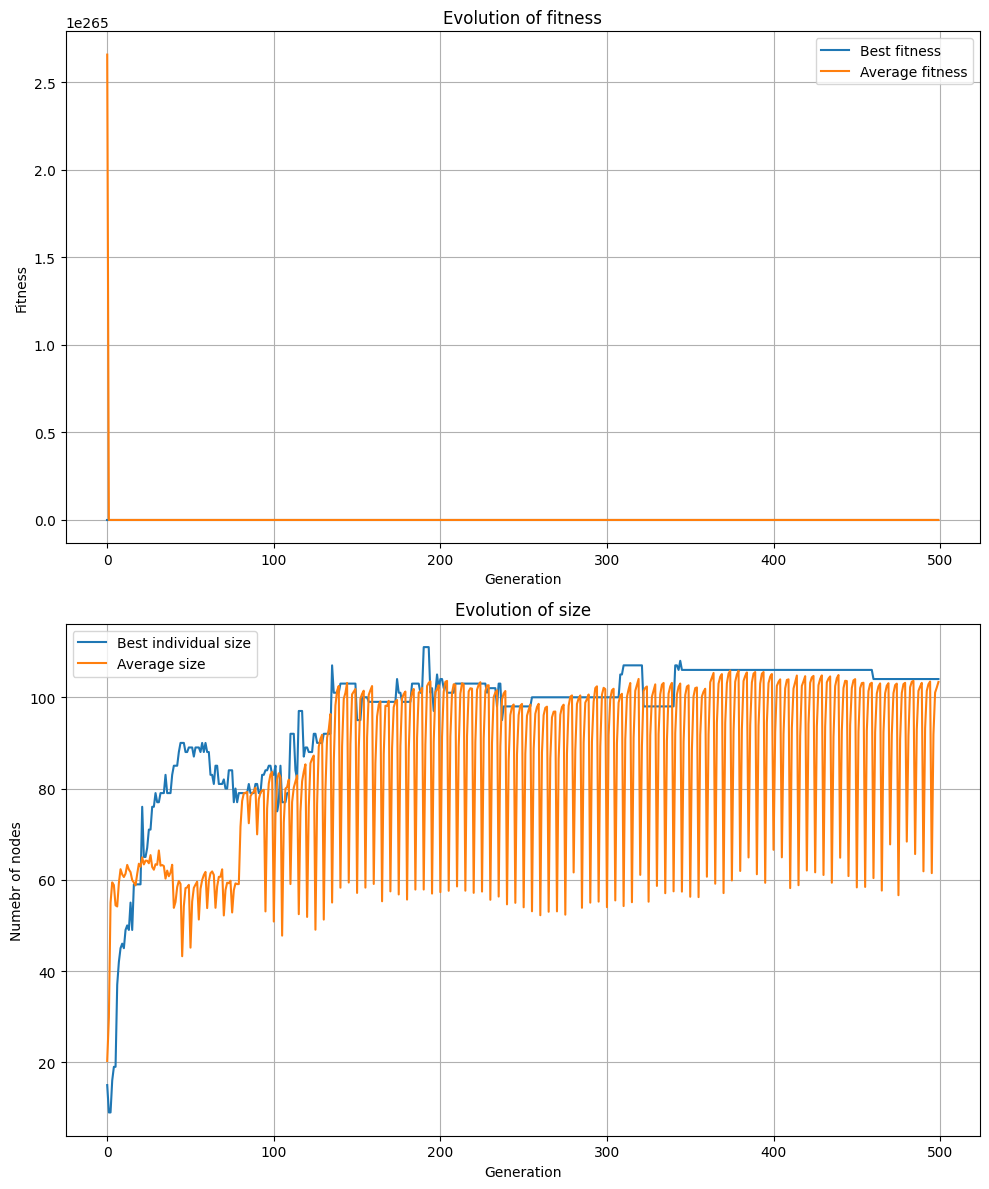

Original expression: ((((x[0] * (x[0] * x[1])) + (x[0] * (log((exp(x[1]) + x[1])) * 4.092327718778701))) * sin((sin(3.141592653589793) * sqrt(log((exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((exp((x[1] + x[1])) - ((exp(6.5609367685064) - ((5.939230066817374 * x[0]) * exp(x[0]))) / exp(cos((5.939230066817374 + x[1]))))) - (exp(5.083623282487277) * ((((5.547345449854117 * 6.5609367685064) + 4.9787556043961265) - (exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 5.939230066817374) * (4.818438684907152 * 5.547345449854117)) * exp(4.9787556043961265)) - (exp((5.083623282487277 + x[1])) - (exp(x[1]) * exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))
Simplified expression: (x[0]**2*x[1] + 4.092327718778701*x[0]*log(x[1] + exp(x[1])))*(-5.2781315382971047*x[0]**3*x[1]*exp(x[1]) - (-5.939230066817374*x[0]*exp(x[0]) + 706.933617661761)*exp(-cos(x[1] + 5.939230066817374)) - 0.24795534169131

In [52]:
print(f"\n=== GP execution on {problems[5]['file_path']} ===")
best_tree = run_gp_on_problem(problems[5]['file_path'],
    problems[5]['config'],
    function_weights=problems[5]['config'].get('function_weights'),
    terminal_weights=problems[5]['config'].get('terminal_weights'),
    use_islands=problems[5].get('use_islands', False),
    n_islands=problems[5].get('n_islands', 5),
    migration_interval=problems[5].get('migration_interval', 10),
    migration_rate=problems[5].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_6.npz ===
Loading data from ../data/problem_6.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples

GP execution on ../data/problem_6.npz...
Prima di qualsiasi elaborazione:
X shape: (5000, 2), y shape: (5000,)
X mean: -0.0006727252760436969, y mean: -3.599013872003943
X std: 2.517261137252358, y std: 3.694501463162234
X range: [-4.998852596308563, 4.995745372271546], y range: [-11.914375580518566, 4.569846551384467]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  

C:\Users\domen\AppData\Local\Temp\ipykernel_20100\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 7.541333136580214 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 7.558545688990737 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 6.203700709384588 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 8.720817506959504 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 6.0819506629708995 | Mutation Strength: 0.90
Bloat control: 118 individuals exceed the maximum size
Bloat control: 202 individuals exceed the maximum size
Bloat control: 141 individuals exceed the maximum size
Bloat control: 129 individuals exceed the maximum size
Bloat control: 133 individuals exceed the maximum size


  0%|          | 1/500 [02:38<21:57:06, 158.37s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[1] + x[1]) - (x[0] / sqrt(x[0])))
  Simplified Expression: -sqrt(x[0]) + 2*x[1]
  Fitness: 6.0819506629708995
  Complexity: 8 nodes
Generation 0, Best Fitness: 6.0819506629708995


  0%|          | 2/500 [03:57<15:26:47, 111.66s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[1] + x[1]) - x[0]) / log(-10.705843883948507)) + x[1])
  Simplified Expression: ((x[1] + x[1]) - x[0]) / log(-10.705843883948507) + x[1]
  Fitness: 4.284249900098399
  Complexity: 10 nodes


  1%|          | 3/500 [05:18<13:30:52, 97.89s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(-8.973830443913846)) * x[1]) - (x[0] / sqrt(2.2412630150135584)))
  Simplified Expression: sqrt(sqrt(-8.973830443913846) * x[1]) - (x[0] / sqrt(2.2412630150135584))
  Fitness: 0.08522715001667902
  Complexity: 10 nodes


  1%|          | 4/500 [06:39<12:31:45, 90.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(-8.973830443913846)) * x[1]) - (x[0] / sqrt(2.222284152164502)))
  Simplified Expression: sqrt(sqrt(-8.973830443913846) * x[1]) - (x[0] / sqrt(2.222284152164502))
  Fitness: 0.08082997743511483
  Complexity: 10 nodes


  1%|          | 5/500 [07:59<11:58:49, 87.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(-8.973830443913846)) * x[1]) - (x[0] / sqrt(2.1717881704359865)))
  Simplified Expression: sqrt(sqrt(-8.973830443913846) * x[1]) - (x[0] / sqrt(2.1717881704359865))
  Fitness: 0.07402796672578711
  Complexity: 10 nodes


  1%|          | 6/500 [09:37<12:28:12, 90.88s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(7.951848435813805)) * x[1]) - (x[0] / sqrt(2.074603650600559)))
  Simplified Expression: -0.6942764451497321*x[0] + 1.679256443559394*x[1]
  Fitness: 0.01502222224997804
  Complexity: 10 nodes


  2%|▏         | 10/500 [14:59<11:15:23, 82.70s/it]

Bloat control: 1 individuals exceed the maximum size


  2%|▏         | 11/500 [17:10<13:15:36, 97.62s/it]

Generation 10, Best Fitness: 0.01502222224997804


  2%|▏         | 12/500 [18:31<12:32:48, 92.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(7.951848435813805)) * x[1]) - (x[0] / sqrt(2.0247150494594957)))
  Simplified Expression: -0.70277781681867852*x[0] + 1.679256443559394*x[1]
  Fitness: 0.013513349786538582
  Complexity: 10 nodes


  4%|▎         | 18/500 [27:18<11:50:36, 88.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.139753119312724)) * x[1]) - (x[0] / sqrt(2.0247150494594957)))
  Simplified Expression: -0.70277781681867852*x[0] + 1.689090067874211*x[1]
  Fitness: 0.004170332138712727
  Complexity: 10 nodes


  4%|▍         | 21/500 [32:14<13:12:56, 99.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.211957985555367)) * x[1]) - (x[0] / sqrt(2.0247150494594957)))
  Simplified Expression: -0.70277781681867852*x[0] + 1.692823501386208*x[1]
  Fitness: 0.003851998428903769
  Complexity: 10 nodes
Generation 20, Best Fitness: 0.003851998428903769


  5%|▌         | 25/500 [37:42<11:22:24, 86.20s/it]

Bloat control: 1 individuals exceed the maximum size


  5%|▌         | 26/500 [40:11<13:50:55, 105.18s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.211957985555367)) * x[1]) - (x[0] / sqrt(2.1090801239640395)))
  Simplified Expression: -0.68857850359744694*x[0] + 1.692823501386208*x[1]
  Fitness: 0.0028580059707224202
  Complexity: 10 nodes


  6%|▌         | 28/500 [42:55<12:14:23, 93.35s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.290416565206462)) * x[1]) - (x[0] / sqrt(2.1090801239640395)))
  Simplified Expression: -0.68857850359744694*x[0] + 1.696852482806634*x[1]
  Fitness: 0.0019511501649161712
  Complexity: 10 nodes


  6%|▌         | 30/500 [45:40<11:28:25, 87.88s/it]

Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 31/500 [48:06<13:42:34, 105.23s/it]

Generation 30, Best Fitness: 0.0019511501649161712


  6%|▋         | 32/500 [49:29<12:47:54, 98.45s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.290416565206462)) * x[1]) - (x[0] / sqrt(2.0707367166273545)))
  Simplified Expression: -0.69492439545283046*x[0] + 1.696852482806634*x[1]
  Fitness: 0.00039907825767734835
  Complexity: 10 nodes


  8%|▊         | 39/500 [59:52<11:18:53, 88.36s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.001
  Island 1 diversity: 0.004
  Island 2 diversity: 0.006
  Island 3 diversity: 0.004
  Island 4 diversity: 0.010
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.02)


  8%|▊         | 40/500 [1:01:16<11:08:16, 87.17s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.272953624834003)) * x[1]) - (x[0] / sqrt(2.0707367166273545)))
  Simplified Expression: -0.69492439545283046*x[0] + 1.695958213241001*x[1]
  Fitness: 0.00016802426062486253
  Complexity: 10 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  8%|▊         | 41/500 [1:04:06<14:16:11, 111.92s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (x[0] / sqrt(2.0707367166273545)))
  Simplified Expression: -0.69492439545283046*x[0] + 1.694996976223782*x[1]
  Fitness: 3.3363687578001105e-05
  Complexity: 10 nodes
Generation 40, Best Fitness: 3.3363687578001105e-05


  9%|▉         | 45/500 [1:09:37<11:20:40, 89.76s/it] 

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 10%|▉         | 48/500 [1:15:15<12:19:45, 98.20s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (x[0] / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] + 1.694996976223782*x[1]
  Fitness: 1.2945100882447526e-05
  Complexity: 10 nodes


 10%|█         | 50/500 [1:18:00<11:17:10, 90.29s/it]

Bloat control: 8 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 10%|█         | 51/500 [1:20:51<14:16:23, 114.44s/it]

Generation 50, Best Fitness: 1.2945100882447526e-05


 11%|█         | 55/500 [1:26:20<11:08:21, 90.12s/it] 

Bloat control: 9 individuals exceed the maximum size


 12%|█▏        | 60/500 [1:34:22<10:51:04, 88.78s/it] 

Bloat control: 6 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:37:33<14:32:41, 119.28s/it]

Generation 60, Best Fitness: 1.2945100882447526e-05


 13%|█▎        | 65/500 [1:43:02<11:01:50, 91.29s/it] 

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 13%|█▎        | 67/500 [1:47:36<13:11:41, 109.70s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * tan(9.339174951877098)) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] + 1.694996976223782*x[1] + 2.018573288450675e-5
  Fitness: 1.2801651500681303e-05
  Complexity: 16 nodes


 14%|█▎        | 68/500 [1:48:59<12:11:48, 101.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * tan(sqrt(8.254213750314564))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] + 1.694996976223782*x[1] + 6.474183753086769e-5
  Fitness: 1.2513861151508152e-05
  Complexity: 17 nodes


 14%|█▍        | 69/500 [1:50:22<11:30:23, 96.11s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt(8.254213750314564)) * x[1])) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] + 1.694598261949985*x[1]
  Fitness: 3.0283621999746515e-06
  Complexity: 19 nodes


 14%|█▍        | 70/500 [1:51:45<10:59:36, 92.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt(-7.99007532984518)) * x[1])) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: sqrt(sqrt(8.254213750314564) * x[1]) - (exp(-7.99007532984518) * (sqrt(sqrt(-7.99007532984518) * x[1]) + x[0]) / sqrt(2.074545847057164))
  Fitness: 3.027268402324223e-06
  Complexity: 19 nodes
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 14%|█▍        | 71/500 [1:54:43<14:02:49, 117.88s/it]

Generation 70, Best Fitness: 3.027268402324223e-06


 15%|█▍        | 73/500 [1:57:29<11:51:38, 100.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt(7.951848435813805)) * x[1])) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] + 1.694601964596738*x[1]
  Fitness: 3.0272197166604523e-06
  Complexity: 19 nodes


 15%|█▍        | 74/500 [1:58:51<11:12:25, 94.71s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt((-6.138194977390124 + x[0]))) * x[1])) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] - 0.0002352300796932383*x[1]*(x[0] - 6.138194977390124)**(1/4) + 1.694996976223782*x[1]
  Fitness: 2.7479787596691983e-06
  Complexity: 21 nodes


 15%|█▌        | 75/500 [2:00:14<10:46:11, 91.23s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:03:00<13:22:53, 113.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt((-7.99007532984518 + x[0]))) * x[1])) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] - 0.0002352300796932383*x[1]*(x[0] - 7.99007532984518)**(1/4) + 1.694996976223782*x[1]
  Fitness: 2.681770088078063e-06
  Complexity: 21 nodes


 16%|█▌        | 78/500 [2:05:46<11:29:43, 98.06s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt((-7.99007532984518 + x[0]))) * (x[0] + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] + 1.694996976223782*x[1] - 0.0002352300796932383*(x[0] - 7.99007532984518)**(1/4)*(x[0] + x[1])
  Fitness: 2.162239800273411e-06
  Complexity: 23 nodes


 16%|█▌        | 79/500 [2:07:09<10:55:44, 93.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(x[1]) * (x[0] + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] - 0.0002352300796932383*sqrt(x[1])*(x[0] + x[1]) + 1.694996976223782*x[1]
  Fitness: 1.968778874614687e-06
  Complexity: 20 nodes
Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.003
  Island 2 diversity: 0.005
  Island 3 diversity: 0.003
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)


 16%|█▌        | 80/500 [2:08:33<10:34:43, 90.68s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 3 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:10:44<11:58:10, 102.84s/it]

Generation 80, Best Fitness: 1.968778874614687e-06


 17%|█▋        | 84/500 [2:14:48<10:14:05, 88.57s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(x[1]) * ((x[0] * sqrt(-0.8853572135718348)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: sqrt(sqrt(8.254213750314564) * x[1]) - (exp(-7.99007532984518) * (sqrtx[1] * (x[0] * sqrt(-0.8853572135718348) + x[1]) + x[0]) / sqrt(2.074545847057164))
  Fitness: 1.6670807453806539e-06
  Complexity: 23 nodes


 17%|█▋        | 85/500 [2:16:09<9:56:43, 86.27s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(x[1]) * ((tan(3.7778643568636703) * x[0]) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6942861174737102*x[0] - 0.0002352300796932383*sqrt(x[1])*(0.73876477613359854*x[0] + x[1]) + 1.694996976223782*x[1]
  Fitness: 1.0137611552901837e-06
  Complexity: 23 nodes


 17%|█▋        | 86/500 [2:18:10<11:07:04, 96.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (sqrt(sqrt(8.254213750314564)) * ((x[0] * cos(-0.8853572135718348)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945385087955599*x[0] + 1.694598261949985*x[1]
  Fitness: 4.7012614011503106e-07
  Complexity: 24 nodes


 18%|█▊        | 88/500 [2:20:51<10:08:06, 88.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.074545847057164 * ((x[0] * cos(-0.8853572135718348)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945950250268925*x[0] + 1.694508980638852*x[1]
  Fitness: 3.2098430339694113e-07
  Complexity: 22 nodes


 18%|█▊        | 89/500 [2:22:13<9:53:31, 86.64s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (1.9408234698865716 * ((x[0] * cos(-0.8853572135718348)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69457511327011154*x[0] + 1.6945404361642904*x[1]
  Fitness: 2.6313430943182604e-07
  Complexity: 22 nodes


 18%|█▊        | 90/500 [2:23:34<9:40:48, 85.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.074545847057164 * ((x[0] * cos(-5.088189481540484)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.694465220287934*x[0] + 1.694508980638852*x[1]
  Fitness: 2.2826063117961367e-07
  Complexity: 22 nodes


 18%|█▊        | 91/500 [2:25:41<11:04:48, 97.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.074545847057164 * ((x[0] * cos(1.0)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945497826135016*x[0] + 1.694508980638852*x[1]
  Fitness: 4.769323576369896e-08
  Complexity: 22 nodes
Generation 90, Best Fitness: 4.769323576369896e-08


 19%|█▉        | 94/500 [2:29:44<9:47:26, 86.81s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.074545847057164 * ((x[0] * cos(1.0692961262337417)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452071722685341*x[0] + 1.694508980638852*x[1]
  Fitness: 8.157744246270203e-09
  Complexity: 22 nodes


 20%|██        | 100/500 [2:38:40<9:30:19, 85.55s/it]

Island 0 | Generation 100 | Best Fitness: 8.157744246270203e-09 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 3.5681967978341057e-06 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 4.156342589304446e-05 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 5.537345554796762e-06 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 1.074155764165524e-06 | Mutation Strength: 1.25


 20%|██        | 101/500 [2:40:47<10:49:52, 97.73s/it]

Generation 100, Best Fitness: 8.157744246270203e-09


 21%|██        | 105/500 [2:46:13<9:22:43, 85.48s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (1.9898325570888364 * ((x[0] * cos(1.0692961262337417)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69451113743523651*x[0] + 1.6945289077528021*x[1]
  Fitness: 6.495866091216154e-09
  Complexity: 22 nodes
Bloat control: 1 individuals exceed the maximum size


 21%|██▏       | 107/500 [2:49:57<10:32:03, 96.50s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (1.9980557119201812 * ((x[0] * cos(1.0692961262337417)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69451206734965427*x[0] + 1.6945269734194358*x[1]
  Fitness: 4.679760037093306e-09
  Complexity: 22 nodes


 22%|██▏       | 109/500 [2:52:40<9:37:40, 88.64s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (1.9980557119201812 * ((x[0] * cos(1.0418626336465215)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452328701615827*x[0] + 1.6945269734194358*x[1]
  Fitness: 4.1270037351010195e-09
  Complexity: 22 nodes


 22%|██▏       | 111/500 [2:56:16<10:54:47, 101.00s/it]

Generation 110, Best Fitness: 4.1270037351010195e-09


 23%|██▎       | 116/500 [3:03:57<10:43:55, 100.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.034716348126454 * ((x[0] * cos(1.0418626336465215)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452763863972063*x[0] + 1.694518349735059*x[1]
  Fitness: 2.904640765001714e-09
  Complexity: 22 nodes


 23%|██▎       | 117/500 [3:05:19<10:06:36, 95.03s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (1.9980557119201812 * ((x[0] * cos(1.0505329730335895)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69451975993988124*x[0] + 1.6945269734194358*x[1]
  Fitness: 2.5918065546150992e-09
  Complexity: 22 nodes


 24%|██▎       | 118/500 [3:06:41<9:39:49, 91.07s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.034716348126454 * ((x[0] * cos(1.0505329730335895)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452404684810083*x[0] + 1.694518349735059*x[1]
  Fitness: 7.71357101044745e-10
  Complexity: 22 nodes


 24%|██▍       | 119/500 [3:08:02<9:19:15, 88.07s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.007
  Island 3 diversity: 0.005
  Island 4 diversity: 0.002
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)


 24%|██▍       | 120/500 [3:09:26<9:09:59, 86.84s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)


 24%|██▍       | 121/500 [3:11:47<10:52:09, 103.24s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.0264757666681774 * ((x[0] * cos(1.0505329730335895)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945230832364442*x[0] + 1.6945202881676925*x[1]
  Fitness: 4.407011320412834e-10
  Complexity: 22 nodes
Generation 120, Best Fitness: 4.407011320412834e-10


 25%|██▌       | 125/500 [3:17:17<9:05:57, 87.35s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.034716348126454 * ((x[0] * cos(1.0584020635782414)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452077149296583*x[0] + 1.694518349735059*x[1]
  Fitness: 2.427235813594491e-10
  Complexity: 22 nodes
Bloat control: 1 individuals exceed the maximum size


 26%|██▌       | 131/500 [3:28:11<11:09:05, 108.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.0265249932834983 * ((x[0] * cos(1.0584020635782414)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69451982682353374*x[0] + 1.6945202765881119*x[1]
  Fitness: 2.4871581490081057e-11
  Complexity: 22 nodes
Generation 130, Best Fitness: 2.4871581490081057e-11


 28%|██▊       | 141/500 [3:44:16<10:43:29, 107.55s/it]

Generation 140, Best Fitness: 2.4871581490081057e-11


 29%|██▉       | 145/500 [3:49:45<8:43:11, 88.43s/it]  

Bloat control: 1 individuals exceed the maximum size


 30%|███       | 151/500 [4:00:36<10:31:04, 108.49s/it]

Generation 150, Best Fitness: 2.4871581490081057e-11


 30%|███       | 152/500 [4:01:58<9:44:19, 100.75s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.0265249932834983 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452052416449577*x[0] + 1.6945202765881119*x[1]
  Fitness: 1.2570977426307338e-12
  Complexity: 22 nodes


 31%|███       | 155/500 [4:06:05<8:29:54, 88.68s/it] 

Bloat control: 1 individuals exceed the maximum size


 32%|███▏      | 159/500 [4:13:02<8:48:04, 92.92s/it]  

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.005
  Island 2 diversity: 0.004
  Island 3 diversity: 0.005
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)


 32%|███▏      | 160/500 [4:14:27<8:31:46, 90.31s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 32%|███▏      | 161/500 [4:17:00<10:17:26, 109.28s/it]

Generation 160, Best Fitness: 1.2570977426307338e-12


 34%|███▍      | 169/500 [4:29:09<8:23:07, 91.20s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.0264574338623977 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452051634994604*x[0] + 1.6945202924801199*x[1]
  Fitness: 1.0299724582139973e-12
  Complexity: 22 nodes


 34%|███▍      | 171/500 [4:33:04<9:50:10, 107.63s/it]

Generation 170, Best Fitness: 1.0299724582139973e-12


 36%|███▌      | 181/500 [4:49:08<9:34:35, 108.07s/it]

Generation 180, Best Fitness: 1.0299724582139973e-12


 37%|███▋      | 185/500 [4:54:38<7:45:23, 88.65s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 38%|███▊      | 189/500 [5:01:48<8:07:51, 94.12s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.3281875339551227e-13
  Complexity: 22 nodes


 38%|███▊      | 191/500 [5:05:44<9:23:57, 109.51s/it]

Generation 190, Best Fitness: 3.3281875339551227e-13


 39%|███▊      | 193/500 [5:08:29<8:09:20, 95.64s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * x[1]) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.328187533953238e-13
  Complexity: 26 nodes


 39%|███▉      | 195/500 [5:11:13<7:30:47, 88.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + x[0]) - x[0])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.3281875339509373e-13
  Complexity: 26 nodes
Bloat control: 1 individuals exceed the maximum size


 39%|███▉      | 196/500 [5:14:04<9:35:07, 113.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + x[0]) - x[0])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.328187533949053e-13
  Complexity: 30 nodes


 40%|███▉      | 199/500 [5:18:12<7:47:30, 93.19s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.008
  Island 2 diversity: 0.005
  Island 3 diversity: 0.005
  Island 4 diversity: 0.005
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)


 40%|████      | 200/500 [5:19:36<7:31:51, 90.37s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Island 0 | Generation 200 | Best Fitness: 3.328187533949053e-13 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 3.328187533949053e-13 | Mutation Strength: 2.70
Island 2 | Generation 200 | Best Fitness: 3.328187533949053e-13 | Mutation Strength: 2.70
Island 3 | Generation 200 | Best Fitness: 3.328187533949053e-13 | Mutation Strength: 2.70
Island 4 | Generation 200 | Best Fitness: 3.328187533929928e-13 | Mutation Strength: 2.70
Bloat control: 1 individuals exceed the maximum size


 40%|████      | 201/500 [5:22:46<9:59:53, 120.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + x[0]) - ((x[1] + x[0]) - x[1]))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.328187533929928e-13
  Complexity: 34 nodes
Generation 200, Best Fitness: 3.328187533929928e-13


 41%|████      | 204/500 [5:26:54<7:52:22, 95.75s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((((x[1] + x[0]) - ((x[1] + x[0]) - x[1])) + x[0]) - ((x[1] + x[0]) - x[1]))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.3281875338702453e-13
  Complexity: 42 nodes


 41%|████      | 205/500 [5:28:18<7:32:59, 92.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[0] * (x[1] / x[0]))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + (x[0] * (x[1] / x[0]))))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.3281875338123846e-13
  Complexity: 30 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1184 individuals exceed the maximum size


 41%|████      | 206/500 [5:31:49<10:26:12, 127.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[0] * (x[1] / x[0]))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.328187533810501e-13
  Complexity: 30 nodes


 41%|████▏     | 207/500 [5:33:13<9:19:33, 114.58s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[0] * (x[1] / x[0])) + (((x[0] * (x[1] / x[0])) + x[0]) - x[0])) - x[1])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.3281875335356294e-13
  Complexity: 42 nodes


 42%|████▏     | 209/500 [5:36:00<7:58:54, 98.75s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[0] * (x[1] / x[0])) + (x[0] * (x[1] / x[0]))) - x[1])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1]
  Fitness: 3.3281875334939417e-13
  Complexity: 38 nodes


 42%|████▏     | 210/500 [5:37:25<7:37:07, 94.58s/it]

Bloat control: 1229 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1912 individuals exceed the maximum size


 42%|████▏     | 211/500 [5:40:54<10:20:50, 128.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + x[0]) - x[0])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.95759729117056e-16
  Fitness: 3.328187532315305e-13
  Complexity: 33 nodes
Generation 210, Best Fitness: 3.328187532315305e-13


 43%|████▎     | 214/500 [5:45:05<7:53:28, 99.33s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) + x[0]) - x[0])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 7.915194582341119e-16
  Fitness: 3.3281875299216443e-13
  Complexity: 36 nodes


 43%|████▎     | 215/500 [5:46:30<7:30:30, 94.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 7.915194582341119e-16
  Fitness: 3.328187529914681e-13
  Complexity: 32 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1871 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 45 individuals exceed the maximum size
Bloat control: 1987 individuals exceed the maximum size


 43%|████▎     | 216/500 [5:50:17<10:37:33, 134.69s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + x[0]) - x[0])) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.187279187351168e-15
  Fitness: 3.3281875277028575e-13
  Complexity: 39 nodes


 43%|████▎     | 217/500 [5:51:41<9:22:59, 119.36s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.583038916468224e-15
  Fitness: 3.328187526083946e-13
  Complexity: 38 nodes


 44%|████▍     | 219/500 [5:54:30<7:56:00, 101.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.97879864558528e-15
  Fitness: 3.3281875240912655e-13
  Complexity: 41 nodes


 44%|████▍     | 220/500 [5:55:55<7:30:06, 96.45s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 1276 individuals exceed the maximum size
Bloat control: 43 individuals exceed the maximum size
Bloat control: 1872 individuals exceed the maximum size


 44%|████▍     | 221/500 [5:59:26<10:08:57, 130.96s/it]

Generation 220, Best Fitness: 3.3281875240912655e-13


 45%|████▌     | 225/500 [6:05:06<7:20:04, 96.02s/it]  

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1966 individuals exceed the maximum size
Bloat control: 54 individuals exceed the maximum size
Bloat control: 1992 individuals exceed the maximum size


 46%|████▌     | 230/500 [6:14:12<7:10:40, 95.71s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1952 individuals exceed the maximum size
Bloat control: 38 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 46%|████▌     | 231/500 [6:17:44<9:44:52, 130.46s/it]

Generation 230, Best Fitness: 3.3281875240912655e-13


 47%|████▋     | 235/500 [6:23:24<7:04:08, 96.03s/it] 

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1967 individuals exceed the maximum size
Bloat control: 53 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 48%|████▊     | 239/500 [6:31:13<7:19:02, 100.93s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.006
  Island 2 diversity: 0.007
  Island 3 diversity: 0.006
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 48%|████▊     | 240/500 [6:32:41<7:00:04, 96.94s/it] 

Bloat control: 1620 individuals exceed the maximum size
Bloat control: 1977 individuals exceed the maximum size
Bloat control: 1985 individuals exceed the maximum size
Bloat control: 1311 individuals exceed the maximum size
Bloat control: 1981 individuals exceed the maximum size


 48%|████▊     | 241/500 [6:35:31<8:33:32, 118.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + ((x[1] + x[0]) - x[0])))) + log(exp(x[0]))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.97879864558528e-15
  Fitness: 3.3281875240816775e-13
  Complexity: 44 nodes
Generation 240, Best Fitness: 3.3281875240816775e-13


 49%|████▉     | 244/500 [6:39:48<6:54:16, 97.10s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[1] + ((x[1] + x[0]) - (x[0] - (x[0] - x[1])))) - (x[0] - (((x[1] + x[0]) - x[1]) - x[1])))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.97879864558528e-15
  Fitness: 3.328187523660657e-13
  Complexity: 57 nodes


 49%|████▉     | 245/500 [6:41:15<6:39:55, 94.10s/it]

Bloat control: 1963 individuals exceed the maximum size
Bloat control: 1990 individuals exceed the maximum size
Bloat control: 1966 individuals exceed the maximum size
Bloat control: 1981 individuals exceed the maximum size
Bloat control: 1949 individuals exceed the maximum size


 49%|████▉     | 246/500 [6:44:02<8:11:28, 116.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[1] + ((x[1] + x[0]) - (x[0] - (x[0] - x[1])))) - (x[0] - (((x[1] + x[0]) - x[1]) - (x[1] - tan(3.141592653589793)))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.140905416060634e-15
  Fitness: 3.3281875232999636e-13
  Complexity: 60 nodes


 49%|████▉     | 247/500 [6:45:28<7:31:12, 107.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[1] + ((x[1] + x[0]) - x[1])) - (((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.465118957011342e-15
  Fitness: 3.328187521399732e-13
  Complexity: 54 nodes


 50%|█████     | 250/500 [6:49:49<6:31:02, 93.85s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[1] + ((x[1] + x[0]) - (x[1] - tan(3.141592653589793)))) - (((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.627225727486696e-15
  Fitness: 3.3281875210002364e-13
  Complexity: 57 nodes
Bloat control: 1954 individuals exceed the maximum size
Bloat control: 1996 individuals exceed the maximum size
Bloat control: 1954 individuals exceed the maximum size
Bloat control: 1986 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 50%|█████     | 251/500 [6:52:36<8:00:45, 115.85s/it]

Generation 250, Best Fitness: 3.3281875210002364e-13


 50%|█████     | 252/500 [6:54:02<7:22:26, 107.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[1] + (x[0] - x[1])) - (((x[1] - x[1]) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.303012186535988e-15
  Fitness: 3.3281875193294477e-13
  Complexity: 51 nodes


 51%|█████     | 255/500 [6:58:23<6:23:13, 93.85s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (((x[1] + (x[0] - x[1])) - (((x[1] - x[1]) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((x[1] - x[1]) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.627225727486696e-15
  Fitness: 3.328187514740381e-13
  Complexity: 61 nodes
Bloat control: 1947 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1949 individuals exceed the maximum size
Bloat control: 1985 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 52%|█████▏    | 260/500 [7:07:01<6:18:00, 94.50s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (((x[1] + (x[0] - x[1])) - (((x[1] - x[1]) - tan(3.141592653589793)) - tan(3.141592653589793))) - ((((x[1] - x[1]) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.789332497962051e-15
  Fitness: 3.3281875137787244e-13
  Complexity: 64 nodes
Bloat control: 1947 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1931 individuals exceed the maximum size
Bloat control: 1970 individuals exceed the maximum size
Bloat control: 1983 individuals exceed the maxi

 52%|█████▏    | 261/500 [7:09:51<7:45:55, 116.97s/it]

Generation 260, Best Fitness: 3.3281875137787244e-13


 53%|█████▎    | 265/500 [7:15:40<6:10:23, 94.57s/it] 

Bloat control: 1968 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1974 individuals exceed the maximum size
Bloat control: 1992 individuals exceed the maximum size


 54%|█████▍    | 270/500 [7:24:47<6:11:27, 96.90s/it] 

Bloat control: 1984 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1983 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 54%|█████▍    | 271/500 [7:28:04<8:03:39, 126.72s/it]

Generation 270, Best Fitness: 3.3281875137787244e-13


 55%|█████▌    | 275/500 [7:33:59<6:07:59, 98.13s/it] 

Bloat control: 1991 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1982 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 279/500 [7:42:20<6:39:04, 108.35s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.007
  Island 2 diversity: 0.004
  Island 3 diversity: 0.007
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 56%|█████▌    | 280/500 [7:43:51<6:18:48, 103.31s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1247 individuals exceed the maximum size
Bloat control: 1985 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 281/500 [7:46:46<7:34:50, 124.61s/it]

Generation 280, Best Fitness: 3.3281875137787244e-13


 57%|█████▋    | 285/500 [7:52:39<5:47:59, 97.11s/it] 

Bloat control: 1962 individuals exceed the maximum size
Bloat control: 1940 individuals exceed the maximum size
Bloat control: 1909 individuals exceed the maximum size
Bloat control: 1977 individuals exceed the maximum size
Bloat control: 1993 individuals exceed the maximum size


 58%|█████▊    | 290/500 [8:01:22<5:35:02, 95.73s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1987 individuals exceed the maximum size
Bloat control: 1938 individuals exceed the maximum size
Bloat control: 1965 individuals exceed the maximum size
Bloat control: 1993 individuals exceed the maximum size


 58%|█████▊    | 291/500 [8:04:12<6:50:24, 117.82s/it]

Generation 290, Best Fitness: 3.3281875137787244e-13


 59%|█████▉    | 295/500 [8:10:03<5:25:32, 95.28s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1958 individuals exceed the maximum size
Bloat control: 1936 individuals exceed the maximum size
Bloat control: 1950 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 60%|██████    | 300/500 [8:18:49<5:19:42, 95.91s/it] 

Island 0 | Generation 300 | Best Fitness: 3.3281875137787244e-13 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 3.32818752365446e-13 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 3.3281875240816775e-13 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 3.3281875240816775e-13 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 3.3281875137787244e-13 | Mutation Strength: 3.00
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1917 individuals exceed the maximum size
Bloat control: 1945 individuals exceed the maximum size
Bloat control: 1975 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size


 60%|██████    | 301/500 [8:21:40<6:32:29, 118.34s/it]

Generation 300, Best Fitness: 3.3281875137787244e-13


 60%|██████    | 302/500 [8:23:07<5:59:45, 109.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(tan(tan(3.141592653589793)))) + ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - (((0.0 - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.860878686128398e-15
  Fitness: 3.32818750914091e-13
  Complexity: 56 nodes


 61%|██████    | 304/500 [8:26:05<5:22:25, 98.70s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(tan(tan(3.141592653589793)))) + ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((0.0 - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.185092227079107e-15
  Fitness: 3.328187504493601e-13
  Complexity: 64 nodes


 61%|██████    | 305/500 [8:27:33<5:10:00, 95.39s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(tan(tan(3.141592653589793)))) + (((0.0 - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((0.0 - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.580851956196162e-15
  Fitness: 3.3281875024969624e-13
  Complexity: 67 nodes
Bloat control: 1990 individuals exceed the maximum size
Bloat control: 1960 individuals exceed the maximum size
Bloat control: 55 individuals exceed the maximum size
Bloat control: 1978 individuals exceed the maximum size
Bloat cont

 62%|██████▏   | 310/500 [8:36:44<5:09:22, 97.70s/it] 

Bloat control: 1994 individuals exceed the maximum size
Bloat control: 1966 individuals exceed the maximum size
Bloat control: 92 individuals exceed the maximum size
Bloat control: 1971 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 62%|██████▏   | 311/500 [8:40:01<6:41:23, 127.42s/it]

Generation 310, Best Fitness: 3.3281875024969624e-13


 63%|██████▎   | 315/500 [8:45:56<5:02:40, 98.16s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1962 individuals exceed the maximum size
Bloat control: 1946 individuals exceed the maximum size
Bloat control: 1963 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 64%|██████▎   | 318/500 [8:51:43<5:14:34, 103.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((sin(3.141592653589793) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.814504914837864e-15
  Fitness: 3.3281874905415736e-13
  Complexity: 63 nodes


 64%|██████▍   | 319/500 [8:53:13<5:00:09, 99.50s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.005
  Island 2 diversity: 0.004
  Island 3 diversity: 0.004
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)


 64%|██████▍   | 320/500 [8:54:45<4:51:36, 97.20s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((sin(3.141592653589793) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((0.0 - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.976611685313218e-15
  Fitness: 3.3281874895799964e-13
  Complexity: 66 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size

 64%|██████▍   | 321/500 [8:57:37<5:57:29, 119.83s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((sin(3.141592653589793) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((sin(3.141592653589793) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 4.138718455788573e-15
  Fitness: 3.3281874845007646e-13
  Complexity: 67 nodes
Generation 320, Best Fitness: 3.3281874845007646e-13


 65%|██████▍   | 323/500 [9:00:36<5:07:44, 104.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((x[1] * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((x[1] * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701509*x[1] + 3.022985456603752e-15
  Fitness: 3.3281874810754513e-13
  Complexity: 65 nodes


 65%|██████▍   | 324/500 [9:02:07<4:54:13, 100.31s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + (((sin(3.141592653589793) - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 4.318230764179755e-15
  Fitness: 3.328187477030004e-13
  Complexity: 60 nodes


 65%|██████▌   | 325/500 [9:03:38<4:44:30, 97.55s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((0.0 - tan(3.141592653589793)) - tan(3.141592653589793))) - (((x[1] * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701512*x[1] + 6.185135504768152e-15
  Fitness: 3.328187456696344e-13
  Complexity: 65 nodes
Bloat control: 1989 individuals exceed the maximum size
Bloat control: 1995 individuals exceed the maximum size
Bloat control: 1987 individuals exceed the maximum size
Bloat control: 1975 individuals exceed the maximum size
Bloa

 65%|██████▌   | 327/500 [9:08:01<5:19:45, 110.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) + (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793))) - (((x[1] * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701512*x[1] + 6.922514312751744e-15
  Fitness: 3.3281874455502033e-13
  Complexity: 62 nodes


 66%|██████▌   | 329/500 [9:11:02<4:46:23, 100.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) + (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 8.217759620327747e-15
  Fitness: 3.3281874348532116e-13
  Complexity: 62 nodes


 66%|██████▌   | 330/500 [9:12:33<4:37:01, 97.77s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1990 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 66%|██████▌   | 331/500 [9:15:27<5:39:48, 120.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 8.613519349444803e-15
  Fitness: 3.32818743285325e-13
  Complexity: 65 nodes
Generation 330, Best Fitness: 3.32818743285325e-13


 67%|██████▋   | 334/500 [9:19:57<4:38:18, 100.59s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) + (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 8.250395949145557e-15
  Fitness: 3.3281874317771206e-13
  Complexity: 61 nodes


 67%|██████▋   | 335/500 [9:21:29<4:29:38, 98.05s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((((x[1] - tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)) + (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-6.629457861168739 * x[0]) * tan(3.141592653589793)) - 0.0)) - (((-7.99007532984518 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268*x[0] + 1.6945204493701514*x[1] + 7.156167271393446e-15
  Fitness: 3.328187411744652e-13
  Complexity: 65 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum

 68%|██████▊   | 338/500 [9:27:21<4:42:43, 104.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + ((((-6.138194977390124 * x[0]) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920267865*x[0] + 1.6945204493701514*x[1] + 4.725122500681912e-15
  Fitness: 3.3281873860317497e-13
  Complexity: 60 nodes


 68%|██████▊   | 339/500 [9:28:52<4:29:47, 100.55s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + ((((-6.138194977390124 * x[0]) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-6.629457861168739 * x[0]) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920267757*x[0] + 1.6945204493701514*x[1] + 3.397240864288099e-15
  Fitness: 3.328187363695369e-13
  Complexity: 62 nodes


 68%|██████▊   | 340/500 [9:30:23<4:20:26, 97.67s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + ((((-6.138194977390124 * x[0]) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920267865*x[0] + 1.6945204493701514*x[1] + 1.337937873820553e-14
  Fitness: 3.328187264997569e-13
  Complexity: 61 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 

 68%|██████▊   | 341/500 [9:33:18<5:20:29, 120.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + ((((-6.138194977390124 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 2.47766744027778e-14
  Fitness: 3.3281871968417697e-13
  Complexity: 60 nodes
Generation 340, Best Fitness: 3.3281871968417697e-13


 69%|██████▊   | 343/500 [9:36:17<4:34:39, 104.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + ((((-6.138194977390124 * x[0]) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - (((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920267865*x[0] + 1.6945204493701514*x[1] + 2.187152820525379e-14
  Fitness: 3.328187145220197e-13
  Complexity: 61 nodes


 69%|██████▉   | 344/500 [9:37:48<4:21:56, 100.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + (((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - (((-8.191401460284455 * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.758718674307439e-14
  Fitness: 3.3281870110707487e-13
  Complexity: 59 nodes


 69%|██████▉   | 345/500 [9:39:19<4:12:38, 97.80s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (((x[1] - tan(3.141592653589793)) + (((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - (((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 4.624144298059801e-14
  Fitness: 3.3281868901546116e-13
  Complexity: 60 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed 

 70%|██████▉   | 348/500 [9:45:14<4:26:33, 105.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - (((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 4.718107115513613e-14
  Fitness: 3.3281868798013174e-13
  Complexity: 57 nodes


 70%|██████▉   | 349/500 [9:46:44<4:13:31, 100.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 4.789016490904295e-14
  Fitness: 3.328186873979818e-13
  Complexity: 58 nodes


 70%|███████   | 350/500 [9:48:16<4:05:24, 98.16s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 70%|███████   | 351/500 [9:51:10<4:59:59, 120.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.5287270889847 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((tan(4.728627237571075) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 4.964977074517651e-14
  Fitness: 3.3281868458550816e-13
  Complexity: 58 nodes
Generation 350, Best Fitness: 3.3281868458550816e-13


 71%|███████   | 355/500 [9:57:16<4:00:03, 99.34s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.007769267132723e-14
  Fitness: 3.3281868440679535e-13
  Complexity: 60 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control:

 71%|███████   | 356/500 [10:00:11<4:52:41, 121.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.380928632669903 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.380928632669903 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.039904014795418e-14
  Fitness: 3.328186831230211e-13
  Complexity: 59 nodes


 72%|███████▏  | 358/500 [10:03:11<4:10:12, 105.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-7.99007532984518 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.139401990922932e-14
  Fitness: 3.328186826614888e-13
  Complexity: 60 nodes


 72%|███████▏  | 359/500 [10:04:42<3:57:43, 101.16s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.008
  Island 4 diversity: 0.004
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)


 72%|███████▏  | 360/500 [10:06:21<3:54:23, 100.45s/it]

  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.460763837546568e-14
  Fitness: 3.328186784797469e-13
  Complexity: 60 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the ma

 72%|███████▏  | 361/500 [10:09:10<4:40:21, 121.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.500339810458273e-14
  Fitness: 3.328186782778551e-13
  Complexity: 61 nodes
Generation 360, Best Fitness: 3.328186782778551e-13


 73%|███████▎  | 364/500 [10:13:32<3:44:53, 99.22s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.459609129818679 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.619452451532145e-14
  Fitness: 3.3281867583066365e-13
  Complexity: 60 nodes


 73%|███████▎  | 365/500 [10:15:01<3:35:50, 95.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 9.262527417655782) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 5.858440463936379e-14
  Fitness: 3.32818672797788e-13
  Complexity: 61 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum 

 73%|███████▎  | 366/500 [10:17:52<4:24:27, 118.41s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.815891085683706 * 9.262527417655782) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - tan(3.141592653589793))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 6.167117609379689e-14
  Fitness: 3.328186679541307e-13
  Complexity: 61 nodes


 74%|███████▎  | 368/500 [10:20:47<3:45:57, 102.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.459609129818679 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - 0.0)) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.427420566471927e-13
  Fitness: 3.3281855527602887e-13
  Complexity: 58 nodes


 74%|███████▍  | 369/500 [10:22:16<3:35:18, 98.62s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.55624331967283) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-9.36898251373954 * 8.254213750314564) * 8.55624331967283) * tan(3.141592653589793)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.501409533761165e-13
  Fitness: 3.328185458126238e-13
  Complexity: 59 nodes


 74%|███████▍  | 370/500 [10:23:44<3:26:51, 95.47s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.538101315921504e-13
  Fitness: 3.328182631540555e-13
  Complexity: 58 nodes
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 ind

 74%|███████▍  | 371/500 [10:26:34<4:13:20, 117.83s/it]

Generation 370, Best Fitness: 3.328182631540555e-13


 74%|███████▍  | 372/500 [10:28:00<3:51:05, 108.32s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - 0.0)) - ((((-9.459609129818679 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 3.590132880222719e-13
  Fitness: 3.3281825595129954e-13
  Complexity: 57 nodes


 75%|███████▍  | 373/500 [10:29:28<3:36:10, 102.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * ((x[1] * 5.354764148502223) * -0.8853572135718348)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - 0.0)) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493700124*x[1] + 1.116783828625088e-13
  Fitness: 3.3281801712122075e-13
  Complexity: 61 nodes


 75%|███████▍  | 374/500 [10:30:55<3:25:13, 97.73s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * ((-8.973830443913846 * 5.354764148502223) * -0.8853572135718348)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - 0.0)) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.358837619041185e-12
  Fitness: 3.3281686843854065e-13
  Complexity: 61 nodes


 75%|███████▌  | 375/500 [10:32:23<3:17:22, 94.74s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * ((x[1] * 5.354764148502223) * (-8.973830443913846 * 8.254213750314564))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - 0.0)) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493585241*x[1] + 1.116783828625088e-13
  Fitness: 3.3276993636153383e-13
  Complexity: 63 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the 

 75%|███████▌  | 376/500 [10:35:13<4:02:19, 117.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * ((-8.973830443913846 * 5.354764148502223) * (-8.973830443913846 * 8.254213750314564))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) - 0.0)) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.044531476480719e-10
  Fitness: 3.326738777309342e-13
  Complexity: 63 nodes


 76%|███████▌  | 378/500 [10:38:07<3:27:18, 101.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * ((-8.973830443913846 * 8.254213750314564) * (-8.973830443913846 * 8.254213750314564))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((x[0] * tan(3.141592653589793)) - 0.0)) - ((((-8.973830443913846 * 8.254213750314564) * tan(3.141592653589793)) * 8.254213750314564) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268123*x[0] + 1.6945204493701514*x[1] + 1.609390218116247e-10
  Fitness: 3.3259555857894683e-13
  Complexity: 61 nodes


 76%|███████▌  | 379/500 [10:39:34<3:16:42, 97.54s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (x[0] * 6.944557806606948)) * tan(3.141592653589793)) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.55624331967283) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920246853*x[0] + 1.6945204493701514*x[1] + 7.969797773779989e-8
  Fitness: 1.855400259793596e-13
  Complexity: 57 nodes


 76%|███████▌  | 380/500 [10:41:02<3:08:58, 94.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (x[0] * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (((-8.973830443913846 * 8.55624331967283) * tan(3.141592653589793)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * tan(exp(-7.99007532984518))) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 1.818559283905939e-12*x[0]**2 - 0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 7.969798078734277e-8
  Fitness: 1.8552526587918382e-13
  Complexity: 62 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the max

 76%|███████▌  | 381/500 [10:43:51<3:52:07, 117.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (x[0] * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (exp(-7.99007532984518) * exp(-7.99007532984518))) - ((exp(-7.99007532984518) * tan(exp(-7.99007532984518))) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 1.818559283905939e-12*x[0]**2 - 0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.593959327492088e-7
  Fitness: 1.6529196717142354e-13
  Complexity: 58 nodes
Generation 380, Best Fitness: 1.6529196717142354e-13


 77%|███████▋  | 383/500 [10:46:45<3:18:13, 101.66s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (x[0] * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 1.818559283905939e-12*x[0]**2 - 0.69452043920268108*x[0] + 1.6945204493701514*x[1] + 1.593959298617727e-7
  Fitness: 1.6529196560998006e-13
  Complexity: 60 nodes


 77%|███████▋  | 385/500 [10:49:40<3:01:16, 94.58s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945204391876703*x[0] + 1.6945204493701514*x[1] + 1.593959298617727e-7
  Fitness: 1.6527972498934992e-13
  Complexity: 60 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals

 77%|███████▋  | 386/500 [10:52:30<3:42:21, 117.03s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - tan(3.141592653589793))) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - (exp(-7.99007532984518) * exp(-7.99007532984518))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945204391876703*x[0] + 1.6945204493701514*x[1] + 1.593959296996659e-7
  Fitness: 1.6527972488069578e-13
  Complexity: 57 nodes


 78%|███████▊  | 388/500 [10:55:23<3:09:34, 101.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945204391876703*x[0] + 1.6945204493701514*x[1] + 1.316787807732235e-7
  Fitness: 1.5790557214042895e-13
  Complexity: 59 nodes


 78%|███████▊  | 390/500 [10:58:17<2:52:46, 94.24s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - 0.0)) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043918483946*x[0] + 1.6945204493701514*x[1] + 1.316787807732235e-7
  Fitness: 1.579009500416348e-13
  Complexity: 59 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximu

 78%|███████▊  | 391/500 [11:01:07<3:32:16, 116.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.55624331967283)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((x[0] * 8.55624331967283) * tan(3.141592653589793)))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043918418323*x[0] + 1.6945204493701514*x[1] + 1.316787807732235e-7
  Fitness: 1.578998785976429e-13
  Complexity: 64 nodes
Generation 390, Best Fitness: 1.578998785976429e-13


 79%|███████▊  | 393/500 [11:04:01<3:01:07, 101.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * x[0]) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 1.2669674440046582e-9*x[0]**2 - 0.6945204391876703*x[0] + 1.6945204493701514*x[1] + 1.316787807732235e-7
  Fitness: 1.5200995865003138e-13
  Complexity: 80 nodes


 79%|███████▉  | 394/500 [11:05:29<2:52:37, 97.71s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * x[0]) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((8.254213750314564 * 8.55624331967283) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945204287298502*x[0] + 1.6945204493701514*x[1] + 1.316787807732235e-7
  Fitness: 1.4272507382228118e-13
  Complexity: 80 nodes


 79%|███████▉  | 395/500 [11:06:57<2:45:27, 94.55s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - tan(3.141592653589793))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452037264631803*x[0] + 1.6945204493701514*x[1] + 1.316787807732235e-7
  Fitness: 1.2597956710994577e-13
  Complexity: 82 nodes
Bloat control: 2000 individuals exceed 

 79%|███████▉  | 396/500 [11:09:48<3:23:47, 117.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + ((x[0] - ((exp(-7.99007532984518) * exp(-8.417444651590857)) - (exp(-7.99007532984518) * exp(-8.417444651590857)))) - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452037264631803*x[0] + 1.6945204493701514*x[1] + 7.969796473300647e-8
  Fitness: 9.895193467124818e-14
  Complexity: 85 nodes


 79%|███████▉  | 397/500 [11:11:14<3:05:30, 108.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * tan(2.074545847057164)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036657821998*x[0] + 1.6945204493701514*x[1] + 7.969796473300647e-8
  Fitness: 9.869365309147009e-14
  Complexity: 72 nodes


 80%|███████▉  | 398/500 [11:12:40<2:52:46, 101.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945204493701514*x[1] + 7.969796473300647e-8
  Fitness: 9.864708284874819e-14
  Complexity: 72 nodes


 80%|███████▉  | 399/500 [11:14:08<2:44:06, 97.49s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((x[1] * ((x[0] * 8.55624331967283) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -3.386216538453339e-15*x[0]*x[1] - 0.69452036914135573*x[0] + 1.6945204493701514*x[1] + 7.969796473300647e-8
  Fitness: 9.864707210252099e-14
  Complexity: 67 nodes
Performing inter-island migration...
  Island 0 diversity: 0.001
  Island 1 diversity: 0.001
  Island 2 diversity: 0.003
  Island 3 diversity: 0.001
  Island 4 dive

 80%|████████  | 400/500 [11:15:38<2:38:42, 95.23s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945204493701514*x[1] + 7.9549889532633009e-8
  Fitness: 9.864283305514419e-14
  Complexity: 73 nodes
Island 0 | Generation 400 | Best Fitness: 9.864283305514419e-14 | Mutation Strength: 0.95
Island 1 | G

 80%|████████  | 401/500 [11:18:29<3:14:19, 117.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((-9.36898251373954 * x[1]) * (8.254213750314564 * 6.944557806606948))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945204493537148*x[1] + 7.969796473300647e-8
  Fitness: 9.86131600168113e-14
  Complexity: 73 nodes
Generation 400, Best Fitness: 9.86131600168113e-14


 80%|████████  | 402/500 [11:19:54<2:56:44, 108.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((x[1] * (x[1] * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * ((x[1] * x[1]) * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 8.4879465771189002e-9*x[0]*x[1]**2 - 0.69452043920268108*x[0] - 3.95759729117056e-16*x[1]**2 + 1.6945204493701514*x[1] + 7.969796473300647e-8
  Fitness: 8.73091379979252e-14
  Complexity: 67 nodes


 81%|████████  | 403/500 [11:21:22<2:44:53, 102.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((x[1] * (6.944557806606948 * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * ((x[1] * x[1]) * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 8.4879465771189002e-9*x[0]*x[1]**2 - 0.69452043920268108*x[0] + 1.6945204493701487*x[1] + 7.969796473300647e-8
  Fitness: 8.730913286241043e-14
  Complexity: 67 nodes


 81%|████████  | 404/500 [11:22:49<2:36:09, 97.60s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((x[1] * (x[1] * tan(3.141592653589793))) - 0.0)) - ((((-9.36898251373954 * 8.254213750314564) * ((x[1] * x[1]) * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: 7.776935482758965e-9*x[0]*x[1]**2 - 0.69452043920268108*x[0] - 3.95759729117056e-16*x[1]**2 + 1.6945204493701514*x[1] + 7.969796473300647e-8
  Fitness: 8.65327571769452e-14
  Complexity: 67 nodes


 81%|████████  | 405/500 [11:24:18<2:30:14, 94.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((x[1] * tan(3.141592653589793)) * ((8.55624331967283 * 8.55624331967283) * (8.254213750314564 * 8.254213750314564))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (x[1] * 6.944557806606948)) * ((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945203698447543*x[1] + 7.969796473300647e-8
  Fitness: 6.37881636320371e-14
  Complexity: 71 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals

 81%|████████  | 406/500 [11:27:10<3:05:03, 118.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((8.254213750314564 * 6.944557806606948) * tan(3.141592653589793)) * ((8.55624331967283 * 8.55624331967283) * (8.254213750314564 * 8.254213750314564))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (x[1] * 6.944557806606948)) * ((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] + 1.6945203698467283*x[1] + 7.958481081827212e-8
  Fitness: 6.377623874211516e-14
  Complexity: 73 nodes


 81%|████████▏ | 407/500 [11:28:37<2:48:37, 108.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((x[1] * tan(3.141592653589793)) * (x[1] * (8.254213750314564 * 8.254213750314564))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.55624331967283 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (x[1] * 6.944557806606948)) * ((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452043920268108*x[0] - 2.696391952928783e-14*x[1]**2 + 1.6945203669368903*x[1] + 7.969796473300647e-8
  Fitness: 6.353988907488725e-14
  Complexity: 69 nodes


 82%|████████▏ | 408/500 [11:30:06<2:37:26, 102.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((x[1] * tan(3.141592653589793)) * ((8.55624331967283 * 8.55624331967283) * x[0])) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (x[1] * 6.944557806606948)) * ((-9.36898251373954 * 8.55624331967283) * tan(3.141592653589793)))) - 0.0))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -2.897329263610704e-14*x[0]*x[1] - 0.69452043920268108*x[0] + 1.6945203669368903*x[1] + 7.969796473300647e-8
  Fitness: 6.353981919357846e-14
  Complexity: 69 nodes


 82%|████████▏ | 409/500 [11:31:33<2:28:52, 98.16s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - (((-9.36898251373954 * (8.254213750314564 * 6.944557806606948)) * x[1]) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-7.99007532984518) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945203851776636*x[1] + 7.969796473300647e-8
  Fitness: 3.840769029209646e-14
  Complexity: 77 nodes


 82%|████████▏ | 410/500 [11:33:02<2:22:48, 95.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-9.36898251373954) * exp(-7.99007532984518)) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945203660961445*x[1] + 2.007222203677109e-8
  Fitness: 2.1237364810734523e-15
  Complexity: 77 nodes
Bloat control: 2000 individuals exceed the 

 82%|████████▏ | 411/500 [11:35:59<2:57:42, 119.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * 1.026871169589004) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.36898251373954 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - 0.0)) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945203510712293*x[1] + 3.142792444530307e-14
  Fitness: 4.541154740747215e-16
  Complexity: 81 nodes
Generation 410, B

 82%|████████▏ | 412/500 [11:37:27<2:41:51, 110.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * (x[0] * 8.254213750314564)) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.36898251373954 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203691411031*x[0] + 1.6945203510712293*x[1]
  Fitness: 4.54095958118602e-16
  Complexity: 81 nodes


 83%|████████▎ | 413/500 [11:38:55<2:30:09, 103.55s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.36898251373954 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 8.254213750314564)) * x[0]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203691268748

 83%|████████▎ | 414/500 [11:40:23<2:21:55, 99.02s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[1] * 8.254213750314564) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.36898251373954 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 8.254213750314564)) * x[0]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203691413557

 83%|████████▎ | 415/500 [11:41:52<2:16:05, 96.06s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-10.225547483951923) * exp(-7.99007532984518)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945203584827673*x[1] + 8.5230298406905112e-9
  Fitness: 3.5905709219206414e-16
  Complexity: 76 nodes
Bloat control: 2000 individuals exceed the maximum size
B

 83%|████████▎ | 416/500 [11:44:47<2:47:43, 119.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp(-9.36898251373954) * exp(-9.36898251373954)) - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036914135573*x[0] + 1.6945203584827673*x[1] + 5.05526199012694e-9
  Fitness: 2.4120610836986596e-16
  Complexity: 76 nodes


 83%|████████▎ | 417/500 [11:46:16<2:32:50, 110.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - (0.0 - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203627359561*x[0] + 1.6945203584827673*x[1]
  Fitness: 1.3908379401473535e-16
  Complexity: 72 nodes


 84%|████████▍ | 419/500 [11:49:13<2:14:06, 99.34s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.263681311239866 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - (0.0 - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203627359561*x[0] + 1.6945203583785197*x[1]
  Fitness: 1.332862299790768e-16
  Complexity: 72 nodes


 84%|████████▍ | 420/500 [11:50:42<2:08:13, 96.17s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.383481411915854 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - (0.0 - 0.0))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203627359561*x[0] + 1.6945203570593974*x[1]
  Fitness: 9.285224529450315e-17
  Complexity: 72 nodes
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 20

 84%|████████▍ | 421/500 [11:53:40<2:38:53, 120.68s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.383481411915854 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - (0.0 - (((-10.225547483951923 * 8.254213750314564) * (8.263681311239866 * 6.944557806606948)) * ((8.254213750314564 * 8.254213750314564) * tan(3.141592653589793)))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203627359561*x[0] + 1.6945203570593974*x[1] - 5.3497441752156661e-11
  Fitne

 85%|████████▍ | 424/500 [11:58:04<2:05:42, 99.25s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((x[1] * (8.254213750314564 * 6.944557806606948)) * ((-9.36898251373954 * 8.254213750314564) * tan(3.141592653589793))) - 0.0)) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.539743113818924 * 8.254213750314564) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.36898251373954 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.6945203627359561*x[0] + 1.69452035

 85%|████████▌ | 425/500 [11:59:32<1:59:52, 95.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.815923461585536 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * 8.254213750314564) * x[1]) * (((-10.225547483951923 * 8.254213750314564) * (8.263681311239866 * 6.944557806606948)) * ((8.254213750314564 * 8.447037145807284) * tan(3.141592653589793))))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + x[0]) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036579912778*x[0] + 1.6945203562529005*x[1]
  Fitness: 9.534065125054506e-18
  Complexity: 68 nodes
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals e

 86%|████████▌ | 430/500 [12:08:30<1:54:02, 97.76s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 86%|████████▌ | 431/500 [12:11:31<2:21:12, 122.79s/it]

Generation 430, Best Fitness: 9.534065125054506e-18


 86%|████████▋ | 432/500 [12:12:59<2:07:06, 112.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-11.309311034509275 * 8.254213750314564) * 2.7870699792013323) * (8.254213750314564 * (8.254213750314564 * 8.254213750314564))) * (((-11.309311034509275 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036511841386*x[0] + 1.694520355

 87%|████████▋ | 434/500 [12:15:57<1:50:17, 100.26s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-11.309311034509275 * 8.254213750314564) * 2.7870699792013323) * (8.254213750314564 * (8.866855979447434 * 8.254213750314564))) * (((-11.309311034509275 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036528274925*x[0] + 1.694520355

 87%|████████▋ | 435/500 [12:17:26<1:45:03, 96.98s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 88%|████████▊ | 439/500 [12:24:49<1:41:10, 99.52s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.001
  Island 2 diversity: 0.002
  Island 3 diversity: 0.001
  Island 4 diversity: 0.001
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)


 88%|████████▊ | 440/500 [12:26:20<1:37:08, 97.15s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 88%|████████▊ | 441/500 [12:29:16<1:58:44, 120.75s/it]

Generation 440, Best Fitness: 3.4434735012847974e-19


 89%|████████▉ | 444/500 [12:33:42<1:33:10, 99.82s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.234484146459524) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-11.309311034509275 * 8.254213750314564) * 2.7870699792013323) * (8.254213750314564 * (8.866855979447434 * 8.254213750314564))) * (((-11.309311034509275 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036528274925*x[0] + 1.694520356

 89%|████████▉ | 445/500 [12:35:11<1:28:22, 96.42s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 89%|████████▉ | 446/500 [12:38:12<1:49:45, 121.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.234484146459524) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-11.309311034509275 * 8.254213750314564) * 2.7870699792013323) * (8.254213750314564 * (8.254213750314564 * 8.254213750314564))) * (((-11.309311034509275 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036511841386*x[0] + 1.694520356

 90%|████████▉ | 448/500 [12:41:09<1:30:51, 104.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.234484146459524) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-9.36898251373954 * 8.254213750314564) * 3.141592653589793) * (8.254213750314564 * (8.866855979447434 * 8.254213750314564))) * (((-11.309311034509275 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036512531848*x[0] + 1.694520356059

 90%|████████▉ | 449/500 [12:42:37<1:24:56, 99.93s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.234484146459524) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-11.309311034509275 * 8.254213750314564) * 2.7870699792013323) * (8.254213750314564 * (8.866855979447434 * 8.254213750314564))) * (((-10.88808007650235 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036519416062*x[0] + 1.6945203560

 90%|█████████ | 450/500 [12:44:07<1:20:41, 96.83s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 90%|█████████ | 451/500 [12:47:05<1:38:59, 121.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.234484146459524) * (8.254213750314564 * 8.254213750314564)) * (8.254213750314564 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-11.309311034509275 * 8.254213750314564) * 2.7870699792013323) * (8.254213750314564 * (8.866855979447434 * 8.234484146459524))) * (((-10.88808007650235 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036518868729*x[0] + 1.6945203560

 91%|█████████ | 455/500 [12:53:00<1:12:31, 96.70s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((8.254213750314564 * tan(3.141592653589793)) * ((-9.36898251373954 * 10.744681607451984) * (-9.892836400798545 * 8.254213750314564))) - (7.1428844367447475 * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Sim

 91%|█████████ | 456/500 [12:56:01<1:29:18, 121.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((8.254213750314564 * tan(3.141592653589793)) * ((-9.36898251373954 * 10.744681607451984) * (-9.892836400798545 * x[0]))) - (7.1428844367447475 * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expre

 91%|█████████▏| 457/500 [12:57:29<1:20:07, 111.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((-9.36898251373954 * tan(3.141592653589793)) * (x[1] * (-9.892836400798545 * x[0]))) - (7.1428844367447475 * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Simplified Expression: -3.668131155344005e-14*x[0]*x

 92%|█████████▏| 458/500 [12:58:58<1:13:30, 105.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + (((8.254213750314564 * tan(3.141592653589793)) * ((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948))) - (7.1428844367447475 * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.074545847057164)))
  Sim

 92%|█████████▏| 459/500 [13:00:27<1:08:31, 100.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * (x[1] - ((((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.36898251373954 * 8.254213750314564) * (8.254213750314564 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-11.309311034509275 * 8.234484146459524) * (8.254213750314564 * 8.254213750314564)) * (8.260323993816954 * (8.254213750314564 * 6.944557806606948))) * (((x[1] * -11.309311034509275) * 6.944557806606948) * tan(3.141592653589793)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((((-9.36898251373954 * 8.254213750314564) * 3.141592653589793) * (8.254213750314564 * (8.866855979447434 * 8.84616617654351))) * (((-10.88808007650235 * 8.254213750314564) * x[0]) * tan(3.141592653589793))))) / sqrt(2.074545847057164)))
  Simplified Expression: -0.69452036519594166*x[0] + 1.69452035599018

 92%|█████████▏| 460/500 [13:01:57<1:04:42, 97.07s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 8.254213750314564) * tan(3.141592653589793)) * ((-10.225547483951923 * 8.254213750314564) * (-9.892836400798545 * x[0]))) - (7.1428844367447475 * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.074545847057

 92%|█████████▏| 461/500 [13:04:58<1:19:23, 122.14s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 8.254213750314564) * tan(3.141592653589793)) * ((-7.99007532984518 * 8.254213750314564) * (-9.892836400798545 * x[0]))) - (7.1428844367447475 * tan(3.141592653589793)))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - tan(3.141592653589793)))) / sqrt(2.07454584705716

 93%|█████████▎| 465/500 [13:10:55<56:42, 97.20s/it]   

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 94%|█████████▍| 470/500 [13:19:53<48:38, 97.28s/it]   

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 94%|█████████▍| 471/500 [13:22:53<59:03, 122.20s/it]

Generation 470, Best Fitness: 5.176680433827911e-22


 95%|█████████▍| 473/500 [13:25:52<47:29, 105.55s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 8.254213750314564) * (8.318079817950606 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - (((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * (x[0] * (-9.892836400798545 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

 95%|█████████▍| 474/500 [13:27:21<43:35, 100.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 8.254213750314564) * (8.318079817950606 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - (((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * (x[0] * (-9.892836400798545 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

 95%|█████████▌| 475/500 [13:28:51<40:32, 97.31s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 8.254213750314564) * (8.318079817950606 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - (((-10.225547483951923 * 8.254213750314564) * tan(3.141592653589793)) * (x[0] * (-9.892836400798545 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.02

 95%|█████████▌| 476/500 [13:31:52<49:01, 122.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 8.254213750314564) * (8.318079817950606 * 8.254213750314564)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - (((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((x[0] + x[1]) * (-9.892836400798545 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.3689825137395

 96%|█████████▌| 479/500 [13:36:24<35:35, 101.67s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.001
  Island 2 diversity: 0.003
  Island 3 diversity: 0.002
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 96%|█████████▌| 480/500 [13:37:57<32:59, 98.97s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 96%|█████████▌| 481/500 [13:40:56<38:57, 123.01s/it]

Generation 480, Best Fitness: 2.0040862996898683e-22


 97%|█████████▋| 485/500 [13:46:59<24:38, 98.55s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 98%|█████████▊| 490/500 [13:56:05<16:27, 98.74s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-9.347525141879945 * 8.318079817950606) * (-9.892836400798545 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

 98%|█████████▊| 491/500 [13:59:06<18:31, 123.45s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-10.225547483951923 * 8.254213750314564) * (-9.892836400798545 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.02

 99%|█████████▉| 494/500 [14:03:37<10:10, 101.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-9.347525141879945 * 8.318079817950606) * (-11.05365123789452 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

 99%|█████████▉| 495/500 [14:05:08<08:13, 98.63s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-10.225547483951923 * 9.025417700203663) * (-11.05365123789452 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.02

 99%|█████████▉| 496/500 [14:08:09<08:13, 123.33s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-11.05365123789452 * 8.318079817950606) * (-11.05365123789452 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

100%|█████████▉| 498/500 [14:11:10<03:33, 106.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-9.347525141879945 * 8.318079817950606) * (-11.05365123789452 * 9.590571516689572))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

100%|█████████▉| 499/500 [14:12:40<01:41, 101.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-11.05365123789452 * 8.318079817950606) * (-11.05365123789452 * 8.254213750314564))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

100%|██████████| 500/500 [14:14:11<00:00, 102.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-9.347525141879945 * 9.590571516689572) * (-11.05365123789452 * 9.590571516689572))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.025

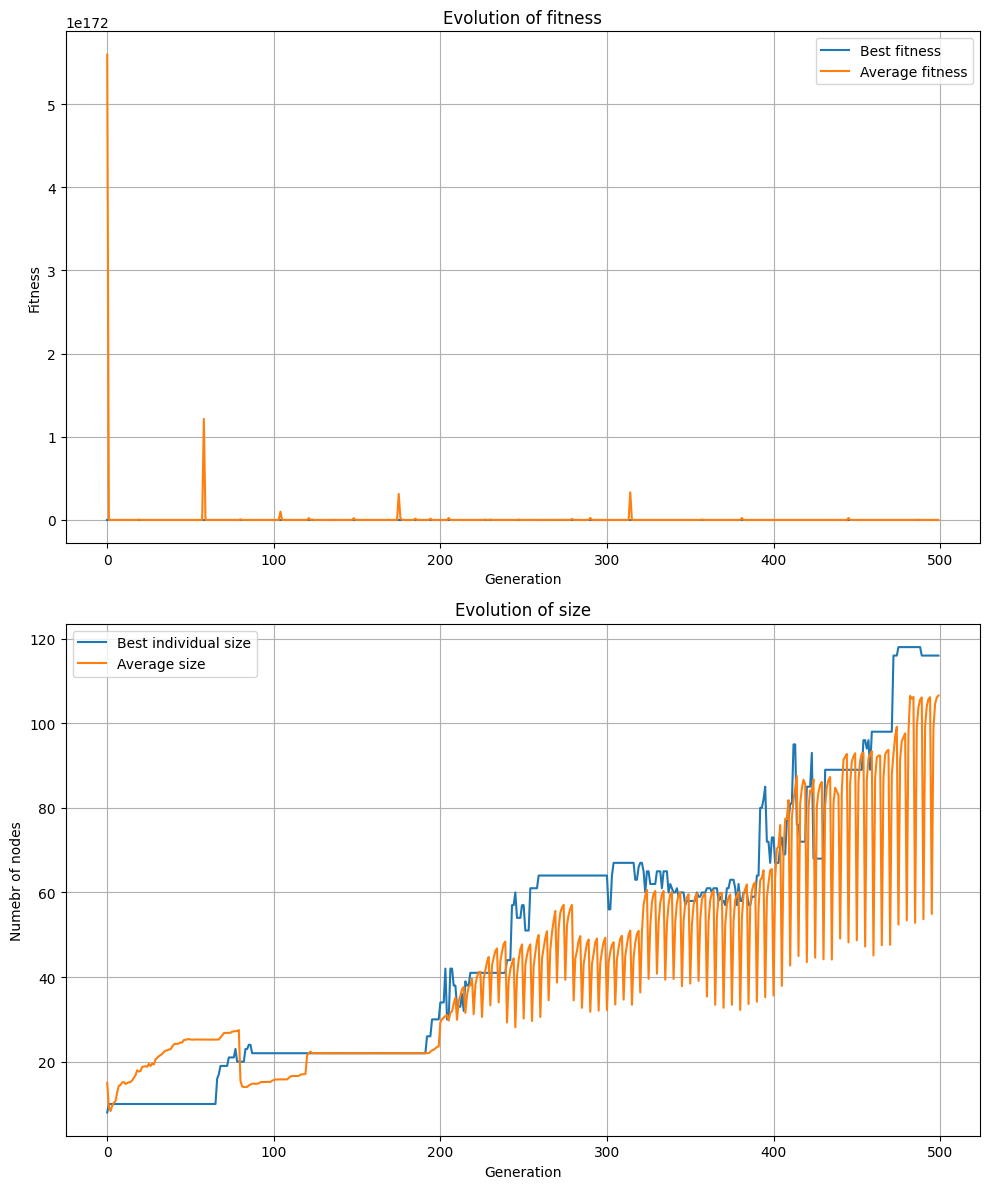

Original expression: ((sqrt(sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793))) - ((x[1] * tan(3.141592653589793)) * ((-9.347525141879945 * 9.590571516689572) * (-11.05365123789452 * 9.590571516689572))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * cos(1.0567228657700947)) + x[1]))) + (x[0] - ((exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - ((x[1] * tan(3.1415926535897

In [53]:
print(f"\n=== GP execution on {problems[6]['file_path']} ===")
best_tree = run_gp_on_problem(problems[6]['file_path'],
    problems[6]['config'],
    function_weights=problems[6]['config'].get('function_weights'),
    terminal_weights=problems[6]['config'].get('terminal_weights'),
    use_islands=problems[6].get('use_islands', False),
    n_islands=problems[6].get('n_islands', 5),
    migration_interval=problems[6].get('migration_interval', 10),
    migration_rate=problems[6].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_7.npz ===
Loading data from ../data/problem_7.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples
Personalised weight for sin: 0.4
Personalised weight for cos: 0.4
Personalised weight for tan: 0.4
Personalised weight for log: 0.4
Personalised weight for sqrt: 0.4

GP execution on ../data/problem_7.npz...
Prima di qualsiasi elaborazione:
X shape: (5000, 2), y shape: (5000,)
X mean: -0.0027038252326045216, y mean: 10.230460379797575
X std: 1.153844314151692, y std: 26.66750114052942
X range: [-1.9996693419963703, 1.9994153166285558], y range: [1.299874436653608, 508.41757230561365]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00


C:\Users\domen\AppData\Local\Temp\ipykernel_20100\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 674.8500195612648 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 711.1578214896316 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 670.1504244456921 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 589.6321909591626 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 666.8368442447633 | Mutation Strength: 0.90
Bloat control: 150 individuals exceed the maximum size
Bloat control: 115 individuals exceed the maximum size
Bloat control: 198 individuals exceed the maximum size
Bloat control: 140 individuals exceed the maximum size
Bloat control: 164 individuals exceed the maximum size


  0%|          | 1/500 [02:48<23:21:21, 168.50s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (log(x[0]) + sqrt((exp(log(189.79034109291632)) * ((x[1] * x[0]) + (x[0] * x[0])))))
  Simplified Expression: sqrt(189.79034109291632*x[0]**2 + 189.79034109291632*x[0]*x[1]) + log(x[0])
  Fitness: 589.6321909591626
  Complexity: 15 nodes
Generation 0, Best Fitness: 589.6321909591626


  0%|          | 2/500 [04:15<16:38:19, 120.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((x[0] * x[1]) * (x[0] + x[1])) * ((x[1] + x[1]) + (x[0] * ((x[0] / x[1]) + (cos(-253.66421093942046) / sqrt((x[0] - (x[1] * x[1]))))))))
  Simplified Expression: x[0]*x[1]*(x[0] + x[1])*(x[0]*(x[0]/x[1] - 0.69325971045187675/sqrt(x[0] - x[1]**2)) + 2*x[1])
  Fitness: 525.9506828609886
  Complexity: 27 nodes


  1%|          | 5/500 [08:28<12:38:23, 91.93s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (exp((x[0] * x[1])) * sqrt(tan((cos(((x[0] - x[1]) * x[1])) * x[1]))))
  Simplified Expression: exp(x[0]*x[1])*sqrt(tan(x[1]*cos(x[1]*(x[0] - x[1]))))
  Fitness: 487.8422769751528
  Complexity: 15 nodes
Bloat control: 33 individuals exceed the maximum size
Bloat control: 22 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


  2%|▏         | 10/500 [16:43<12:14:44, 89.97s/it]

Bloat control: 23 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


  2%|▏         | 11/500 [19:14<14:47:35, 108.91s/it]

Generation 10, Best Fitness: 487.8422769751528


  3%|▎         | 15/500 [24:47<12:02:29, 89.38s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (log(((log((x[1] * log(x[0]))) / sqrt(((x[0] - x[1]) - (x[0] - x[0])))) * exp((x[1] * x[0])))) * exp((x[1] * x[0])))
  Simplified Expression: exp(x[0]*x[1])*log(exp(x[0]*x[1])*log(x[1]*log(x[0]))/sqrt(x[0] - x[1]))
  Fitness: 452.63096654996997
  Complexity: 25 nodes
Bloat control: 24 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


  3%|▎         | 16/500 [27:26<14:48:02, 110.09s/it]

Upgrade the best global individual:
New best solution found:
  Expression: exp(sqrt(((cos(((x[0] + x[1]) * sqrt((x[0] - x[1])))) + (log((cos(-6.64828340066947) * -467.4776705132955)) * cos((log(-116.26293125533431) * (x[0] - x[1]))))) * (x[0] + x[1]))))
  Simplified Expression: exp(sqrt(cos(x[0] + x[1]) * sqrt(x[0] - x[1]) + (log(cos(-6.64828340066947) * -467.4776705132955) * cos(log(-116.26293125533431) * (x[0] - x[1])) * (x[0] + x[1]))))
  Fitness: 378.9528708360498
  Complexity: 29 nodes


  4%|▍         | 20/500 [33:03<12:03:43, 90.47s/it] 

Bloat control: 16 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


  4%|▍         | 21/500 [35:33<14:25:34, 108.42s/it]

Generation 20, Best Fitness: 378.9528708360498


  5%|▍         | 23/500 [38:19<12:39:50, 95.58s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (log(((exp((sqrt((x[0] / 255.4452354999683)) + ((x[1] - x[0]) / x[0]))) / sqrt(((x[0] - x[1]) - (x[0] - x[0])))) * (log(356.91310892746884) / ((x[0] - x[1]) - (x[0] - x[0]))))) * exp((x[1] * x[0])))
  Simplified Expression: exp(x[0]*x[1])*log(5.8774923597948803*exp(0.06256783053988204*sqrt(x[0]) + (-x[0] + x[1])/x[0])/(x[0] - x[1])**(3/2))
  Fitness: 326.8636494783732
  Complexity: 37 nodes


  5%|▌         | 25/500 [41:06<11:46:50, 89.29s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  6%|▌         | 30/500 [49:37<11:52:34, 90.97s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  6%|▌         | 31/500 [52:11<14:18:49, 109.87s/it]

Generation 30, Best Fitness: 326.8636494783732


  7%|▋         | 35/500 [57:47<11:40:38, 90.41s/it] 

Bloat control: 9 individuals exceed the maximum size
Bloat control: 460 individuals exceed the maximum size
Bloat control: 91 individuals exceed the maximum size


  8%|▊         | 39/500 [1:04:34<11:56:31, 93.26s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.230
  Island 2 diversity: 0.274
  Island 3 diversity: 0.282
  Island 4 diversity: 0.128
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.67)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.13)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)


  8%|▊         | 40/500 [1:06:16<12:14:44, 95.84s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 4 individuals exceed the maximum size
Bloat control: 76 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  8%|▊         | 41/500 [1:10:50<19:02:00, 149.28s/it]

Generation 40, Best Fitness: 326.8636494783732


  9%|▉         | 45/500 [1:17:38<14:48:11, 117.12s/it]

Bloat control: 140 individuals exceed the maximum size


 10%|█         | 50/500 [1:28:50<15:01:21, 120.18s/it]

Bloat control: 14 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 25 individuals exceed the maximum size
Bloat control: 1154 individuals exceed the maximum size


 10%|█         | 51/500 [1:33:05<20:02:44, 160.72s/it]

Generation 50, Best Fitness: 326.8636494783732


 11%|█         | 55/500 [1:40:24<15:04:31, 121.96s/it]

Bloat control: 15 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1911 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 12%|█▏        | 60/500 [1:52:54<15:32:09, 127.11s/it]

Bloat control: 1812 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 1851 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:58:13<22:31:00, 184.65s/it]

Generation 60, Best Fitness: 326.8636494783732


 13%|█▎        | 65/500 [2:05:55<16:07:53, 133.50s/it]

Bloat control: 86 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 1994 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 13%|█▎        | 66/500 [2:12:48<26:12:49, 217.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (log((((log(((x[0] * 2.718281828459045) * (x[1] - x[0]))) / (x[0] * sin((x[1] - x[0])))) / (sqrt(x[1]) * (x[1] - ((x[0] * x[1]) / exp(x[0]))))) * (log((-382.7099501179696 - ((x[1] * -49.88984984587623) * (x[0] * x[0])))) / ((x[0] - x[1]) - ((x[1] * x[0]) * ((x[0] - x[1]) - (x[0] - x[0]))))))) * exp((x[1] * x[0])))
  Simplified Expression: exp(x[0]*x[1])*log(-log(2.718281828459045*x[0]*(-x[0] + x[1]))*log(49.88984984587623*x[0]**2*x[1] - 382.7099501179696)/(x[0]*sqrt(x[1])*(-x[0]*x[1]*exp(-x[0]) + x[1])*(-x[0]*x[1]*(x[0] - x[1]) + x[0] - x[1])*sin(x[0] - x[1])))
  Fitness: 322.03623433247446
  Complexity: 60 nodes


 14%|█▍        | 70/500 [2:20:15<16:21:00, 136.88s/it]

Bloat control: 26 individuals exceed the maximum size
Bloat control: 30 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:25:58<23:42:10, 198.91s/it]

Generation 70, Best Fitness: 322.03623433247446


 15%|█▌        | 75/500 [2:33:19<15:32:20, 131.62s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 16%|█▌        | 79/500 [2:44:59<16:36:05, 141.96s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.007
  Island 2 diversity: 0.004
  Island 3 diversity: 0.002
  Island 4 diversity: 0.004
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.01)


 16%|█▌        | 80/500 [2:46:59<15:46:08, 135.16s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 1550 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 1954 individuals exceed the maximum size
Bloat control: 1750 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:51:14<19:56:16, 171.30s/it]

Generation 80, Best Fitness: 322.03623433247446


 17%|█▋        | 85/500 [2:58:41<14:32:18, 126.12s/it]

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 40 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 18%|█▊        | 90/500 [3:11:16<14:38:02, 128.49s/it]

Bloat control: 1997 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1943 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 18%|█▊        | 91/500 [3:15:42<19:16:50, 169.71s/it]

Generation 90, Best Fitness: 322.03623433247446


 19%|█▉        | 95/500 [3:23:12<14:14:07, 126.54s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1985 individuals exceed the maximum size
Bloat control: 25 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 20%|██        | 100/500 [3:35:04<13:56:16, 125.44s/it]

Island 0 | Generation 100 | Best Fitness: 326.8636494783732 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 356.6743629333792 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 322.03623433247446 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 325.25715396558525 | Mutation Strength: 2.43
Island 4 | Generation 100 | Best Fitness: 342.86531082046025 | Mutation Strength: 3.00
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1981 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 20%|██        | 101/500 [3:39:31<18:35:58, 167.82s/it]

Generation 100, Best Fitness: 322.03623433247446


 20%|██        | 102/500 [3:41:21<16:37:56, 150.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (log((((log(((x[0] * 2.644376733863939) * (x[1] - x[0]))) / (((3.141592653589793 / -19.969108235826695) + x[0]) * (x[1] - x[0]))) / (x[1] * (x[1] - ((3.141592653589793 / -385.6635161890224) + x[0])))) * (log((-20.655152549695234 * (tan(x[1]) * tan(x[0])))) / ((x[0] - x[1]) - ((x[1] * x[0]) * ((x[0] - x[1]) - 0.0)))))) * exp((x[1] * (((x[1] / -253.66421093942046) / (tan((x[0] * 2.644376733863939)) * x[1])) + ((((x[0] * x[1]) * (x[1] * x[0])) / -253.66421093942046) + x[0])))))
  Simplified Expression: exp(x[1]*(-0.0039422195046616877*x[0]**2*x[1]**2 + x[0] - 0.0039422195046616877/tan(2.644376733863939*x[0])))*log(log(2.644376733863939*x[0]*(-x[0] + x[1]))*log(-20.655152549695234*tan(x[0])*tan(x[1]))/(x[1]*(-x[0] + x[1])*(x[0] - 0.1573226313608458)*(-x[0] + x[1] + 0.008145942049779029)*(-x[0]*x[1]*(x[0] - x[1]) + x[0] - x[1])))
  Fitness: 101.79420934801004
  Complexity: 78 nodes


 21%|██        | 105/500 [3:46:56<13:43:02, 125.02s/it]

Bloat control: 1995 individuals exceed the maximum size
Bloat control: 1986 individuals exceed the maximum size
Bloat control: 1808 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 22%|██▏       | 110/500 [3:57:58<13:08:53, 121.37s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1936 individuals exceed the maximum size
Bloat control: 956 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 22%|██▏       | 111/500 [4:01:42<16:26:15, 152.12s/it]

Generation 110, Best Fitness: 101.79420934801004


 23%|██▎       | 115/500 [4:09:12<13:04:07, 122.20s/it]

Bloat control: 1996 individuals exceed the maximum size
Bloat control: 1841 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 24%|██▍       | 119/500 [4:19:13<13:46:42, 130.19s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.005
  Island 2 diversity: 0.007
  Island 3 diversity: 0.006
  Island 4 diversity: 0.006
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)


 24%|██▍       | 120/500 [4:21:15<13:29:01, 127.74s/it]

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1776 individuals exceed the maximum size
Bloat control: 1615 individuals exceed the maximum size
Bloat control: 1993 individuals exceed the maximum size
Bloat control: 1996 individuals exceed the maximum size


 24%|██▍       | 121/500 [4:24:53<16:17:33, 154.76s/it]

Generation 120, Best Fitness: 101.79420934801004


 25%|██▌       | 125/500 [4:32:27<12:52:30, 123.60s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 26%|██▌       | 130/500 [4:43:44<12:43:06, 123.75s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 26%|██▌       | 131/500 [4:47:18<15:26:31, 150.65s/it]

Generation 130, Best Fitness: 101.79420934801004


 27%|██▋       | 135/500 [4:54:52<12:34:51, 124.09s/it]

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 28%|██▊       | 140/500 [5:07:03<13:17:24, 132.90s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 28%|██▊       | 141/500 [5:11:38<17:29:03, 175.33s/it]

Generation 140, Best Fitness: 101.79420934801004


 29%|██▉       | 145/500 [5:18:40<12:09:24, 123.28s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 30%|███       | 150/500 [5:28:57<11:05:09, 114.03s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 30%|███       | 151/500 [5:32:18<13:36:28, 140.37s/it]

Generation 150, Best Fitness: 101.79420934801004


 31%|███       | 155/500 [5:39:18<10:46:05, 112.36s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 32%|███▏      | 159/500 [5:47:14<10:16:44, 108.52s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.007
  Island 2 diversity: 0.002
  Island 3 diversity: 0.008
  Island 4 diversity: 0.006
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)


 32%|███▏      | 160/500 [5:49:32<11:04:51, 117.33s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 32%|███▏      | 161/500 [5:53:34<14:33:39, 154.63s/it]

Generation 160, Best Fitness: 101.79420934801004


 33%|███▎      | 165/500 [6:01:29<11:53:21, 127.77s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 34%|███▍      | 170/500 [6:13:33<12:07:22, 132.25s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 34%|███▍      | 171/500 [6:17:30<14:58:17, 163.82s/it]

Generation 170, Best Fitness: 101.79420934801004


 35%|███▌      | 175/500 [6:25:45<12:02:10, 133.33s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 36%|███▌      | 180/500 [6:36:23<10:08:30, 114.09s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 36%|███▌      | 181/500 [6:39:24<11:53:04, 134.12s/it]

Generation 180, Best Fitness: 101.79420934801004


 37%|███▋      | 185/500 [6:45:40<9:03:44, 103.57s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 38%|███▊      | 190/500 [6:58:58<11:39:24, 135.37s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 38%|███▊      | 191/500 [7:03:07<14:32:13, 169.36s/it]

Generation 190, Best Fitness: 101.79420934801004


 39%|███▉      | 195/500 [7:12:46<12:46:51, 150.86s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 40%|███▉      | 199/500 [7:23:00<12:02:03, 143.93s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.002
  Island 2 diversity: 0.005
  Island 3 diversity: 0.008
  Island 4 diversity: 0.004
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)


 40%|████      | 200/500 [7:25:11<11:39:16, 139.85s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 200 | Best Fitness: 101.79420934801004 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 258.33922195461855 | Mutation Strength: 1.52
Island 2 | Generation 200 | Best Fitness: 256.5697220758843 | Mutation Strength: 2.43
Island 3 | Generation 200 | Best Fitness: 256.182414662213 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 254.91951817772147 | Mutation Strength: 3.00
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 40%|████      | 201/500 [7:29:19<14:19:52, 172.55s/it]

Generation 200, Best Fitness: 101.79420934801004


 41%|████      | 205/500 [7:38:40<12:18:11, 150.14s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 42%|████▏     | 210/500 [7:51:37<11:38:45, 144.57s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 42%|████▏     | 211/500 [7:55:51<14:14:39, 177.44s/it]

Generation 210, Best Fitness: 101.79420934801004


 43%|████▎     | 215/500 [8:03:40<10:07:41, 127.94s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 44%|████▍     | 220/500 [8:13:58<8:57:38, 115.21s/it] 

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 44%|████▍     | 221/500 [8:17:17<10:53:27, 140.53s/it]

Generation 220, Best Fitness: 101.79420934801004


 45%|████▌     | 225/500 [8:24:04<8:28:32, 110.96s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 46%|████▌     | 230/500 [8:34:00<8:12:20, 109.41s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 46%|████▌     | 231/500 [8:37:11<10:00:22, 133.91s/it]

Generation 230, Best Fitness: 101.79420934801004


 47%|████▋     | 235/500 [8:43:54<7:59:59, 108.68s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 48%|████▊     | 239/500 [8:52:08<8:07:22, 112.04s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.005
  Island 4 diversity: 0.009
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)


 48%|████▊     | 240/500 [8:53:58<8:02:34, 111.36s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 48%|████▊     | 241/500 [8:57:11<9:46:37, 135.90s/it]

Generation 240, Best Fitness: 101.79420934801004


 49%|████▉     | 245/500 [9:03:55<7:46:03, 109.66s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 50%|█████     | 250/500 [9:13:52<7:35:41, 109.37s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 50%|█████     | 251/500 [9:17:05<9:17:47, 134.41s/it]

Generation 250, Best Fitness: 101.79420934801004


 51%|█████     | 255/500 [9:23:51<7:27:12, 109.52s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 52%|█████▏    | 260/500 [9:33:49<7:17:48, 109.45s/it]

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 52%|█████▏    | 261/500 [9:37:00<8:54:11, 134.11s/it]

Generation 260, Best Fitness: 101.79420934801004


 53%|█████▎    | 265/500 [9:43:46<7:08:28, 109.40s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 54%|█████▍    | 270/500 [9:53:42<6:58:33, 109.19s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 54%|█████▍    | 271/500 [9:56:54<8:32:07, 134.18s/it]

Generation 270, Best Fitness: 101.79420934801004


 55%|█████▌    | 275/500 [10:03:42<6:52:23, 109.97s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 56%|█████▌    | 279/500 [10:12:00<6:56:31, 113.09s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.001
  Island 2 diversity: 0.007
  Island 3 diversity: 0.005
  Island 4 diversity: 0.002
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.00)


 56%|█████▌    | 280/500 [10:13:51<6:52:30, 112.50s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 56%|█████▌    | 281/500 [10:17:08<8:22:40, 137.72s/it]

Generation 280, Best Fitness: 101.79420934801004


 57%|█████▋    | 285/500 [10:24:05<6:43:26, 112.59s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 58%|█████▊    | 290/500 [10:34:16<6:30:39, 111.62s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 58%|█████▊    | 291/500 [10:37:41<8:07:19, 139.90s/it]

Generation 290, Best Fitness: 101.79420934801004


 59%|█████▉    | 295/500 [10:44:26<6:17:18, 110.43s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 60%|██████    | 300/500 [10:53:49<5:47:26, 104.23s/it]

Island 0 | Generation 300 | Best Fitness: 101.79420934801004 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 248.71462413946665 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 248.2018119574492 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 245.8008308037268 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 223.2844476729224 | Mutation Strength: 2.53
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 60%|██████    | 301/500 [10:56:49<7:01:23, 127.05s/it]

Generation 300, Best Fitness: 101.79420934801004


 61%|██████    | 305/500 [11:03:10<5:34:57, 103.06s/it]

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 62%|██████▏   | 310/500 [11:12:36<5:29:46, 104.14s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 62%|██████▏   | 311/500 [11:15:38<6:40:55, 127.28s/it]

Generation 310, Best Fitness: 101.79420934801004


 63%|██████▎   | 315/500 [11:22:06<5:20:11, 103.84s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 64%|██████▍   | 319/500 [11:29:53<5:19:41, 105.97s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.005
  Island 3 diversity: 0.004
  Island 4 diversity: 0.002
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)


 64%|██████▍   | 320/500 [11:31:37<5:16:05, 105.36s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 64%|██████▍   | 321/500 [11:34:35<6:19:56, 127.35s/it]

Generation 320, Best Fitness: 101.79420934801004


 65%|██████▌   | 325/500 [11:40:52<4:58:17, 102.27s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 66%|██████▌   | 330/500 [11:50:10<4:48:25, 101.80s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 66%|██████▌   | 331/500 [11:53:08<5:51:52, 124.93s/it]

Generation 330, Best Fitness: 101.79420934801004


 67%|██████▋   | 335/500 [11:59:26<4:40:42, 102.08s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 68%|██████▊   | 340/500 [12:08:43<4:31:52, 101.95s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 68%|██████▊   | 341/500 [12:11:44<5:32:42, 125.55s/it]

Generation 340, Best Fitness: 101.79420934801004


 69%|██████▉   | 345/500 [12:18:02<4:23:23, 101.96s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 70%|███████   | 350/500 [12:27:21<4:15:45, 102.30s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 70%|███████   | 351/500 [12:30:19<5:10:38, 125.09s/it]

Generation 350, Best Fitness: 101.79420934801004


 71%|███████   | 355/500 [12:36:36<4:05:49, 101.72s/it]

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 72%|███████▏  | 359/500 [12:44:17<4:06:24, 104.85s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.007
  Island 2 diversity: 0.004
  Island 3 diversity: 0.003
  Island 4 diversity: 0.006
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.01)


 72%|███████▏  | 360/500 [12:45:59<4:02:08, 103.77s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 72%|███████▏  | 361/500 [12:48:59<4:53:41, 126.78s/it]

Generation 360, Best Fitness: 101.79420934801004


 73%|███████▎  | 365/500 [12:55:14<3:48:41, 101.64s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 74%|███████▍  | 370/500 [13:04:26<3:39:30, 101.31s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 74%|███████▍  | 371/500 [13:07:26<4:28:42, 124.98s/it]

Generation 370, Best Fitness: 101.79420934801004


 75%|███████▌  | 375/500 [13:13:40<3:30:33, 101.07s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 76%|███████▌  | 380/500 [13:22:55<3:23:05, 101.55s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 76%|███████▌  | 381/500 [13:25:54<4:07:06, 124.59s/it]

Generation 380, Best Fitness: 101.79420934801004


 77%|███████▋  | 385/500 [13:32:09<3:14:23, 101.42s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 78%|███████▊  | 390/500 [13:41:21<3:05:31, 101.19s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 78%|███████▊  | 391/500 [13:44:21<3:46:18, 124.57s/it]

Generation 390, Best Fitness: 101.79420934801004


 79%|███████▉  | 395/500 [13:50:38<2:57:54, 101.66s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 80%|███████▉  | 399/500 [13:58:16<2:55:05, 104.01s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.005
  Island 2 diversity: 0.005
  Island 3 diversity: 0.005
  Island 4 diversity: 0.007
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)


 80%|████████  | 400/500 [13:59:58<2:52:36, 103.57s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 101.79420934801004 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 204.22010302606307 | Mutation Strength: 2.70
Island 2 | Generation 400 | Best Fitness: 201.04260429983353 | Mutation Strength: 2.70
Island 3 | Generation 400 | Best Fitness: 142.63670318094358 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 202.06604135811642 | Mutation Strength: 3.00
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 80%|████████  | 401/500 [14:02:57<3:27:54, 126.00s/it]

Generation 400, Best Fitness: 101.79420934801004


 81%|████████  | 405/500 [14:09:13<2:41:02, 101.71s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 82%|████████▏ | 410/500 [14:18:26<2:31:52, 101.25s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 82%|████████▏ | 411/500 [14:21:25<3:05:00, 124.72s/it]

Generation 410, Best Fitness: 101.79420934801004


 83%|████████▎ | 415/500 [14:27:41<2:23:38, 101.40s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 84%|████████▍ | 420/500 [14:36:54<2:14:47, 101.09s/it]

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 84%|████████▍ | 421/500 [14:39:48<2:41:49, 122.91s/it]

Generation 420, Best Fitness: 101.79420934801004


 85%|████████▌ | 425/500 [14:45:55<2:04:01, 99.21s/it] 

Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 86%|████████▌ | 430/500 [14:54:59<1:55:50, 99.30s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 86%|████████▌ | 431/500 [14:57:54<2:20:18, 122.01s/it]

Generation 430, Best Fitness: 101.79420934801004


 87%|████████▋ | 435/500 [15:04:03<1:47:36, 99.34s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 88%|████████▊ | 439/500 [15:11:34<1:43:59, 102.28s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.005
  Island 2 diversity: 0.005
  Island 3 diversity: 0.006
  Island 4 diversity: 0.004
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)


 88%|████████▊ | 440/500 [15:13:15<1:41:51, 101.87s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 88%|████████▊ | 441/500 [15:16:10<2:01:51, 123.93s/it]

Generation 440, Best Fitness: 101.79420934801004


 89%|████████▉ | 445/500 [15:22:19<1:31:32, 99.86s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 90%|█████████ | 450/500 [15:31:26<1:23:13, 99.87s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 90%|█████████ | 451/500 [15:34:22<1:40:13, 122.71s/it]

Generation 450, Best Fitness: 101.79420934801004


 91%|█████████ | 455/500 [15:40:31<1:14:39, 99.54s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size


 92%|█████████▏| 460/500 [15:49:34<1:06:12, 99.31s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 92%|█████████▏| 461/500 [15:52:30<1:19:28, 122.28s/it]

Generation 460, Best Fitness: 101.79420934801004


 93%|█████████▎| 465/500 [15:58:37<57:49, 99.14s/it]   

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 94%|█████████▍| 470/500 [16:07:39<49:25, 98.85s/it]   

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size


 94%|█████████▍| 471/500 [16:10:33<58:45, 121.57s/it]

Generation 470, Best Fitness: 101.79420934801004


 95%|█████████▌| 475/500 [16:16:40<41:14, 98.96s/it] 

Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 96%|█████████▌| 479/500 [16:24:24<36:40, 104.79s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.005
  Island 2 diversity: 0.006
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)


 96%|█████████▌| 480/500 [16:26:06<34:37, 103.87s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 96%|█████████▌| 481/500 [16:29:06<40:09, 126.83s/it]

Generation 480, Best Fitness: 101.79420934801004


 97%|█████████▋| 485/500 [16:35:14<25:06, 100.41s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1998 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 98%|█████████▊| 490/500 [16:44:17<16:35, 99.51s/it] 

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


 98%|█████████▊| 491/500 [16:47:14<18:22, 122.55s/it]

Generation 490, Best Fitness: 101.79420934801004


 99%|█████████▉| 495/500 [16:53:27<08:22, 100.40s/it]

Bloat control: 2000 individuals exceed the maximum size
Bloat control: 1999 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size
Bloat control: 2000 individuals exceed the maximum size


100%|██████████| 500/500 [17:02:32<00:00, 122.70s/it]

Generation 499, Best Fitness: 101.79420934801004
Algorithm completed in 61776.62 seconds
Best solution found:
  Simplified Expression: exp(x[1]*(-0.0039422195046616877*x[0]**2*x[1]**2 + x[0] - 0.0039422195046616877/tan(2.644376733863939*x[0])))*log(log(2.644376733863939*x[0]*(-x[0] + x[1]))*log(-20.655152549695234*tan(x[0])*tan(x[1]))/(x[1]*(-x[0] + x[1])*(x[0] - 0.1573226313608458)*(-x[0] + x[1] + 0.008145942049779029)*(-x[0]*x[1]*(x[0] - x[1]) + x[0] - x[1])))
  Expression: (log((((log(((x[0] * 2.644376733863939) * (x[1] - x[0]))) / (((3.141592653589793 / -19.969108235826695) + x[0]) * (x[1] - x[0]))) / (x[1] * (x[1] - ((3.141592653589793 / -385.6635161890224) + x[0])))) * (log((-20.655152549695234 * (tan(x[1]) * tan(x[0])))) / ((x[0] - x[1]) - ((x[1] * x[0]) * ((x[0] - x[1]) - 0.0)))))) * exp((x[1] * (((x[1] / -253.66421093942046) / (tan((x[0] * 2.644376733863939)) * x[1])) + ((((x[0] * x[1]) * (x[1] * x[0])) / -253.66421093942046) + x[0])))))
  Fitness: 101.79420934801004
  Complex

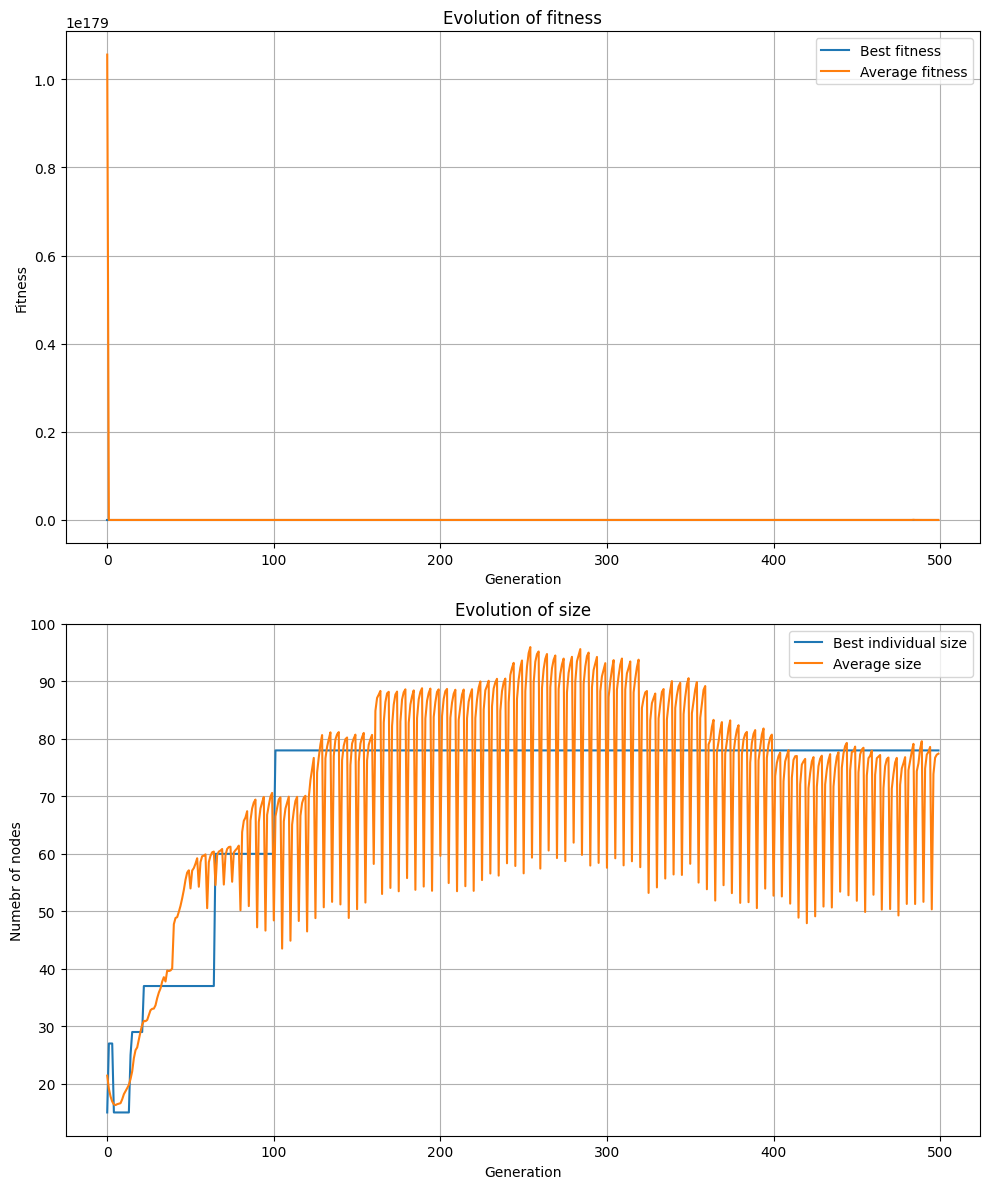

Original expression: (log((((log(((x[0] * 2.644376733863939) * (x[1] - x[0]))) / (((3.141592653589793 / -19.969108235826695) + x[0]) * (x[1] - x[0]))) / (x[1] * (x[1] - ((3.141592653589793 / -385.6635161890224) + x[0])))) * (log((-20.655152549695234 * (tan(x[1]) * tan(x[0])))) / ((x[0] - x[1]) - ((x[1] * x[0]) * ((x[0] - x[1]) - 0.0)))))) * exp((x[1] * (((x[1] / -253.66421093942046) / (tan((x[0] * 2.644376733863939)) * x[1])) + ((((x[0] * x[1]) * (x[1] * x[0])) / -253.66421093942046) + x[0])))))
Simplified expression: exp(x[1]*(-0.0039422195046616877*x[0]**2*x[1]**2 + x[0] - 0.0039422195046616877/tan(2.644376733863939*x[0])))*log(log(2.644376733863939*x[0]*(-x[0] + x[1]))*log(-20.655152549695234*tan(x[0])*tan(x[1]))/(x[1]*(-x[0] + x[1])*(x[0] - 0.1573226313608458)*(-x[0] + x[1] + 0.008145942049779029)*(-x[0]*x[1]*(x[0] - x[1]) + x[0] - x[1])))
Best fitness(MSE): 101.79420934801004


In [ ]:
print(f"\n=== GP execution on {problems[7]['file_path']} ===")
best_tree = run_gp_on_problem(problems[7]['file_path'],
    problems[7]['config'],
    function_weights=problems[7]['config'].get('function_weights'),
    terminal_weights=problems[7]['config'].get('terminal_weights'),
    use_islands=problems[7].get('use_islands', False),
    n_islands=problems[7].get('n_islands', 5),
    migration_interval=problems[7].get('migration_interval', 10),
    migration_rate=problems[7].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_8.npz ===
Loading data from ../data/problem_8.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (50000, 6), y shape (50000,)
Input 6-dimensional with 50000 samples
Personalised weight for sin: 0.1
Personalised weight for cos: 0.1
Personalised weight for tan: 0.1
Personalised weight for exp: 0.1
Personalised weight for log: 0.1
Personalised weight for sqrt: 0.1

GP execution on ../data/problem_8.npz...
Prima di qualsiasi elaborazione:
X shape: (50000, 6), y shape: (50000,)
X mean: 0.0020789645212403165, y mean: -549.7154440795717
X std: 2.8873419846182857, y std: 4765.072335625078
X range: [-4.999981008326298, 4.999945488108838], y range: [-18052.7428193291, 15742.204109576767]
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 10 islands, migration every 40 gen

C:\Users\domen\AppData\Local\Temp\ipykernel_38768\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
c:\Users\domen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 22821812.747804467 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 22783874.15210659 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 22653213.552406747 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 22467967.3773282 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 22698011.014582638 | Mutation Strength: 0.90
Island 5 | Generation 0 | Best Fitness: 22013862.54279993 | Mutation Strength: 0.90
Island 6 | Generation 0 | Best Fitness: 21200748.810587816 | Mutation Strength: 0.90
Island 7 | Generation 0 | Best Fitness: 22985460.209092416 | Mutation Strength: 0.90
Island 8 | Generation 0 | Best Fitness: 21156363.342873566 | Mutation Strength: 0.90
Island 9 | Generation 0 | Best Fitness: 22822093.37629686 | Mutation Strength: 0.90
Bloat control: 108 individuals exceed the maximum size
Bloat control: 159 individuals exceed the maximum size
Bloat control: 128 individuals exceed the max

  0%|          | 1/500 [02:13<18:32:43, 133.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: exp((x[5] + x[3]))
  Simplified Expression: exp(x[3] + x[5])
  Fitness: 21156363.342873566
  Complexity: 4 nodes
Generation 0, Best Fitness: 21156363.342873566


  0%|          | 2/500 [03:15<12:37:09, 91.22s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[5] * x[1]) - (x[0] + x[5])) * ((x[2] + x[1]) + ((x[4] - x[5]) * x[1]))) * (log((12248.044631993122 * x[3])) - ((x[5] - 0.0) + (x[5] - x[3]))))
  Simplified Expression: (-x[0] + x[1]*x[5] - x[5])*(x[3] - 2*x[5] + log(12248.044631993122*x[3]))*(x[1]*(x[4] - x[5]) + x[1] + x[2])
  Fitness: 19434129.509769063
  Complexity: 30 nodes


  1%|          | 4/500 [05:22<10:05:18, 73.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[3] - -896.0565390804986) * (x[5] - x[1]))
  Simplified Expression: (-x[1] + x[5])*(x[3] + 896.0565390804986)
  Fitness: 16391226.373436054
  Complexity: 7 nodes


  1%|          | 5/500 [06:47<10:40:05, 77.59s/it]

Bloat control: 8 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 247 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 31 individuals exceed the maximum size
Bloat control: 24 individuals exceed the maximum size
Bloat control: 144 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size


  1%|          | 6/500 [08:36<12:06:13, 88.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[0] - -896.0565390804986) * (x[1] + x[5]))
  Simplified Expression: (x[0] + 896.0565390804986)*(x[1] + x[5])
  Fitness: 16273025.87231662
  Complexity: 7 nodes


  2%|▏         | 8/500 [10:46<10:21:33, 75.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[3] - -896.0565390804986) * ((x[5] - x[0]) - cos((-14704.50519621247 + x[4]))))
  Simplified Expression: (x[3] + 896.0565390804986)*(-x[0] + x[5] - cos(x[4] - 14704.50519621247))
  Fitness: 15977374.066129753
  Complexity: 12 nodes


  2%|▏         | 10/500 [13:05<10:00:29, 73.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt(((x[3] / ((x[5] - (x[2] * x[4])) + (cos(x[2]) / sin(x[1])))) + x[2])) * sqrt((x[5] * (x[5] * (x[5] * -13149.65446990585))))))
  Simplified Expression: 114.6719428190952*x[5]*sqrt(-x[5]**3)*sqrt(x[2] + x[3]/(-x[2]*x[4] + x[5] + cos(x[2])/sin(x[1])))
  Fitness: 12091002.39918622
  Complexity: 27 nodes
Bloat control: 45 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


  2%|▏         | 11/500 [15:49<13:45:04, 101.24s/it]

Generation 10, Best Fitness: 12091002.39918622


  3%|▎         | 15/500 [21:54<12:36:55, 93.64s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


  3%|▎         | 16/500 [24:10<14:16:36, 106.19s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((x[5] * sqrt(((x[5] * (-13149.65446990585 - ((x[5] * x[5]) * (-13149.65446990585 - 16858.072323768753)))) - (x[5] - ((x[5] * x[5]) * (-13149.65446990585 - 324.2321666469543)))))) - (((exp(x[5]) * ((x[4] + x[3]) + (cos(x[4]) / 324.2321666469543))) * x[5]) * x[5]))
  Simplified Expression: -x[5]**2*(x[3] + x[4] + 0.003084209720280058*cos(x[4]))*exp(x[5]) + x[5]*sqrt(-13473.8866365528*x[5]**2 + x[5]*(30007.726793674603*x[5]**2 - 13149.65446990585) - x[5])
  Fitness: 10723761.145710308
  Complexity: 40 nodes


  4%|▍         | 20/500 [30:46<13:36:54, 102.11s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


  4%|▍         | 21/500 [33:25<15:49:52, 118.98s/it]

Generation 20, Best Fitness: 10723761.145710308


  5%|▍         | 23/500 [36:49<14:35:28, 110.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[5] + (x[5] + x[5])) + (x[5] + x[5])) + (((x[5] + (x[5] + (x[5] + x[5]))) + (((x[5] + (x[5] + x[5])) + x[5]) + x[5])) + x[5])) - ((-1.0 + (0.9234113822121502 / exp((x[5] + x[5])))) + (cos(-830.5910174967903) - ((exp((x[5] + x[1])) + x[5]) + -765.9920454737315))))
  Simplified Expression: 16*x[5] + exp(x[1] + x[5]) - 765.3445437297499 - 0.9234113822121502*exp(-2*x[5])
  Fitness: 10459525.8433564
  Complexity: 50 nodes


  5%|▌         | 25/500 [40:18<14:08:11, 107.14s/it]

Bloat control: 8 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 195 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 76 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size


  6%|▌         | 30/500 [50:17<14:50:10, 113.64s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 914 individuals exceed the maximum size
Bloat control: 888 individuals exceed the maximum size
Bloat control: 162 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size


  6%|▌         | 31/500 [53:07<17:01:01, 130.62s/it]

Generation 30, Best Fitness: 10459525.8433564


  6%|▋         | 32/500 [55:00<16:17:14, 125.29s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((tan(sin(x[5])) * -1.0763819476257168) * 2504.6762441338033) + ((tan(cos(x[5])) * cos(((-1.0 - x[5]) / tan(sin(x[5]))))) * 2504.6762441338033)) + ((tan(sin(x[5])) * cos(((-1.0 - (x[5] - 1.0)) / tan(tan(sin(1.0)))))) * 2504.6762441338033))
  Simplified Expression: 2504.6762441338033*cos(0.48534709955033*x[5])*tan(sin(x[5])) + 2504.6762441338033*cos((-x[5] - 1.0)/tan(sin(x[5])))*tan(cos(x[5])) - 2695.9882938326085*tan(sin(x[5]))
  Fitness: 9990587.79598721
  Complexity: 40 nodes


  7%|▋         | 35/500 [1:00:40<15:10:08, 117.44s/it]

Bloat control: 532 individuals exceed the maximum size
Bloat control: 991 individuals exceed the maximum size
Bloat control: 938 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 897 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


  8%|▊         | 39/500 [1:09:42<15:58:53, 124.80s/it]

Performing inter-island migration...
  Island 0 diversity: 0.149
  Island 1 diversity: 0.005
  Island 2 diversity: 0.064
  Island 3 diversity: 0.011
  Island 4 diversity: 0.003
  Island 5 diversity: 0.005
  Island 6 diversity: 0.046
  Island 7 diversity: 0.058
  Island 8 diversity: 0.006
  Island 9 diversity: 0.003
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.18)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.01)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 1.12)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.04)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

  8%|▊         | 40/500 [1:11:45<15:52:24, 124.23s/it]

Bloat control: 52 individuals exceed the maximum size
Bloat control: 994 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 766 individuals exceed the maximum size
Bloat control: 712 individuals exceed the maximum size
Bloat control: 89 individuals exceed the maximum size
Bloat control: 80 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 942 individuals exceed the maximum size
Bloat control: 112 individuals exceed the maximum size


  8%|▊         | 41/500 [1:15:20<19:19:38, 151.59s/it]

Generation 40, Best Fitness: 9990587.79598721


  8%|▊         | 42/500 [1:17:28<18:23:56, 144.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin(9472.531204264475)) - x[5])) * sqrt(((sin(x[5]) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((-x[5] + sin(x[5]))*sin(x[5]))*sqrt(-x[5] - 0.5552157912043498)*Abs(x[5])
  Fitness: 9364270.427782483
  Complexity: 23 nodes


  9%|▊         | 43/500 [1:19:05<16:31:44, 130.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin((x[5] * sqrt(x[5]))) - x[5])) * sqrt(((sin(x[5]) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((-x[5] + sin(x[5]))*sin(x[5]))*sqrt(-x[5] + sin(x[5]**(3/2)))*Abs(x[5])
  Fitness: 8834723.296089571
  Complexity: 25 nodes


  9%|▉         | 45/500 [1:22:13<14:07:40, 111.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin((x[5] + x[5])) - x[5])) * sqrt(((sin(x[5]) * x[5]) * ((sin(9472.531204264475) - x[5]) * ((sin(x[5]) - x[5]) * 9472.531204264475))))))
  Simplified Expression: x[5]*sqrt(x[5]*(-9472.531204264475*x[5] + 9472.531204264475*sin(x[5]))*(-x[5] - 0.5886223996811918)*sin(x[5]))*sqrt(-x[5] + sin(2*x[5]))
  Fitness: 8388611.959024604
  Complexity: 27 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 992 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


  9%|▉         | 46/500 [1:25:01<16:13:36, 128.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin((x[5] + x[5]))) - x[5])) * sqrt(((sin(x[5]) * x[5]) * ((sin(9472.531204264475) - x[5]) * ((sin(x[5]) - x[5]) * 9472.531204264475))))))
  Simplified Expression: x[5]*sqrt(x[5]*(-9472.531204264475*x[5] + 9472.531204264475*sin(x[5]))*(-x[5] - 0.5886223996811918)*sin(x[5]))*sqrt(-x[5] + sin(sin(2*x[5])))
  Fitness: 8362631.928993887
  Complexity: 28 nodes


  9%|▉         | 47/500 [1:26:30<14:40:34, 116.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin(9472.531204264475)) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] - 0.5552157912043498)*Abs(x[5])
  Fitness: 7497460.28873629
  Complexity: 30 nodes


 10%|▉         | 48/500 [1:28:04<13:48:56, 110.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin(sqrt(x[5]))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(sin(sqrt(x[5]))))*Abs(x[5])
  Fitness: 7446000.062899343
  Complexity: 31 nodes


 10%|█         | 50/500 [1:31:16<12:52:43, 103.03s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 994 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


 10%|█         | 51/500 [1:34:12<15:34:44, 124.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin(sqrt(sin(x[4])))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(sin(sqrt(sin(x[4])))))*Abs(x[5])
  Fitness: 7408353.67049754
  Complexity: 32 nodes
Generation 50, Best Fitness: 7408353.67049754


 11%|█         | 54/500 [1:40:23<15:46:41, 127.36s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin(sqrt(log(x[4])))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(sin(sqrt(log(x[4])))))*Abs(x[5])
  Fitness: 7217105.164311356
  Complexity: 32 nodes


 11%|█         | 55/500 [1:42:29<15:41:57, 127.00s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 11%|█         | 56/500 [1:46:14<19:17:35, 156.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(sin(sin(log(x[4])))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(sin(sin(log(x[4])))))*Abs(x[5])
  Fitness: 7182526.94958411
  Complexity: 32 nodes


 11%|█▏        | 57/500 [1:48:11<17:47:41, 144.61s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9472.531204264475))))))
  Simplified Expression: 97.3269294916082*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))*Abs(x[5])
  Fitness: 7030034.822352506
  Complexity: 32 nodes


 12%|█▏        | 60/500 [1:55:12<17:31:10, 143.34s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:59:21<21:20:28, 175.01s/it]

Generation 60, Best Fitness: 7030034.822352506


 13%|█▎        | 65/500 [2:09:03<19:02:03, 157.52s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 687 individuals exceed the maximum size


 14%|█▍        | 70/500 [2:18:20<13:21:06, 111.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * sqrt(x[5])) - x[5]) * ((sin(x[5]) * x[5]) * (x[5] * 9240.442858347677))))))
  Simplified Expression: 96.12722225440448*x[5]*sqrt((x[5]**(3/2) - x[5])*sin(x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))*Abs(x[5])
  Fitness: 6991546.344622098
  Complexity: 32 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 221 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:21:13<15:29:45, 130.04s/it]

Generation 70, Best Fitness: 6991546.344622098


 15%|█▌        | 75/500 [2:27:33<12:15:17, 103.81s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 16%|█▌        | 79/500 [2:35:08<12:14:08, 104.63s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.006
  Island 2 diversity: 0.007
  Island 3 diversity: 0.003
  Island 4 diversity: 0.003
  Island 5 diversity: 0.007
  Island 6 diversity: 0.003
  Island 7 diversity: 0.003
  Island 8 diversity: 0.002
  Island 9 diversity: 0.003
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.01)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 16%|█▌        | 80/500 [2:36:45<11:54:47, 102.11s/it]

  Migration: 150 individuals from island 9 to island 0(mutation strength: 1.02)
Bloat control: 10 individuals exceed the maximum size
Bloat control: 71 individuals exceed the maximum size
Bloat control: 80 individuals exceed the maximum size
Bloat control: 115 individuals exceed the maximum size
Bloat control: 211 individuals exceed the maximum size
Bloat control: 108 individuals exceed the maximum size
Bloat control: 126 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 338 individuals exceed the maximum size
Bloat control: 232 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:39:34<14:14:32, 122.37s/it]

Generation 80, Best Fitness: 6991546.344622098


 17%|█▋        | 85/500 [2:44:25<9:44:28, 84.50s/it]  

Bloat control: 1 individuals exceed the maximum size


 18%|█▊        | 90/500 [2:51:40<9:06:10, 79.93s/it]  

Bloat control: 1 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:54:01<11:11:11, 98.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((x[5] * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * x[5]) * (x[5] * 9240.442858347677))))))
  Simplified Expression: 96.12722225440448*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6097673.090379277
  Complexity: 32 nodes
Generation 90, Best Fitness: 6097673.090379277


 20%|█▉        | 98/500 [3:03:43<9:42:19, 86.91s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * x[5]) * (x[5] * 9093.336277326785))))))
  Simplified Expression: 95.3589863480458*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6037875.965545133
  Complexity: 32 nodes


 20%|█▉        | 99/500 [3:05:30<10:22:20, 93.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * x[5]) * (x[5] * 9075.515536323843))))))
  Simplified Expression: 95.26550024181809*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6032633.489429443
  Complexity: 32 nodes


 20%|██        | 100/500 [3:07:30<11:12:59, 100.95s/it]

Island 0 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 6032633.489429443 | Mutation Strength: 2.94
Island 3 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 5 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 6 | Generation 100 | Best Fitness: 6991537.957740782 | Mutation Strength: 2.67
Island 7 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 8 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Island 9 | Generation 100 | Best Fitness: 6991546.344622098 | Mutation Strength: 3.00
Bloat control: 1 individuals exceed the maximum size


 20%|██        | 101/500 [3:10:54<14:37:32, 131.96s/it]

Generation 100, Best Fitness: 6032633.489429443


 22%|██▏       | 110/500 [3:30:27<13:32:55, 125.06s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:33:58<16:18:28, 150.92s/it]

Generation 110, Best Fitness: 6032633.489429443


 23%|██▎       | 113/500 [3:37:49<14:16:49, 132.84s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * x[5]) * (((x[2] / 11857.97285342692) - x[5]) * 9075.515536323843))))))
  Simplified Expression: x[5]*sqrt(x[5]**(3/2)*(0.7653513503955311*x[2] - 9075.515536323843*x[5])*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6032619.12619485
  Complexity: 36 nodes


 23%|██▎       | 114/500 [3:39:14<12:41:14, 118.33s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * x[5]) * (((x[5] / 11857.97285342692) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.26148321842069*x[5]*sqrt(-x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6032418.114528252
  Complexity: 36 nodes


 23%|██▎       | 115/500 [3:40:36<11:30:55, 107.68s/it]

Bloat control: 992 individuals exceed the maximum size


 23%|██▎       | 116/500 [3:43:15<13:06:56, 122.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 11857.97285342692) - x[5])) * (((x[5] / 11857.97285342692) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.25746636440756*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6032203.563581198
  Complexity: 40 nodes


 24%|██▎       | 118/500 [3:46:04<10:57:08, 103.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 11857.97285342692) - x[5])) * (((x[5] / 9075.515536323843) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.25623480541782*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6032137.945927796
  Complexity: 40 nodes


 24%|██▍       | 119/500 [3:47:28<10:19:01, 97.49s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.005
  Island 2 diversity: 0.006
  Island 3 diversity: 0.006
  Island 4 diversity: 0.009
  Island 5 diversity: 0.009
  Island 6 diversity: 0.003
  Island 7 diversity: 0.006
  Island 8 diversity: 0.005
  Island 9 diversity: 0.008
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.01)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 24%|██▍       | 120/500 [3:48:56<9:58:54, 94.57s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 9075.515536323843) - x[5])) * (((x[5] / 9075.515536323843) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.25500326235059*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6032072.405719511
  Complexity: 40 nodes
Bloat control: 2 individuals exceed the maximum size
Bloat control: 88 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:51:42<12:13:46, 116.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((x[5] - (3.141592653589793 / 9240.442858347677)) - (3.141592653589793 / 9240.442858347677)) - (3.141592653589793 / 9240.442858347677)) - (3.141592653589793 / 9240.442858347677)) * (sqrt((sin(tan(sin(log(x[4])))) - (((x[5] - (3.141592653589793 / 15118.4326276943)) * sqrt(x[5])) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 11857.97285342692) - x[5])) * (((x[5] / 9075.515536323843) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.25623480541782*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*(x[5] - 0.001359931640398263)*sqrt(-sqrt(x[5])*(x[5] - 0.0002077988327860753) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6030279.378406091
  Complexity: 60 nodes
Generation 120, Best Fitness: 6030279.378406091


 24%|██▍       | 122/500 [3:53:08<11:13:25, 106.89s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 9075.515536323843) - x[5])) * (((x[5] / 9075.515536323843) - x[5]) * 8861.24228642691))))))
  Simplified Expression: 94.12379940314925*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6004218.9502662895
  Complexity: 40 nodes


 25%|██▍       | 124/500 [3:56:01<10:05:25, 96.61s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 9075.515536323843) - x[5])) * (((x[4] / 9075.515536323843) - x[5]) * 8861.24228642691))))))
  Simplified Expression: 0.9999449051933105*x[5]*sqrt(-x[5]**(3/2)*(0.9763899638495107*x[4] - 8861.24228642691*x[5])*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 6004197.550655892
  Complexity: 40 nodes


 25%|██▌       | 125/500 [3:57:26<9:42:11, 93.15s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (tan(-1021.0018810647707) - x[5])) * (((x[5] / 9075.515536323843) - x[5]) * 8861.24228642691))))))
  Simplified Expression: 94.12898542140492*x[5]*sqrt(-x[5]**(3/2)*(0.015732649748284359 - x[5])*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5994248.350569222
  Complexity: 39 nodes
Bloat control: 1 individuals exceed the maximum size


 25%|██▌       | 126/500 [3:59:51<11:18:07, 108.79s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (tan(-1021.0018810647707) - x[5])) * (x[5] * 8861.24228642691))))))
  Simplified Expression: 94.134171725399*x[5]*sqrt(x[5]**(3/2)*(0.015732649748284359 - x[5])*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5994234.578729416
  Complexity: 35 nodes


 25%|██▌       | 127/500 [4:01:17<10:32:50, 101.80s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (tan(-1021.0018810647707) - x[5])) * ((tan(-1021.0018810647707) - x[5]) * 8861.24228642691))))))
  Simplified Expression: x[5]*sqrt(sqrt(x[5])*(0.015732649748284359 - x[5])*(139.41082122704105 - 8861.24228642691*x[5])*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5985643.501977691
  Complexity: 38 nodes


 26%|██▌       | 130/500 [4:05:27<9:12:15, 89.56s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(log(x[4])) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 5130.1489554270665) - x[5])) * (((x[5] / 5629.739005700892) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.247754455145742*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(log(x[4])))
  Fitness: 5976740.289211573
  Complexity: 38 nodes


 26%|██▌       | 131/500 [4:07:58<11:05:39, 108.24s/it]

Generation 130, Best Fitness: 5976740.289211573


 26%|██▋       | 132/500 [4:09:22<10:18:03, 100.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(log(x[4])) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 5130.1489554270665) - x[5])) * (((x[5] / 5130.1489554270665) - x[5]) * 9075.515536323843))))))
  Simplified Expression: 95.246930508059964*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(log(x[4])))
  Fitness: 5976697.306013467
  Complexity: 38 nodes


 27%|██▋       | 133/500 [4:10:44<9:43:18, 95.36s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (tan(-1021.0018810647707) - x[5])) * ((tan(-945.5820811924739) - x[5]) * 8861.24228642691))))))
  Simplified Expression: x[5]*sqrt(sqrt(x[5])*(0.015732649748284359 - x[5])*(330.7445972659287 - 8861.24228642691*x[5])*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5976062.386298982
  Complexity: 38 nodes


 27%|██▋       | 135/500 [4:13:38<9:14:35, 91.17s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (x[5] * (sqrt((sin(log(x[4])) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((x[5] / 5130.1489554270665) - x[5])) * (((x[5] / 5130.1489554270665) - x[5]) * 8931.811926306073))))))
  Simplified Expression: 94.489841670423888*x[5]*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*sqrt(-x[5]**(3/2) + x[5] + sin(log(x[4])))
  Fitness: 5951690.798138602
  Complexity: 38 nodes
Bloat control: 919 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 28%|██▊       | 140/500 [4:21:46<9:01:58, 90.33s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (sqrt(x[4]) * x[5])) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (8744.830310975169 - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[4]*x[5]/(sqrt(x[5]*log(x[5]) - x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5944673.925983207
  Complexity: 56 nodes
Bloat control: 1000 individuals exceed the maximum size


 28%|██▊       | 141/500 [4:24:23<11:00:07, 110.33s/it]

Generation 140, Best Fitness: 5944673.925983207


 29%|██▊       | 143/500 [4:27:16<9:44:12, 98.19s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: (((x[3] / sqrt((((x[5] * log(x[5])) - x[5]) * 1233.525479883865))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (8744.830310975169 - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - x[5])*(x[5]*log(x[5]) - x[5]))*(x[3]/sqrt(1233.525479883865*x[5]*log(x[5]) - 1233.525479883865*x[5]) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5943450.120131233
  Complexity: 46 nodes


 29%|██▉       | 144/500 [4:28:41<9:19:10, 94.24s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (8744.830310975169 - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*sqrt(x[4])/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5932564.227271597
  Complexity: 52 nodes


 29%|██▉       | 145/500 [4:30:08<9:04:36, 92.05s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[5]) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (log(x[5]) * sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (8744.830310975169 - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*sqrt(x[5])/sqrt(sqrt(x[5])*(x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5931682.116122337
  Complexity: 55 nodes
Bloat control: 973 individuals exceed the maximum size


 29%|██▉       | 147/500 [4:34:16<10:18:32, 105.13s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[3]) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * (8744.830310975169 - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]**(3/2)/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5909975.509078473
  Complexity: 52 nodes


 30%|██▉       | 149/500 [4:37:06<9:15:51, 95.02s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[3]) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[5]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - 2*x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]**(3/2)/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5909386.899129627
  Complexity: 54 nodes


 30%|███       | 150/500 [4:38:30<8:54:57, 91.71s/it]

Bloat control: 997 individuals exceed the maximum size


 30%|███       | 151/500 [4:41:10<10:52:10, 112.12s/it]

Generation 150, Best Fitness: 5909386.899129627


 31%|███       | 154/500 [4:45:31<9:11:03, 95.56s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(((x[3] / (x[0] + 11993.408815834955)) - x[3])) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[5]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - 2*x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*sqrt(-x[3] + x[3]/(x[0] + 11993.408815834955))/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5909386.873410052
  Complexity: 60 nodes


 31%|███       | 155/500 [4:46:56<8:49:58, 92.17s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size


 31%|███       | 156/500 [4:49:47<11:04:38, 115.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(((x[3] / x[3]) - x[3])) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[5]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - 2*x[5])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*sqrt(1 - x[3])/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5863963.326586284
  Complexity: 58 nodes


 31%|███▏      | 157/500 [4:51:13<10:11:17, 106.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[3]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[3] - x[5] + 8744.830310975169))*(0.02847252202778095*x[3]*sqrt(3.141592653589793 - x[3])/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5804831.960030055
  Complexity: 56 nodes


 32%|███▏      | 158/500 [4:52:40<9:35:35, 100.98s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(0.02847252202778095*x[3]*sqrt(3.141592653589793 - x[3])/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5804696.133678998
  Complexity: 56 nodes


 32%|███▏      | 159/500 [4:54:05<9:07:24, 96.32s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.006
  Island 2 diversity: 0.004
  Island 3 diversity: 0.006
  Island 4 diversity: 0.011
  Island 5 diversity: 0.004
  Island 6 diversity: 0.005
  Island 7 diversity: 0.002
  Island 8 diversity: 0.002
  Island 9 diversity: 0.002
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 150 individuals from island 8 

 32%|███▏      | 160/500 [4:55:35<8:53:32, 94.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(x[5]))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[4])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - 2*x[4])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*sqrt(3.141592653589793 - x[3])/sqrt((x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5804478.485599953
  Complexity: 56 nodes
Bloat control: 826 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 976 individuals exceed the maximum size
Bloat control: 881 individuals exceed the maximum size
Bloat control: 826 individuals exceed the ma

 32%|███▏      | 161/500 [4:58:22<10:55:54, 116.09s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(0.02847252202778095*x[3]*sqrt(3.141592653589793 - x[3])/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5782942.8599341195
  Complexity: 57 nodes
Generation 160, Best Fitness: 5782942.8599341195


 33%|███▎      | 163/500 [5:01:18<9:31:56, 101.83s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (sqrt((3.141592653589793 - x[3])) * x[3])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((1233.525479883865 * log(x[5])) * x[5])))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(0.02847252202778095*x[3]*(3.141592653589793 - x[3])/sqrt(x[5]*(x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5661364.573012214
  Complexity: 63 nodes


 33%|███▎      | 164/500 [5:02:45<9:06:46, 97.64s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (sqrt((3.141592653589793 - x[3])) * x[3])) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * log(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[4])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - 2*x[4])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*(3.141592653589793 - x[3])/sqrt(x[5]*(x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5660663.490611315
  Complexity: 63 nodes


 33%|███▎      | 165/500 [5:04:18<8:55:54, 95.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: (((((3.141592653589793 - x[3]) * x[3]) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * log(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[4])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(8744.830310975169 - 2*x[4])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*x[3]*(3.141592653589793 - x[3])/sqrt(x[5]*(x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5655121.057262881
  Complexity: 57 nodes
Bloat control: 998 individuals exceed the maximum size
Bloat control: 90 individuals exceed the maximum size
Bloat control: 818 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exc

 33%|███▎      | 166/500 [5:07:09<10:59:45, 118.52s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (sqrt(((3.141592653589793 - x[3]) - x[3])) * x[3])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((1233.525479883865 * log(x[5])) * x[5])))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(0.02847252202778095*x[3]*sqrt(3.141592653589793 - 2*x[3])*sqrt(3.141592653589793 - x[3])/sqrt(x[5]*(x[5]*log(x[5]) - x[5])*log(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5652091.374142598
  Complexity: 65 nodes


 34%|███▎      | 168/500 [5:10:04<9:28:52, 102.81s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (x[5] - (((x[4] * x[4]) + x[5]) + x[3]))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(x[5] + 0.02847252202778095*sqrt(3.141592653589793 - x[3])*(-x[3] - x[4]**2)/sqrt(x[5]*log(sqrt(x[5]))))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5308766.283339903
  Complexity: 60 nodes


 34%|███▍      | 169/500 [5:11:35<9:07:35, 99.26s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (x[5] - (((x[4] * x[4]) + x[5]) + x[3]))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[4] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]**2 - x[4] + 8744.830310975169))*(x[5] + 0.02847252202778095*sqrt(3.141592653589793 - x[3])*(-x[3] - x[4]**2)/sqrt(x[5]*log(sqrt(x[5]))))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5304177.8426301945
  Complexity: 62 nodes


 34%|███▍      | 170/500 [5:13:04<8:48:39, 96.12s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (sqrt(x[5]) - (((x[4] * x[4]) + (x[1] - x[3])) + x[3]))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(x[5] + 0.02847252202778095*sqrt(3.141592653589793 - x[3])*(-x[1] - x[4]**2 + sqrt(x[5]))/sqrt(x[5]*log(sqrt(x[5]))))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5237418.39015198
  Complexity: 63 nodes
Bloat control: 999 individuals exceed the maximum size
Bloat control: 990 individuals exceed the maximum size
Bloat control: 22 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the 

 34%|███▍      | 171/500 [5:15:55<10:49:58, 118.54s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(log(x[4])) * (sqrt(x[5]) - (((x[4] * x[4]) + (x[1] - x[3])) + x[3]))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[5])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4] - x[5] + 8744.830310975169))*(x[5] + 0.02847252202778095*(-x[1] - x[4]**2 + sqrt(x[5]))*sqrt(log(x[4]))/sqrt(x[5]*log(sqrt(x[5]))))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5155441.370644887
  Complexity: 62 nodes
Generation 170, Best Fitness: 5155441.370644887


 34%|███▍      | 172/500 [5:17:25<10:01:32, 110.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt((3.141592653589793 - x[3])) * (x[5] - (((x[4] * x[4]) + x[5]) + x[3]))) / sqrt(((x[5] * x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(x[4])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - x[0])) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[0] - x[4] + 8744.830310975169))*(x[5] + 0.02847252202778095*sqrt(3.141592653589793 - x[3])*(-x[3] - x[4]**2)/(sqrt(log(sqrt(x[5])))*Abs(x[5])))*sqrt(-x[5]**(3/2) + x[5] + sin(tan(sin(log(x[4])))))
  Fitness: 5081761.968935813
  Complexity: 62 nodes


 35%|███▍      | 173/500 [5:18:59<9:33:46, 105.28s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + x[3]))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(8744.830310975169)))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[4] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]**2 - x[4] + 8744.830310975169))*(0.02847252202778095*sqrt(x[4])*(-x[3] - x[4]**2)/sqrt(x[5]*log(sqrt(x[5]))) + x[5])*sqrt(-x[5]**(3/2) + x[5] + 0.3480365111626157)
  Fitness: 4819301.621195734
  Complexity: 60 nodes


 35%|███▍      | 174/500 [5:20:28<9:05:14, 100.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + x[3]))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(8744.830310975169)))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[4] * x[5]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]*x[5] - x[4] + 8744.830310975169))*(0.02847252202778095*sqrt(x[4])*(-x[3] - x[4]**2)/sqrt(x[5]*log(sqrt(x[5]))) + x[5])*sqrt(-x[5]**(3/2) + x[5] + 0.3480365111626157)
  Fitness: 4818167.130373124
  Complexity: 60 nodes


 35%|███▌      | 175/500 [5:21:59<8:48:34, 97.58s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + sqrt(x[4])))) / sqrt((x[5] * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(8744.830310975169)))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[4] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]**2 - x[4] + 8744.830310975169))*(0.02847252202778095*sqrt(x[4])*(-sqrt(x[4]) - x[4]**2)/sqrt(x[5]*log(sqrt(x[5]))) + x[5])*sqrt(-x[5]**(3/2) + x[5] + 0.3480365111626157)
  Fitness: 4637185.1956680585
  Complexity: 61 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 323 individuals exceed the maximum size
Bloat control: 44 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 ind

 35%|███▌      | 176/500 [5:24:51<10:47:52, 119.98s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + sqrt(x[4])))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(8744.830310975169)))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[4] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]**2 - x[4] + 8744.830310975169))*(0.02847252202778095*sqrt(x[4])*(-sqrt(x[4]) - x[4]**2)/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])*sqrt(-x[5]**(3/2) + x[5] + 0.3480365111626157)
  Fitness: 4250206.947755754
  Complexity: 66 nodes


 36%|███▌      | 179/500 [5:29:14<8:50:07, 99.09s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + 0.0))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(sin(log(8744.830310975169)))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[5] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]*x[5] - x[4] + 8744.830310975169))*(-0.02847252202778095*x[4]**(5/2)/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])*sqrt(-x[5]**(3/2) + x[5] + 0.3480365111626157)
  Fitness: 4015811.1742769554
  Complexity: 65 nodes


 36%|███▌      | 180/500 [5:30:41<8:29:11, 95.47s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 36%|███▌      | 181/500 [5:33:39<10:39:09, 120.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + 0.0))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(0.0)) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[5] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]*x[5] - x[4] + 8744.830310975169))*sqrt(-x[5]**(3/2) + x[5])*(-0.02847252202778095*x[4]**(5/2)/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])
  Fitness: 3741929.2086895676
  Complexity: 63 nodes
Generation 180, Best Fitness: 3741929.2086895676


 37%|███▋      | 185/500 [5:39:33<8:26:57, 96.56s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + tan((x[5] / -1021.0018810647707))))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(0.0)) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[5] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]*x[5] - x[4] + 8744.830310975169))*sqrt(-x[5]**(3/2) + x[5])*(0.02847252202778095*sqrt(x[4])*(-x[4]**2 + tan(0.00097943012500342458*x[5]))/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])
  Fitness: 3741856.7494326355
  Complexity: 66 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exc

 37%|███▋      | 186/500 [5:42:17<10:10:25, 116.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + sqrt((x[0] / x[5]))))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((0.0 - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - (x[5] * x[4]))) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5])*(-x[4]*x[5] - x[4] + 8744.830310975169))*sqrt(-x[5]**(3/2) + x[5])*(0.02847252202778095*sqrt(x[4])*(-x[4]**2 - sqrt(x[0]/x[5]))/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])
  Fitness: 3726452.5559203336
  Complexity: 64 nodes


 38%|███▊      | 190/500 [5:47:48<7:40:23, 89.11s/it]  

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 947 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size


 38%|███▊      | 191/500 [5:50:14<9:07:25, 106.30s/it]

Generation 190, Best Fitness: 3726452.5559203336


 38%|███▊      | 192/500 [5:51:29<8:18:15, 97.06s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (x[5] - (((x[4] * x[4]) + x[5]) + tan(3.141592653589793)))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(0.0)) - x[5])) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((8744.830310975169 - x[4]) - -1021.0018810647707)) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(-x[5])*sqrt(x[5]**(5/2)*(9765.8321920399396 - x[4])*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*sqrt(x[4])*(2.33486982377251e-16 - x[4]**2)/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])
  Fitness: 3606547.3620221256
  Complexity: 57 nodes


 39%|███▊      | 193/500 [5:52:43<7:40:02, 89.91s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin(tan(16858.072323768753)) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * 8644.659289224834) * (x[5] * x[5]))))))
  Simplified Expression: 92.9766599164803*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + 0.28999237772941512)
  Fitness: 3540132.8382597053
  Complexity: 54 nodes


 39%|███▉      | 194/500 [5:54:00<7:18:47, 86.04s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin(tan((x[5] / -75.13828695159464))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * 8644.659289224834) * (x[5] * x[5]))))))
  Simplified Expression: 92.9766599164803*sqrt(x[5]**(5/2)*(x[5]*log(x[5]) - x[5]))*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(tan(0.01330879423221635*x[5])))
  Fitness: 3484119.707631874
  Complexity: 56 nodes


 39%|███▉      | 195/500 [5:55:16<7:02:28, 83.11s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((sqrt(x[4]) * (((x[5] * log(x[5])) - x[5]) - (((x[4] * x[4]) + x[5]) + tan(3.141592653589793)))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * log(sqrt(x[5])))))) + x[5]) * (sqrt((sin(tan(0.0)) - x[5])) * sqrt((((x[5] * log(x[5])) - x[5]) * ((sqrt(x[5]) * ((-11228.810917845056 - x[4]) - -1021.0018810647707)) * (x[5] * x[5]))))))
  Simplified Expression: sqrt(-x[5])*sqrt(x[5]**(5/2)*(-x[4] - 10207.809036780285)*(x[5]*log(x[5]) - x[5]))*(0.02847252202778095*sqrt(x[4])*(-x[4]**2 + x[5]*log(x[5]) - 2*x[5] + 2.33486982377251e-16)/sqrt((x[5]*log(x[5]) - x[5])*log(sqrt(x[5]))) + x[5])
  Fitness: 3461461.510852082
  Complexity: 62 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 984 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum si

 39%|███▉      | 197/500 [5:58:51<7:47:08, 92.50s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin(tan((x[5] / -75.13828695159464))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (17871.57465542135 * (x[5] * x[5]))))))
  Simplified Expression: 133.6846088950458*sqrt(x[5]*log(x[5]) - x[5])*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(tan(0.01330879423221635*x[5])))*Abs(x[5])
  Fitness: 3371386.1875298694
  Complexity: 53 nodes


 40%|███▉      | 198/500 [6:00:04<7:15:52, 86.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin(tan((x[5] / -75.13828695159464))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (17953.973521318705 * (x[5] * x[5]))))))
  Simplified Expression: 133.99243829902755*sqrt(x[5]*log(x[5]) - x[5])*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(tan(0.01330879423221635*x[5])))*Abs(x[5])
  Fitness: 3350239.3581338553
  Complexity: 53 nodes


 40%|███▉      | 199/500 [6:01:17<6:55:02, 82.73s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((sqrt(x[5]) * x[5])) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (17871.57465542135 * (x[5] * x[5]))))))
  Simplified Expression: 133.6846088950458*sqrt(x[5]*log(x[5]) - x[5])*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(x[5]**(3/2)))*Abs(x[5])
  Fitness: 2830447.5290310485
  Complexity: 53 nodes
Performing inter-island migration...
  Island 0 diversity: 0.001
  Island 1 diversity: 0.002
  Island 2 diversity: 0.003
  Island 3 diversity: 0.008
  Island 4 diversity: 0.009
  Island 5 diversity: 0.003
  Island 6 diversity: 0.005
  Island 7 diversity: 0.001
  Island 8 diversity: 0.007
  Island 9 diversity: 0.002
  Migration: 150 individuals from island 0 to island 1(mutation

 40%|████      | 200/500 [6:02:35<6:45:48, 81.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin(log((x[5] / -75.13828695159464))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (17953.973521318705 * (x[5] * x[5]))))))
  Simplified Expression: 133.99243829902755*sqrt(x[5]*log(x[5]) - x[5])*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(log(-0.01330879423221635*x[5])))*Abs(x[5])
  Fitness: 2786271.3048329223
  Complexity: 53 nodes
Island 0 | Generation 200 | Best Fitness: 2786271.3048329223 | Mutation Strength: 1.23
Island 1 | Generation 200 | Best Fitness: 3416880.8381682364 | Mutation Strength: 1.82
Island 2 | Generation 200 | Best Fitness: 3413223.361907498 | Mutation Strength: 2.70
Island 3 | Generation 200 | Best Fitness: 3416880.8381682364 | Mutation Strength: 2.70

 40%|████      | 201/500 [6:04:44<7:56:11, 95.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (sqrt(x[5]) * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin(log((x[5] / -75.13828695159464))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (17953.973521318705 * (x[5] * x[5]))))))
  Simplified Expression: 133.99243829902755*(-0.2468064938091466*x[4]**2/sqrt(-x[5]**(3/2)*(x[5]*log(x[5]) - x[5])) + x[5])*sqrt(x[5]*log(x[5]) - x[5])*sqrt(-x[5]**(3/2) + x[5] + sin(log(-0.01330879423221635*x[5])))*Abs(x[5])
  Fitness: 2671715.299628519
  Complexity: 54 nodes
Generation 200, Best Fitness: 2671715.299628519


 41%|████      | 205/500 [6:09:17<6:08:23, 74.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2630104.135313401
  Complexity: 55 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
B

 42%|████▏     | 210/500 [6:16:05<6:01:00, 74.69s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


 42%|████▏     | 211/500 [6:18:13<7:16:17, 90.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1233.525479883865 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 / (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.2468064938091466*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046/(x[5]*log(x[5]))))*Abs(x[5])
  Fitness: 2613934.7616595626
  Complexity: 55 nodes
Generation 210, Best Fitness: 2613934.7616595626


 43%|████▎     | 215/500 [6:22:49<5:54:27, 74.62s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1170.341970912218 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.2533811219053959*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2580038.6833890313
  Complexity: 55 nodes
Bloat control: 999 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Blo

 44%|████▍     | 220/500 [6:29:24<5:40:04, 72.87s/it]

Bloat control: 999 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 44%|████▍     | 221/500 [6:31:32<6:54:26, 89.13s/it]

Generation 220, Best Fitness: 2580038.6833890313


 45%|████▍     | 223/500 [6:33:47<6:00:55, 78.18s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1094.6610014744379 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.26199368399172084*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2522245.6146346238
  Complexity: 55 nodes


 45%|████▌     | 225/500 [6:36:06<5:37:38, 73.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1023.8957304270549 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.27089611625903402*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2471795.1658261013
  Complexity: 55 nodes
Bloat control: 999 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 990 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 46%|████▌     | 230/500 [6:42:44<5:30:17, 73.40s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 986 individuals exceed the maximum size
Bloat control: 988 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 994 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size


 46%|████▌     | 231/500 [6:44:50<6:39:55, 89.20s/it]

Generation 230, Best Fitness: 2471795.1658261013


 47%|████▋     | 235/500 [6:49:19<5:20:46, 72.63s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1023.8957304270549 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-18318.786072569113 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.27089611625903402*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(18318.786072569113*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2468918.905651423
  Complexity: 55 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 991 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 989 individuals exceed the maximum size
Bloat control: 993 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


 47%|████▋     | 236/500 [6:51:28<6:33:51, 89.51s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (933.8482149231324 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(-x[5]*log(x[5]) + x[5])*(-0.2836563421987698*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2415947.4365540915
  Complexity: 55 nodes


 48%|████▊     | 239/500 [6:54:52<5:29:27, 75.74s/it]

Performing inter-island migration...
  Island 0 diversity: 0.010
  Island 1 diversity: 0.004
  Island 2 diversity: 0.010
  Island 3 diversity: 0.003
  Island 4 diversity: 0.001
  Island 5 diversity: 0.008
  Island 6 diversity: 0.004
  Island 7 diversity: 0.001
  Island 8 diversity: 0.006
  Island 9 diversity: 0.003
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.02)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 0.50)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 1.01)
  Migration: 150 individuals from island 8 

 48%|████▊     | 240/500 [6:56:01<5:20:32, 73.97s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size


 48%|████▊     | 241/500 [6:58:07<6:26:17, 89.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (1023.8957304270549 * (x[5] * (x[5] / -81.00377813061033)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16441.559272975952 * (x[5] * x[5]))))))
  Simplified Expression: 128.22464378182515*sqrt(-x[5]*log(x[5]) + x[5])*(-0.28127087985243569*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))*Abs(x[5])
  Fitness: 2377981.933683739
  Complexity: 55 nodes
Generation 240, Best Fitness: 2377981.933683739


 49%|████▉     | 245/500 [7:02:40<5:13:31, 73.77s/it]

Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 49%|████▉     | 246/500 [7:04:47<6:20:12, 89.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (-810.5783425295558 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16441.559272975952 * ((tan(-810.5783425295558) - x[5]) * x[5]))))))
  Simplified Expression: 128.22464378182515*sqrt(-x[5]*(-x[5] - 0.04747351948495951)*(x[5]*log(x[5]) - x[5]))*(-0.3044620357007448*x[4]**2/(sqrt(x[5]*log(x[5]) - x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))
  Fitness: 2259356.2482149014
  Complexity: 58 nodes


 50%|█████     | 250/500 [7:09:17<5:04:41, 73.13s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 50%|█████     | 251/500 [7:11:26<6:12:41, 89.81s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (-810.5783425295558 * (x[5] * (x[5] / -79.118582368355)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16441.559272975952 * ((sin(-810.5783425295558) - x[5]) * x[5]))))))
  Simplified Expression: 128.22464378182515*sqrt(-x[5]*(-x[5] - 0.04742011337298495)*(x[5]*log(x[5]) - x[5]))*(-0.3124221024084283*x[4]**2/(sqrt(x[5]*log(x[5]) - x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))
  Fitness: 2246979.393987851
  Complexity: 58 nodes
Generation 250, Best Fitness: 2246979.393987851


 51%|█████     | 255/500 [7:15:55<4:58:28, 73.10s/it]

Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 52%|█████▏    | 260/500 [7:22:36<4:55:48, 73.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (-744.8135676373249 * (x[5] * (x[5] / -75.13828695159464)))))) + x[5]) * (sqrt((sin((-16710.93520953046 * (x[5] * log(x[5])))) - ((sqrt(x[5]) * x[5]) - x[5]))) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16441.559272975952 * ((sin(-810.5783425295558) - x[5]) * x[5]))))))
  Simplified Expression: 128.22464378182515*sqrt(-x[5]*(-x[5] - 0.04742011337298495)*(x[5]*log(x[5]) - x[5]))*(-0.3176192787041016*x[4]**2/(sqrt(x[5]*log(x[5]) - x[5])*Abs(x[5])) + x[5])*sqrt(-x[5]**(3/2) + x[5] - sin(16710.93520953046*x[5]*log(x[5])))
  Fitness: 2242906.421979232
  Complexity: 58 nodes
Bloat control: 998 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
B

 52%|█████▏    | 261/500 [7:24:42<5:57:10, 89.67s/it]

Generation 260, Best Fitness: 2242906.421979232


 52%|█████▏    | 262/500 [7:25:47<5:26:16, 82.26s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (972.1273032042224 * (x[5] * (x[5] / -77.10373260012094)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.2816281944976098*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1974867.143787052
  Complexity: 47 nodes


 53%|█████▎    | 265/500 [7:29:13<4:46:46, 73.22s/it]

Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 53%|█████▎    | 266/500 [7:31:24<5:53:44, 90.70s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (972.1273032042224 * (x[5] * (x[5] / -82.35096197266247)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.2910534609454219*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1927082.6180053514
  Complexity: 47 nodes


 54%|█████▎    | 268/500 [7:33:35<5:01:25, 77.96s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (972.1273032042224 * (x[5] * (x[5] / -84.94149201219872)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.295595876966198*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1907386.4898302923
  Complexity: 47 nodes


 54%|█████▍    | 270/500 [7:35:54<4:41:16, 73.38s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (891.779517895864 * (x[5] * (x[5] / -84.94149201219872)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3086250660563131*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1862918.778468687
  Complexity: 47 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the

 54%|█████▍    | 271/500 [7:38:05<5:46:22, 90.75s/it]

Generation 270, Best Fitness: 1862918.778468687


 55%|█████▌    | 275/500 [7:42:37<4:36:40, 73.78s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (891.779517895864 * (x[5] * (x[5] / -88.10814062523832)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3143252513032222*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1849073.0825649502
  Complexity: 47 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the m

 56%|█████▌    | 279/500 [7:48:10<4:39:04, 75.77s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.006
  Island 2 diversity: 0.003
  Island 3 diversity: 0.007
  Island 4 diversity: 0.006
  Island 5 diversity: 0.004
  Island 6 diversity: 0.004
  Island 7 diversity: 0.005
  Island 8 diversity: 0.004
  Island 9 diversity: 0.007
  Migration: 150 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 56%|█████▌    | 280/500 [7:49:20<4:31:23, 74.01s/it]

  Migration: 150 individuals from island 9 to island 0(mutation strength: 0.50)
Bloat control: 136 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 25 individuals exceed the maximum size
Bloat control: 129 individuals exceed the maximum size
Bloat control: 101 individuals exceed the maximum size
Bloat control: 131 individuals exceed the maximum size
Bloat control: 147 individuals exceed the maximum size
Bloat control: 112 individuals exceed the maximum size
Bloat control: 140 individuals exceed the maximum size


 56%|█████▌    | 281/500 [7:52:04<6:08:33, 100.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (816.1747638613734 * (x[5] * (x[5] / -88.10814062523832)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3285613218015353*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1829403.8447989076
  Complexity: 47 nodes
Generation 280, Best Fitness: 1829403.8447989076


 56%|█████▋    | 282/500 [7:53:06<5:24:19, 89.26s/it] 

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (811.3734960462255 * (x[5] * (x[5] / -88.10814062523832)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3295320116709279*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1828838.158392763
  Complexity: 47 nodes


 57%|█████▋    | 283/500 [7:54:09<4:53:58, 81.28s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (816.1747638613734 * (x[5] * (x[5] / -88.95649675054965)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3301393216238481*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1828534.5836675782
  Complexity: 47 nodes


 57%|█████▋    | 285/500 [7:56:16<4:19:35, 72.44s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (814.2701417798353 * (x[5] * (x[5] / -88.95649675054965)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3305252030072123*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1828361.8280523675
  Complexity: 47 nodes
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum si

 57%|█████▋    | 286/500 [7:58:54<5:49:37, 98.02s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (804.3147970306193 * (x[5] * (x[5] / -88.10814062523832)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3309748460883395*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1828180.263495584
  Complexity: 47 nodes


 57%|█████▋    | 287/500 [7:59:56<5:10:02, 87.33s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (810.366975897308 * (x[5] * (x[5] / -90.53627078108272)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.3342492440602388*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1827498.6773123997
  Complexity: 47 nodes


 58%|█████▊    | 289/500 [8:02:05<4:25:28, 75.49s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (804.3147970306193 * (x[5] * (x[5] / -88.10814062523832)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * ((-10714.139997089842 / (2504.6762441338033 - x[5])) * x[5]))))))
  Simplified Expression: 13380.70623387298*sqrt(x[5])*sqrt(x[5]*(x[5]*log(x[5]) - x[5])/(2504.6762441338033 - x[5]))*(-0.3309748460883395*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])
  Fitness: 1692944.554951241
  Complexity: 51 nodes


 58%|█████▊    | 290/500 [8:03:09<4:11:52, 71.97s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 829 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 58%|█████▊    | 291/500 [8:05:35<5:28:00, 94.16s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * (883.3932674910496 * (x[5] * (x[5] / -88.10814062523832)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * ((-10714.139997089842 / (2504.6762441338033 - x[5])) * x[5]))))))
  Simplified Expression: 13380.70623387298*sqrt(x[5])*sqrt(x[5]*(x[5]*log(x[5]) - x[5])/(2504.6762441338033 - x[5]))*(-0.3158137071380495*x[4]**2/(sqrt(-x[5]*log(x[5]) + x[5])*Abs(x[5])) + x[5]**(3/2) - x[5])
  Fitness: 1552872.198588459
  Complexity: 51 nodes
Generation 290, Best Fitness: 1552872.198588459


 59%|█████▉    | 295/500 [8:09:49<4:01:35, 70.71s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 60%|██████    | 300/500 [8:16:51<4:01:36, 72.48s/it] 

Island 0 | Generation 300 | Best Fitness: 1822462.1798878605 | Mutation Strength: 2.67
Island 1 | Generation 300 | Best Fitness: 2262485.486890856 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 2161315.062771853 | Mutation Strength: 2.65
Island 3 | Generation 300 | Best Fitness: 1827954.9035470728 | Mutation Strength: 2.97
Island 4 | Generation 300 | Best Fitness: 1827623.7023631823 | Mutation Strength: 3.00
Island 5 | Generation 300 | Best Fitness: 1552872.198588459 | Mutation Strength: 3.00
Island 6 | Generation 300 | Best Fitness: 1714249.5671591354 | Mutation Strength: 2.70
Island 7 | Generation 300 | Best Fitness: 1823107.4869597496 | Mutation Strength: 3.00
Island 8 | Generation 300 | Best Fitness: 1830328.8899035137 | Mutation Strength: 3.00
Island 9 | Generation 300 | Best Fitness: 1827498.6773123997 | Mutation Strength: 3.00
Bloat control: 3 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 999 indivi

 60%|██████    | 301/500 [8:19:27<5:22:59, 97.38s/it]

Generation 300, Best Fitness: 1552872.198588459


 61%|██████    | 305/500 [8:23:42<3:53:52, 71.96s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 62%|██████▏   | 310/500 [8:30:31<3:47:59, 72.00s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 62%|██████▏   | 311/500 [8:33:14<5:12:20, 99.16s/it]

Generation 310, Best Fitness: 1552872.198588459


 62%|██████▏   | 312/500 [8:34:16<4:36:03, 88.10s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -91.89763883143529)) * ((17659.268920348037 + x[2]) * (x[5] / -91.89763883143529)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-91.89763883143529*x[4]**2/sqrt(x[5]**3*(x[2] + 17659.268920348037)*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1443087.1222892543
  Complexity: 53 nodes


 63%|██████▎   | 314/500 [8:36:24<3:54:29, 75.64s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -91.89763883143529)) * ((-16803.841183432523 - 5224.955631459325) * (x[5] / -91.89763883143529)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6191686579178417*x[4]**2/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1155519.21676852
  Complexity: 53 nodes


 63%|██████▎   | 315/500 [8:37:27<3:41:58, 71.99s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 64%|██████▍   | 319/500 [8:43:15<3:46:46, 75.17s/it]

Performing inter-island migration...
  Island 0 diversity: 0.010
  Island 1 diversity: 0.010
  Island 2 diversity: 0.005
  Island 3 diversity: 0.004
  Island 4 diversity: 0.005
  Island 5 diversity: 0.008
  Island 6 diversity: 0.006
  Island 7 diversity: 0.007
  Island 8 diversity: 0.003
  Island 9 diversity: 0.007
  Migration: 150 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.01)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 64%|██████▍   | 320/500 [8:44:23<3:38:49, 72.94s/it]

  Migration: 150 individuals from island 9 to island 0(mutation strength: 1.01)
Bloat control: 881 individuals exceed the maximum size
Bloat control: 106 individuals exceed the maximum size
Bloat control: 111 individuals exceed the maximum size
Bloat control: 992 individuals exceed the maximum size
Bloat control: 919 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 920 individuals exceed the maximum size
Bloat control: 913 individuals exceed the maximum size
Bloat control: 880 individuals exceed the maximum size


 64%|██████▍   | 321/500 [8:46:29<4:25:18, 88.93s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -91.89763883143529)))))) + ((sqrt(x[5]) * x[5]) - (((((814.2701417798353 + x[3]) + x[3]) + x[0]) / (-5835.490983998832 - x[5])) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6598018588933994*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] - (x[0] + 2*x[3] + 814.2701417798353)/(-x[5] - 5835.490983998832))*Abs(x[5])
  Fitness: 1117983.6387372059
  Complexity: 63 nodes
Generation 320, Best Fitness: 1117983.6387372059


 65%|██████▌   | 325/500 [8:50:37<3:20:00, 68.57s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 65%|██████▌   | 326/500 [8:53:11<4:33:34, 94.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -80.64749214651239)) * (17871.57465542135 * (x[5] / -80.64749214651239)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16543.89365714521 * (x[5] * x[5]))))))
  Simplified Expression: 128.6230681376603*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6032668443517518*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 1111807.3285129769
  Complexity: 51 nodes


 66%|██████▌   | 330/500 [8:57:27<3:23:07, 71.69s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 66%|██████▌   | 331/500 [9:00:09<4:37:58, 98.69s/it]

Generation 330, Best Fitness: 1111807.3285129769


 67%|██████▋   | 335/500 [9:04:17<3:15:19, 71.03s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 985 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


 68%|██████▊   | 340/500 [9:10:52<3:06:30, 69.94s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 68%|██████▊   | 341/500 [9:13:29<4:14:21, 95.98s/it]

Generation 340, Best Fitness: 1111807.3285129769


 69%|██████▉   | 345/500 [9:17:40<3:03:05, 70.88s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 70%|███████   | 350/500 [9:24:21<2:55:17, 70.11s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 50 individuals exceed the maximum size


 70%|███████   | 351/500 [9:26:52<3:54:29, 94.42s/it]

Generation 350, Best Fitness: 1111807.3285129769


 71%|███████   | 355/500 [9:31:03<2:50:22, 70.50s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 970 individuals exceed the maximum size


 72%|███████▏  | 359/500 [9:36:48<2:54:07, 74.10s/it]

Performing inter-island migration...
  Island 0 diversity: 0.011
  Island 1 diversity: 0.009
  Island 2 diversity: 0.009
  Island 3 diversity: 0.005
  Island 4 diversity: 0.007
  Island 5 diversity: 0.005
  Island 6 diversity: 0.004
  Island 7 diversity: 0.008
  Island 8 diversity: 0.009
  Island 9 diversity: 0.004
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 0.50)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.01)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 1.00)
  Migration: 150 individuals from island 8 

 72%|███████▏  | 360/500 [9:37:52<2:46:29, 71.35s/it]

  Migration: 150 individuals from island 9 to island 0(mutation strength: 1.02)
Bloat control: 895 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 930 individuals exceed the maximum size
Bloat control: 896 individuals exceed the maximum size
Bloat control: 993 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 917 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 72%|███████▏  | 361/500 [9:39:59<3:23:46, 87.96s/it]

Generation 360, Best Fitness: 1111807.3285129769


 73%|███████▎  | 363/500 [9:42:01<2:49:28, 74.22s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - (((x[2] + ((x[5] * x[5]) + 901.649807940122)) / -5835.490983998832) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0001713651863642739*x[2] - 0.6332921815358654*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) + 0.0001713651863642739*x[5]**2 - x[5] + 0.1545113873729708)*Abs(x[5])
  Fitness: 1079457.7958045544
  Complexity: 61 nodes


 73%|███████▎  | 364/500 [9:43:03<2:40:11, 70.67s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((((sqrt(x[5]) * x[5]) + ((x[5] * x[5]) + 901.649807940122)) / -5835.490983998832) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6332921815358654*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + 1.000171365186364*x[5]**(3/2) + 0.0001713651863642739*x[5]**2 - x[5] + 0.1545113873729708)*Abs(x[5])
  Fitness: 1079097.3112141057
  Complexity: 64 nodes


 73%|███████▎  | 365/500 [9:44:07<2:34:35, 68.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((((sqrt(x[5]) * x[5]) + ((x[4] * x[5]) + 901.649807940122)) / -5835.490983998832) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6332921815358654*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + 0.0001713651863642739*x[4]*x[5] + 1.000171365186364*x[5]**(3/2) - x[5] + 0.1545113873729708)*Abs(x[5])
  Fitness: 1075512.7086572454
  Complexity: 64 nodes
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 890 individ

 73%|███████▎  | 366/500 [9:46:31<3:23:34, 91.15s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((((sqrt(x[5]) * x[5]) + (x[5] + 901.649807940122)) / -5835.490983998832) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6332921815358654*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + 1.000171365186364*x[5]**(3/2) - 0.9998286348136357*x[5] + 0.1545113873729708)*Abs(x[5])
  Fitness: 1075220.7637857476
  Complexity: 62 nodes


 73%|███████▎  | 367/500 [9:47:32<3:02:18, 82.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((((sqrt(x[5]) * x[5]) + (x[3] + 901.649807940122)) / -5835.490983998832) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0001713651863642739*x[3] - 0.6332921815358654*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + 1.000171365186364*x[5]**(3/2) - x[5] + 0.1545113873729708)*Abs(x[5])
  Fitness: 1074617.0861190374
  Complexity: 62 nodes


 74%|███████▎  | 368/500 [9:48:36<2:48:51, 76.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((((sqrt(x[5]) * -84.66141760491249) + (x[3] + 901.649807940122)) / -5835.490983998832) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0001713651863642739*x[3] - 0.6332921815358654*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - 0.01450801960572945*sqrt(x[5]) - x[5] + 0.1545113873729708)*Abs(x[5])
  Fitness: 1057599.8493404584
  Complexity: 62 nodes


 74%|███████▍  | 370/500 [9:50:43<2:31:15, 69.81s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 75 individuals exceed the maximum size
Bloat control: 989 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 74%|███████▍  | 371/500 [9:53:08<3:19:02, 92.58s/it]

Generation 370, Best Fitness: 1057599.8493404584


 75%|███████▌  | 375/500 [9:57:17<2:25:15, 69.72s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 915 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 986 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 76%|███████▌  | 378/500 [10:01:42<2:35:45, 76.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((17871.57465542135 * (x[5] / -84.66141760491249)) * (x[5] * (x[5] / -76.64691667090561)))))) + ((sqrt(((814.2701417798353 / (x[3] + -5835.490983998832)) + x[5])) * x[5]) - ((814.2701417798353 / -3800.499756270723) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6025716607214586*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]*sqrt(x[5] + 814.2701417798353/(x[3] - 5835.490983998832)) - x[5] + 0.2142534387579716)*Abs(x[5])
  Fitness: 1032287.7943991693
  Complexity: 61 nodes


 76%|███████▌  | 379/500 [10:02:45<2:25:54, 72.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((17871.57465542135 * (x[5] / -84.66141760491249)) * (x[5] * (x[5] / -76.64691667090561)))))) + ((sqrt(((814.2701417798353 / (x[5] + -5835.490983998832)) + x[5])) * x[5]) - ((814.2701417798353 / -3800.499756270723) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.6025716607214586*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]*sqrt(x[5] + 814.2701417798353/(x[5] - 5835.490983998832)) - x[5] + 0.2142534387579716)*Abs(x[5])
  Fitness: 1032141.1640247572
  Complexity: 61 nodes


 76%|███████▌  | 380/500 [10:03:47<2:18:57, 69.48s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((19011.343125618354 * (x[5] / -84.66141760491249)) * (x[5] * (x[5] / -76.64691667090561)))))) + ((sqrt(((814.2701417798353 / (x[3] + -5835.490983998832)) + x[5])) * x[5]) - ((814.2701417798353 / -3800.499756270723) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.58422980941903402*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]*sqrt(x[5] + 814.2701417798353/(x[3] - 5835.490983998832)) - x[5] + 0.2142534387579716)*Abs(x[5])
  Fitness: 1027038.4526868799
  Complexity: 61 nodes
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 915 individuals exceed the maximum size
Bloat contr

 76%|███████▌  | 381/500 [10:06:04<2:57:42, 89.60s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) * ((19011.343125618354 * (x[5] / -84.66141760491249)) * (x[5] * (x[5] / -76.64691667090561)))))) + ((sqrt(((814.2701417798353 / (x[5] + -5835.490983998832)) + x[5])) * x[5]) - ((814.2701417798353 / -3800.499756270723) + x[5]))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16710.93520953046 * (x[5] * x[5]))))))
  Simplified Expression: 129.2707825052918*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-0.58422980941903402*x[4]**2/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]*sqrt(x[5] + 814.2701417798353/(x[5] - 5835.490983998832)) - x[5] + 0.2142534387579716)*Abs(x[5])
  Fitness: 1026891.7513048997
  Complexity: 61 nodes
Generation 380, Best Fitness: 1026891.7513048997


 77%|███████▋  | 385/500 [10:10:17<2:13:52, 69.85s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 78%|███████▊  | 390/500 [10:16:38<2:06:31, 69.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (x[1] - (x[4] + x[1]))) / sqrt((((x[5] * log(x[5])) - x[5]) + ((x[5] * (x[5] / -84.66141760491249)) * (17871.57465542135 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - x[5])) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16543.89365714521 * (x[5] * x[5]))))))
  Simplified Expression: 128.6230681376603*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(-x[4]**2/sqrt(2.493398806483159*x[5]**3 + x[5]*log(x[5]) - x[5]) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 895581.7509119189
  Complexity: 51 nodes
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 992 individuals exceed the maximum size
Bloat control: 935 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 ind

 78%|███████▊  | 391/500 [10:18:59<2:44:30, 90.55s/it]

Generation 390, Best Fitness: 895581.7509119189


 79%|███████▉  | 395/500 [10:23:11<2:01:54, 69.67s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 850 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 946 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 80%|███████▉  | 399/500 [10:28:44<2:02:56, 73.04s/it]

Performing inter-island migration...
  Island 0 diversity: 0.008
  Island 1 diversity: 0.007
  Island 2 diversity: 0.011
  Island 3 diversity: 0.005
  Island 4 diversity: 0.006
  Island 5 diversity: 0.008
  Island 6 diversity: 0.008
  Island 7 diversity: 0.008
  Island 8 diversity: 0.007
  Island 9 diversity: 0.003
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.01)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.00)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 80%|████████  | 400/500 [10:29:50<1:57:55, 70.75s/it]

Island 0 | Generation 400 | Best Fitness: 970959.2350572912 | Mutation Strength: 2.70
Island 1 | Generation 400 | Best Fitness: 1412996.1360288786 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 1822088.865416518 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 895581.7509119189 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 1099090.439642307 | Mutation Strength: 3.00
Island 5 | Generation 400 | Best Fitness: 1085190.5368716046 | Mutation Strength: 3.00
Island 6 | Generation 400 | Best Fitness: 1086592.0781826398 | Mutation Strength: 3.00
Island 7 | Generation 400 | Best Fitness: 1026779.2345498217 | Mutation Strength: 3.00
Island 8 | Generation 400 | Best Fitness: 970072.8426833099 | Mutation Strength: 2.19
Island 9 | Generation 400 | Best Fitness: 970234.4232656924 | Mutation Strength: 2.70
Bloat control: 909 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals

 80%|████████  | 401/500 [10:32:06<2:29:27, 90.58s/it]

Generation 400, Best Fitness: 895581.7509119189


 81%|████████  | 405/500 [10:36:22<1:51:33, 70.45s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 984 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 82%|████████▏ | 410/500 [10:42:56<1:45:40, 70.45s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 994 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 934 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


 82%|████████▏ | 411/500 [10:45:11<2:12:58, 89.65s/it]

Generation 410, Best Fitness: 895581.7509119189


 83%|████████▎ | 415/500 [10:49:27<1:39:43, 70.39s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 994 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 84%|████████▍ | 420/500 [10:55:57<1:33:06, 69.84s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 969 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 84%|████████▍ | 421/500 [10:58:09<1:56:28, 88.46s/it]

Generation 420, Best Fitness: 895581.7509119189


 85%|████████▌ | 425/500 [11:02:26<1:28:07, 70.50s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 997 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 86%|████████▌ | 430/500 [11:08:57<1:22:01, 70.30s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 889 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 86%|████████▌ | 431/500 [11:11:16<1:44:26, 90.82s/it]

Generation 430, Best Fitness: 895581.7509119189


 87%|████████▋ | 435/500 [11:15:36<1:17:32, 71.58s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 764 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 996 individuals exceed the maximum size
Bloat control: 995 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 88%|████████▊ | 439/500 [11:21:01<1:14:11, 72.97s/it]

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.007
  Island 2 diversity: 0.007
  Island 3 diversity: 0.008
  Island 4 diversity: 0.005
  Island 5 diversity: 0.006
  Island 6 diversity: 0.006
  Island 7 diversity: 0.011
  Island 8 diversity: 0.006
  Island 9 diversity: 0.003
  Migration: 150 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 1.00)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.01)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 88%|████████▊ | 440/500 [11:22:09<1:11:28, 71.48s/it]

  Migration: 150 individuals from island 9 to island 0(mutation strength: 1.01)
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 915 individuals exceed the maximum size
Bloat control: 877 individuals exceed the maximum size
Bloat control: 854 individuals exceed the maximum size
Bloat control: 990 individuals exceed the maximum size
Bloat control: 928 individuals exceed the maximum size
Bloat control: 988 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size


 88%|████████▊ | 441/500 [11:24:22<1:28:42, 90.22s/it]

Generation 440, Best Fitness: 895581.7509119189


 89%|████████▉ | 445/500 [11:29:15<1:11:07, 77.60s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 90%|████████▉ | 449/500 [11:35:13<1:09:03, 81.25s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((1.0 / x[4]) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * (18380.037020607593 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log(-87.31736297425388) / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -88.58494835211248) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: x[4] * (1.0 / x[4]) - x[4]) / sqrt(x[5] * logx[5] - x[5]) * (x[5] * (x[5] / -78.46816005437017) * (18380.037020607593 * (x[5] / -84.66141760491249) + (sqrtx[5] * x[5]) - (log(-87.31736297425388) / -84.66141760491249) + (x[3] / -84.66141760491249) + (x[3] / -84.66141760491249) + (x[3] / -88.58494835211248) + x[5]) * (sqrtx[5] * sqrt(x[5] * logx[5] - x[5]) * (-16499.249450017396 * (x[5] * x[5])))
  Fitness: 888922.4792512388
  Complexity: 68 nodes


 90%|█████████ | 450/500 [11:36:27<1:05:47, 78.95s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((1.0 / x[4]) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * (16634.836240455235 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log((8644.659289224834 / x[5])) / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -88.58494835211248) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0349121112845646*x[3] + 0.63194639075192959*x[4]*(-x[4] + 1.0/x[4])/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01181175591302613*log(8644.659289224834/x[5]))*Abs(x[5])
  Fitness: 886625.5582338448
  Complexity: 70 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed 

 90%|█████████ | 451/500 [11:38:44<1:18:41, 96.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((1.0 / x[4]) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (18380.037020607593 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log(-87.31736297425388) / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -88.58494835211248) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: x[4] * (1.0 / x[4]) - x[4]) / sqrt(x[5] * logx[5] - x[5]) * (x[5] * (x[5] / -84.66141760491249) * (18380.037020607593 * (x[5] / -84.66141760491249) + (sqrtx[5] * x[5]) - (log(-87.31736297425388) / -84.66141760491249) + (x[3] / -84.66141760491249) + (x[3] / -84.66141760491249) + (x[3] / -88.58494835211248) + x[5]) * (sqrtx[5] * sqrt(x[5] * logx[5] - x[5]) * (-16499.249450017396 * (x[5] * x[5])))
  Fitness: 877689.3090227905
  Complexity: 68 nodes
Generation

 91%|█████████ | 455/500 [11:43:34<58:56, 78.59s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((1.0 / x[4]) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (18380.037020607593 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log(-84.66141760491249) / -84.66141760491249) + ((x[3] / -87.31736297425388) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: x[4] * (1.0 / x[4]) - x[4]) / sqrt(x[5] * logx[5] - x[5]) * (x[5] * (x[5] / -84.66141760491249) * (18380.037020607593 * (x[5] / -84.66141760491249) + (sqrtx[5] * x[5]) - (log(-84.66141760491249) / -84.66141760491249) + (x[3] / -87.31736297425388) + (x[3] / -84.66141760491249) + (x[3] / -87.31736297425388) + x[5]) * (sqrtx[5] * sqrt(x[5] * logx[5] - x[5]) * (-16499.249450017396 * (x[5] * x[5])))
  Fitness: 877595.5549304977
  Complexity: 68 nodes
Bloat cont

 91%|█████████ | 456/500 [11:45:49<1:09:55, 95.35s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((1.0 / x[4]) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * (-16499.249450017396 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log(((-9491.228946246647 / x[5]) / x[5])) / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.63453766834412983*x[4]*(-x[4] + 1.0/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01181175591302613*log(-9491.228946246647/x[5]**2))*Abs(x[5])
  Fitness: 877292.2389674608
  Complexity: 72 nodes


 91%|█████████▏| 457/500 [11:46:58<1:02:46, 87.58s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * (18073.29656393028 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log((x[2] + x[5])) / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.6062766123147349*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237*log(x[2] + x[5]))*Abs(x[5])
  Fitness: 875857.3500783717
  Complexity: 78 nodes


 92%|█████████▏| 458/500 [11:48:10<57:57, 82.80s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * (18073.29656393028 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log((x[2] + x[5])) / 2327.72864884224) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.6062766123147349*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] - 0.000429603339073641*log(x[2] + x[5]))*Abs(x[5])
  Fitness: 870100.6699415797
  Complexity: 78 nodes


 92%|█████████▏| 459/500 [11:49:24<54:46, 80.17s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + (2327.72864884224 + -1.0)) / ((2373.05095503361 + x[5]) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * ((-17057.83946884288 - x[4]) * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log((x[4] + (x[5] + x[5]))) / -89.11503286199647) + ((x[3] / -84.66141760491249) + (0.0 + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0232642318689807*x[3] + 81.50598546764615*x[4]*(-x[4] + 4653.45729768448/(x[4]*(x[5] + 2373.05095503361)))/sqrt(x[5]**3*(-x[4] - 17057.83946884288)*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237*log(x[4] + 2*x[5]))*Abs(x[5])
  Fitness: 861552.4838416178
  Complexity: 82 nodes


 92%|█████████▏| 460/500 [11:50:37<52:00, 78.01s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -78.46816005437017)) * (16306.350740885728 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log((x[2] + x[5])) / 2327.72864884224) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.63827981863346866*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] - 0.000429603339073641*log(x[2] + x[5]))*Abs(x[5])
  Fitness: 839911.699573751
  Complexity: 78 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals ex

 92%|█████████▏| 461/500 [11:52:50<1:01:31, 94.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (18073.29656393028 * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((log(x[4]) / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.6297480751231967*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237*log(x[4]))*Abs(x[5])
  Fitness: 839515.0941249696
  Complexity: 76 nodes
Generation 460, Best Fitness: 839515.0941249696


 92%|█████████▏| 462/500 [11:54:02<55:39, 87.89s/it]  

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * ((-17057.83946884288 - x[4]) * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 84.66141760491249*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(-x[4] - 17057.83946884288)*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 836405.6657409826
  Complexity: 77 nodes


 93%|█████████▎| 463/500 [11:55:14<51:10, 83.00s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * ((-17057.83946884288 - x[5]) * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 84.66141760491249*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(-x[5] - 17057.83946884288)*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 836332.935732043
  Complexity: 77 nodes


 93%|█████████▎| 464/500 [11:56:27<47:57, 79.94s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * ((-17057.83946884288 - x[5]) * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 85.97913543949504*x[4]*(-x[4] + 1.96220797357135/x[4])/sqrt(x[5]**3*(-x[5] - 17057.83946884288)*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 835587.5821191875
  Complexity: 77 nodes


 93%|█████████▎| 465/500 [11:57:42<45:48, 78.53s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -87.31736297425388) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * ((-17057.83946884288 - -89.11503286199647) * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.6499215503445989*x[4]*(-x[4] + 2.036307868009673/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 835373.0325885961
  Complexity: 77 nodes
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individ

 93%|█████████▎| 466/500 [11:59:56<53:58, 95.24s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + x[5]) + 2327.72864884224) / ((2373.05095503361 + -84.66141760491249) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * ((-17057.83946884288 - -89.11503286199647) * (x[5] / -84.66141760491249)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.6499215503445989*x[4]*(-x[4] + 0.0004369885387273837*(x[5] + 4655.45729768448)/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 835222.7652255702
  Complexity: 77 nodes


 93%|█████████▎| 467/500 [12:01:08<48:35, 88.34s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2373.05095503361) / ((2373.05095503361 + -1.0) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -84.66141760491249) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03507598778200684*x[3] + 0.6583109247053087*x[4]*(-x[4] + 1.98131477483765/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 835183.3791755869
  Complexity: 75 nodes


 94%|█████████▎| 468/500 [12:02:20<44:30, 83.46s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03471670782493527*x[3] + 0.6583109247053087*x[4]*(-x[4] + 2.037910631599036/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 833934.3807427118
  Complexity: 75 nodes


 94%|█████████▍| 469/500 [12:03:34<41:32, 80.42s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + x[5]) + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03471670782493527*x[3] + 0.6583109247053087*x[4]*(-x[4] + 0.0004378406549379806*(x[5] + 4655.45729768448)/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 833767.2734790649
  Complexity: 75 nodes


 94%|█████████▍| 470/500 [12:04:49<39:29, 78.97s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + -1.0) + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -89.11503286199647) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0341264031966615*x[3] + 0.6583109247053087*x[4]*(-x[4] + 2.037910631599036/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 833726.2144805277
  Complexity: 75 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum

 94%|█████████▍| 471/500 [12:07:04<46:13, 95.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((((2327.72864884224 + x[5]) + 2327.72864884224) / ((2327.72864884224 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03471670782493527*x[3] + 0.6583109247053087*x[4]*(-x[4] + 0.0004467050467582009*(x[5] + 4655.45729768448)/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 833255.3406944767
  Complexity: 75 nodes
Generation 470, Best Fitness: 833255.3406944767


 94%|█████████▍| 472/500 [12:08:14<40:59, 87.85s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03471670782493527*x[3] + 0.6583109247053087*x[4]*(-x[4] + 2.1158233232661329/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 833173.3470013086
  Complexity: 73 nodes


 95%|█████████▍| 473/500 [12:09:27<37:38, 83.65s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -89.11503286199647)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -84.66141760491249) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03471670782493527*x[3] + 0.6650529778690304*x[4]*(-x[4] + 2.1158233232661329/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 833023.9478364108
  Complexity: 73 nodes


 95%|█████████▍| 474/500 [12:10:41<34:59, 80.76s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -89.11503286199647) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0341264031966615*x[3] + 0.6583109247053087*x[4]*(-x[4] + 2.1158233232661329/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 832965.3245500601
  Complexity: 73 nodes


 95%|█████████▌| 475/500 [12:11:57<33:00, 79.21s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -89.11503286199647)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -87.31736297425388) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0343574278678637*x[3] + 0.6650529778690304*x[4]*(-x[4] + 2.1158233232661329/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 832891.150546107
  Complexity: 73 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
B

 95%|█████████▌| 476/500 [12:14:12<38:21, 95.90s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -89.11503286199647)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -87.31736297425388) + ((x[3] / -89.11503286199647) + ((x[3] / -87.31736297425388) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0341264031966615*x[3] + 0.6650529778690304*x[4]*(-x[4] + 2.1158233232661329/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 832815.7898062831
  Complexity: 73 nodes


 96%|█████████▌| 479/500 [12:17:48<28:09, 80.45s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.005
  Island 2 diversity: 0.001
  Island 3 diversity: 0.009
  Island 4 diversity: 0.006
  Island 5 diversity: 0.005
  Island 6 diversity: 0.006
  Island 7 diversity: 0.010
  Island 8 diversity: 0.005
  Island 9 diversity: 0.013
  Migration: 150 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 150 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 150 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 150 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 150 individuals from island 4 to island 5(mutation strength: 0.50)
  Migration: 150 individuals from island 5 to island 6(mutation strength: 1.00)
  Migration: 150 individuals from island 6 to island 7(mutation strength: 1.01)
  Migration: 150 individuals from island 7 to island 8(mutation strength: 0.50)
  Migration: 150 individuals from island 8 

 96%|█████████▌| 480/500 [12:19:06<26:34, 79.71s/it]

  Migration: 150 individuals from island 9 to island 0(mutation strength: 0.50)
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 96%|█████████▌| 481/500 [12:21:18<30:09, 95.24s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -88.91308157103774)))))) + ((sqrt(x[5]) * x[5]) - ((1.0 / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.6642989833891819*x[4]*(-x[4] + 2.1158233232661329/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01122145128475237)*Abs(x[5])
  Fitness: 832634.6161847482
  Complexity: 73 nodes
Generation 480, Best Fitness: 832634.6161847482


 97%|█████████▋| 483/500 [12:23:39<23:30, 82.99s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2504.6762441338033) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (0.0 + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.6583109247053087*x[4]*(-x[4] + 2.1932981742782917/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 832053.7513615182
  Complexity: 71 nodes


 97%|█████████▋| 485/500 [12:26:00<19:08, 76.56s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + (2504.6762441338033 + x[5])) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (0.0 + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.6583109247053087*x[4]*(-x[4] + 0.0004378406549379806*(x[5] + 5009.3524882676066)/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 831893.3965030814
  Complexity: 73 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 999 individuals exceed the maximum size
Blo

 97%|█████████▋| 486/500 [12:28:12<21:42, 93.07s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2504.6762441338033) / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (0.0 + ((x[3] / -89.11503286199647) + ((x[3] / -97.55662030617391) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03269336016901544*x[3] + 0.6583109247053087*x[4]*(-x[4] + 2.1932981742782917/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 831888.6676636038
  Complexity: 71 nodes


 97%|█████████▋| 487/500 [12:29:19<18:28, 85.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((5224.955631459325 / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -89.11503286199647)))))) + ((sqrt(x[5]) * x[5]) - (((x[3] / -89.11503286199647) / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03353843288532104*x[3] + 0.6650529778690304*x[4]*(-x[4] + 2.287697995700041/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 831216.8543109491
  Complexity: 73 nodes


 98%|█████████▊| 489/500 [12:31:40<14:14, 77.72s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((5224.955631459325 / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -89.11503286199647)))))) + ((sqrt(x[5]) * x[5]) - (((x[3] / -89.11503286199647) / -84.66141760491249) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0335318088106917*x[3] + 0.6650529778690304*x[4]*(-x[4] + 2.287697995700041/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 831215.3814309555
  Complexity: 73 nodes


 98%|█████████▊| 490/500 [12:32:49<12:30, 75.01s/it]

Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 998 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the maximum size


 98%|█████████▊| 491/500 [12:35:00<13:45, 91.77s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * ((5224.955631459325 / ((2373.05095503361 + -89.11503286199647) * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-17057.83946884288 * (x[5] / -89.11503286199647)))))) + ((sqrt(x[5]) * x[5]) - (((x[3] / -84.66141760491249) / -84.66141760491249) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.0335248362765082*x[3] + 0.6650529778690304*x[4]*(-x[4] + 2.287697995700041/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 831213.8380430916
  Complexity: 73 nodes
Generation 490, Best Fitness: 831213.8380430916


 98%|█████████▊| 492/500 [12:36:07<11:15, 84.43s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / (2037.7808318240168 * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-16499.249450017396 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((x[5] / (-87.31736297425388 * (x[5] * x[5]))) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.66936188569461263*x[4]*(-x[4] + 2.3714056082520708/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01145247595595457/x[5])*Abs(x[5])
  Fitness: 829797.6098951099
  Complexity: 75 nodes


 99%|█████████▉| 494/500 [12:38:28<07:45, 77.57s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / (2037.7808318240168 * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-16499.249450017396 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (((x[5] * log(x[5])) / (-87.31736297425388 * (x[5] * x[5]))) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.66936188569461263*x[4]*(-x[4] + 2.3714056082520708/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.01145247595595457*log(x[5])/x[5])*Abs(x[5])
  Fitness: 829560.6583559066
  Complexity: 78 nodes


 99%|█████████▉| 495/500 [12:39:38<06:16, 75.27s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / (2037.7808318240168 * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-16499.249450017396 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - ((x[3] / (-87.31736297425388 * (x[5] * x[5]))) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.01145247595595457*x[3]/x[5]**2 + 0.66936188569461263*x[4]*(-x[4] + 2.3714056082520708/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5])*Abs(x[5])
  Fitness: 826844.7435002693
  Complexity: 75 nodes
Bloat control: 1000 individuals exceed the maximum size
Bloat control: 1000 individuals exceed the

 99%|█████████▉| 496/500 [12:41:48<06:06, 91.71s/it]

Upgrade the best global individual:
New best solution found:
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / (2037.7808318240168 * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-16499.249450017396 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (((x[5] * log((2504.6762441338033 + 2327.72864884224))) / (-87.31736297425388 * (x[5] * x[5]))) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.66936188569461263*x[4]*(-x[4] + 2.3714056082520708/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.097152493401359259/x[5])*Abs(x[5])
  Fitness: 822604.9257389839
  Complexity: 80 nodes


100%|██████████| 500/500 [12:46:26<00:00, 91.97s/it]

Generation 499, Best Fitness: 822604.9257389839
Algorithm completed in 46665.05 seconds
Best solution found:
  Simplified Expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.66936188569461263*x[4]*(-x[4] + 2.3714056082520708/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.097152493401359259/x[5])*Abs(x[5])
  Expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / (2037.7808318240168 * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-16499.249450017396 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (((x[5] * log((2504.6762441338033 + 2327.72864884224))) / (-87.31736297425388 * (x[5] * x[5]))) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
  Fitness: 822604.9257389839
  Complexity: 80 nodes


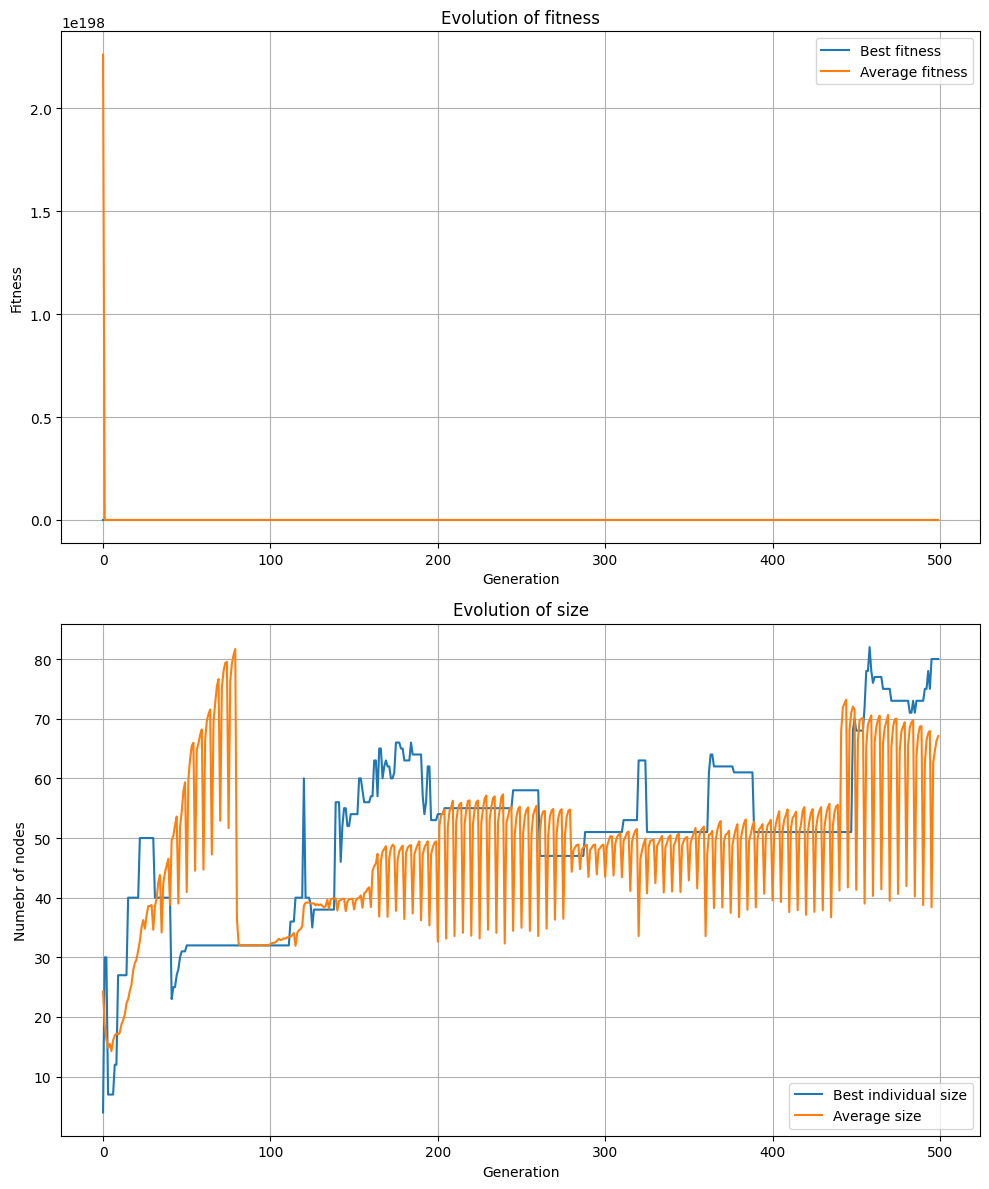

Original expression: ((((x[4] * (((2504.6762441338033 + 2327.72864884224) / (2037.7808318240168 * x[4])) - x[4])) / sqrt((((x[5] * log(x[5])) - x[5]) * ((x[5] * (x[5] / -84.66141760491249)) * (-16499.249450017396 * (x[5] / -87.31736297425388)))))) + ((sqrt(x[5]) * x[5]) - (((x[5] * log((2504.6762441338033 + 2327.72864884224))) / (-87.31736297425388 * (x[5] * x[5]))) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + ((x[3] / -89.11503286199647) + x[5])))))) * (sqrt(x[5]) * sqrt((((x[5] * log(x[5])) - x[5]) * (-16499.249450017396 * (x[5] * x[5]))))))
Simplified expression: 128.4494042415822*sqrt(x[5])*sqrt(-x[5]*log(x[5]) + x[5])*(0.03366435385425711*x[3] + 0.66936188569461263*x[4]*(-x[4] + 2.3714056082520708/x[4])/sqrt(-x[5]**3*(x[5]*log(x[5]) - x[5])) + x[5]**(3/2) - x[5] + 0.097152493401359259/x[5])*Abs(x[5])
Best fitness(MSE): 82260.49257389839


In [60]:
print(f"\n=== GP execution on {problems[8]['file_path']} ===")
best_tree = run_gp_on_problem(problems[8]['file_path'],
    problems[8]['config'],
    function_weights=problems[8]['config'].get('function_weights'),
    terminal_weights=problems[8]['config'].get('terminal_weights'),
    use_islands=problems[8].get('use_islands', False),
    n_islands=problems[8].get('n_islands', 5),
    migration_interval=problems[8].get('migration_interval', 10),
    migration_rate=problems[8].get('migration_rate', 0.1),
)  

In [41]:
def debug_fitness_difference(tree, X, y):
    # Fitness memorizzato
    print(f"Espressione: {tree.to_string()}")
    print(f"Fitness memorizzato: {tree.fitness}")
    print(f"Adjusted fitness memorizzato: {tree.adjusted_fitness}")
    
    # Ricalcola il fitness
    recalculated_fitness = calculate_fitness(tree, X, y)
    print(f"Fitness ricalcolato: {recalculated_fitness}")
    
    # Confronta
    print(f"Differenza: {abs(tree.fitness - recalculated_fitness)}")

In [49]:
# Copyright © 2024 Giovanni Squillero <giovanni.squillero@polito.it>
# https://github.com/squillero/computational-intelligence
# Free under certain conditions — see the license for details.
# !! todo metti le funzioni safe 
import numpy as np

# All numpy's mathematical functions can be used in formulas
# see: https://numpy.org/doc/stable/reference/routines.math.html


# Notez bien: No need to include f0 -- it's just an example!
def f0(x: np.ndarray) -> np.ndarray:
    return ((((x[0] + ((-2.8636943484015354 * safe_cos((x[1] - -1.583968308262229))) * safe_exp(-3.2082386888331254))) + (safe_sin(x[1]) * safe_exp(-3.154932922313467))) + (safe_sin((x[1] + (safe_sqrt(safe_tan(3.141592653589793)) * (3.141592653589793 / safe_exp(-3.2082386888331254))))) * safe_exp(-3.154932922313467))) - safe_sqrt(((safe_sqrt(safe_tan(3.141592653589793)) * ((-3.154932922313467 / 0.2607832440731248) / 0.2532699192266387)) * ((x[1] + ((x[1] - -1.0329760905609568) - -1.1123733897283157)) * ((safe_sin(safe_sin(x[1])) - -1.0439752897500634) + safe_cos((-1.9944929251132986 * (x[1] - 3.1410124598253333))))))))


def f1(x: np.ndarray) -> np.ndarray: 
    return safe_sin(x[0])


def f2(x: np.ndarray) -> np.ndarray:
    return (((1430908.1901754038 / safe_exp(safe_sqrt((safe_sqrt((x[2] + x[1])) - 0.0)))) * ((safe_cos((safe_sqrt(x[0]) + 0.0)) * (((x[1] + (x[0] + x[2])) + ((x[2] + x[1]) + x[1])) + ((x[2] + (x[0] + x[1])) + ((x[2] + x[0]) + (x[2] + x[1]))))) + ((x[2] + x[0]) + (x[0] + (safe_sin(x[0]) + (x[0] + (x[0] + x[1]))))))) - (((((((x[0] + x[0]) * x[2]) - safe_log(x[0])) - safe_log(x[0])) - safe_log(safe_sin(safe_exp(x[1])))) * ((((x[1] + (x[1] + x[1])) * (safe_sqrt(-4378885.515735305) + safe_sqrt(-4408770.793543419))) - x[2]) + (((x[0] + x[1]) + ((x[2] + x[1]) / (x[1] + x[1]))) * (safe_sqrt(-4005445.0725207813) + x[2])))) * (safe_sqrt((x[2] + x[1])) - 0.0)))


def f3(x: np.ndarray) -> np.ndarray:
    return ((((((x[2] * safe_sin(1.184037735453649)) - (x[2] - safe_sqrt(safe_cos(1.2158401721189076)))) - safe_log(safe_sqrt(safe_cos(108.78615012548357)))) - (safe_cos(safe_log(((x[2] - 2.674670908359565) - 2.6590687466126757))) - safe_sqrt(((x[2] - safe_sqrt(x[2])) - 3.17864466323484)))) + ((((x[0] * x[0]) - (x[2] - safe_sin(108.78615012548357))) - x[2]) + ((x[0] * x[0]) - x[2]))) - ((x[1] * x[1]) * x[1]))


def f4(x: np.ndarray) -> np.ndarray:
    return (safe_cos((safe_exp((-8.23509920982603 - (safe_cos((x[0] + x[1])) * x[0]))) + ((((x[1] + safe_tan(3.141592653589793)) + safe_tan(3.141592653589793)) + safe_tan(3.141592653589793)) - safe_tan(safe_exp(-10.613659135997567))))) + ((safe_sqrt(((-10.822240096384276 + (x[0] * safe_exp(-0.9405033382101015))) + ((x[0] * safe_cos(-0.9916749730176175)) * safe_exp(-0.9916749730176175)))) + (safe_sin(7.871174350285515) * (safe_sqrt(7.871174350285515) * safe_cos((safe_exp(-7.795847756522948) - x[1]))))) + (safe_sqrt(-10.205488998391495) * safe_cos((((safe_exp(-8.36973460432399) - x[1]) - safe_tan(3.141592653589793)) + safe_tan(3.141592653589793))))))


def f5(x: np.ndarray) -> np.ndarray:
    return ((((x[0] * (x[0] * x[1])) + (x[0] * (safe_log((safe_exp(x[1]) + x[1])) * 4.092327718778701))) * safe_sin((safe_sin(3.141592653589793) * safe_sqrt(safe_log((safe_exp(x[1]) + (3.0580787826247215 + x[1]))))))) * (((safe_exp((x[1] + x[1])) - ((safe_exp(6.5609367685064) - ((5.939230066817374 * x[0]) * safe_exp(x[0]))) / safe_exp(safe_cos((5.939230066817374 + x[1]))))) - (safe_exp(5.083623282487277) * ((((5.547345449854117 * 6.5609367685064) + 4.9787556043961265) - (safe_exp(5.083623282487277) / (x[0] / 5.547345449854117))) / x[1]))) - ((((((5.939230066817374 + 5.939230066817374) * (4.818438684907152 * 5.547345449854117)) * safe_exp(4.9787556043961265)) - (safe_exp((5.083623282487277 + x[1])) - (safe_exp(x[1]) * safe_exp(x[0])))) + (x[0] * ((x[0] * (x[1] * x[0])) * safe_exp((3.0580787826247215 + x[1]))))) / 4.032984299426399)))


def f6(x: np.ndarray) -> np.ndarray:
    return((safe_sqrt(safe_sqrt(8.254213750314564)) * ((x[1] + ((((-10.225547483951923 * 9.025417700203663) * (9.590571516689572 * 8.318079817950606)) * ((x[0] * 8.254213750314564) * safe_tan(3.141592653589793))) - ((x[1] * safe_tan(3.141592653589793)) * ((-9.347525141879945 * 9.590571516689572) * (-11.05365123789452 * 9.590571516689572))))) - ((((-10.225547483951923 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * (((-9.892836400798545 * 8.254213750314564) * (8.254213750314564 * 6.944557806606948)) * ((x[0] * 8.254213750314564) * safe_tan(3.141592653589793)))) - ((((-9.347525141879945 * 8.318079817950606) * safe_tan(3.141592653589793)) * ((-9.36898251373954 * 8.254213750314564) * x[1])) * ((-9.570992156231187 * (8.254213750314564 * 6.944557806606948)) * (-9.36898251373954 * 8.254213750314564)))))) - (((safe_exp(-7.99007532984518) * (2.0257904697066818 * ((x[0] * safe_cos(1.0567228657700947)) + x[1]))) + (x[0] - ((safe_exp((-9.36898251373954 * 2.0257904697066818)) * x[1]) - ((x[1] * safe_tan(3.141592653589793)) * ((-9.347525141879945 * 8.318079817950606) * (-10.225547483951923 * 9.590571516689572)))))) / safe_sqrt(2.074545847057164)))


def f7(x: np.ndarray) -> np.ndarray: 
    return (safe_log((((safe_log(((x[0] * 2.644376733863939) * (x[1] - x[0]))) / (((3.141592653589793 / -19.969108235826695) + x[0]) * (x[1] - x[0]))) / (x[1] * (x[1] - ((3.141592653589793 / -385.6635161890224) + x[0])))) * (safe_log((-20.655152549695234 * (safe_tan(x[1]) * safe_tan(x[0])))) / ((x[0] - x[1]) - ((x[1] * x[0]) * ((x[0] - x[1]) - 0.0)))))) * safe_exp((x[1] * (((x[1] / -253.66421093942046) / (safe_tan((x[0] * 2.644376733863939)) * x[1])) + ((((x[0] * x[1]) * (x[1] * x[0])) / -253.66421093942046) + x[0])))))

def f8(x: np.ndarray) -> np.ndarray: 
    return (((safe_sqrt(10394.330112350359) * ((safe_sin(x[4]) + safe_exp((x[4] - safe_log(x[5])))) / (-1816.4551157931455 * (safe_sqrt(x[5]) + safe_sin(safe_sin(x[5])))))) + (x[5] + ((safe_sin(x[4]) + safe_exp((x[4] - safe_sin(x[5])))) / (-1816.4551157931455 * (((x[5] - x[0]) / x[5]) + x[0]))))) * (((x[5] + safe_log(safe_sin(((3883.249575029571 / 10394.330112350359) * x[5])))) * safe_sqrt((x[5] * ((x[5] * safe_sqrt(12908.835609201817)) * x[5])))) * ((x[5] + safe_log(safe_sin(((3883.249575029571 / -14794.920015342483) * x[5])))) + safe_log(safe_sin(((4053.3369688480975 / -14794.920015342483) * x[5]))))))

In [46]:
def calculate_mse(f_pred, X, y_true):
    """
    Calcola l'errore quadratico medio (MSE) tra le predizioni di una funzione e i valori reali.
    
    Args:
        f_pred: Funzione che produce le predizioni
        X: Array numpy con i dati di input (caratteristiche)
        y_true: Array numpy con i valori target reali
        
    Returns:
        float: Il valore MSE calcolato
    """
    # Calcola le predizioni applicando la funzione ai dati di input riga per riga
    try:
        y_pred = np.array([f_pred(x) for x in X])
        
        # Gestisce casi con valori non finiti (NaN o inf)
        if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
            return float('inf')
            
        # Calcola MSE: media delle differenze al quadrato
        mse = np.mean((y_pred - y_true) ** 2)
        return mse
    except Exception as e:
        print(f"Errore nel calcolo delle predizioni: {e}")
        return float('inf')

def evaluate_corresponding_functions():
    """
    Valuta ogni funzione sul suo problema corrispondente:
    f0 su problem_0, f1 su problem_1, ecc.
    """
    # Mapping delle funzioni
    functions = {
        0: f0,
        1: f1,
        2: f2,
        3: f3,
        4: f4,
        5: f5,
        6: f6,
        7: f7,
        8: f8
    }
    
    print("\nValutazione di ogni funzione sul suo problema corrispondente:")
    print("-" * 50)
    
    results = []
    
    for i in range(9):
        problem_path = f"../data/problem_{i}.npz"
        function = functions[i]
        
        try:
            # Carica i dati
            X, y, config = prepare_data(problem_path)
            
            # Calcola MSE
            mse = calculate_mse(function, X, y)
            
            print(f"MSE della funzione f{i} sul problema {i}: {mse}")
            results.append((i, mse))
        except Exception as e:
            print(f"Errore nella valutazione della funzione f{i} sul problema {i}: {e}")
            results.append((i, float('inf')))
    
    # Stampa una tabella riepilogativa
    print("\nRiepilogo dei risultati:")
    print("-" * 50)
    print("| Problema | Funzione | MSE |")
    print("|----------|----------|-----------------|")
    for prob_idx, mse in results:
        if np.isinf(mse):
            print(f"| problem_{prob_idx} | f{prob_idx} | inf |")
        else:
            print(f"| problem_{prob_idx} | f{prob_idx} | {mse:.6e} |")
    print("-" * 50)

In [50]:
evaluate_corresponding_functions()


Valutazione di ogni funzione sul suo problema corrispondente:
--------------------------------------------------
Loading data from ../data/problem_0.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (1000, 2), y shape (1000,)
Input 2-dimensional with 1000 samples
MSE della funzione f0 sul problema 0: 2.6333150588752136e-10
Loading data from ../data/problem_1.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (500, 1), y shape (500,)
Input 1-dimensional with 500 samples
MSE della funzione f1 sul problema 1: 7.125940794232773e-34
Loading data from ../data/problem_2.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 3), y shape (5000,)
Input 3-dimensional with 5000 samples
MSE della funzione f2 sul problema 2: 4807818991965.749
Loading data from ../data/problem_3.npz...
Detected format with features on rows and sample